# Data preparation

In [1]:
import pandas as pd
import numpy as np
from pymatgen.core import Composition

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
get_ipython().run_line_magic('matplotlib', 'inline')

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

# Splitting data into training and testing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
# 全局设置字体及大小，设置公式字体即可，若要修改刻度字体，可在此修改全局字体
config = {
    "mathtext.fontset":'stix',
    "font.family":'serif',
    "font.serif": ['Times New Roman'],
    "font.size": 24,# 字号，大家自行调节
    'axes.unicode_minus': False # 处理负号，即-号
}
rcParams.update(config)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 6),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 300 #分辨率

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.colors import LinearSegmentedColormap

cmap1 = LinearSegmentedColormap.from_list('my_cmap',['#F3EADA','#FFA17A'])
cmap2 = LinearSegmentedColormap.from_list('my_cmap',['#B6CDFF', '#2559BE'])
def gradient_barplot(bar1_len,bar2_len,label1,label2):
    fig, ax = plt.subplots()
    for j in range(100):
        gradient = j / 99
        rect_colors = cmap1(gradient)
        ax.bar(0.3, bar1_len/100, width=0.1, bottom=j*bar1_len/100, align='center', alpha=0.9, color=rect_colors)

    for j in range(100):
        gradient = j / 99
        rect_colors = cmap2(gradient)
        ax.bar(0.7,bar2_len/100, width=0.1, bottom=j*bar2_len/100, align='center', alpha=0.9, color=rect_colors)

    ax.set_xticks([0.3,0.7])
    ax.set_xticklabels([label1,label2],fontsize=25)
    ax.set_ylabel('Count',fontsize=25)
    ax.set_xlim(0,1)
    ax.set_ylim(0,max(bar1_len,bar2_len)+20)

    for i, count in enumerate([bar1_len,bar2_len]):
        ax.annotate(str(count), xy=(i*0.4+0.3, count+3), ha='center',fontsize=12)

    plt.show()

In [ ]:
# get spinels from mp
from mp_api.client import MPRester
import os
def get_spinels_data(apikey=""):
    if os.path.exists('./data/input/spinels.csv'):
        return pd.read_csv('./data/input/spinels.csv',index_col=0)
    else:
        result = []
        if apikey == "":
            print('------------  please input your api key!  ---------------')
        else:
            m = MPRester(apikey)
            spacegroup_numbers = [227]
            
            C = ['O','S','Se','Te','Cl','F']
            for spacegroup in spacegroup_numbers:
                for c in C:
                    docs = m.summary.search(formula='*1*2{}4'.format(c), spacegroup_number= spacegroup)
                    if len(docs) > 0:
                        tmp_dict = {}
                        for doc in docs:
                            doc_dict = dict(doc)
                            doc_dict['spacegroup_number'] = doc.symmetry.number
                            result.append(doc_dict)
            
        spinels = pd.DataFrame(result)
        spinels = spinels[['formula_pretty','is_gap_direct','formation_energy_per_atom','energy_above_hull','band_gap','symmetry']]
        spinels.columns=['formula',r'$y_{gapd}$',r'$y_{ef}$',r'$y_{eh}$',r'$y_{eg}$','symmetry']
        return spinels
spinels1 = get_spinels_data('nqUYyfjrG2R2IPVhuAy4GFqyGYaoWjbH') 

In [3]:
spinels1=pd.read_csv('./data/spinels.csv',index_col=0)
spinels1 = spinels1[spinels1['spacegroup_number']==227]
spinels1

,formula,$y_{gapd}$,$y_{ef}$,$y_{eh}$,$y_{eg}$,spacegroup_number
0,NaMn2O4,False,-1.864938,0.116693,0.0000,227
1,Cd(RhO2)2,False,-1.213991,0.000000,0.8367,227
2,CaIn2O4,True,-2.395523,0.000000,2.0208,227
3,Si(NiO2)2,True,-2.088031,0.026807,3.5770,227
4,Mg2FeO4,False,-2.266169,0.096985,0.0000,227
...,...,...,...,...,...,...
320,Dy2CdTe4,False,-1.351917,0.026176,0.0000,227
321,Cr2CuTe4,False,-0.457793,0.000000,0.0000,227
322,Li2ZnCl4,False,-1.871206,0.017136,4.1422,227
323,LiAg2F4,False,-1.791095,0.083220,0.0000,227


In [10]:
print(spinels1.shape)

(325, 6)


In [11]:
import re
def parse_formula(spinels, formula):
    C = ['O', 'S', 'Se', 'Te', 'Cl', 'F']
    elements = re.findall('([A-Z][a-z]*)(\d*\.*\d*)|(\((?:[A-Z][a-z]*\d*\.*\d*)+\)(\d*\.*\d*))', formula)

    spinels.loc[len(spinels)] = [formula, "", "", "", "", "", "", 0, 0, 0, 0, 0, 0, 0]
    idx = len(spinels) - 1
    A_count, B_count, C_count = 0, 0, 0
    A_total, B_total, C_total = 0, 0, 0

    for element, coefficient, group, group_coefficient in elements:
        if group:
            group_elements = re.findall('([A-Z][a-z]*)(\d*\.*\d*)', group)
            group_coefficient = float(group_coefficient) if group_coefficient else 1
            for element, coefficient in group_elements:
                coefficient = float(coefficient) if coefficient else 1
                coefficient *= group_coefficient
                if element not in C:
                    if A_total + coefficient <= 1:
                        if A_count < 2:
                            spinels.at[idx, 'A'+str(A_count+1)] = element
                            spinels.at[idx, 'A'+str(A_count+1)+'_v'] = coefficient
                            A_count += 1
                        A_total += coefficient
                    elif B_total + coefficient <= 2:
                        if B_count < 2:
                            spinels.at[idx, 'B'+str(B_count+1)] = element
                            spinels.at[idx, 'B'+str(B_count+1)+'_v'] = coefficient
                            B_count += 1
                        B_total += coefficient
                else:
                    if C_count < 2:
                        spinels.at[idx, 'C'+str(C_count+1)] = element
                        spinels.at[idx, 'C'+str(C_count+1)+'_v'] = coefficient
                        C_count += 1
                    C_total += coefficient
        else:
            coefficient = float(coefficient) if coefficient else 1
            if element not in C:
                if A_total + coefficient <= 1:
                    if A_count < 2:
                        spinels.at[idx, 'A'+str(A_count+1)] = element
                        spinels.at[idx, 'A'+str(A_count+1)+'_v'] = coefficient
                        A_count += 1
                    A_total += coefficient
                elif B_total + coefficient <= 2:
                    if B_count < 2:
                        spinels.at[idx, 'B'+str(B_count+1)] = element
                        spinels.at[idx, 'B'+str(B_count+1)+'_v'] = coefficient
                        B_count += 1
                    B_total += coefficient
            else:
                if C_count < 2:
                    spinels.at[idx, 'C'+str(C_count+1)] = element
                    spinels.at[idx, 'C'+str(C_count+1)+'_v'] = coefficient
                    C_count += 1
                C_total += coefficient

    if spinels.at[idx, 'A2'] == "":
        spinels.at[idx, 'A2'] = spinels.at[idx, 'A1']
        spinels.at[idx, 'A2_v'] = 0
    if spinels.at[idx, 'B2'] == "":
        spinels.at[idx, 'B2'] = spinels.at[idx, 'B1']
        spinels.at[idx, 'B2_v'] = 0
    if spinels.at[idx, 'C2'] == "":
        spinels.at[idx, 'C2'] = spinels.at[idx, 'C1']
        spinels.at[idx, 'C2_v'] = 0
    
    return spinels




spinels = pd.DataFrame(columns=['formula', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'A1_v', 'A2_v', 'B1_v', 'B2_v', 'C1_v', 'C2_v', 'extra'])

formula1 = "Sn0.98Zr0.02Na2S0.25Se3.75"
formula2 = "MgAl0.9Ag1.1S4"
formula3 = "AlCu2S2.1O1.9"

spinels = parse_formula(spinels, formula1)
# spinels = parse_formula(spinels, formula2)
# spinels = parse_formula(spinels, formula3)

print(spinels)

                      formula  A1  A2  B1  B2 C1  C2  A1_v  A2_v  B1_v  B2_v  \
0  Sn0.98Zr0.02Na2S0.25Se3.75  Sn  Zr  Na  Na  S  Se  0.98  0.02     2     0   

   C1_v  C2_v  extra  
0  0.25  3.75      0  


In [13]:
import matminer

In [14]:
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.conversions import StrToComposition
from bayes_opt import BayesianOptimization,UtilityFunction
from matplotlib import gridspec
from sklearn.metrics import mean_absolute_error

In [15]:
duplicated1 = spinels1[spinels1['formula'].duplicated()]
spinels1 = spinels1[~spinels1.isin(duplicated1.to_dict(orient='list')).all(1)]
duplicated1=duplicated1[(duplicated1[r'$y_{eg}$'] >= 0.9) & (duplicated1[r'$y_{eg}$'] <= 2)]
duplicated1_ = duplicated1[duplicated1['formula'].duplicated()]
duplicated1 = duplicated1[~duplicated1.isin(duplicated1_.to_dict(orient='list')).all(1)]
spinels1 = pd.concat([spinels1,duplicated1])
spinels1

,formula,$y_{gapd}$,$y_{ef}$,$y_{eh}$,$y_{eg}$,spacegroup_number
0,NaMn2O4,False,-1.864938,0.116693,0.0000,227
1,Cd(RhO2)2,False,-1.213991,0.000000,0.8367,227
2,CaIn2O4,True,-2.395523,0.000000,2.0208,227
3,Si(NiO2)2,True,-2.088031,0.026807,3.5770,227
4,Mg2FeO4,False,-2.266169,0.096985,0.0000,227
...,...,...,...,...,...,...
320,Dy2CdTe4,False,-1.351917,0.026176,0.0000,227
321,Cr2CuTe4,False,-0.457793,0.000000,0.0000,227
322,Li2ZnCl4,False,-1.871206,0.017136,4.1422,227
323,LiAg2F4,False,-1.791095,0.083220,0.0000,227


In [16]:
spinels1.reset_index(drop=True, inplace=True)
spinels1

,formula,$y_{gapd}$,$y_{ef}$,$y_{eh}$,$y_{eg}$,spacegroup_number
0,NaMn2O4,False,-1.864938,0.116693,0.0000,227
1,Cd(RhO2)2,False,-1.213991,0.000000,0.8367,227
2,CaIn2O4,True,-2.395523,0.000000,2.0208,227
3,Si(NiO2)2,True,-2.088031,0.026807,3.5770,227
4,Mg2FeO4,False,-2.266169,0.096985,0.0000,227
...,...,...,...,...,...,...
320,Dy2CdTe4,False,-1.351917,0.026176,0.0000,227
321,Cr2CuTe4,False,-0.457793,0.000000,0.0000,227
322,Li2ZnCl4,False,-1.871206,0.017136,4.1422,227
323,LiAg2F4,False,-1.791095,0.083220,0.0000,227


In [17]:
spinels = pd.DataFrame(columns=['formula', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'A1_v', 'A2_v', 'B1_v', 'B2_v', 'C1_v', 'C2_v', 'extra'])
spinels1['formula'].apply(lambda x: parse_formula(spinels, x))
spinels

,formula,A1,A2,B1,B2,C1,C2,A1_v,A2_v,B1_v,B2_v,C1_v,C2_v,extra
0,NaMn2O4,Na,Na,Mn,Mn,O,O,1,0,2,0,4,0,0
1,Cd(RhO2)2,Cd,Cd,Rh,Rh,O,O,1,0,2,0,4,0,0
2,CaIn2O4,Ca,Ca,In,In,O,O,1,0,2,0,4,0,0
3,Si(NiO2)2,Si,Si,Ni,Ni,O,O,1,0,2,0,4,0,0
4,Mg2FeO4,Fe,Fe,Mg,Mg,O,O,1,0,2,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,Dy2CdTe4,Cd,Cd,Dy,Dy,Te,Te,1,0,2,0,4,0,0
321,Cr2CuTe4,Cu,Cu,Cr,Cr,Te,Te,1,0,2,0,4,0,0
322,Li2ZnCl4,Zn,Zn,Li,Li,Cl,Cl,1,0,2,0,4,0,0
323,LiAg2F4,Li,Li,Ag,Ag,F,F,1,0,2,0,4,0,0


In [20]:
remove = spinels[(spinels['A1_v'] == 0) | (spinels['B1_v'] == 0) | (spinels['C1_v'] == 0)].index

spinels = spinels.drop(remove)

In [21]:
spinels

,formula,A1,A2,B1,B2,C1,C2,A1_v,A2_v,B1_v,B2_v,C1_v,C2_v,extra
0,NaMn2O4,Na,Na,Mn,Mn,O,O,1,0,2,0,4,0,0
1,Cd(RhO2)2,Cd,Cd,Rh,Rh,O,O,1,0,2,0,4,0,0
2,CaIn2O4,Ca,Ca,In,In,O,O,1,0,2,0,4,0,0
3,Si(NiO2)2,Si,Si,Ni,Ni,O,O,1,0,2,0,4,0,0
4,Mg2FeO4,Fe,Fe,Mg,Mg,O,O,1,0,2,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,Dy2CdTe4,Cd,Cd,Dy,Dy,Te,Te,1,0,2,0,4,0,0
321,Cr2CuTe4,Cu,Cu,Cr,Cr,Te,Te,1,0,2,0,4,0,0
322,Li2ZnCl4,Zn,Zn,Li,Li,Cl,Cl,1,0,2,0,4,0,0
323,LiAg2F4,Li,Li,Ag,Ag,F,F,1,0,2,0,4,0,0


In [22]:
spinels1 = spinels1.drop(remove)
print(spinels.shape)
print(spinels1.shape)

(325, 14)
(325, 6)


In [24]:
invalid_indexes = invalid_elements4.index

spinels.drop(invalid_indexes, inplace=True)
spinels.reset_index(drop=True, inplace=True)
print(spinels.shape)
spinels1.drop(invalid_indexes, inplace=True)
spinels1.reset_index(drop=True, inplace=True)
print(spinels1.shape)

(325, 14)
(325, 6)


In [25]:
spinels1

,formula,$y_{gapd}$,$y_{ef}$,$y_{eh}$,$y_{eg}$,spacegroup_number
0,NaMn2O4,False,-1.864938,0.116693,0.0000,227
1,Cd(RhO2)2,False,-1.213991,0.000000,0.8367,227
2,CaIn2O4,True,-2.395523,0.000000,2.0208,227
3,Si(NiO2)2,True,-2.088031,0.026807,3.5770,227
4,Mg2FeO4,False,-2.266169,0.096985,0.0000,227
...,...,...,...,...,...,...
320,Dy2CdTe4,False,-1.351917,0.026176,0.0000,227
321,Cr2CuTe4,False,-0.457793,0.000000,0.0000,227
322,Li2ZnCl4,False,-1.871206,0.017136,4.1422,227
323,LiAg2F4,False,-1.791095,0.083220,0.0000,227


In [26]:
print(spinels1.columns)

Index(['formula', '$y_{gapd}$', '$y_{ef}$', '$y_{eh}$', '$y_{eg}$',
       'spacegroup_number'],
      dtype='object')


In [27]:
# # HSE correct band gap

from modify import Modifier
modifier = Modifier()
hse_data = pd.concat([spinels['formula'],spinels1['$y_{eg}$']],axis=1)
spinel_test_hse = modifier.modify(hse_data['formula'].values,hse_data['$y_{eg}$'].values)
spinel_test_hse


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11992839 parameters



Generating EDM: 100%|██████████| 325/325 [00:00<00:00, 158431.99formulae/s]

loading data with up to 3 elements in the formula


,formula,band gap,hse,count
0,NaMn2O4,0.0000,0.000000,3
1,Cd(RhO2)2,0.8367,2.570161,3
2,CaIn2O4,2.0208,3.632443,3
3,Si(NiO2)2,3.5770,5.292796,3
4,Mg2FeO4,0.0000,0.000000,3
...,...,...,...,...
320,Dy2CdTe4,0.0000,0.000000,3
321,Cr2CuTe4,0.0000,0.000000,3
322,Li2ZnCl4,4.1422,5.606470,3
323,LiAg2F4,0.0000,0.000000,3


In [28]:
spinels1['$y_{eg}$'] = spinel_test_hse['hse']
spinels1

,formula,$y_{gapd}$,$y_{ef}$,$y_{eh}$,$y_{eg}$,spacegroup_number
0,NaMn2O4,False,-1.864938,0.116693,0.000000,227
1,Cd(RhO2)2,False,-1.213991,0.000000,2.570161,227
2,CaIn2O4,True,-2.395523,0.000000,3.632443,227
3,Si(NiO2)2,True,-2.088031,0.026807,5.292796,227
4,Mg2FeO4,False,-2.266169,0.096985,0.000000,227
...,...,...,...,...,...,...
320,Dy2CdTe4,False,-1.351917,0.026176,0.000000,227
321,Cr2CuTe4,False,-0.457793,0.000000,0.000000,227
322,Li2ZnCl4,False,-1.871206,0.017136,5.606470,227
323,LiAg2F4,False,-1.791095,0.083220,0.000000,227


In [29]:
spinels1.columns

Index(['formula', '$y_{gapd}$', '$y_{ef}$', '$y_{eh}$', '$y_{eg}$',
       'spacegroup_number'],
      dtype='object')

In [33]:
spinels1.columns=['formula', 'y_gapd', 'y_ef', 'y_eh', 'y_eg',
       'spacegroup_number']
spinels1

,formula,y_gapd,y_ef,y_eh,y_eg,spacegroup_number
0,NaMn2O4,False,-1.864938,0.116693,0.000000,227
1,Cd(RhO2)2,False,-1.213991,0.000000,2.570161,227
2,CaIn2O4,True,-2.395523,0.000000,3.632443,227
3,Si(NiO2)2,True,-2.088031,0.026807,5.292796,227
4,Mg2FeO4,False,-2.266169,0.096985,0.000000,227
...,...,...,...,...,...,...
320,Dy2CdTe4,False,-1.351917,0.026176,0.000000,227
321,Cr2CuTe4,False,-0.457793,0.000000,0.000000,227
322,Li2ZnCl4,False,-1.871206,0.017136,5.606470,227
323,LiAg2F4,False,-1.791095,0.083220,0.000000,227


In [37]:
y=spinels1.iloc[:,:-1]
y = y.drop('y_ef',axis=1)
y

,formula,y_gapd,y_eh,y_eg
0,NaMn2O4,False,0.116693,0.000000
1,Cd(RhO2)2,False,0.000000,2.570161
2,CaIn2O4,True,0.000000,3.632443
3,Si(NiO2)2,True,0.026807,5.292796
4,Mg2FeO4,False,0.096985,0.000000
...,...,...,...,...
320,Dy2CdTe4,False,0.026176,0.000000
321,Cr2CuTe4,False,0.000000,0.000000
322,Li2ZnCl4,False,0.017136,5.606470
323,LiAg2F4,False,0.083220,0.000000


In [39]:
y.to_csv('./data/multi_object.csv')

In [24]:
spinels['$y$']=spinels1['$y_{gapd}$']
spinels

,formula,A1,A2,B1,B2,C1,C2,A1_v,A2_v,B1_v,B2_v,C1_v,C2_v,extra,$y$
0,NaMn2O4,Na,Na,Mn,Mn,O,O,1,0,2,0,4,0,0,False
1,Cd(RhO2)2,Cd,Cd,Rh,Rh,O,O,1,0,2,0,4,0,0,False
2,CaIn2O4,Ca,Ca,In,In,O,O,1,0,2,0,4,0,0,True
3,Si(NiO2)2,Si,Si,Ni,Ni,O,O,1,0,2,0,4,0,0,True
4,Mg2FeO4,Fe,Fe,Mg,Mg,O,O,1,0,2,0,4,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,Dy2CdTe4,Cd,Cd,Dy,Dy,Te,Te,1,0,2,0,4,0,0,False
321,Cr2CuTe4,Cu,Cu,Cr,Cr,Te,Te,1,0,2,0,4,0,0,False
322,Li2ZnCl4,Zn,Zn,Li,Li,Cl,Cl,1,0,2,0,4,0,0,False
323,LiAg2F4,Li,Li,Ag,Ag,F,F,1,0,2,0,4,0,0,False


In [25]:
from Featurizor3 import Featurizor

spinels_data= Featurizor().featurize(spinels)
spinels_data

(311, 70)


MultipleFeaturizer:   0%|          | 0/311 [00:00<?, ?it/s]

(311, 83)


,formula,V_a,R_a1,R_a2,V_b,R_b1,R_b2,A1_v,B1_v,C1_v,A2_v,B2_v,C2_v,D_a,D_b,D_c,Dp_a,Dp_b,Dp_c,Fi_a,Fi_b,Fi_c,Ve_a,Ve_b,Ve_c,N_a,N_b,N_c,P_a,P_b,...,Mt_b,Mt_c,Bt_a,Bt_b,Bt_c,W_a,W_b,W_c,Mn_a,Mn_b,Mn_c,Ar_a,Ar_b,Ar_c,V_c,R_c1,R_c2,Endiff_ab,Endiff_cb,Endiff_ca,tf,t,o,HOMO_character,HOMO_element,HOMO_energy,LUMO_character,LUMO_element,LUMO_energy,gap_AO
0,NaMn2O4,1.0,0.9900,0.9900,3.0,0.65,0.65,1.0,1.0,1.0,0.0,0.0,0.0,0.971,7.44,0.00143,162.70,68.0,5.3,495.8,717.3,1313.9,1.0,7.0,6.0,11.0,25.0,8.0,3.0,4.0,...,1517.15,54.75,1156.15,2235.15,90.15,22.989768,54.93805,15.9994,2.0,52.0,87.0,1.80,1.40,0.60,-2,1.40,1.40,0.62,1.89,2.51,0.742825,0.707143,0.464286,3,25,-0.266540,3,25,-0.266540,0.000000
1,Cd(RhO2)2,2.0,0.7800,0.7800,3.0,0.67,0.67,1.0,1.0,1.0,0.0,0.0,0.0,8.690,12.40,0.00143,46.00,66.0,5.3,867.8,719.7,1313.9,12.0,9.0,6.0,48.0,45.0,8.0,5.0,5.0,...,2239.15,54.75,1038.15,4000.15,90.15,112.411000,102.90550,15.9994,70.0,59.0,87.0,1.55,1.35,0.60,-2,1.40,1.40,0.59,1.16,1.75,0.822327,0.557143,0.478571,3,45,-0.239422,3,45,-0.239422,0.000000
2,CaIn2O4,2.0,0.8608,0.8608,3.0,0.80,0.80,1.0,1.0,1.0,0.0,0.0,0.0,1.540,7.31,0.00143,160.80,65.0,5.3,589.8,558.3,1313.9,2.0,3.0,6.0,20.0,49.0,8.0,4.0,5.0,...,429.75,54.75,1757.15,2353.15,90.15,40.078000,114.81800,15.9994,7.0,75.0,87.0,1.80,1.55,0.60,-2,1.40,1.40,0.78,1.66,2.44,0.842735,0.614857,0.571429,2,8,-0.338381,1,49,-0.290497,0.047884
3,Si(NiO2)2,4.0,0.2600,0.2600,2.0,0.69,0.69,1.0,1.0,1.0,0.0,0.0,0.0,2.330,8.91,0.00143,37.30,49.0,5.3,786.5,737.1,1313.9,4.0,10.0,6.0,14.0,28.0,8.0,3.0,4.0,...,1726.15,54.75,2628.15,3003.15,90.15,28.085500,58.69340,15.9994,78.0,61.0,87.0,1.10,1.35,0.60,-2,1.40,1.40,0.01,1.53,1.54,1.090357,0.185714,0.492857,2,8,-0.338381,2,8,-0.338381,0.000000
4,Mg2FeO4,4.0,0.4239,0.4239,2.0,0.72,0.72,1.0,1.0,1.0,0.0,0.0,0.0,7.870,1.74,0.00143,62.00,71.2,5.3,762.5,737.7,1313.9,8.0,2.0,6.0,26.0,12.0,8.0,4.0,3.0,...,922.15,54.75,3023.15,1363.15,90.15,55.847000,24.30500,15.9994,55.0,68.0,87.0,1.40,1.50,0.60,-2,1.40,1.40,0.52,2.13,1.61,1.006620,0.302786,0.514286,3,26,-0.295049,3,26,-0.295049,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,Yb2MgSe4,2.0,0.5700,0.5700,3.0,0.87,0.87,1.0,1.0,1.0,0.0,0.0,0.0,1.740,6.97,4.81000,71.20,139.0,28.9,737.7,603.4,941.0,2.0,3.0,6.0,12.0,70.0,34.0,3.0,6.0,...,1092.15,490.15,1363.15,1469.15,958.15,24.305000,173.04000,78.9600,68.0,39.0,89.0,1.50,1.75,1.15,-2,1.98,1.98,0.21,1.45,1.24,0.967911,0.287879,0.439394,2,34,-0.245806,2,34,-0.245806,0.000000
307,Cr2AgTe4,2.0,0.7903,0.7903,3.0,0.62,0.62,1.0,1.0,1.0,0.0,0.0,0.0,10.500,7.15,6.23000,55.00,83.0,38.0,731.0,652.9,869.3,11.0,6.0,6.0,47.0,24.0,52.0,5.0,4.0,...,2130.15,722.65,2485.15,2945.15,1262.95,107.868200,51.99610,127.6000,65.0,49.0,90.0,1.60,1.40,1.40,-2,2.21,2.21,0.27,0.44,0.17,0.816869,0.357602,0.280543,1,24,-0.150445,1,24,-0.150445,0.000000
308,Mn2ZnTe4,2.0,0.6000,0.6000,3.0,0.65,0.65,1.0,1.0,1.0,0.0,0.0,0.0,7.130,7.44,6.23000,38.67,68.0,38.0,906.4,717.3,869.3,12.0,7.0,6.0,30.0,25.0,52.0,4.0,4.0,...,1517.15,722.65,1179.15,2235.15,1262.95,65.390000,54.93805,127.6000,69.0,52.0,90.0,1.35,1.40,1.40,-2,2.21,2.21,0.10,0.55,0.45,0.881435,0.271493,0.294118,2,52,-0.226594,2,52,-0.226594,0.000000
309,Dy2CdTe4,2.0,0.7800,0.7800,3.0,0.91,0.91,1.0,1.0,1.0,0.0,0.0,0.0,8.690,8.55,6.23000,46.00,163.0,38.0,867.8,573.0,869.3,12.0,3.0,6.0,48.0,66.0,52.0,5.0,6.0,...,1685.15,722.65,1038.15,2840.15,1262.95,112.411000,162.50000,127.6000,70.0,31.0,90.0,1.55,1.75,1.40,-2,2.21,2.21,0.47,0.88,0.41,0.903679,0.352941,0.411765,2,52,-0.226594,2,52,-0.226594,0.000000


In [26]:
print(spinels_data.columns)

Index(['formula', 'V_a', 'R_a1', 'R_a2', 'V_b', 'R_b1', 'R_b2', 'A1_v', 'B1_v',
       'C1_v', 'A2_v', 'B2_v', 'C2_v', 'D_a', 'D_b', 'D_c', 'Dp_a', 'Dp_b',
       'Dp_c', 'Fi_a', 'Fi_b', 'Fi_c', 'Ve_a', 'Ve_b', 'Ve_c', 'N_a', 'N_b',
       'N_c', 'P_a', 'P_b', 'P_c', 'En_a', 'En_b', 'En_c', 'Ce_a', 'Ce_b',
       'Ce_c', 'F_a', 'F_b', 'F_c', 'G_a', 'G_b', 'G_c', 'Ns_a', 'Ns_b',
       'Ns_c', 'Np_a', 'Np_b', 'Np_c', 'Nd_a', 'Nd_b', 'Nd_c', 'Mt_a', 'Mt_b',
       'Mt_c', 'Bt_a', 'Bt_b', 'Bt_c', 'W_a', 'W_b', 'W_c', 'Mn_a', 'Mn_b',
       'Mn_c', 'Ar_a', 'Ar_b', 'Ar_c', 'V_c', 'R_c1', 'R_c2', 'Endiff_ab',
       'Endiff_cb', 'Endiff_ca', 'tf', 't', 'o', 'HOMO_character',
       'HOMO_element', 'HOMO_energy', 'LUMO_character', 'LUMO_element',
       'LUMO_energy', 'gap_AO'],
      dtype='object')


In [27]:
spinels1.columns

Index(['formula', '$y_{gapd}$', '$y_{ef}$', '$y_{eh}$', '$y_{eg}$',
       'spacegroup_number'],
      dtype='object')

In [28]:
spinels1.columns=['formula', 'y_gapd', 'y_ef', 'y_eh',
       'y_eg', 'spacegroup_number']
spinels1

,formula,y_gapd,y_ef,y_eh,y_eg,spacegroup_number
0,NaMn2O4,False,-1.864938,0.116693,0.000000,227
1,Cd(RhO2)2,False,-1.213991,0.000000,2.570161,227
2,CaIn2O4,True,-2.395523,0.000000,3.632443,227
3,Si(NiO2)2,True,-2.088031,0.026807,5.292796,227
4,Mg2FeO4,False,-2.266169,0.096985,0.000000,227
...,...,...,...,...,...,...
320,Dy2CdTe4,False,-1.351917,0.026176,0.000000,227
321,Cr2CuTe4,False,-0.457793,0.000000,0.000000,227
322,Li2ZnCl4,False,-1.871206,0.017136,5.606470,227
323,LiAg2F4,False,-1.791095,0.083220,0.000000,227


In [29]:
formulas = spinels_data['formula']
# 选择df2中'formula'列的值在formulas中的行
spinels1 = spinels1[spinels1['formula'].isin(formulas)]
y_eg=spinels1['y_eg']
y_eg=y_eg.map(lambda x: 0 if x==0 else 1)
y_eg

0      0
1      1
2      1
3      1
4      0
      ..
317    0
318    0
319    0
320    0
321    0
Name: y_eg, Length: 311, dtype: int64

In [30]:
from scipy.stats import spearmanr
def remove_collinear_features(x, y,threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''  
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
#                 print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                x1 = x[col.values[0]]
                x2 = x[row.values[0]]
                corr1,p1 = spearmanr(x1, y)
                corr2,p2 = spearmanr(x2, y)
                if np.abs(corr1) < np.abs(corr2):
                    drop_cols.append(col.values[0])
                else:
                    drop_cols.append(row.values[0])
    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    return x

In [31]:
X=spinels_data.iloc[:,1:]
X

,V_a,R_a1,R_a2,V_b,R_b1,R_b2,A1_v,B1_v,C1_v,A2_v,B2_v,C2_v,D_a,D_b,D_c,Dp_a,Dp_b,Dp_c,Fi_a,Fi_b,Fi_c,Ve_a,Ve_b,Ve_c,N_a,N_b,N_c,P_a,P_b,P_c,...,Mt_b,Mt_c,Bt_a,Bt_b,Bt_c,W_a,W_b,W_c,Mn_a,Mn_b,Mn_c,Ar_a,Ar_b,Ar_c,V_c,R_c1,R_c2,Endiff_ab,Endiff_cb,Endiff_ca,tf,t,o,HOMO_character,HOMO_element,HOMO_energy,LUMO_character,LUMO_element,LUMO_energy,gap_AO
0,1.0,0.9900,0.9900,3.0,0.65,0.65,1.0,1.0,1.0,0.0,0.0,0.0,0.971,7.44,0.00143,162.70,68.0,5.3,495.8,717.3,1313.9,1.0,7.0,6.0,11.0,25.0,8.0,3.0,4.0,2.0,...,1517.15,54.75,1156.15,2235.15,90.15,22.989768,54.93805,15.9994,2.0,52.0,87.0,1.80,1.40,0.60,-2,1.40,1.40,0.62,1.89,2.51,0.742825,0.707143,0.464286,3,25,-0.266540,3,25,-0.266540,0.000000
1,2.0,0.7800,0.7800,3.0,0.67,0.67,1.0,1.0,1.0,0.0,0.0,0.0,8.690,12.40,0.00143,46.00,66.0,5.3,867.8,719.7,1313.9,12.0,9.0,6.0,48.0,45.0,8.0,5.0,5.0,2.0,...,2239.15,54.75,1038.15,4000.15,90.15,112.411000,102.90550,15.9994,70.0,59.0,87.0,1.55,1.35,0.60,-2,1.40,1.40,0.59,1.16,1.75,0.822327,0.557143,0.478571,3,45,-0.239422,3,45,-0.239422,0.000000
2,2.0,0.8608,0.8608,3.0,0.80,0.80,1.0,1.0,1.0,0.0,0.0,0.0,1.540,7.31,0.00143,160.80,65.0,5.3,589.8,558.3,1313.9,2.0,3.0,6.0,20.0,49.0,8.0,4.0,5.0,2.0,...,429.75,54.75,1757.15,2353.15,90.15,40.078000,114.81800,15.9994,7.0,75.0,87.0,1.80,1.55,0.60,-2,1.40,1.40,0.78,1.66,2.44,0.842735,0.614857,0.571429,2,8,-0.338381,1,49,-0.290497,0.047884
3,4.0,0.2600,0.2600,2.0,0.69,0.69,1.0,1.0,1.0,0.0,0.0,0.0,2.330,8.91,0.00143,37.30,49.0,5.3,786.5,737.1,1313.9,4.0,10.0,6.0,14.0,28.0,8.0,3.0,4.0,2.0,...,1726.15,54.75,2628.15,3003.15,90.15,28.085500,58.69340,15.9994,78.0,61.0,87.0,1.10,1.35,0.60,-2,1.40,1.40,0.01,1.53,1.54,1.090357,0.185714,0.492857,2,8,-0.338381,2,8,-0.338381,0.000000
4,4.0,0.4239,0.4239,2.0,0.72,0.72,1.0,1.0,1.0,0.0,0.0,0.0,7.870,1.74,0.00143,62.00,71.2,5.3,762.5,737.7,1313.9,8.0,2.0,6.0,26.0,12.0,8.0,4.0,3.0,2.0,...,922.15,54.75,3023.15,1363.15,90.15,55.847000,24.30500,15.9994,55.0,68.0,87.0,1.40,1.50,0.60,-2,1.40,1.40,0.52,2.13,1.61,1.006620,0.302786,0.514286,3,26,-0.295049,3,26,-0.295049,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,2.0,0.5700,0.5700,3.0,0.87,0.87,1.0,1.0,1.0,0.0,0.0,0.0,1.740,6.97,4.81000,71.20,139.0,28.9,737.7,603.4,941.0,2.0,3.0,6.0,12.0,70.0,34.0,3.0,6.0,4.0,...,1092.15,490.15,1363.15,1469.15,958.15,24.305000,173.04000,78.9600,68.0,39.0,89.0,1.50,1.75,1.15,-2,1.98,1.98,0.21,1.45,1.24,0.967911,0.287879,0.439394,2,34,-0.245806,2,34,-0.245806,0.000000
307,2.0,0.7903,0.7903,3.0,0.62,0.62,1.0,1.0,1.0,0.0,0.0,0.0,10.500,7.15,6.23000,55.00,83.0,38.0,731.0,652.9,869.3,11.0,6.0,6.0,47.0,24.0,52.0,5.0,4.0,5.0,...,2130.15,722.65,2485.15,2945.15,1262.95,107.868200,51.99610,127.6000,65.0,49.0,90.0,1.60,1.40,1.40,-2,2.21,2.21,0.27,0.44,0.17,0.816869,0.357602,0.280543,1,24,-0.150445,1,24,-0.150445,0.000000
308,2.0,0.6000,0.6000,3.0,0.65,0.65,1.0,1.0,1.0,0.0,0.0,0.0,7.130,7.44,6.23000,38.67,68.0,38.0,906.4,717.3,869.3,12.0,7.0,6.0,30.0,25.0,52.0,4.0,4.0,5.0,...,1517.15,722.65,1179.15,2235.15,1262.95,65.390000,54.93805,127.6000,69.0,52.0,90.0,1.35,1.40,1.40,-2,2.21,2.21,0.10,0.55,0.45,0.881435,0.271493,0.294118,2,52,-0.226594,2,52,-0.226594,0.000000
309,2.0,0.7800,0.7800,3.0,0.91,0.91,1.0,1.0,1.0,0.0,0.0,0.0,8.690,8.55,6.23000,46.00,163.0,38.0,867.8,573.0,869.3,12.0,3.0,6.0,48.0,66.0,52.0,5.0,6.0,5.0,...,1685.15,722.65,1038.15,2840.15,1262.95,112.411000,162.50000,127.6000,70.0,31.0,90.0,1.55,1.75,1.40,-2,2.21,2.21,0.47,0.88,0.41,0.903679,0.352941,0.411765,2,52,-0.226594,2,52,-0.226594,0.000000


In [32]:
import subprocess
import re
import pandas as pd

def get_magpie_plus_features(formulas:pd.Series):
    input_file = "inputFile"
    output_file = "out.csv"
    with open('inputFile', 'w') as f:
        formulas.to_csv(f, index=False, header=False, sep='\n')
    
    def run_java_program():
        command = ['java', '-jar', 'MaterialDescriptors.jar', input_file, '0', output_file]
        output = subprocess.check_output(command, stderr=subprocess.STDOUT)
        output_str = output.decode()
        comp_number = re.findall(r'\d+', output_str)[0]
        print(f'成功生成了{comp_number}个化学式的特征！')
    
    run_java_program()

    return pd.read_csv(output_file)

In [33]:
mp_f = get_magpie_plus_features(spinels_data['formula'])
mp_f = mp_f.reset_index(drop=False)
mp_f

成功生成了311个化学式的特征！


,index,mode_dipole,varianceAtomRadius,fwtmeandev_rad_p_orb,meandiff_workfn,min_enthalpyAtomization,fwtmeandev_dipole,mode_rad_p_orb,maxdiff_mendeleevnum,Comp_L2Norm,fwtmean_workfn,maxdiff_atmnum,maxdiff_eneg_rahm,fwtmean_eneg_rahm,fwtmeandev_NpValence,fwtmeandev_spheat,maxdiff_NdUnfValence,max_NsValence,meandiff_zungerad,meandiff_NsValence,min_period,max_dipole,fwtmean_zungerad,meandiff_ioneng,mode_NdUnfValence,maxdiff_totunfilledelec,max_critnuccharge,min_rad_s_orb,mode_spheat,fwtmean_mp,...,fwtmean_enthalpyAtomization,mode_period,max_spheat,max_NdValence,mode_enthalpyAtomization,max_eden,fwtmeandev_mendeleevnum,max_mp,fwtmeandev_cohesiveng,fwtmeandev_NdValence,mode_eden,min_atmwt,meandiff_NpValence,maxdiff_elaff,min_elaff,max_period,min_NdValence,frelec_NfValence,fwtmeandev_eden,fwtmean_critnuccharge,meandiff_cohesiveng,effMP,fwtmean_NfUnfValence,mode_NdValence,mode_NfUnfValence,maxdiff_zungerad,meandiff_period,maxdiff_rad_d_orb,maxdiff_NfUnfValence,Unnamed: 272
0,NaMn2O4,5.3,72.151,0.567,1.030,107.0,46.183,0.18,97.0,0.654,3.960,17.0,13.43,-14.853,1.960,205.138,5.0,2.0,1.620,0.571,2.0,162.7,1.282,595.217,0.0,4.0,23.811,0.285,919.0,245.892,...,237.846,2.0,1230.0,5.0,249.0,1.61,30.212,1246.0,0.391,2.042,1.37,16.00,3.142,141.00,0.00,4.0,0.0,0.000,0.154,12.316,1.057,519.042,0.000,0.0,0.0,2.18,1.428,0.171,0.0,NaN
1,Cd(RhO2)2,5.3,69.493,0.573,0.884,112.0,26.472,0.18,35.0,0.654,4.425,40.0,9.25,-15.578,1.960,334.287,2.0,2.0,1.568,0.643,2.0,66.0,1.307,445.640,0.0,3.0,46.808,0.285,919.0,483.139,...,317.211,2.0,919.0,10.0,249.0,1.76,14.861,1964.0,1.404,4.246,1.37,16.00,3.142,141.00,0.00,5.0,0.0,0.000,0.170,23.250,2.848,756.289,0.000,0.0,0.0,2.05,2.356,0.050,0.0,NaN
2,CaIn2O4,5.3,72.233,0.549,0.874,178.0,44.893,0.18,92.0,0.654,3.781,41.0,12.46,-14.131,1.633,271.088,0.0,2.0,1.784,0.000,2.0,160.8,1.284,589.035,0.0,5.0,48.230,0.285,919.0,40.716,...,237.131,2.0,919.0,10.0,249.0,1.37,21.322,842.0,0.180,4.084,1.37,16.00,2.928,138.63,2.37,5.0,0.0,0.000,0.140,20.519,0.451,313.866,0.000,0.0,0.0,2.53,2.214,0.061,0.0,NaN
3,Si(NiO2)2,5.3,65.717,0.431,0.848,249.0,19.499,0.18,32.0,0.654,4.460,20.0,7.76,-15.842,1.633,188.945,2.0,2.0,1.235,0.000,2.0,49.0,1.095,446.037,0.0,2.0,26.828,0.285,919.0,493.854,...,330.653,2.0,919.0,8.0,249.0,1.75,12.248,1455.0,0.932,3.267,1.37,16.00,2.857,29.00,112.00,4.0,0.0,0.000,0.145,13.558,1.554,767.004,0.000,0.0,0.0,1.71,1.428,0.206,0.0,NaN
4,Mg2FeO4,5.3,68.740,0.470,0.887,146.0,30.783,0.18,40.0,0.654,3.993,18.0,10.92,-14.231,1.960,123.459,4.0,2.0,1.271,0.000,2.0,71.2,1.151,449.071,0.0,4.0,25.238,0.285,919.0,281.356,...,243.280,2.0,1020.0,6.0,249.0,1.77,14.044,1538.0,0.583,1.471,1.37,16.00,3.142,141.00,0.00,4.0,0.0,0.000,0.114,10.762,1.661,554.506,0.000,0.0,0.0,1.64,1.357,0.181,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,Yb2MgSe4,28.9,59.192,0.229,1.015,146.0,42.868,0.67,62.0,0.654,3.532,58.0,5.57,-11.557,1.960,184.954,0.0,2.0,1.584,0.000,3.0,139.0,2.054,246.047,0.0,2.0,68.997,0.615,321.2,453.090,...,193.967,4.0,1020.0,10.0,227.0,1.37,24.333,819.0,0.436,4.899,1.37,24.30,3.142,195.00,0.00,6.0,0.0,0.286,0.180,40.075,0.727,726.239,0.000,10.0,0.0,2.30,1.858,0.251,0.0,NaN
307,Cr2AgTe4,38.0,54.659,0.234,0.444,197.0,17.474,0.88,51.0,0.654,4.253,28.0,3.99,-10.826,1.960,98.096,5.0,2.0,0.596,0.786,4.0,83.0,1.992,158.853,0.0,5.0,50.856,0.790,201.0,939.607,...,266.784,5.0,448.0,10.0,197.0,1.73,21.556,1907.0,0.748,2.042,1.37,52.00,3.142,125.90,64.30,5.0,5.0,0.000,0.148,42.137,1.336,1212.757,0.000,10.0,0.0,0.77,0.643,0.135,0.0,NaN
308,Mn2ZnTe4,38.0,53.200,0.144,0.280,131.0,12.197,0.88,47.0,0.654,4.160,27.0,3.92,-12.608,1.960,121.336,5.0,2.0,0.384,0.000,4.0,68.0,1.857,118.939,0.0,5.0,50.856,0.790,201.0,673.019,...,211.586,5.0,479.0,10.0,197.0,1.61,19.433,1246.0,0.367,2.042,1.37,54.94,3.142,190.20,0.00,5.0,5.0,0.000,0.102,39

In [34]:
mp_f = mp_f.iloc[:,1:-1]
mp_f

,mode_dipole,varianceAtomRadius,fwtmeandev_rad_p_orb,meandiff_workfn,min_enthalpyAtomization,fwtmeandev_dipole,mode_rad_p_orb,maxdiff_mendeleevnum,Comp_L2Norm,fwtmean_workfn,maxdiff_atmnum,maxdiff_eneg_rahm,fwtmean_eneg_rahm,fwtmeandev_NpValence,fwtmeandev_spheat,maxdiff_NdUnfValence,max_NsValence,meandiff_zungerad,meandiff_NsValence,min_period,max_dipole,fwtmean_zungerad,meandiff_ioneng,mode_NdUnfValence,maxdiff_totunfilledelec,max_critnuccharge,min_rad_s_orb,mode_spheat,fwtmean_mp,mode_atmwt,...,Comp_L3Norm,fwtmean_enthalpyAtomization,mode_period,max_spheat,max_NdValence,mode_enthalpyAtomization,max_eden,fwtmeandev_mendeleevnum,max_mp,fwtmeandev_cohesiveng,fwtmeandev_NdValence,mode_eden,min_atmwt,meandiff_NpValence,maxdiff_elaff,min_elaff,max_period,min_NdValence,frelec_NfValence,fwtmeandev_eden,fwtmean_critnuccharge,meandiff_cohesiveng,effMP,fwtmean_NfUnfValence,mode_NdValence,mode_NfUnfValence,maxdiff_zungerad,meandiff_period,maxdiff_rad_d_orb,maxdiff_NfUnfValence
0,5.3,72.151,0.567,1.030,107.0,46.183,0.18,97.0,0.654,3.960,17.0,13.43,-14.853,1.960,205.138,5.0,2.0,1.620,0.571,2.0,162.7,1.282,595.217,0.0,4.0,23.811,0.285,919.0,245.892,16.00,...,0.868,237.846,2.0,1230.0,5.0,249.0,1.61,30.212,1246.0,0.391,2.042,1.37,16.00,3.142,141.00,0.00,4.0,0.0,0.000,0.154,12.316,1.057,519.042,0.000,0.0,0.0,2.18,1.428,0.171,0.0
1,5.3,69.493,0.573,0.884,112.0,26.472,0.18,35.0,0.654,4.425,40.0,9.25,-15.578,1.960,334.287,2.0,2.0,1.568,0.643,2.0,66.0,1.307,445.640,0.0,3.0,46.808,0.285,919.0,483.139,16.00,...,0.868,317.211,2.0,919.0,10.0,249.0,1.76,14.861,1964.0,1.404,4.246,1.37,16.00,3.142,141.00,0.00,5.0,0.0,0.000,0.170,23.250,2.848,756.289,0.000,0.0,0.0,2.05,2.356,0.050,0.0
2,5.3,72.233,0.549,0.874,178.0,44.893,0.18,92.0,0.654,3.781,41.0,12.46,-14.131,1.633,271.088,0.0,2.0,1.784,0.000,2.0,160.8,1.284,589.035,0.0,5.0,48.230,0.285,919.0,40.716,16.00,...,0.868,237.131,2.0,919.0,10.0,249.0,1.37,21.322,842.0,0.180,4.084,1.37,16.00,2.928,138.63,2.37,5.0,0.0,0.000,0.140,20.519,0.451,313.866,0.000,0.0,0.0,2.53,2.214,0.061,0.0
3,5.3,65.717,0.431,0.848,249.0,19.499,0.18,32.0,0.654,4.460,20.0,7.76,-15.842,1.633,188.945,2.0,2.0,1.235,0.000,2.0,49.0,1.095,446.037,0.0,2.0,26.828,0.285,919.0,493.854,16.00,...,0.868,330.653,2.0,919.0,8.0,249.0,1.75,12.248,1455.0,0.932,3.267,1.37,16.00,2.857,29.00,112.00,4.0,0.0,0.000,0.145,13.558,1.554,767.004,0.000,0.0,0.0,1.71,1.428,0.206,0.0
4,5.3,68.740,0.470,0.887,146.0,30.783,0.18,40.0,0.654,3.993,18.0,10.92,-14.231,1.960,123.459,4.0,2.0,1.271,0.000,2.0,71.2,1.151,449.071,0.0,4.0,25.238,0.285,919.0,281.356,16.00,...,0.868,243.280,2.0,1020.0,6.0,249.0,1.77,14.044,1538.0,0.583,1.471,1.37,16.00,3.142,141.00,0.00,4.0,0.0,0.000,0.114,10.762,1.661,554.506,0.000,0.0,0.0,1.64,1.357,0.181,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,28.9,59.192,0.229,1.015,146.0,42.868,0.67,62.0,0.654,3.532,58.0,5.57,-11.557,1.960,184.954,0.0,2.0,1.584,0.000,3.0,139.0,2.054,246.047,0.0,2.0,68.997,0.615,321.2,453.090,78.97,...,0.868,193.967,4.0,1020.0,10.0,227.0,1.37,24.333,819.0,0.436,4.899,1.37,24.30,3.142,195.00,0.00,6.0,0.0,0.286,0.180,40.075,0.727,726.239,0.000,10.0,0.0,2.30,1.858,0.251,0.0
307,38.0,54.659,0.234,0.444,197.0,17.474,0.88,51.0,0.654,4.253,28.0,3.99,-10.826,1.960,98.096,5.0,2.0,0.596,0.786,4.0,83.0,1.992,158.853,0.0,5.0,50.856,0.790,201.0,939.607,127.60,...,0.868,266.784,5.0,448.0,10.0,197.0,1.73,21.556,1907.0,0.748,2.042,1.37,52.00,3.142,125.90,64.30,5.0,5.0,0.000,0.148,42.137,1.336,1212.757,0.000,10.0,0.0,0.77,0.643,0.135,0.0
308,38.0,53.200,0.144,0.280,131.0,12.197,0.88,47.0,0.654,4.160,27.0,3.92,-12.608,1.960,121.336,5.0,2.0,0.384,0.000,4.0,68.0,1.857,118.939,0.0,5.0,50.856,0.790,201.0,673.019,127.60,...,0.868,211.586,5.0,479.0,10.0,197.0,1.61,19.433,1246.0,0.367,2.042,1.37,54.94,3.142,190.20,0.00,5.0,5.0,0.000,0.102

In [35]:
spinels_data=pd.concat([spinels_data,mp_f],axis=1)
spinels_data

,formula,V_a,R_a1,R_a2,V_b,R_b1,R_b2,A1_v,B1_v,C1_v,A2_v,B2_v,C2_v,D_a,D_b,D_c,Dp_a,Dp_b,Dp_c,Fi_a,Fi_b,Fi_c,Ve_a,Ve_b,Ve_c,N_a,N_b,N_c,P_a,P_b,...,Comp_L3Norm,fwtmean_enthalpyAtomization,mode_period,max_spheat,max_NdValence,mode_enthalpyAtomization,max_eden,fwtmeandev_mendeleevnum,max_mp,fwtmeandev_cohesiveng,fwtmeandev_NdValence,mode_eden,min_atmwt,meandiff_NpValence,maxdiff_elaff,min_elaff,max_period,min_NdValence,frelec_NfValence,fwtmeandev_eden,fwtmean_critnuccharge,meandiff_cohesiveng,effMP,fwtmean_NfUnfValence,mode_NdValence,mode_NfUnfValence,maxdiff_zungerad,meandiff_period,maxdiff_rad_d_orb,maxdiff_NfUnfValence
0,NaMn2O4,1.0,0.9900,0.9900,3.0,0.65,0.65,1.0,1.0,1.0,0.0,0.0,0.0,0.971,7.44,0.00143,162.70,68.0,5.3,495.8,717.3,1313.9,1.0,7.0,6.0,11.0,25.0,8.0,3.0,4.0,...,0.868,237.846,2.0,1230.0,5.0,249.0,1.61,30.212,1246.0,0.391,2.042,1.37,16.00,3.142,141.00,0.00,4.0,0.0,0.000,0.154,12.316,1.057,519.042,0.000,0.0,0.0,2.18,1.428,0.171,0.0
1,Cd(RhO2)2,2.0,0.7800,0.7800,3.0,0.67,0.67,1.0,1.0,1.0,0.0,0.0,0.0,8.690,12.40,0.00143,46.00,66.0,5.3,867.8,719.7,1313.9,12.0,9.0,6.0,48.0,45.0,8.0,5.0,5.0,...,0.868,317.211,2.0,919.0,10.0,249.0,1.76,14.861,1964.0,1.404,4.246,1.37,16.00,3.142,141.00,0.00,5.0,0.0,0.000,0.170,23.250,2.848,756.289,0.000,0.0,0.0,2.05,2.356,0.050,0.0
2,CaIn2O4,2.0,0.8608,0.8608,3.0,0.80,0.80,1.0,1.0,1.0,0.0,0.0,0.0,1.540,7.31,0.00143,160.80,65.0,5.3,589.8,558.3,1313.9,2.0,3.0,6.0,20.0,49.0,8.0,4.0,5.0,...,0.868,237.131,2.0,919.0,10.0,249.0,1.37,21.322,842.0,0.180,4.084,1.37,16.00,2.928,138.63,2.37,5.0,0.0,0.000,0.140,20.519,0.451,313.866,0.000,0.0,0.0,2.53,2.214,0.061,0.0
3,Si(NiO2)2,4.0,0.2600,0.2600,2.0,0.69,0.69,1.0,1.0,1.0,0.0,0.0,0.0,2.330,8.91,0.00143,37.30,49.0,5.3,786.5,737.1,1313.9,4.0,10.0,6.0,14.0,28.0,8.0,3.0,4.0,...,0.868,330.653,2.0,919.0,8.0,249.0,1.75,12.248,1455.0,0.932,3.267,1.37,16.00,2.857,29.00,112.00,4.0,0.0,0.000,0.145,13.558,1.554,767.004,0.000,0.0,0.0,1.71,1.428,0.206,0.0
4,Mg2FeO4,4.0,0.4239,0.4239,2.0,0.72,0.72,1.0,1.0,1.0,0.0,0.0,0.0,7.870,1.74,0.00143,62.00,71.2,5.3,762.5,737.7,1313.9,8.0,2.0,6.0,26.0,12.0,8.0,4.0,3.0,...,0.868,243.280,2.0,1020.0,6.0,249.0,1.77,14.044,1538.0,0.583,1.471,1.37,16.00,3.142,141.00,0.00,4.0,0.0,0.000,0.114,10.762,1.661,554.506,0.000,0.0,0.0,1.64,1.357,0.181,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,Yb2MgSe4,2.0,0.5700,0.5700,3.0,0.87,0.87,1.0,1.0,1.0,0.0,0.0,0.0,1.740,6.97,4.81000,71.20,139.0,28.9,737.7,603.4,941.0,2.0,3.0,6.0,12.0,70.0,34.0,3.0,6.0,...,0.868,193.967,4.0,1020.0,10.0,227.0,1.37,24.333,819.0,0.436,4.899,1.37,24.30,3.142,195.00,0.00,6.0,0.0,0.286,0.180,40.075,0.727,726.239,0.000,10.0,0.0,2.30,1.858,0.251,0.0
307,Cr2AgTe4,2.0,0.7903,0.7903,3.0,0.62,0.62,1.0,1.0,1.0,0.0,0.0,0.0,10.500,7.15,6.23000,55.00,83.0,38.0,731.0,652.9,869.3,11.0,6.0,6.0,47.0,24.0,52.0,5.0,4.0,...,0.868,266.784,5.0,448.0,10.0,197.0,1.73,21.556,1907.0,0.748,2.042,1.37,52.00,3.142,125.90,64.30,5.0,5.0,0.000,0.148,42.137,1.336,1212.757,0.000,10.0,0.0,0.77,0.643,0.135,0.0
308,Mn2ZnTe4,2.0,0.6000,0.6000,3.0,0.65,0.65,1.0,1.0,1.0,0.0,0.0,0.0,7.130,7.44,6.23000,38.67,68.0,38.0,906.4,717.3,869.3,12.0,7.0,6.0,30.0,25.0,52.0,4.0,4.0,...,0.868,211.586,5.0,479.0,10.0,197.0,1.61,19.433,1246.0,0.367,2.042,1.37,54.94,3.142,190.20,0.00,5.0,5.0,0.000,0.102,39.970,0.949,946.169,0.000,10.0,0.0,0.55,0.786,0.150,0.0
309,Dy2CdTe4,2.0,0.7800,0.7800,3.0,0.91,0.91,1.0,1.0,1.0,0.0,0.0,0.0,8.690,8.55,6.23000,46.00,163.0,38.0,867.8,573.0,869.3,12.0,3.0,6.0,48.0,66.0,52.0,5.0,6.0,...,0.868,211.443,5.0,230.0,10.0,197.0,1.37,27.109,1412.0,0.431,4.084,1.37,112.41,3.142,190.20,0.00,6.0,0.0,0.200,0.070,54.265,1.135,979.565,1.144,10.0,0.0,2.00,0.643,0.076,4.0


In [37]:
formulas = spinels_data['formula']

# 选择df2中'formula'列的值在formulas中的行
spinels1 = spinels1[spinels1['formula'].isin(formulas)]
spinels1

,formula,y_gapd,y_ef,y_eh,y_eg,spacegroup_number
0,NaMn2O4,False,-1.864938,0.116693,0.000000,227
1,Cd(RhO2)2,False,-1.213991,0.000000,2.570161,227
2,CaIn2O4,True,-2.395523,0.000000,3.632443,227
3,Si(NiO2)2,True,-2.088031,0.026807,5.292796,227
4,Mg2FeO4,False,-2.266169,0.096985,0.000000,227
...,...,...,...,...,...,...
317,Yb2MgSe4,False,-1.474722,0.341997,0.000000,227
318,Cr2AgTe4,False,-0.446674,0.000000,0.000000,227
319,Mn2ZnTe4,False,-0.474948,0.000000,0.000000,227
320,Dy2CdTe4,False,-1.351917,0.026176,0.000000,227


In [38]:
X = spinels_data.iloc[:,1:]
#X=pd.concat([X_df,X],axis=1)
y = spinels1.iloc[:,1:5]
y

,y_gapd,y_ef,y_eh,y_eg
0,False,-1.864938,0.116693,0.000000
1,False,-1.213991,0.000000,2.570161
2,True,-2.395523,0.000000,3.632443
3,True,-2.088031,0.026807,5.292796
4,False,-2.266169,0.096985,0.000000
...,...,...,...,...
317,False,-1.474722,0.341997,0.000000
318,False,-0.446674,0.000000,0.000000
319,False,-0.474948,0.000000,0.000000
320,False,-1.351917,0.026176,0.000000


In [39]:
y = spinels1.iloc[:,1:5]
y.columns = ['is_gap_direct','Ef','Eh','Eg']
y=y.drop('Ef',axis=1)
y

,is_gap_direct,Eh,Eg
0,False,0.116693,0.000000
1,False,0.000000,2.570161
2,True,0.000000,3.632443
3,True,0.026807,5.292796
4,False,0.096985,0.000000
...,...,...,...
317,False,0.341997,0.000000
318,False,0.000000,0.000000
319,False,0.000000,0.000000
320,False,0.026176,0.000000


In [40]:
zero_ratio = (X == 0).sum() / len(X)

# Delete columns with a ratio of more than 80% of 0
cols_to_drop = zero_ratio[zero_ratio > 0.85].index
X = X.drop(cols_to_drop, axis=1)
X

,V_a,R_a1,R_a2,V_b,R_b1,R_b2,A1_v,B1_v,C1_v,D_a,D_b,D_c,Dp_a,Dp_b,Dp_c,Fi_a,Fi_b,Fi_c,Ve_a,Ve_b,Ve_c,N_a,N_b,N_c,P_a,P_b,P_c,En_a,En_b,En_c,...,max_mendeleevnum,mode_totvalelec,meandiff_totunfilledelec,alloyDensity,max_enthalpyAtomization,Comp_L3Norm,fwtmean_enthalpyAtomization,mode_period,max_spheat,max_NdValence,mode_enthalpyAtomization,max_eden,fwtmeandev_mendeleevnum,max_mp,fwtmeandev_cohesiveng,fwtmeandev_NdValence,mode_eden,min_atmwt,meandiff_NpValence,maxdiff_elaff,min_elaff,max_period,frelec_NfValence,fwtmeandev_eden,fwtmean_critnuccharge,meandiff_cohesiveng,effMP,maxdiff_zungerad,meandiff_period,maxdiff_rad_d_orb
0,1.0,0.9900,0.9900,3.0,0.65,0.65,1.0,1.0,1.0,0.971,7.44,0.00143,162.70,68.0,5.3,495.8,717.3,1313.9,1.0,7.0,6.0,11.0,25.0,8.0,3.0,4.0,2.0,0.93,1.55,3.44,...,99.0,6.0,2.500,0.000,281.0,0.868,237.846,2.0,1230.0,5.0,249.0,1.61,30.212,1246.0,0.391,2.042,1.37,16.00,3.142,141.00,0.00,4.0,0.000,0.154,12.316,1.057,519.042,2.18,1.428,0.171
1,2.0,0.7800,0.7800,3.0,0.67,0.67,1.0,1.0,1.0,8.690,12.40,0.00143,46.00,66.0,5.3,867.8,719.7,1313.9,12.0,9.0,6.0,48.0,45.0,8.0,5.0,5.0,2.0,1.69,2.28,3.44,...,99.0,6.0,1.786,0.000,556.0,0.868,317.211,2.0,919.0,10.0,249.0,1.76,14.861,1964.0,1.404,4.246,1.37,16.00,3.142,141.00,0.00,5.0,0.000,0.170,23.250,2.848,756.289,2.05,2.356,0.050
2,2.0,0.8608,0.8608,3.0,0.80,0.80,1.0,1.0,1.0,1.540,7.31,0.00143,160.80,65.0,5.3,589.8,558.3,1313.9,2.0,3.0,6.0,20.0,49.0,8.0,4.0,5.0,2.0,1.00,1.78,3.44,...,99.0,6.0,3.072,0.000,249.0,0.868,237.131,2.0,919.0,10.0,249.0,1.37,21.322,842.0,0.180,4.084,1.37,16.00,2.928,138.63,2.37,5.0,0.000,0.140,20.519,0.451,313.866,2.53,2.214,0.061
3,4.0,0.2600,0.2600,2.0,0.69,0.69,1.0,1.0,1.0,2.330,8.91,0.00143,37.30,49.0,5.3,786.5,737.1,1313.9,4.0,10.0,6.0,14.0,28.0,8.0,3.0,4.0,2.0,1.90,1.91,3.44,...,99.0,6.0,1.143,0.000,456.0,0.868,330.653,2.0,919.0,8.0,249.0,1.75,12.248,1455.0,0.932,3.267,1.37,16.00,2.857,29.00,112.00,4.0,0.000,0.145,13.558,1.554,767.004,1.71,1.428,0.206
4,4.0,0.4239,0.4239,2.0,0.72,0.72,1.0,1.0,1.0,7.870,1.74,0.00143,62.00,71.2,5.3,762.5,737.7,1313.9,8.0,2.0,6.0,26.0,12.0,8.0,4.0,3.0,2.0,1.83,1.31,3.44,...,99.0,6.0,2.429,0.000,415.0,0.868,243.280,2.0,1020.0,6.0,249.0,1.77,14.044,1538.0,0.583,1.471,1.37,16.00,3.142,141.00,0.00,4.0,0.000,0.114,10.762,1.661,554.506,1.64,1.357,0.181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,2.0,0.5700,0.5700,3.0,0.87,0.87,1.0,1.0,1.0,1.740,6.97,4.81000,71.20,139.0,28.9,737.7,603.4,941.0,2.0,3.0,6.0,12.0,70.0,34.0,3.0,6.0,4.0,1.31,1.10,2.55,...,101.0,16.0,1.571,5.288,227.0,0.868,193.967,4.0,1020.0,10.0,227.0,1.37,24.333,819.0,0.436,4.899,1.37,24.30,3.142,195.00,0.00,6.0,0.286,0.180,40.075,0.727,726.239,2.30,1.858,0.251
307,2.0,0.7903,0.7903,3.0,0.62,0.62,1.0,1.0,1.0,10.500,7.15,6.23000,55.00,83.0,38.0,731.0,652.9,869.3,11.0,6.0,6.0,47.0,24.0,52.0,5.0,4.0,5.0,1.93,1.66,2.10,...,102.0,16.0,3.143,6.767,397.0,0.868,266.784,5.0,448.0,10.0,197.0,1.73,21.556,1907.0,0.748,2.042,1.37,52.00,3.142,125.90,64.30,5.0,0.000,0.148,42.137,1.336,1212.757,0.77,0.643,0.135
308,2.0,0.6000,0.6000,3.0,0.65,0.65,1.0,1.0,1.0,7.130,7.44,6.23000,38.67,68.0,38.0,906.4,717.3,869.3,12.0,7.0,6.0,30.0,25.0,52.0,4.0,4.0,5.0,1.65,1.55,2.10,...,102.0,16.0,3.072,6.460,281.0,0.868,211.586,5.0,479.0,10.0,197.0,1.61,19.433,1246.0,0.367,2.042,1.37,54.94,3.142,190.20,0.00,5.0,0.000,0.102,39.970,0.949,946.169,0.55,0.786,0.150
309,2.0,0.7800,0.7800,3.0,0.91,0.91,1.0,1.0,1.0,8.690,8.55,6.23000,46.00,163.0,38.0,867.8,573.0,869.3,12.0,3.0,6.0,48.0,66.0,52.0,5.0,6.0,5.0,1.69,1.22,2.10,...,102.0,16.0,2.429,7.134,290.0,0.868,211.443,5.0,230.0,10.0,197.0,1.37,27.109,1412.0,0.431,4.084,1.37,112.41,3.142,190.20,0.00,6.0,0.200,0.070,54.265,1.135,979.565,2.00,0.643,0.076


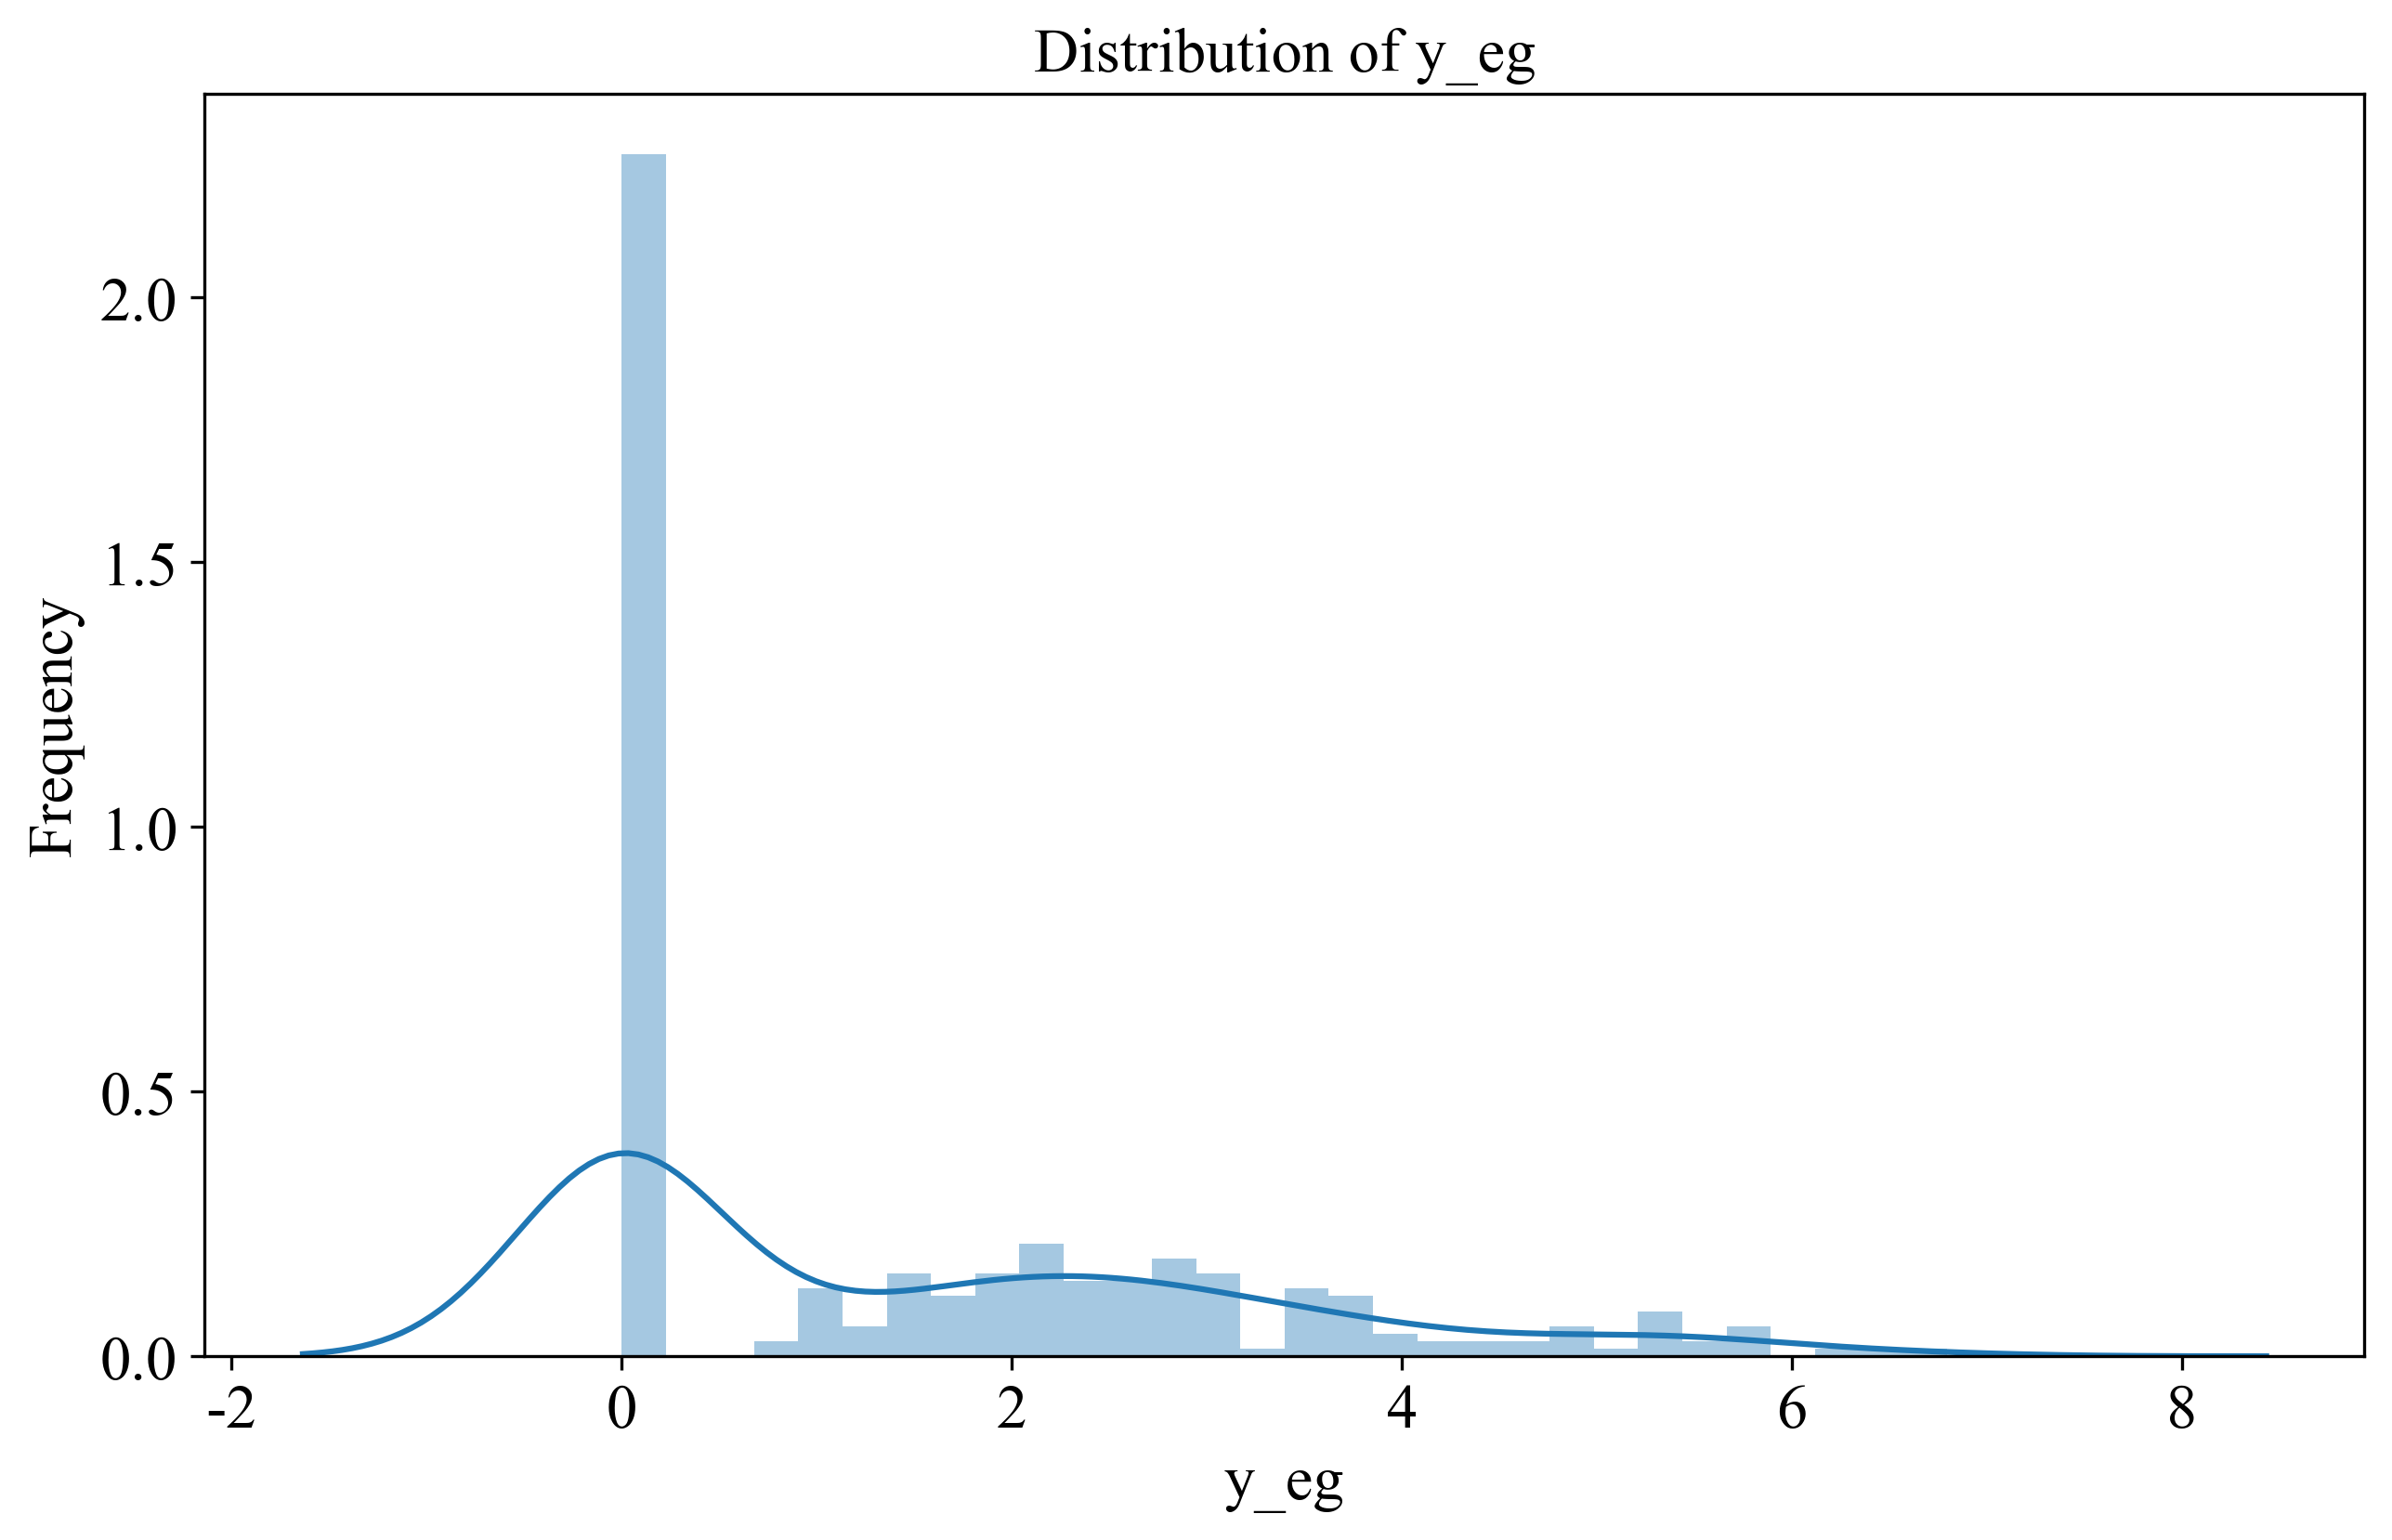

In [42]:
plt.figure(figsize=(10,6))

sns.distplot(y['Eg'], bins=30, kde=True)

plt.title('Distribution of y_eg')
plt.xlabel('y_eg')
plt.ylabel('Frequency')

plt.show()

In [43]:
X = remove_collinear_features(X, y['Eg'],0.8)
X

,V_a,R_b1,R_b2,A1_v,B1_v,C1_v,D_b,Ve_b,Ve_c,En_b,F_b,F_c,G_c,Ns_a,Ns_c,Np_c,Nd_b,Bt_a,W_a,Mn_a,Ar_a,V_c,Endiff_ab,tf,t,o,HOMO_character,HOMO_element,HOMO_energy,LUMO_character,...,mode_NsValence,min_NsValence,frelec_NdUnfValence,min_eden,meandiff_eden,min_latconst,min_cohesiveng,max_eneg_rahm,frelec_NpUnfValence,min_ioneng,max_sgn,Comp_L7Norm,mode_lquant,min_totvalelec,Comp_L10Norm,min_rad_d_orb,fwtmeandev_rad_d_orb,mode_totunfilledelec,max_rad_d_orb,maxdiff_spheat,Comp_L3Norm,fwtmean_enthalpyAtomization,mode_enthalpyAtomization,max_mp,mode_eden,meandiff_NpValence,maxdiff_elaff,min_elaff,meandiff_cohesiveng,maxdiff_zungerad
0,1.0,0.65,0.65,1.0,1.0,1.0,7.44,7.0,6.0,1.55,4.0,7.0,16.0,1.0,2.0,4.0,5.0,1156.15,22.989768,2.0,1.80,-2,0.62,0.742825,0.707143,0.464286,3,25,-0.266540,3,...,2.0,1.0,0.257,0.82,0.469,4.291,1.11,-5.14,0.205,495.8,229.0,0.941,1.0,1.0,0.958,0.230,0.070,2.0,0.401,751.0,0.868,237.846,249.0,1246.0,1.37,3.142,141.00,0.00,1.057,2.18
1,2.0,0.67,0.67,1.0,1.0,1.0,12.40,9.0,6.0,2.28,4.0,7.0,16.0,2.0,2.0,4.0,8.0,1038.15,112.411000,70.0,1.55,-2,0.59,0.822327,0.557143,0.478571,3,45,-0.239422,3,...,2.0,1.0,0.074,1.24,0.325,2.979,1.16,-9.32,0.148,719.7,225.0,0.941,1.0,6.0,0.958,0.370,0.010,2.0,0.420,689.0,0.868,317.211,249.0,1964.0,1.37,3.142,141.00,0.00,2.848,2.05
2,2.0,0.80,0.80,1.0,1.0,1.0,7.31,3.0,6.0,1.78,5.0,7.0,16.0,2.0,2.0,4.0,10.0,1757.15,40.078000,7.0,1.80,-2,0.78,0.842735,0.614857,0.571429,2,8,-0.338381,1,...,2.0,2.0,0.000,0.91,0.306,3.252,1.84,-6.11,0.346,558.3,225.0,0.941,1.0,2.0,0.958,0.340,0.023,2.0,0.401,686.0,0.868,237.131,249.0,842.0,1.37,2.928,138.63,2.37,0.451,2.53
3,4.0,0.69,0.69,1.0,1.0,1.0,8.91,10.0,6.0,1.91,4.0,7.0,16.0,2.0,2.0,4.0,8.0,2628.15,28.085500,78.0,1.10,-2,0.01,1.090357,0.185714,0.492857,2,8,-0.338381,2,...,2.0,2.0,0.083,1.37,0.263,3.524,2.60,-10.81,0.250,737.1,227.0,0.941,1.0,4.0,0.958,0.195,0.084,2.0,0.401,474.0,0.868,330.653,249.0,1455.0,1.37,2.857,29.00,112.00,1.554,1.71
4,4.0,0.72,0.72,1.0,1.0,1.0,1.74,2.0,6.0,1.31,2.0,7.0,16.0,2.0,2.0,4.0,0.0,3023.15,55.847000,55.0,1.40,-2,0.52,1.006620,0.302786,0.514286,3,26,-0.295049,3,...,2.0,2.0,0.111,1.17,0.357,2.867,1.51,-7.65,0.222,737.7,229.0,0.941,1.0,2.0,0.958,0.220,0.044,2.0,0.401,571.0,0.868,243.280,249.0,1538.0,1.37,3.142,141.00,0.00,1.661,1.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,2.0,0.87,0.87,1.0,1.0,1.0,6.97,3.0,6.0,1.10,3.0,7.0,16.0,2.0,2.0,4.0,0.0,1363.15,24.305000,68.0,1.50,-2,0.21,0.967911,0.287879,0.439394,2,34,-0.245806,2,...,2.0,2.0,0.000,0.92,0.318,3.209,1.51,-7.65,0.082,603.4,225.0,0.941,1.0,2.0,0.958,0.150,0.123,2.0,0.401,866.0,0.868,193.967,227.0,819.0,1.37,3.142,195.00,0.00,0.727,2.30
307,2.0,0.62,0.62,1.0,1.0,1.0,7.15,6.0,6.0,1.66,4.0,6.0,16.0,1.0,2.0,4.0,5.0,2485.15,107.868200,65.0,1.60,-2,0.27,0.816869,0.357602,0.280543,1,24,-0.150445,1,...,2.0,1.0,0.115,1.36,0.237,2.910,2.19,-8.00,0.092,652.9,229.0,0.941,1.0,6.0,0.958,0.250,0.036,2.0,0.385,247.0,0.868,266.784,197.0,1907.0,1.37,3.142,125.90,64.30,1.336,0.77
308,2.0,0.65,0.65,1.0,1.0,1.0,7.44,7.0,6.0,1.55,4.0,6.0,16.0,2.0,2.0,4.0,5.0,1179.15,65.390000,69.0,1.35,-2,0.10,0.881435,0.271493,0.294118,2,52,-0.226594,2,...,2.0,2.0,0.111,1.32,0.183,2.665,1.35,-11.95,0.089,717.3,217.0,0.941,1.0,7.0,0.958,0.175,0.056,2.0,0.325,278.0,0.868,211.586,197.0,1246.0,1.37,3.142,190.20,0.00,0.949,0.55
309,2.0,0.91,0.91,1.0,1.0,1.0,8.55,3.0,6.0,1.22,3.0,6.0,16.0,2.0,2.0,4.0,0.0,1038.15,112.411000,70.0,1.55,-2,0.47,0.903679,0.352941,0.411765,2,52,-0.226594,2,...,2.0,2.0,0.000,1.22,0.115,2.979,1.16,-8.36,0.080,573.0,194.0,0.941,1.0,12.0,0.958,0.325,0.032,2.0,0.401,63.0,0.868,211.443,197.0,1412.0,1.37,3.142,190.20,0.00,1.135,2.00


In [44]:
X = X.dropna(axis=1)
X

,V_a,R_b1,R_b2,A1_v,B1_v,C1_v,D_b,Ve_b,Ve_c,En_b,F_b,F_c,G_c,Ns_a,Ns_c,Np_c,Nd_b,Bt_a,W_a,Mn_a,Ar_a,V_c,Endiff_ab,tf,t,o,HOMO_character,HOMO_element,HOMO_energy,LUMO_character,...,max_htfusion,mode_workfn,fwtmean_elaff,mode_NsValence,min_NsValence,frelec_NdUnfValence,min_eden,meandiff_eden,max_eneg_rahm,frelec_NpUnfValence,min_ioneng,max_sgn,Comp_L7Norm,mode_lquant,min_totvalelec,Comp_L10Norm,min_rad_d_orb,fwtmeandev_rad_d_orb,mode_totunfilledelec,max_rad_d_orb,maxdiff_spheat,Comp_L3Norm,fwtmean_enthalpyAtomization,mode_enthalpyAtomization,max_mp,mode_eden,meandiff_NpValence,maxdiff_elaff,min_elaff,maxdiff_zungerad
0,1.0,0.65,0.65,1.0,1.0,1.0,7.44,7.0,6.0,1.55,4.0,7.0,16.0,1.0,2.0,4.0,5.0,1156.15,22.989768,2.0,1.80,-2,0.62,0.742825,0.707143,0.464286,3,25,-0.266540,3,...,13.40,4.03,88.061,2.0,1.0,0.257,0.82,0.469,-5.14,0.205,495.8,229.0,0.941,1.0,1.0,0.958,0.230,0.070,2.0,0.401,751.0,0.868,237.846,249.0,1246.0,1.37,3.142,141.00,0.00,2.18
1,2.0,0.67,0.67,1.0,1.0,1.0,12.40,9.0,6.0,2.28,4.0,7.0,16.0,2.0,2.0,4.0,8.0,1038.15,112.411000,70.0,1.55,-2,0.59,0.822327,0.557143,0.478571,3,45,-0.239422,3,...,21.80,4.03,111.885,2.0,1.0,0.074,1.24,0.325,-9.32,0.148,719.7,225.0,0.941,1.0,6.0,0.958,0.370,0.010,2.0,0.420,689.0,0.868,317.211,249.0,1964.0,1.37,3.142,141.00,0.00,2.05
2,2.0,0.80,0.80,1.0,1.0,1.0,7.31,3.0,6.0,1.78,5.0,7.0,16.0,2.0,2.0,4.0,10.0,1757.15,40.078000,7.0,1.80,-2,0.78,0.842735,0.614857,0.571429,2,8,-0.338381,1,...,9.20,4.03,89.115,2.0,2.0,0.000,0.91,0.306,-6.11,0.346,558.3,225.0,0.941,1.0,2.0,0.958,0.340,0.023,2.0,0.401,686.0,0.868,237.131,249.0,842.0,1.37,2.928,138.63,2.37,2.53
3,4.0,0.69,0.69,1.0,1.0,1.0,8.91,10.0,6.0,1.91,4.0,7.0,16.0,2.0,2.0,4.0,8.0,2628.15,28.085500,78.0,1.10,-2,0.01,1.090357,0.185714,0.492857,2,8,-0.338381,2,...,50.60,4.03,131.648,2.0,2.0,0.083,1.37,0.263,-10.81,0.250,737.1,227.0,0.941,1.0,4.0,0.958,0.195,0.084,2.0,0.401,474.0,0.868,330.653,249.0,1455.0,1.37,2.857,29.00,112.00,1.71
4,4.0,0.72,0.72,1.0,1.0,1.0,1.74,2.0,6.0,1.31,2.0,7.0,16.0,2.0,2.0,4.0,0.0,3023.15,55.847000,55.0,1.40,-2,0.52,1.006620,0.302786,0.514286,3,26,-0.295049,3,...,13.80,4.03,82.756,2.0,2.0,0.111,1.17,0.357,-7.65,0.222,737.7,229.0,0.941,1.0,2.0,0.958,0.220,0.044,2.0,0.401,571.0,0.868,243.280,249.0,1538.0,1.37,3.142,141.00,0.00,1.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,2.0,0.87,0.87,1.0,1.0,1.0,6.97,3.0,6.0,1.10,3.0,7.0,16.0,2.0,2.0,4.0,0.0,1363.15,24.305000,68.0,1.50,-2,0.21,0.967911,0.287879,0.439394,2,34,-0.245806,2,...,9.20,4.03,125.645,2.0,2.0,0.000,0.92,0.318,-7.65,0.082,603.4,225.0,0.941,1.0,2.0,0.958,0.150,0.123,2.0,0.401,866.0,0.868,193.967,227.0,819.0,1.37,3.142,195.00,0.00,2.30
307,2.0,0.62,0.62,1.0,1.0,1.0,7.15,6.0,6.0,1.66,4.0,6.0,16.0,1.0,2.0,4.0,5.0,2485.15,107.868200,65.0,1.60,-2,0.27,0.816869,0.357602,0.280543,1,24,-0.150445,1,...,21.00,4.03,144.955,2.0,1.0,0.115,1.36,0.237,-8.00,0.092,652.9,229.0,0.941,1.0,6.0,0.958,0.250,0.036,2.0,0.385,247.0,0.868,266.784,197.0,1907.0,1.37,3.142,125.90,64.30,0.77
308,2.0,0.65,0.65,1.0,1.0,1.0,7.44,7.0,6.0,1.55,4.0,6.0,16.0,2.0,2.0,4.0,5.0,1179.15,65.390000,69.0,1.35,-2,0.10,0.881435,0.271493,0.294118,2,52,-0.226594,2,...,17.91,4.03,108.604,2.0,2.0,0.111,1.32,0.183,-11.95,0.089,717.3,217.0,0.941,1.0,7.0,0.958,0.175,0.056,2.0,0.325,278.0,0.868,211.586,197.0,1246.0,1.37,3.142,190.20,0.00,0.55
309,2.0,0.91,0.91,1.0,1.0,1.0,8.55,3.0,6.0,1.22,3.0,6.0,16.0,2.0,2.0,4.0,0.0,1038.15,112.411000,70.0,1.55,-2,0.47,0.903679,0.352941,0.411765,2,52,-0.226594,2,...,17.91,4.03,122.904,2.0,2.0,0.000,1.22,0.115,-8.36,0.080,573.0,194.0,0.941,1.0,12.0,0.958,0.325,0.032,2.0,0.401,63.0,0.868,211.443,197.0,1412.0,1.37,3.142,190.20,0.00,2.00


In [47]:
y['Eg'] = y['Eg'].map(lambda x: 0 if x==0 else 1)
y

,is_gap_direct,Eh,Eg
0,False,0.116693,0
1,False,0.000000,1
2,True,0.000000,1
3,True,0.026807,1
4,False,0.096985,0
...,...,...,...
317,False,0.341997,0
318,False,0.000000,0
319,False,0.000000,0
320,False,0.026176,0


In [48]:
print(y['Eg'].value_counts())

0    160
1    151
Name: Eg, dtype: int64


In [49]:
y = spinels1.iloc[:,1:5]
y.columns = ['is_gap_direct','Ef','Eh','Eg']
y=y.drop('Ef',axis=1)
y['is_gap_direct'] = y['is_gap_direct'].map(lambda x: 1 if x else 0)
y['Eh'] = y['Eh'].map(lambda x: 1 if x<=0.025 else 0)
y['Eg'] = y['Eg'].map(lambda x: 1 if 0.9<=x<=2 else 0)
y=y.reset_index(drop=True)
y

,is_gap_direct,Eh,Eg
0,0,0,0
1,0,1,0
2,1,1,0
3,1,0,0
4,0,0,0
...,...,...,...
306,0,0,0
307,0,1,0
308,0,1,0
309,0,0,0


In [50]:
print(y['is_gap_direct'].value_counts())
print(y['Eh'].value_counts())
print(y['Eg'].value_counts())

0    230
1     81
Name: is_gap_direct, dtype: int64
0    178
1    133
Name: Eh, dtype: int64
0    268
1     43
Name: Eg, dtype: int64


In [51]:
print(X.shape)
print(y.shape)

(311, 88)
(311, 3)


In [52]:
spinels_ff=pd.concat([X,y],axis=1)
spinels_ff
spinels_ff.to_csv('./data/spinels_ff.csv')

In [53]:
spinels_ff

,V_a,R_b1,R_b2,A1_v,B1_v,C1_v,D_b,Ve_b,Ve_c,En_b,F_b,F_c,G_c,Ns_a,Ns_c,Np_c,Nd_b,Bt_a,W_a,Mn_a,Ar_a,V_c,Endiff_ab,tf,t,o,HOMO_character,HOMO_element,HOMO_energy,LUMO_character,...,mode_NsValence,min_NsValence,frelec_NdUnfValence,min_eden,meandiff_eden,max_eneg_rahm,frelec_NpUnfValence,min_ioneng,max_sgn,Comp_L7Norm,mode_lquant,min_totvalelec,Comp_L10Norm,min_rad_d_orb,fwtmeandev_rad_d_orb,mode_totunfilledelec,max_rad_d_orb,maxdiff_spheat,Comp_L3Norm,fwtmean_enthalpyAtomization,mode_enthalpyAtomization,max_mp,mode_eden,meandiff_NpValence,maxdiff_elaff,min_elaff,maxdiff_zungerad,is_gap_direct,Eh,Eg
0,1.0,0.65,0.65,1.0,1.0,1.0,7.44,7.0,6.0,1.55,4.0,7.0,16.0,1.0,2.0,4.0,5.0,1156.15,22.989768,2.0,1.80,-2,0.62,0.742825,0.707143,0.464286,3,25,-0.266540,3,...,2.0,1.0,0.257,0.82,0.469,-5.14,0.205,495.8,229.0,0.941,1.0,1.0,0.958,0.230,0.070,2.0,0.401,751.0,0.868,237.846,249.0,1246.0,1.37,3.142,141.00,0.00,2.18,0,0,0
1,2.0,0.67,0.67,1.0,1.0,1.0,12.40,9.0,6.0,2.28,4.0,7.0,16.0,2.0,2.0,4.0,8.0,1038.15,112.411000,70.0,1.55,-2,0.59,0.822327,0.557143,0.478571,3,45,-0.239422,3,...,2.0,1.0,0.074,1.24,0.325,-9.32,0.148,719.7,225.0,0.941,1.0,6.0,0.958,0.370,0.010,2.0,0.420,689.0,0.868,317.211,249.0,1964.0,1.37,3.142,141.00,0.00,2.05,0,1,0
2,2.0,0.80,0.80,1.0,1.0,1.0,7.31,3.0,6.0,1.78,5.0,7.0,16.0,2.0,2.0,4.0,10.0,1757.15,40.078000,7.0,1.80,-2,0.78,0.842735,0.614857,0.571429,2,8,-0.338381,1,...,2.0,2.0,0.000,0.91,0.306,-6.11,0.346,558.3,225.0,0.941,1.0,2.0,0.958,0.340,0.023,2.0,0.401,686.0,0.868,237.131,249.0,842.0,1.37,2.928,138.63,2.37,2.53,1,1,0
3,4.0,0.69,0.69,1.0,1.0,1.0,8.91,10.0,6.0,1.91,4.0,7.0,16.0,2.0,2.0,4.0,8.0,2628.15,28.085500,78.0,1.10,-2,0.01,1.090357,0.185714,0.492857,2,8,-0.338381,2,...,2.0,2.0,0.083,1.37,0.263,-10.81,0.250,737.1,227.0,0.941,1.0,4.0,0.958,0.195,0.084,2.0,0.401,474.0,0.868,330.653,249.0,1455.0,1.37,2.857,29.00,112.00,1.71,1,0,0
4,4.0,0.72,0.72,1.0,1.0,1.0,1.74,2.0,6.0,1.31,2.0,7.0,16.0,2.0,2.0,4.0,0.0,3023.15,55.847000,55.0,1.40,-2,0.52,1.006620,0.302786,0.514286,3,26,-0.295049,3,...,2.0,2.0,0.111,1.17,0.357,-7.65,0.222,737.7,229.0,0.941,1.0,2.0,0.958,0.220,0.044,2.0,0.401,571.0,0.868,243.280,249.0,1538.0,1.37,3.142,141.00,0.00,1.64,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,2.0,0.87,0.87,1.0,1.0,1.0,6.97,3.0,6.0,1.10,3.0,7.0,16.0,2.0,2.0,4.0,0.0,1363.15,24.305000,68.0,1.50,-2,0.21,0.967911,0.287879,0.439394,2,34,-0.245806,2,...,2.0,2.0,0.000,0.92,0.318,-7.65,0.082,603.4,225.0,0.941,1.0,2.0,0.958,0.150,0.123,2.0,0.401,866.0,0.868,193.967,227.0,819.0,1.37,3.142,195.00,0.00,2.30,0,0,0
307,2.0,0.62,0.62,1.0,1.0,1.0,7.15,6.0,6.0,1.66,4.0,6.0,16.0,1.0,2.0,4.0,5.0,2485.15,107.868200,65.0,1.60,-2,0.27,0.816869,0.357602,0.280543,1,24,-0.150445,1,...,2.0,1.0,0.115,1.36,0.237,-8.00,0.092,652.9,229.0,0.941,1.0,6.0,0.958,0.250,0.036,2.0,0.385,247.0,0.868,266.784,197.0,1907.0,1.37,3.142,125.90,64.30,0.77,0,1,0
308,2.0,0.65,0.65,1.0,1.0,1.0,7.44,7.0,6.0,1.55,4.0,6.0,16.0,2.0,2.0,4.0,5.0,1179.15,65.390000,69.0,1.35,-2,0.10,0.881435,0.271493,0.294118,2,52,-0.226594,2,...,2.0,2.0,0.111,1.32,0.183,-11.95,0.089,717.3,217.0,0.941,1.0,7.0,0.958,0.175,0.056,2.0,0.325,278.0,0.868,211.586,197.0,1246.0,1.37,3.142,190.20,0.00,0.55,0,1,0
309,2.0,0.91,0.91,1.0,1.0,1.0,8.55,3.0,6.0,1.22,3.0,6.0,16.0,2.0,2.0,4.0,0.0,1038.15,112.411000,70.0,1.55,-2,0.47,0.903679,0.352941,0.411765,2,52,-0.226594,2,...,2.0,2.0,0.000,1.22,0.115,-8.36,0.080,573.0,194.0,0.941,1.0,12.0,0.958,0.325,0.032,2.0,0.401,63.0,0.868,211.443,197.0,1412.0,1.37,3.142,190.20,0.00,2.00,0,0,0


# MTGBM modeling

In [54]:
spinels1=pd.read_csv('./data/spinels_ff.csv',index_col=0)
X=spinels1.iloc[:,:-3]
y=spinels1.iloc[:,-3:]
X

,V_a,R_b1,R_b2,A1_v,B1_v,C1_v,D_b,Ve_b,Ve_c,En_b,F_b,F_c,G_c,Ns_a,Ns_c,Np_c,Nd_b,Bt_a,W_a,Mn_a,Ar_a,V_c,Endiff_ab,tf,t,o,HOMO_character,HOMO_element,HOMO_energy,LUMO_character,...,max_htfusion,mode_workfn,fwtmean_elaff,mode_NsValence,min_NsValence,frelec_NdUnfValence,min_eden,meandiff_eden,max_eneg_rahm,frelec_NpUnfValence,min_ioneng,max_sgn,Comp_L7Norm,mode_lquant,min_totvalelec,Comp_L10Norm,min_rad_d_orb,fwtmeandev_rad_d_orb,mode_totunfilledelec,max_rad_d_orb,maxdiff_spheat,Comp_L3Norm,fwtmean_enthalpyAtomization,mode_enthalpyAtomization,max_mp,mode_eden,meandiff_NpValence,maxdiff_elaff,min_elaff,maxdiff_zungerad
0,1.0,0.65,0.65,1.0,1.0,1.0,7.44,7.0,6.0,1.55,4.0,7.0,16.0,1.0,2.0,4.0,5.0,1156.15,22.989768,2.0,1.80,-2,0.62,0.742825,0.707143,0.464286,3,25,-0.266540,3,...,13.40,4.03,88.061,2.0,1.0,0.257,0.82,0.469,-5.14,0.205,495.8,229.0,0.941,1.0,1.0,0.958,0.230,0.070,2.0,0.401,751.0,0.868,237.846,249.0,1246.0,1.37,3.142,141.00,0.00,2.18
1,2.0,0.67,0.67,1.0,1.0,1.0,12.40,9.0,6.0,2.28,4.0,7.0,16.0,2.0,2.0,4.0,8.0,1038.15,112.411000,70.0,1.55,-2,0.59,0.822327,0.557143,0.478571,3,45,-0.239422,3,...,21.80,4.03,111.885,2.0,1.0,0.074,1.24,0.325,-9.32,0.148,719.7,225.0,0.941,1.0,6.0,0.958,0.370,0.010,2.0,0.420,689.0,0.868,317.211,249.0,1964.0,1.37,3.142,141.00,0.00,2.05
2,2.0,0.80,0.80,1.0,1.0,1.0,7.31,3.0,6.0,1.78,5.0,7.0,16.0,2.0,2.0,4.0,10.0,1757.15,40.078000,7.0,1.80,-2,0.78,0.842735,0.614857,0.571429,2,8,-0.338381,1,...,9.20,4.03,89.115,2.0,2.0,0.000,0.91,0.306,-6.11,0.346,558.3,225.0,0.941,1.0,2.0,0.958,0.340,0.023,2.0,0.401,686.0,0.868,237.131,249.0,842.0,1.37,2.928,138.63,2.37,2.53
3,4.0,0.69,0.69,1.0,1.0,1.0,8.91,10.0,6.0,1.91,4.0,7.0,16.0,2.0,2.0,4.0,8.0,2628.15,28.085500,78.0,1.10,-2,0.01,1.090357,0.185714,0.492857,2,8,-0.338381,2,...,50.60,4.03,131.648,2.0,2.0,0.083,1.37,0.263,-10.81,0.250,737.1,227.0,0.941,1.0,4.0,0.958,0.195,0.084,2.0,0.401,474.0,0.868,330.653,249.0,1455.0,1.37,2.857,29.00,112.00,1.71
4,4.0,0.72,0.72,1.0,1.0,1.0,1.74,2.0,6.0,1.31,2.0,7.0,16.0,2.0,2.0,4.0,0.0,3023.15,55.847000,55.0,1.40,-2,0.52,1.006620,0.302786,0.514286,3,26,-0.295049,3,...,13.80,4.03,82.756,2.0,2.0,0.111,1.17,0.357,-7.65,0.222,737.7,229.0,0.941,1.0,2.0,0.958,0.220,0.044,2.0,0.401,571.0,0.868,243.280,249.0,1538.0,1.37,3.142,141.00,0.00,1.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,2.0,0.87,0.87,1.0,1.0,1.0,6.97,3.0,6.0,1.10,3.0,7.0,16.0,2.0,2.0,4.0,0.0,1363.15,24.305000,68.0,1.50,-2,0.21,0.967911,0.287879,0.439394,2,34,-0.245806,2,...,9.20,4.03,125.645,2.0,2.0,0.000,0.92,0.318,-7.65,0.082,603.4,225.0,0.941,1.0,2.0,0.958,0.150,0.123,2.0,0.401,866.0,0.868,193.967,227.0,819.0,1.37,3.142,195.00,0.00,2.30
307,2.0,0.62,0.62,1.0,1.0,1.0,7.15,6.0,6.0,1.66,4.0,6.0,16.0,1.0,2.0,4.0,5.0,2485.15,107.868200,65.0,1.60,-2,0.27,0.816869,0.357602,0.280543,1,24,-0.150445,1,...,21.00,4.03,144.955,2.0,1.0,0.115,1.36,0.237,-8.00,0.092,652.9,229.0,0.941,1.0,6.0,0.958,0.250,0.036,2.0,0.385,247.0,0.868,266.784,197.0,1907.0,1.37,3.142,125.90,64.30,0.77
308,2.0,0.65,0.65,1.0,1.0,1.0,7.44,7.0,6.0,1.55,4.0,6.0,16.0,2.0,2.0,4.0,5.0,1179.15,65.390000,69.0,1.35,-2,0.10,0.881435,0.271493,0.294118,2,52,-0.226594,2,...,17.91,4.03,108.604,2.0,2.0,0.111,1.32,0.183,-11.95,0.089,717.3,217.0,0.941,1.0,7.0,0.958,0.175,0.056,2.0,0.325,278.0,0.868,211.586,197.0,1246.0,1.37,3.142,190.20,0.00,0.55
309,2.0,0.91,0.91,1.0,1.0,1.0,8.55,3.0,6.0,1.22,3.0,6.0,16.0,2.0,2.0,4.0,0.0,1038.15,112.411000,70.0,1.55,-2,0.47,0.903679,0.352941,0.411765,2,52,-0.226594,2,...,17.91,4.03,122.904,2.0,2.0,0.000,1.22,0.115,-8.36,0.080,573.0,194.0,0.941,1.0,12.0,0.958,0.325,0.032,2.0,0.401,63.0,0.868,211.443,197.0,1412.0,1.37,3.142,190.20,0.00,2.00


In [55]:
X = X.dropna(axis=1)
X

,V_a,R_b1,R_b2,A1_v,B1_v,C1_v,D_b,Ve_b,Ve_c,En_b,F_b,F_c,G_c,Ns_a,Ns_c,Np_c,Nd_b,Bt_a,W_a,Mn_a,Ar_a,V_c,Endiff_ab,tf,t,o,HOMO_character,HOMO_element,HOMO_energy,LUMO_character,...,max_htfusion,mode_workfn,fwtmean_elaff,mode_NsValence,min_NsValence,frelec_NdUnfValence,min_eden,meandiff_eden,max_eneg_rahm,frelec_NpUnfValence,min_ioneng,max_sgn,Comp_L7Norm,mode_lquant,min_totvalelec,Comp_L10Norm,min_rad_d_orb,fwtmeandev_rad_d_orb,mode_totunfilledelec,max_rad_d_orb,maxdiff_spheat,Comp_L3Norm,fwtmean_enthalpyAtomization,mode_enthalpyAtomization,max_mp,mode_eden,meandiff_NpValence,maxdiff_elaff,min_elaff,maxdiff_zungerad
0,1.0,0.65,0.65,1.0,1.0,1.0,7.44,7.0,6.0,1.55,4.0,7.0,16.0,1.0,2.0,4.0,5.0,1156.15,22.989768,2.0,1.80,-2,0.62,0.742825,0.707143,0.464286,3,25,-0.266540,3,...,13.40,4.03,88.061,2.0,1.0,0.257,0.82,0.469,-5.14,0.205,495.8,229.0,0.941,1.0,1.0,0.958,0.230,0.070,2.0,0.401,751.0,0.868,237.846,249.0,1246.0,1.37,3.142,141.00,0.00,2.18
1,2.0,0.67,0.67,1.0,1.0,1.0,12.40,9.0,6.0,2.28,4.0,7.0,16.0,2.0,2.0,4.0,8.0,1038.15,112.411000,70.0,1.55,-2,0.59,0.822327,0.557143,0.478571,3,45,-0.239422,3,...,21.80,4.03,111.885,2.0,1.0,0.074,1.24,0.325,-9.32,0.148,719.7,225.0,0.941,1.0,6.0,0.958,0.370,0.010,2.0,0.420,689.0,0.868,317.211,249.0,1964.0,1.37,3.142,141.00,0.00,2.05
2,2.0,0.80,0.80,1.0,1.0,1.0,7.31,3.0,6.0,1.78,5.0,7.0,16.0,2.0,2.0,4.0,10.0,1757.15,40.078000,7.0,1.80,-2,0.78,0.842735,0.614857,0.571429,2,8,-0.338381,1,...,9.20,4.03,89.115,2.0,2.0,0.000,0.91,0.306,-6.11,0.346,558.3,225.0,0.941,1.0,2.0,0.958,0.340,0.023,2.0,0.401,686.0,0.868,237.131,249.0,842.0,1.37,2.928,138.63,2.37,2.53
3,4.0,0.69,0.69,1.0,1.0,1.0,8.91,10.0,6.0,1.91,4.0,7.0,16.0,2.0,2.0,4.0,8.0,2628.15,28.085500,78.0,1.10,-2,0.01,1.090357,0.185714,0.492857,2,8,-0.338381,2,...,50.60,4.03,131.648,2.0,2.0,0.083,1.37,0.263,-10.81,0.250,737.1,227.0,0.941,1.0,4.0,0.958,0.195,0.084,2.0,0.401,474.0,0.868,330.653,249.0,1455.0,1.37,2.857,29.00,112.00,1.71
4,4.0,0.72,0.72,1.0,1.0,1.0,1.74,2.0,6.0,1.31,2.0,7.0,16.0,2.0,2.0,4.0,0.0,3023.15,55.847000,55.0,1.40,-2,0.52,1.006620,0.302786,0.514286,3,26,-0.295049,3,...,13.80,4.03,82.756,2.0,2.0,0.111,1.17,0.357,-7.65,0.222,737.7,229.0,0.941,1.0,2.0,0.958,0.220,0.044,2.0,0.401,571.0,0.868,243.280,249.0,1538.0,1.37,3.142,141.00,0.00,1.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,2.0,0.87,0.87,1.0,1.0,1.0,6.97,3.0,6.0,1.10,3.0,7.0,16.0,2.0,2.0,4.0,0.0,1363.15,24.305000,68.0,1.50,-2,0.21,0.967911,0.287879,0.439394,2,34,-0.245806,2,...,9.20,4.03,125.645,2.0,2.0,0.000,0.92,0.318,-7.65,0.082,603.4,225.0,0.941,1.0,2.0,0.958,0.150,0.123,2.0,0.401,866.0,0.868,193.967,227.0,819.0,1.37,3.142,195.00,0.00,2.30
307,2.0,0.62,0.62,1.0,1.0,1.0,7.15,6.0,6.0,1.66,4.0,6.0,16.0,1.0,2.0,4.0,5.0,2485.15,107.868200,65.0,1.60,-2,0.27,0.816869,0.357602,0.280543,1,24,-0.150445,1,...,21.00,4.03,144.955,2.0,1.0,0.115,1.36,0.237,-8.00,0.092,652.9,229.0,0.941,1.0,6.0,0.958,0.250,0.036,2.0,0.385,247.0,0.868,266.784,197.0,1907.0,1.37,3.142,125.90,64.30,0.77
308,2.0,0.65,0.65,1.0,1.0,1.0,7.44,7.0,6.0,1.55,4.0,6.0,16.0,2.0,2.0,4.0,5.0,1179.15,65.390000,69.0,1.35,-2,0.10,0.881435,0.271493,0.294118,2,52,-0.226594,2,...,17.91,4.03,108.604,2.0,2.0,0.111,1.32,0.183,-11.95,0.089,717.3,217.0,0.941,1.0,7.0,0.958,0.175,0.056,2.0,0.325,278.0,0.868,211.586,197.0,1246.0,1.37,3.142,190.20,0.00,0.55
309,2.0,0.91,0.91,1.0,1.0,1.0,8.55,3.0,6.0,1.22,3.0,6.0,16.0,2.0,2.0,4.0,0.0,1038.15,112.411000,70.0,1.55,-2,0.47,0.903679,0.352941,0.411765,2,52,-0.226594,2,...,17.91,4.03,122.904,2.0,2.0,0.000,1.22,0.115,-8.36,0.080,573.0,194.0,0.941,1.0,12.0,0.958,0.325,0.032,2.0,0.401,63.0,0.868,211.443,197.0,1412.0,1.37,3.142,190.20,0.00,2.00


In [56]:
X_train,X_test,y_train_s,y_test_s = train_test_split(X,y,test_size=0.2,shuffle=True)
cate = []
y_train = y_train_s['Eg']
y_test = y_test_s['Eg']
print(X_train.shape)
print(y_test.shape)

(248, 88)
(63,)


In [57]:
y_train.value_counts()

0    210
1     38
Name: Eg, dtype: int64

In [58]:
# MTGBM


import math
import lightgbmmt as lgb

import os
from sklearn.metrics import log_loss
from sklearn import preprocessing
import random,math
import pickle
seed = 10
from collections import Counter
from math import log2,log10
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score


def entropy(pr):
    total = len(pr)
    pr = Counter(pr)
    log2 = math.log2
    ent = 0
    for i in pr:
        p = float(pr[i]) / total
        ent += (-p) * log2(p)
    return ent
import lightgbmmt as lgb
def metric(true,pred):
    thre = 0.2
    pred = (pred > thre).astype(int)
    p = np.sum(pred*true)/(np.sum(pred) + 0.01)
    r = np.sum(pred*true)/(np.sum(true) + 0.01)
    return p,r,2*p*r/(p+r)


num_label = 3
params = { 'objective': 'custom',
          'num_labels':num_label, 
          'tree_learner': 'serial2',
          'boosting': 'gbdt',
          'verbosity': -1,
          'min_child_weight': 0.1,
          'min_data_in_leaf': 25,
          "num_threads":8,
          'metric_freq':10,
          'data_random_seed': 17,
          
          'max_depth': 16,
          'learning_rate': 0.03,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'lambda_l1': 0.5,
          'lambda_l2': 0.05,
           'num_leaves': 500
         }

print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 500

{'objective': 'custom', 'num_labels': 3, 'tree_learner': 'serial2', 'boosting': 'gbdt', 'verbosity': -1, 'min_child_weight': 0.1, 'min_data_in_leaf': 25, 'num_threads': 8, 'metric_freq': 10, 'data_random_seed': 17, 'max_depth': 16, 'learning_rate': 0.03, 'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'lambda_l1': 0.5, 'lambda_l2': 0.05, 'num_leaves': 500}


In [59]:
folds = 5
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)

In [60]:
y_test.value_counts()

0    58
1     5
Name: Eg, dtype: int64

In [61]:
print(y_train_s.shape)

(248, 3)


In [62]:
def predict(X):
    predictions = model.predict(X)
    return predictions
from shap.explainers import Permutation
explainer = Permutation(predict,X_train, feature_names=X_train.columns)

In [63]:
# 设置评估函数，RMSE
def self_metric(preds, train_data):
    labels = train_data.get_label()
    labels2 = labels.reshape((num_label,-1)).transpose()[:,0]
    preds2 = preds.reshape((num_label,-1)).transpose()[:,0]
    preds2 = 1. / (1. + np.exp(-preds2))
    score = roc_auc_score(labels2, preds2)
    return 'self_metric', score, False

# 设置目标函数，RMSE
def mymse2(preds, train_data, ep = 0):
    labels = train_data.get_label()
    labels2 = labels.reshape((num_label,-1)).transpose()
    preds2 = preds.reshape((num_label,-1)).transpose()
    labels2 = np.clip(labels2,0,1)
    # 节点分裂和更新
    preds3 = 1. / (1. + np.exp(-preds2))
    grad2 = preds3 - labels2
    hess2 = grad2 * 0. + 1
    hess2 = preds3 * (1. - preds3)
    #任务之间相关性越小，γ越大，结果越好
    import random
    beta = max(0.0,0.5 - 0.2 * (ep//100)) * 2
    beta = 0.2
    #设置归一化因子w来归一化所有任务的损失
    w = np.array([1,0.1 * beta,0.1 * beta])
    w2 = np.array([1.0,1.0,1.0])
    # 增加Eg的权重
    w = np.array([1,0.1 * beta,2 * beta])
    w2 = np.array([1.0,1.0,2.0])
    grad = (grad2) * np.array(w)
    grad = np.sum(grad,axis = 1)
    grad2 = (grad2 * w2).transpose().reshape((-1))
        # 注意：这里作者是做加权融合，权重的设置应该配合数目标的量纲，尽可能将不同目标的gradient放在同一量纲上
        #将它们与权重相加来定义fG和fH
    hess = np.sum(hess2 * np.array(w),axis = 1)
    return grad, hess, grad2, hess2

In [67]:
y_eg=y['Eg']
y_gapd=y['is_gap_direct']
y_eh=y['Eh']

In [87]:
X_train,X_test,y_train_s,y_test_s = train_test_split(X,y,test_size=0.2,shuffle=True)
cate = []

y_train = y_train_s['Eg']
y_test = y_test_s['Eg']
# y_train_teg = y_train_s['Eg'].map(lambda x: 1 if x!=0 else 0)
# y_test_teg = y_train_s['Eg'].map(lambda x: 1 if x!=0 else 0)
print(X_train.shape)
print(y_test.value_counts())
# print(y_test_teg.value_counts())

(260, 8)
0    56
1     9
Name: Eg, dtype: int64


# Bayesian inverse design

In [89]:
a_elements =['Li', 'Be', 'Na', 'Mg', 'Al', 'Ca', 'Bi', 'Cs', 'Ba', 'Ge',
             'Fe', 'Mn', 'Cr', 'Ni', 'Co', 'Cu', 'W', 'Mo', 'V', 'Ti', 'Zr', 'Ta', 'Nb']
b_elements = ['Li', 'Be', 'Na', 'Mg', 'Al', 'Ca', 'Bi', 'Cs', 'Ba', 'Ge',
             'Fe', 'Mn', 'Cr', 'Ni', 'Co', 'Cu', 'W', 'Mo', 'V', 'Ti', 'Zr', 'Ta', 'Nb']
c_elements = ['O','S','Se']
element_count = 4

In [90]:
print(len(a_elements))

23


In [91]:
#exception handling
class NoValidCombinationError(Exception):
    pass
class RadiusError(Exception):
    pass
class TfError(Exception):
    pass
class FeaturizorError(Exception):
    pass

In [92]:
def IRerror_right(Ion_radius):
    if(0.5<=Ion_radius.any()<=1.1):
        return True
    else:
        return False

In [93]:
def get_preds(preds, train_data):
    labels = train_data.get_label()
    preds2 = 1. / (1.+ np.exp(-preds))
    preds_binary = np.where(preds2 > 0.5,1,0)
    print(preds_binary)
    return preds_binary

In [94]:
ele_df2 = pd.read_csv('./data/elements2.csv')
def atomic_radii(element):
    atomic_radii = ele_df2[ele_df2['symbol'] == element]['Atomic radius (Å)'].values[0] 
    return atomic_radii
atomic_radii(a_elements[1])

1.05

In [95]:
df = pd.read_csv('./data/Ionic_Radii.txt',
                 sep='\s+',
                 header=None,
                 names=["ions", "radii", "Sources"],
                 skiprows=1)
# 分割第一列
df['Element'] = df['ions'].str[:2]
df['Charge'] = df['ions'].str[2:4]
df['Coordination'] = df['ions'].str[5:].astype(np.int)

def remove_char(x):
    if '_' in x:
        return str(x).split('_')[0]
    elif '+' in x:
        return int(str(x).split('+')[0])
    elif '-' in x:
        return 0 - int(str(x).split('-')[0])
    else:
        return x


df['Element'] = df['Element'].map(lambda x: remove_char(x))
df['Charge'] = df['Charge'].map(lambda x: remove_char(x))
    # 删除原始的第一列
df.drop('ions', axis=1, inplace=True)
df

,radii,Sources,Element,Charge,Coordination
0,0.7600,Shannon,Li,1,6
1,0.5900,Shannon,Li,1,4
2,0.9200,Shannon,Li,1,8
3,0.1600,Shannon,Be,2,3
4,0.2700,Shannon,Be,2,4
...,...,...,...,...,...
1195,0.9630,Ouyang,Tc,3,10
1196,1.3431,Ouyang,Sn,2,10
1197,1.0501,Ouyang,Zr,3,10
1198,0.9153,Ouyang,W,3,10


In [96]:
charge_lists = df.groupby('Element')['Charge'].apply(list)
charge_lists

Element
Ac                                      [3, 3, 3, 3, 3]
Ag    [1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 3, 2, 3, ...
Al                                   [3, 3, 3, 3, 3, 3]
Am    [2, 2, 2, 3, 3, 4, 4, 3, 4, 2, 2, 2, 3, 4, 2, ...
As                       [3, 5, 5, 3, 5, 3, 3, 5, 3, 5]
                            ...                        
W     [4, 5, 6, 6, 6, 4, 5, 6, 4, 5, 4, 5, 6, 3, 3, ...
Y                  [3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 3, 2]
Yb              [2, 2, 2, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3]
Zn                                   [2, 2, 2, 2, 2, 2]
Zr    [4, 4, 4, 4, 4, 4, 2, 2, 4, 2, 2, 3, 3, 3, 3, ...
Name: Charge, Length: 91, dtype: object

In [97]:
def charge_right(element_c1, element_c2):
    # 通过指定元素值找出对应的charge列表
    c1_charge = charge_lists[element_c1]
    c2_charge = charge_lists[element_c2]

    common_charge = set(c1_charge) & set(c2_charge)
    if common_charge:
        return True
    else:
        return False

In [98]:
charge_right('Fe','Mg')

True

In [99]:
from pymatgen.core import Element

def oxidation_valence(element_c1, element_c2):
    element1 = Element(element_c1)
    element2 = Element(element_c2)

    # Get the common oxidation valence state for each element
    oxidation_states1 = element1.common_oxidation_states
    oxidation_states2 = element2.common_oxidation_states

    # Determine whether there are identical oxidation states between two elements
    common_oxidation_states = set(oxidation_states1) & set(oxidation_states2)
    if common_oxidation_states:
        return True
    else:
        return False
oxidation_valence('Fe','Mg')

True

In [99]:
spinels = pd.DataFrame(columns=['formula', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'A1_v', 'A2_v', 'B1_v', 'B2_v', 'C1_v', 'C2_v', 'extra'])
spinels = parse_formula(spinels, 'Mo0.95W0.05Li2O2.03Se1.97')
spinels

,formula,A1,A2,B1,B2,C1,C2,A1_v,A2_v,B1_v,B2_v,C1_v,C2_v,extra
0,Mo0.95W0.05Li2O2.03Se1.97,Mo,W,Li,Li,O,Se,0.95,0.05,2,0,2.03,1.97,0


In [1]:
import FeatureEngineer
engineer = FeatureEngineer(df['formula'], y)
X, y = engineer.process_features()

ModuleNotFoundError: No module named 'FeatureEngineer'

In [2]:
import optuna
import concurrent.futures
from Featurizor3 import Featurizor

def target_ac(x1, a1, a2,b, z1, c1, c2):
    spinels = pd.DataFrame(columns=['formula', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'A1_v', 'A2_v', 'B1_v', 'B2_v', 'C1_v', 'C2_v', 'extra'])
    target_eg = 1.34
    compositions = []
    formula = ''
    x2 = 1 - x1
    ratios1 = [x1, x2]
    z2 = 4 - z1
    ratios3 = [z1, z2]
    max_attempts = 100
    attempts = 0
    attempts_doping = 0  

    # 选择 A 和 A' 元素，确保它们不相等
    element_a1 = a_elements[round(a1)]
    element_a2 = a_elements[round(a2)]
    if element_a1 == element_a2 or not charge_right(element_a1,element_a2):
        raise NoValidCombinationError()

    # 选择 B 和 B' 元素，确保它们不相等且满足原子半径条件
    element_b = b_elements[round(b)]
    if element_b in [element_a1, element_a2]:
        print('NoValidCombinationError')
        raise NoValidCombinationError()

    # 选择 C和 C' 元素，确保它们不相等且满足原子半径条件
    element_c1 = c_elements[round(c1)]
    element_c2 = c_elements[round(c2)]
    if not charge_right(element_c1,element_c2):
        print('NoValidCombinationError')
        raise NoValidCombinationError()        

    elements = [element_a1, element_a2, element_b, element_c1,element_c2]

    formula = ''
    for i in range(2):
        element = elements[i]
        ratio = round(ratios1[i], 2)
        formula += element + str(ratio)
    
    formula += elements[2] + '2'

    if element_c1 == element_c2:
        formula += element_c1+'4'
    else:
        for i in range(3, 5):
            element = elements[i]
            ratio = round(ratios3[i-3], 2)
            formula += element + str(ratio)

    print(formula)
    print('*****' + formula + '*****')
    compositions.append(formula)
#     mp_feature = magpie_feature(formula)
#     mp_feature = mp_feature.reshape(1,feature_number

    parse = parse_formula(spinels,formula)
    spinels_data= Featurizor().featurize(parse)
#     if(len(spinels_data.columns)!=77):
#         print('FeaturizorError:columns!=77')
#         raise FeaturizorError() 
#     print(spinels_data.columns)
    if not IRerror_right(spinels_data['R_a1']) or not IRerror_right(spinels_data['R_a2']) or not IRerror_right(spinels_data['R_b1']) or not IRerror_right(spinels_data['R_b2']) or not IRerror_right(spinels_data['R_c1']) or not IRerror_right(spinels_data['R_c2']):
        print('RadiusError')
        raise RadiusError()
        #判断容忍因子是否在1附近
    if (abs(spinels_data['tf'] - 0.35) > 1).any():
        print('TfError')
        raise TfError()
    mp_f = get_magpie_plus_features(spinels_data['formula'])
    mp_f = mp_f.reset_index(drop=False)
    mp_f = mp_f.iloc[:,1:-1]
    spinels_data=pd.concat([spinels_data,mp_f],axis=1)
    spinels_data=spinels_data[X.columns]
    if spinels_data.isnull().values.any():
        print('FeaturizorError:exist null')
        raise FeaturizorError() 
    print(spinels_data.shape)
    y_pred = model.predict(spinels_data)
    metal_pred = model_clf.predict(spinels_data)
    print(y_pred)
    print(metal_pred)
    if(metal_pred==0):
        print('NoValidCombinationError')
        raise NoValidCombinationError()  
    y_pred = get_preds(y_pred,d_train)
    return [y_pred[0][0],y_pred[0][1],y_pred[0][2]]
def objective1(trial):
    try:
        x1 = trial.suggest_float('x1', 0.1, 1.0, step=0.1)
        a1 = trial.suggest_int('a1', 0, 22)
        a2 = trial.suggest_int('a2', 0, 22)
        b = trial.suggest_int('b', 0, 22)
        z1 = trial.suggest_float('z1', 0.1, 4.0, step=0.1)
        c1 = trial.suggest_int('c1', 0, 2)
        c2 = trial.suggest_int('c2', 0, 2)
        
        return target_ac(x1, a1, a2, b,z1,c1,c2)
    except (NoValidCombinationError, FeaturizorError, TfError, RadiusError):
    # 如果没有找到有效的组合，就跳过这个trial
        raise optuna.TrialPruned()
    
study_ac = optuna.create_study(directions=[optuna.study.StudyDirection.MAXIMIZE,
                                         optuna.study.StudyDirection.MAXIMIZE,
                                         optuna.study.StudyDirection.MAXIMIZE])

study_ac.optimize(objective1, n_trials=1000)

ModuleNotFoundError: No module named 'Featurizor3'

In [ ]:
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

In [117]:
import optuna
import concurrent.futures
from Featurizor3 import Featurizor
def target_bc(a,y1, b1, b2, z1, c1, c2):
    spinels = pd.DataFrame(columns=['formula', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'A1_v', 'A2_v', 'B1_v', 'B2_v', 'C1_v', 'C2_v', 'extra'])
    target_eg = 1.34
    compositions = []
    formula = ''
    y2 = 2 - y1
    ratios2 = [y1, y2]
    z2 = 4 - z1
    ratios3 = [z1, z2]
    max_attempts = 100
    attempts = 0
    attempts_doping = 0 

    element_a = a_elements[round(a)]

    element_b1 = b_elements[round(b1)]
    element_b2 = a_elements[round(b2)]
    if element_b1 == element_b2 or not charge_right(element_b1,element_b2):
        raise NoValidCombinationError()
    if element_a in [element_b1, element_b2]:
        raise NoValidCombinationError()

    element_c1 = c_elements[round(c1)]
    element_c2 = c_elements[round(c2)]
    if not charge_right(element_c1,element_c2):
        raise NoValidCombinationError()        
    elements = [element_a, element_b1, element_b2, element_c1,element_c2]

    formula = ''
   
    formula = elements[0] + '1'
    
    for i in range(1,3):
        element = elements[i]
        ratio = round(ratios2[i-1], 2)
        formula += element + str(ratio)
   
    if element_c1 == element_c2:
        formula += element_c1+'4'
    else:
        for i in range(3, 5):
            element = elements[i]
            ratio = round(ratios3[i-3], 2)
            formula += element + str(ratio)

    print(formula)
    print('*****' + formula + '*****')
    compositions.append(formula)
#     mp_feature = magpie_feature(formula)
#     mp_feature = mp_feature.reshape(1,feature_number

    parse = parse_formula(spinels,formula)
    spinels_data= Featurizor().featurize(parse)
#     if(len(spinels_data.columns)!=77):
#         print('FeaturizorError:columns!=77')
#         raise FeaturizorError() 
#     print(spinels_data.columns)
    if not IRerror_right(spinels_data['R_a1']) or not IRerror_right(spinels_data['R_a2']) or not IRerror_right(spinels_data['R_b1']) or not IRerror_right(spinels_data['R_b2']) or not IRerror_right(spinels_data['R_c1']) or not IRerror_right(spinels_data['R_c2']):
        print('RadiusError')
        raise RadiusError()
    if (abs(spinels_data['tf'] - 0.35) > 1).any():
        print('TfError')
        raise TfError()
    mp_f = get_magpie_plus_features(spinels_data['formula'])
    mp_f = mp_f.reset_index(drop=False)
    mp_f = mp_f.iloc[:,1:-1]
    spinels_data=pd.concat([spinels_data,mp_f],axis=1)
    spinels_data=spinels_data[X.columns]
    if spinels_data.isnull().values.any():
        print('FeaturizorError:exist null')
        raise FeaturizorError() 
    print(spinels_data.shape)
    y_pred = model.predict(spinels_data)
    metal_pred = model_clf.predict(spinels_data)
    print(y_pred)
    print(metal_pred)
    if(metal_pred==0):
        print('NoValidCombinationError')
        raise NoValidCombinationError()      
    return [y_pred[0][0],y_pred[0][1],y_pred[0][2]]
def objective2(trial):
    try:
        a = trial.suggest_int('a', 0, 22)
        y1 = trial.suggest_float('y1', 0.1, 2.0, step=0.1)
        b1 = trial.suggest_int('b1', 0, 22)
        b2 = trial.suggest_int('b2', 0, 22)
        z1 = trial.suggest_float('z1', 0.1, 4.0, step=0.1)
        c1 = trial.suggest_int('c1', 0, 2)
        c2 = trial.suggest_int('c2', 0, 2)
        
        return target_bc(a, y1,b1,b2,z1,c1,c2)
    except (NoValidCombinationError, FeaturizorError, TfError, RadiusError):
        raise optuna.TrialPruned()
study_bc = optuna.create_study(directions=[optuna.study.StudyDirection.MAXIMIZE,
                                         optuna.study.StudyDirection.MAXIMIZE,
                                         optuna.study.StudyDirection.MAXIMIZE])

study_bc.optimize(objective2, n_trials=1000)

[I 2024-01-08 16:32:47,083] A new study created in memory with name: no-name-42e33cae-29e6-4d10-bf0a-62798e490380


Ge1Ta1.9Ti0.1O2.0S2.0
*****Ge1Ta1.9Ti0.1O2.0S2.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:32:49,735] Trial 0 finished with values: [-2.4740016357713523, -1.3095957875747084, 1.3674863899884537] and parameters: {'a': 9, 'y1': 1.9000000000000001, 'b1': 21, 'b2': 19, 'z1': 2.0, 'c1': 0, 'c2': 1}. 
[I 2024-01-08 16:32:49,741] Trial 1 pruned. 
[I 2024-01-08 16:32:49,746] Trial 2 pruned. 
[I 2024-01-08 16:32:49,751] Trial 3 pruned. 
[I 2024-01-08 16:32:49,755] Trial 4 pruned. 
[I 2024-01-08 16:32:49,760] Trial 5 pruned. 
[I 2024-01-08 16:32:49,764] Trial 6 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.47400164 -1.30959579  1.36748639]]
[1]
Co1Mn1.5Nb0.5O2.7Se1.3
*****Co1Mn1.5Nb0.5O2.7Se1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:32:52,398] Trial 7 finished with values: [-2.2737496078274213, 0.021889803943464486, -5.306946989449379] and parameters: {'a': 14, 'y1': 1.5000000000000002, 'b1': 11, 'b2': 22, 'z1': 2.7, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.27374961  0.0218898  -5.30694699]]
[1]
Cr1Li0.2Cs1.8O1.0S3.0
*****Cr1Li0.2Cs1.8O1.0S3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-01-08 16:32:54,694] Trial 8 pruned. 
[I 2024-01-08 16:32:54,783] Trial 9 pruned. 


(1, 83)
TfError
Bi1Al1.2Cu0.8S4
*****Bi1Al1.2Cu0.8S4*****
(0, 70)
(0, 83)
RadiusError
Cu1Li1.6Na0.4Se2.1O1.9
*****Cu1Li1.6Na0.4Se2.1O1.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:32:57,332] Trial 10 finished with values: [-4.593467234647058, -1.0989441192228815, -10.082462903340758] and parameters: {'a': 15, 'y1': 1.6, 'b1': 0, 'b2': 2, 'z1': 2.1, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ -4.59346723  -1.09894412 -10.0824629 ]]
[1]
Ge1Mg0.5Cu1.5S2.8Se1.2
*****Ge1Mg0.5Cu1.5S2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:32:59,946] Trial 11 finished with values: [0.8680948068135386, -0.5441130090134604, -0.029411189135908275] and parameters: {'a': 9, 'y1': 0.5, 'b1': 3, 'b2': 15, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.86809481 -0.54411301 -0.02941119]]
[1]
Mn1Ca0.1Ge1.9Se4
*****Mn1Ca0.1Ge1.9Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:02,585] Trial 12 finished with values: [-1.2327814773778223, -0.44733750991395055, -0.22727684970679873] and parameters: {'a': 11, 'y1': 0.1, 'b1': 5, 'b2': 9, 'z1': 1.1, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.23278148 -0.44733751 -0.22727685]]
[1]
Zr1Ti2.0Ni0.0Se4
*****Zr1Ti2.0Ni0.0Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:05,529] Trial 13 pruned. 


成功生成了1个化学式的特征！
FeaturizorError:exist null
Cr1Nb1.9W0.1O2.8S1.2
*****Cr1Nb1.9W0.1O2.8S1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:08,178] Trial 14 finished with values: [-5.231042156749231, -0.31499550224619643, -6.995078692253879] and parameters: {'a': 12, 'y1': 1.9000000000000001, 'b1': 22, 'b2': 16, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 1}. 
[I 2024-01-08 16:33:08,184] Trial 15 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-5.23104216 -0.3149955  -6.99507869]]
[1]
Cu1Ba0.7Zr1.3Se4
*****Cu1Ba0.7Zr1.3Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:10,780] Trial 16 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.77222844 -1.30774029 -5.11803402]]
[0]
NoValidCombinationError
Li1Nb0.1Ni1.9O1.1S2.9
*****Li1Nb0.1Ni1.9O1.1S2.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:13,466] Trial 17 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.74327964 -1.80723803 -6.92985433]]
[0]
NoValidCombinationError
Ba1Cr0.6Bi1.4O0.8Se3.2
*****Ba1Cr0.6Bi1.4O0.8Se3.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:16,206] Trial 18 finished with values: [-2.299133052145796, -1.069381514460037, 1.1388879812479886] and parameters: {'a': 8, 'y1': 0.6, 'b1': 12, 'b2': 6, 'z1': 0.8, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.29913305 -1.06938151  1.13888798]]
[1]
Na1Ti0.3Zr1.7O4
*****Na1Ti0.3Zr1.7O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:19,099] Trial 19 pruned. 
[I 2024-01-08 16:33:19,189] Trial 20 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-6.12206313 -0.49599496 -9.58138295]]
[0]
NoValidCombinationError
Cr1Mn0.1Mg1.9Se0.6S3.4
*****Cr1Mn0.1Mg1.9Se0.6S3.4*****
(1, 70)
(0, 83)
RadiusError
Mo1Be1.2Ti0.8S3.7O0.3
*****Mo1Be1.2Ti0.8S3.7O0.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:21,875] Trial 21 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-5.17286002 -0.71532622 -8.73282992]]
[0]
NoValidCombinationError
Ti1Mn2.0Zr0.0O4.0Se0.0
*****Ti1Mn2.0Zr0.0O4.0Se0.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:24,521] Trial 22 pruned. 
[I 2024-01-08 16:33:24,529] Trial 23 pruned. 
[I 2024-01-08 16:33:24,536] Trial 24 pruned. 


成功生成了1个化学式的特征！
FeaturizorError:exist null
Ge1Zr0.4Al1.6S4
*****Ge1Zr0.4Al1.6S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:27,248] Trial 25 pruned. 
[I 2024-01-08 16:33:27,253] Trial 26 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.07636086  0.10070966 -5.71694964]]
[0]
NoValidCombinationError
Mg1Mn2.0Ge0.0Se4
*****Mg1Mn2.0Ge0.0Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:29,762] Trial 27 pruned. 


成功生成了1个化学式的特征！
FeaturizorError:exist null
Co1Ca1.6Ni0.4Se4.0O0.0
*****Co1Ca1.6Ni0.4Se4.0O0.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:32,208] Trial 28 pruned. 
[I 2024-01-08 16:33:32,213] Trial 29 pruned. 
[I 2024-01-08 16:33:32,280] Trial 30 pruned. 


成功生成了1个化学式的特征！
FeaturizorError:exist null
Li1Ge2.0Ca0.0O0.2Se3.8
*****Li1Ge2.0Ca0.0O0.2Se3.8*****
(0, 70)
(0, 83)
RadiusError
Ta1Be2.0Mn0.0O2.9Se1.1
*****Ta1Be2.0Mn0.0O2.9Se1.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:34,861] Trial 31 pruned. 
[I 2024-01-08 16:33:34,867] Trial 32 pruned. 
[I 2024-01-08 16:33:34,872] Trial 33 pruned. 


成功生成了1个化学式的特征！
FeaturizorError:exist null
Ti1Ba0.7Ca1.3Se1.6O2.4
*****Ti1Ba0.7Ca1.3Se1.6O2.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:37,430] Trial 34 finished with values: [-1.2016924426014313, -1.3699277794215816, -2.9432592705464335] and parameters: {'a': 19, 'y1': 0.7000000000000001, 'b1': 8, 'b2': 5, 'z1': 1.6, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:33:37,516] Trial 35 pruned. 
[I 2024-01-08 16:33:37,521] Trial 36 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.20169244 -1.36992778 -2.94325927]]
[1]
Bi1Al1.7Ni0.3S2.0O2.0
*****Bi1Al1.7Ni0.3S2.0O2.0*****
(0, 70)
(0, 83)
RadiusError
Bi1Ba0.8Fe1.2Se3.3S0.7
*****Bi1Ba0.8Fe1.2Se3.3S0.7*****
(0, 70)


[I 2024-01-08 16:33:37,605] Trial 37 pruned. 
[I 2024-01-08 16:33:37,610] Trial 38 pruned. 


(0, 83)
RadiusError
Mg1Co0.1Ta1.9O0.6Se3.4
*****Mg1Co0.1Ta1.9O0.6Se3.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:40,480] Trial 39 finished with values: [-0.6950846241307564, -0.7309519533344667, 1.73977124118144] and parameters: {'a': 3, 'y1': 0.1, 'b1': 14, 'b2': 21, 'z1': 0.6, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:33:40,567] Trial 40 pruned. 
[I 2024-01-08 16:33:40,571] Trial 41 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.69508462 -0.73095195  1.73977124]]
[1]
Cs1Cr0.8Mg1.2O1.3Se2.7
*****Cs1Cr0.8Mg1.2O1.3Se2.7*****
(1, 70)
(0, 83)
RadiusError
Mn1Ba0.5Co1.5O2.9Se1.1
*****Mn1Ba0.5Co1.5O2.9Se1.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:43,132] Trial 42 finished with values: [-1.2724658148923316, -1.4187723821315454, -0.3548156491321811] and parameters: {'a': 11, 'y1': 0.5, 'b1': 8, 'b2': 14, 'z1': 2.9000000000000004, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:33:43,138] Trial 43 pruned. 
[I 2024-01-08 16:33:43,143] Trial 44 pruned. 
[I 2024-01-08 16:33:43,148] Trial 45 pruned. 
[I 2024-01-08 16:33:43,153] Trial 46 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.27246581 -1.41877238 -0.35481565]]
[1]
Fe1Zr1.7V0.3S4.0Se0.0
*****Fe1Zr1.7V0.3S4.0Se0.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:45,723] Trial 47 pruned. 
[I 2024-01-08 16:33:45,729] Trial 48 pruned. 
[I 2024-01-08 16:33:45,734] Trial 49 pruned. 
[I 2024-01-08 16:33:45,817] Trial 50 pruned. 


成功生成了1个化学式的特征！
FeaturizorError:exist null
Al1Cu1.2Ti0.8S4
*****Al1Cu1.2Ti0.8S4*****
(1, 70)
(0, 83)
RadiusError
Li1Ta1.4Fe0.6S4
*****Li1Ta1.4Fe0.6S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:48,380] Trial 51 pruned. 
[I 2024-01-08 16:33:48,468] Trial 52 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.96398732 -1.30775328 -3.78788091]]
[0]
NoValidCombinationError
V1Cr0.8Mg1.2Se0.5O3.5
*****V1Cr0.8Mg1.2Se0.5O3.5*****
(1, 70)
(0, 83)
RadiusError
Mg1Ca1.5Cr0.5O2.5S1.5
*****Mg1Ca1.5Cr0.5O2.5S1.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:51,056] Trial 53 finished with values: [-0.4172634953273108, -0.3836168572282363, -8.857207582484468] and parameters: {'a': 3, 'y1': 1.5000000000000002, 'b1': 5, 'b2': 12, 'z1': 2.5000000000000004, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.4172635  -0.38361686 -8.85720758]]
[1]
Ge1Nb1.2V0.8Se4
*****Ge1Nb1.2V0.8Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:54,013] Trial 54 finished with values: [-2.2227778181182827, -0.6363429410760799, 2.0354139045847464] and parameters: {'a': 9, 'y1': 1.2000000000000002, 'b1': 22, 'b2': 18, 'z1': 0.1, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.22277782 -0.63634294  2.0354139 ]]
[1]
Mn1Al1.5Co0.5O0.9S3.1
*****Mn1Al1.5Co0.5O0.9S3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:56,910] Trial 55 finished with values: [-1.0338288448156283, -0.40549279896597956, -4.472031558856276] and parameters: {'a': 11, 'y1': 1.5000000000000002, 'b1': 4, 'b2': 14, 'z1': 0.9, 'c1': 0, 'c2': 1}. 
[I 2024-01-08 16:33:56,999] Trial 56 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.03382884 -0.4054928  -4.47203156]]
[1]
Nb1Co1.9Mo0.1O3.6Se0.4
*****Nb1Co1.9Mo0.1O3.6Se0.4*****
(1, 70)
(0, 83)
RadiusError
Nb1Ge0.4Ni1.6O0.3Se3.7
*****Nb1Ge0.4Ni1.6O0.3Se3.7*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:33:59,680] Trial 57 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.08878041 -0.61387441 -5.04066676]]
[0]
NoValidCombinationError
Ge1Cu0.7V1.3S4
*****Ge1Cu0.7V1.3S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:02,643] Trial 58 pruned. 
[I 2024-01-08 16:34:02,732] Trial 59 pruned. 
[I 2024-01-08 16:34:02,737] Trial 60 pruned. 
[I 2024-01-08 16:34:02,741] Trial 61 pruned. 
[I 2024-01-08 16:34:02,746] Trial 62 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.05590074 -0.74446552 -5.16095216]]
[0]
NoValidCombinationError
Fe1W2.0Al0.0Se1.2O2.8
*****Fe1W2.0Al0.0Se1.2O2.8*****
(1, 70)
(0, 83)
RadiusError
Al1Cu0.5Li1.5Se0.5S3.5
*****Al1Cu0.5Li1.5Se0.5S3.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:05,349] Trial 63 finished with values: [-4.815965624231122, -1.4938014133693072, -7.353020114862306] and parameters: {'a': 4, 'y1': 0.5, 'b1': 15, 'b2': 0, 'z1': 0.5, 'c1': 2, 'c2': 1}. 
[I 2024-01-08 16:34:05,355] Trial 64 pruned. 
[I 2024-01-08 16:34:05,445] Trial 65 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.81596562 -1.49380141 -7.35302011]]
[1]
Li1Mn0.4Be1.6S4
*****Li1Mn0.4Be1.6S4*****
(1, 70)
(0, 83)
RadiusError
Bi1Nb1.2Al0.8Se3.1S0.9
*****Bi1Nb1.2Al0.8Se3.1S0.9*****
(0, 70)


[I 2024-01-08 16:34:05,530] Trial 66 pruned. 
[I 2024-01-08 16:34:05,536] Trial 67 pruned. 


(0, 83)
RadiusError
Be1Co0.5Bi1.5O4
*****Be1Co0.5Bi1.5O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:08,374] Trial 68 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.06047316 -1.97556979  1.20646815]]
[0]
NoValidCombinationError
Mn1Ni0.9Cu1.1O1.5Se2.5
*****Mn1Ni0.9Cu1.1O1.5Se2.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:11,044] Trial 69 finished with values: [-3.4609095129685303, -0.34473691045417126, -3.1767072767979276] and parameters: {'a': 11, 'y1': 0.9, 'b1': 13, 'b2': 15, 'z1': 1.5000000000000002, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:34:11,052] Trial 70 pruned. 
[I 2024-01-08 16:34:11,059] Trial 71 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.46090951 -0.34473691 -3.17670728]]
[1]
Ti1Bi1.0V1.0O3.3Se0.7
*****Ti1Bi1.0V1.0O3.3Se0.7*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:13,817] Trial 72 finished with values: [-2.698877735868562, -1.6946093516661673, -1.7456234072406906] and parameters: {'a': 19, 'y1': 1.0, 'b1': 6, 'b2': 18, 'z1': 3.3000000000000003, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.69887774 -1.69460935 -1.74562341]]
[1]
V1Be0.5Ta1.5Se1.2O2.8
*****V1Be0.5Ta1.5Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:16,543] Trial 73 finished with values: [1.721946066249648, -0.22085867094670314, -1.3550728085689174] and parameters: {'a': 18, 'y1': 0.5, 'b1': 1, 'b2': 21, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.72194607 -0.22085867 -1.35507281]]
[1]
Na1Al1.3Nb0.7S1.6Se2.4
*****Na1Al1.3Nb0.7S1.6Se2.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:19,456] Trial 74 finished with values: [-2.2295315129915987, -1.2053366695636492, -4.430917755495298] and parameters: {'a': 2, 'y1': 1.3000000000000003, 'b1': 4, 'b2': 22, 'z1': 1.6, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.22953151 -1.20533667 -4.43091776]]
[1]
Ca1Fe1.2Zr0.8Se2.6O1.4
*****Ca1Fe1.2Zr0.8Se2.6O1.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:22,176] Trial 75 finished with values: [0.6186261257058709, -1.4686561397998406, 1.2782163247686693] and parameters: {'a': 5, 'y1': 1.2000000000000002, 'b1': 10, 'b2': 20, 'z1': 2.6, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:34:22,272] Trial 76 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.61862613 -1.46865614  1.27821632]]
[1]
Bi1Ca1.1Ta0.9O1.4Se2.6
*****Bi1Ca1.1Ta0.9O1.4Se2.6*****
(0, 70)
(0, 83)
RadiusError
Ba1Cu0.9Ca1.1O4
*****Ba1Cu0.9Ca1.1O4*****


[I 2024-01-08 16:34:22,360] Trial 77 pruned. 


(1, 70)
(0, 83)
RadiusError
Li1Fe0.7Ti1.3Se2.1O1.9
*****Li1Fe0.7Ti1.3Se2.1O1.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:24,939] Trial 78 finished with values: [-6.273769380335307, -1.3325281990450983, -7.996543569554039] and parameters: {'a': 0, 'y1': 0.7000000000000001, 'b1': 10, 'b2': 19, 'z1': 2.1, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-6.27376938 -1.3325282  -7.99654357]]
[1]
Cu1Cr1.1Ti0.9S4
*****Cu1Cr1.1Ti0.9S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:27,488] Trial 79 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-6.36139892 -0.43792521 -7.36837105]]
[0]
NoValidCombinationError
Ba1Ge0.9Co1.1Se4.0S0.0
*****Ba1Ge0.9Co1.1Se4.0S0.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:30,329] Trial 80 pruned. 
[I 2024-01-08 16:34:30,336] Trial 81 pruned. 
[I 2024-01-08 16:34:30,424] Trial 82 pruned. 
[I 2024-01-08 16:34:30,429] Trial 83 pruned. 


成功生成了1个化学式的特征！
FeaturizorError:exist null
Al1V0.7Ca1.3O2.6S1.4
*****Al1V0.7Ca1.3O2.6S1.4*****
(0, 70)
(0, 83)
RadiusError
Co1Ta1.9V0.1Se3.2O0.8
*****Co1Ta1.9V0.1Se3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:33,060] Trial 84 finished with values: [-1.2190865423703459, -0.5808861916664475, 1.089121769129324] and parameters: {'a': 14, 'y1': 1.9000000000000001, 'b1': 21, 'b2': 18, 'z1': 3.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.21908654 -0.58088619  1.08912177]]
[1]
V1Co1.8Mo0.2S4
*****V1Co1.8Mo0.2S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:35,996] Trial 85 pruned. 
[I 2024-01-08 16:34:36,002] Trial 86 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.88793057 -0.91440545 -2.55018748]]
[0]
NoValidCombinationError
Mg1Co1.8Al0.2Se3.2S0.8
*****Mg1Co1.8Al0.2Se3.2S0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:38,712] Trial 87 finished with values: [-2.7336482423305575, -0.6380969572291441, 1.0680865480447905] and parameters: {'a': 3, 'y1': 1.8000000000000003, 'b1': 14, 'b2': 4, 'z1': 3.2, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.73364824 -0.63809696  1.06808655]]
[1]
V1Co1.0Al1.0O3.2Se0.8
*****V1Co1.0Al1.0O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:41,319] Trial 88 finished with values: [-6.047505779598556, -0.8373481902934127, -7.174900446082869] and parameters: {'a': 18, 'y1': 1.0, 'b1': 14, 'b2': 4, 'z1': 3.2, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:34:41,327] Trial 89 pruned. 
[I 2024-01-08 16:34:41,333] Trial 90 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-6.04750578 -0.83734819 -7.17490045]]
[1]
V1Mo0.7Zr1.3S3.0O1.0
*****V1Mo0.7Zr1.3S3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:43,906] Trial 91 finished with values: [-1.4173977868718803, -0.28631612331823675, -5.703805955960401] and parameters: {'a': 18, 'y1': 0.7000000000000001, 'b1': 17, 'b2': 20, 'z1': 3.0000000000000004, 'c1': 1, 'c2': 0}. 
[I 2024-01-08 16:34:43,912] Trial 92 pruned. 
[I 2024-01-08 16:34:43,917] Trial 93 pruned. 
[I 2024-01-08 16:34:43,921] Trial 94 pruned. 
[I 2024-01-08 16:34:43,926] Trial 95 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.41739779 -0.28631612 -5.70380596]]
[1]
Zr1W1.5Mo0.5O4
*****Zr1W1.5Mo0.5O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:46,515] Trial 96 finished with values: [0.41441453336415934, -0.11308036375531796, 0.4851555314262721] and parameters: {'a': 20, 'y1': 1.5000000000000002, 'b1': 16, 'b2': 17, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 0}. 
[I 2024-01-08 16:34:46,523] Trial 97 pruned. 
[I 2024-01-08 16:34:46,528] Trial 98 pruned. 
[I 2024-01-08 16:34:46,533] Trial 99 pruned. 
[I 2024-01-08 16:34:46,539] Trial 100 pruned. 
[I 2024-01-08 16:34:46,630] Trial 101 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.41441453 -0.11308036  0.48515553]]
[1]
Co1Ba2.0Ca0.0Se0.9S3.1
*****Co1Ba2.0Ca0.0Se0.9S3.1*****
(1, 70)
(0, 83)
RadiusError
Mn1Fe0.7Mg1.3O3.7S0.3
*****Mn1Fe0.7Mg1.3O3.7S0.3*****


[I 2024-01-08 16:34:46,717] Trial 102 pruned. 
[I 2024-01-08 16:34:46,722] Trial 103 pruned. 


(1, 70)
(0, 83)
RadiusError
Mo1Cr0.6Co1.4Se4
*****Mo1Cr0.6Co1.4Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:49,338] Trial 104 pruned. 
[I 2024-01-08 16:34:49,347] Trial 105 pruned. 
[I 2024-01-08 16:34:49,354] Trial 106 pruned. 
[I 2024-01-08 16:34:49,361] Trial 107 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.2077979  -1.1238648  -2.41995536]]
[0]
NoValidCombinationError
Ti1Ge1.2Be0.8S3.2Se0.8
*****Ti1Ge1.2Be0.8S3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:52,040] Trial 108 finished with values: [1.9572178400316784, -0.40662600068274235, -1.8378268711893173] and parameters: {'a': 19, 'y1': 1.2000000000000002, 'b1': 9, 'b2': 1, 'z1': 3.2, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.95721784 -0.406626   -1.83782687]]
[1]
Cu1V1.0Mo1.0O0.1Se3.9
*****Cu1V1.0Mo1.0O0.1Se3.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:54,802] Trial 109 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.08402832 -0.68182946 -3.63094674]]
[0]
NoValidCombinationError
Cu1Ni2.0Ge0.0Se0.2S3.8
*****Cu1Ni2.0Ge0.0Se0.2S3.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:34:57,354] Trial 110 pruned. 
[I 2024-01-08 16:34:57,449] Trial 111 pruned. 
[I 2024-01-08 16:34:57,454] Trial 112 pruned. 


成功生成了1个化学式的特征！
FeaturizorError:exist null
Fe1Ge0.7Nb1.3S1.6Se2.4
*****Fe1Ge0.7Nb1.3S1.6Se2.4*****
(1, 70)
(0, 83)
RadiusError
W1Be0.1Ge1.9O1.5S2.5
*****W1Be0.1Ge1.9O1.5S2.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:00,100] Trial 113 finished with values: [0.9747423951480381, -1.5987170075494126, 2.236871503440422] and parameters: {'a': 16, 'y1': 0.1, 'b1': 1, 'b2': 9, 'z1': 1.5000000000000002, 'c1': 0, 'c2': 1}. 
[I 2024-01-08 16:35:00,107] Trial 114 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.9747424  -1.59871701  2.2368715 ]]
[1]
Ca1Cu1.2Zr0.8Se4.0O0.0
*****Ca1Cu1.2Zr0.8Se4.0O0.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:02,741] Trial 115 pruned. 


成功生成了1个化学式的特征！
FeaturizorError:exist null
Co1Ti1.8Mn0.2S3.3Se0.7
*****Co1Ti1.8Mn0.2S3.3Se0.7*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:05,384] Trial 116 finished with values: [-4.480964140332373, -1.333445919082055, -1.44825359522834] and parameters: {'a': 14, 'y1': 1.8000000000000003, 'b1': 19, 'b2': 11, 'z1': 3.3000000000000003, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.48096414 -1.33344592 -1.4482536 ]]
[1]
Nb1Zr2.0W0.0O4
*****Nb1Zr2.0W0.0O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:07,952] Trial 117 pruned. 


成功生成了1个化学式的特征！
FeaturizorError:exist null
W1V1.2Ge0.8S3.9O0.1
*****W1V1.2Ge0.8S3.9O0.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:10,938] Trial 118 finished with values: [-0.8243515740110264, -1.5058186824761144, 1.005623818713616] and parameters: {'a': 16, 'y1': 1.2000000000000002, 'b1': 18, 'b2': 9, 'z1': 3.9000000000000004, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.82435157 -1.50581868  1.00562382]]
[1]
Mo1Be1.1Fe0.9S2.6Se1.4
*****Mo1Be1.1Fe0.9S2.6Se1.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:13,596] Trial 119 finished with values: [-3.0214090310202644, -1.5155206033076642, -3.555937218039822] and parameters: {'a': 17, 'y1': 1.1, 'b1': 1, 'b2': 10, 'z1': 2.6, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.02140903 -1.5155206  -3.55593722]]
[1]
W1Cr0.8Mg1.2Se2.0O2.0
*****W1Cr0.8Mg1.2Se2.0O2.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:16,301] Trial 120 finished with values: [1.9550463031991154, -0.5964452918864319, 0.6905317448765932] and parameters: {'a': 16, 'y1': 0.8, 'b1': 12, 'b2': 3, 'z1': 2.0, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.9550463  -0.59644529  0.69053174]]
[1]
Nb1Na1.4Li0.6O1.1S2.9
*****Nb1Na1.4Li0.6O1.1S2.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:19,364] Trial 121 finished with values: [-3.7779757764284825, -0.46612027888461693, -11.759495919580461] and parameters: {'a': 22, 'y1': 1.4000000000000001, 'b1': 2, 'b2': 0, 'z1': 1.1, 'c1': 0, 'c2': 1}. 
[I 2024-01-08 16:35:19,374] Trial 122 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ -3.77797578  -0.46612028 -11.75949592]]
[1]
Be1Cr1.2Nb0.8O1.9Se2.1
*****Be1Cr1.2Nb0.8O1.9Se2.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:22,262] Trial 123 finished with values: [-0.24742213254538079, -1.0057232475915596, 0.6573825184892598] and parameters: {'a': 1, 'y1': 1.2000000000000002, 'b1': 12, 'b2': 22, 'z1': 1.9000000000000001, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:35:22,269] Trial 124 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.24742213 -1.00572325  0.65738252]]
[1]
W1Ca0.4Ti1.6S0.4O3.6
*****W1Ca0.4Ti1.6S0.4O3.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:25,098] Trial 125 finished with values: [-0.23178686616110356, -0.8199035470938549, -2.9409899537128967] and parameters: {'a': 16, 'y1': 0.4, 'b1': 5, 'b2': 19, 'z1': 0.4, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.23178687 -0.81990355 -2.94098995]]
[1]
Cr1W1.1Mo0.9S3.5Se0.5
*****Cr1W1.1Mo0.9S3.5Se0.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:27,953] Trial 126 finished with values: [-2.2592439303872895, -0.7189825982383659, -4.510744453592887] and parameters: {'a': 12, 'y1': 1.1, 'b1': 16, 'b2': 17, 'z1': 3.5000000000000004, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:35:28,045] Trial 127 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.25924393 -0.7189826  -4.51074445]]
[1]
Bi1Nb0.5Ti1.5Se0.8O3.2
*****Bi1Nb0.5Ti1.5Se0.8O3.2*****
(0, 70)
(0, 83)
RadiusError
Ni1Ta0.1Ba1.9O3.5Se0.5
*****Ni1Ta0.1Ba1.9O3.5Se0.5*****
(1, 70)


[I 2024-01-08 16:35:28,136] Trial 128 pruned. 


(0, 83)
RadiusError
Ca1Ge0.9Ta1.1Se1.3O2.7
*****Ca1Ge0.9Ta1.1Se1.3O2.7*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:30,940] Trial 129 finished with values: [1.7744590427142515, -0.42659682604764837, 0.6113271500959339] and parameters: {'a': 5, 'y1': 0.9, 'b1': 9, 'b2': 21, 'z1': 1.3000000000000003, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.77445904 -0.42659683  0.61132715]]
[1]
W1Ti0.6Ba1.4Se1.2O2.8
*****W1Ti0.6Ba1.4Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:33,697] Trial 130 finished with values: [1.6781673031054904, -0.1248113612274146, -1.4931746746395318] and parameters: {'a': 16, 'y1': 0.6, 'b1': 19, 'b2': 8, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.6781673  -0.12481136 -1.49317467]]
[1]
Ge1Mo0.5Co1.5Se2.9O1.1
*****Ge1Mo0.5Co1.5Se2.9O1.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:36,524] Trial 131 finished with values: [0.43799226647794826, 0.08035043532260797, -1.6137835699992387] and parameters: {'a': 9, 'y1': 0.5, 'b1': 17, 'b2': 14, 'z1': 2.9000000000000004, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:35:36,610] Trial 132 pruned. 
[I 2024-01-08 16:35:36,615] Trial 133 pruned. 
[I 2024-01-08 16:35:36,620] Trial 134 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.43799227  0.08035044 -1.61378357]]
[1]
Bi1Mn0.1Be1.9S4
*****Bi1Mn0.1Be1.9S4*****
(0, 70)
(0, 83)
RadiusError
Li1Co0.4Zr1.6Se2.5O1.5
*****Li1Co0.4Zr1.6Se2.5O1.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:39,551] Trial 135 finished with values: [-6.652029139923878, -1.4291804931267538, -6.901956803149807] and parameters: {'a': 0, 'y1': 0.4, 'b1': 14, 'b2': 20, 'z1': 2.5000000000000004, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:35:39,562] Trial 136 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-6.65202914 -1.42918049 -6.9019568 ]]
[1]
Fe1Co1.7Nb0.3S1.0Se3.0
*****Fe1Co1.7Nb0.3S1.0Se3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:42,439] Trial 137 finished with values: [2.811109841598893, -0.3744168338320581, 2.8860304281119236] and parameters: {'a': 10, 'y1': 1.7000000000000002, 'b1': 14, 'b2': 22, 'z1': 1.0, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.81110984 -0.37441683  2.88603043]]
[1]
Cu1Ba1.9Mn0.1Se4
*****Cu1Ba1.9Mn0.1Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:45,226] Trial 138 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.44321007 -1.33136647 -6.87512032]]
[0]
NoValidCombinationError
Mo1Be1.3Ba0.7Se2.4O1.6
*****Mo1Be1.3Ba0.7Se2.4O1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:48,044] Trial 139 finished with values: [-1.1145571267961496, -0.37001277507583546, -7.700176104644278] and parameters: {'a': 17, 'y1': 1.3000000000000003, 'b1': 1, 'b2': 8, 'z1': 2.4000000000000004, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.11455713 -0.37001278 -7.7001761 ]]
[1]
W1Ta1.9Be0.1O0.4S3.6
*****W1Ta1.9Be0.1O0.4S3.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:51,834] Trial 140 finished with values: [-1.351616993867763, -1.479081927586521, 0.20419462225462576] and parameters: {'a': 16, 'y1': 1.9000000000000001, 'b1': 21, 'b2': 1, 'z1': 0.4, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.35161699 -1.47908193  0.20419462]]
[1]
W1Be1.7Ni0.3S1.4Se2.6
*****W1Be1.7Ni0.3S1.4Se2.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:54,718] Trial 141 finished with values: [2.8014316371467913, -0.9011947018074871, 3.5955338774977137] and parameters: {'a': 16, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 13, 'z1': 1.4000000000000001, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:35:54,728] Trial 142 pruned. 
[I 2024-01-08 16:35:54,736] Trial 143 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.80143164 -0.9011947   3.59553388]]
[1]
Mo1Mn0.3Be1.7O0.2S3.8
*****Mo1Mn0.3Be1.7O0.2S3.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:35:57,551] Trial 144 pruned. 
[I 2024-01-08 16:35:57,559] Trial 145 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ -2.57309303  -0.76247463 -10.0864959 ]]
[0]
NoValidCombinationError
Cr1Mn0.2V1.8Se3.0O1.0
*****Cr1Mn0.2V1.8Se3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:00,601] Trial 146 finished with values: [-4.050712696110005, 0.6196174412145186, -5.772016174943144] and parameters: {'a': 12, 'y1': 0.2, 'b1': 11, 'b2': 18, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:36:00,613] Trial 147 pruned. 
[I 2024-01-08 16:36:00,698] Trial 148 pruned. 
[I 2024-01-08 16:36:00,703] Trial 149 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.0507127   0.61961744 -5.77201617]]
[1]
Na1Be0.4Cr1.6S4
*****Na1Be0.4Cr1.6S4*****
(0, 70)
(0, 83)
RadiusError
Ge1Be1.5Mg0.5S3.5Se0.5
*****Ge1Be1.5Mg0.5S3.5Se0.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:03,367] Trial 150 finished with values: [0.3598374418799357, -0.048114119379134526, -2.857223163987108] and parameters: {'a': 9, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 3, 'z1': 3.5000000000000004, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.35983744 -0.04811412 -2.85722316]]
[1]
Ge1W1.3Mo0.7Se3.9S0.1
*****Ge1W1.3Mo0.7Se3.9S0.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:06,048] Trial 151 finished with values: [-0.698084065449443, -0.5156618437763177, 0.01824580815167575] and parameters: {'a': 9, 'y1': 1.3000000000000003, 'b1': 16, 'b2': 17, 'z1': 3.9000000000000004, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.69808407 -0.51566184  0.01824581]]
[1]
V1Bi1.8Ti0.2Se0.4S3.6
*****V1Bi1.8Ti0.2Se0.4S3.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:08,739] Trial 152 finished with values: [-4.1649370800366645, -1.625324084957098, -1.3885841025005796] and parameters: {'a': 18, 'y1': 1.8000000000000003, 'b1': 6, 'b2': 19, 'z1': 0.4, 'c1': 2, 'c2': 1}. 
[I 2024-01-08 16:36:08,750] Trial 153 pruned. 
[I 2024-01-08 16:36:08,758] Trial 154 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.16493708 -1.62532408 -1.3885841 ]]
[1]
Ba1V1.8Bi0.2Se4
*****Ba1V1.8Bi0.2Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:11,613] Trial 155 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.19177134 -1.93651175  0.10270703]]
[0]
NoValidCombinationError
Ba1Zr1.6Mo0.4S2.4Se1.6
*****Ba1Zr1.6Mo0.4S2.4Se1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:14,522] Trial 156 finished with values: [0.20460477896627155, -1.076506630818296, 3.6010315520879077] and parameters: {'a': 8, 'y1': 1.6, 'b1': 20, 'b2': 17, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:36:14,535] Trial 157 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.20460478 -1.07650663  3.60103155]]
[1]
Be1W0.8Zr1.2O1.5S2.5
*****Be1W0.8Zr1.2O1.5S2.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:17,445] Trial 158 finished with values: [-0.4729819910899265, -1.5987921041396207, 0.33819211445967023] and parameters: {'a': 1, 'y1': 0.8, 'b1': 16, 'b2': 20, 'z1': 1.5000000000000002, 'c1': 0, 'c2': 1}. 
[I 2024-01-08 16:36:17,534] Trial 159 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.47298199 -1.5987921   0.33819211]]
[1]
Nb1Mo1.2Mn0.8O0.4S3.6
*****Nb1Mo1.2Mn0.8O0.4S3.6*****
(0, 70)
(0, 83)
RadiusError
Be1Bi0.4Fe1.6S1.0O3.0
*****Be1Bi0.4Fe1.6S1.0O3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:20,533] Trial 160 finished with values: [-4.030724831416872, -1.986765124765757, -4.797334134296416] and parameters: {'a': 1, 'y1': 0.4, 'b1': 6, 'b2': 10, 'z1': 1.0, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.03072483 -1.98676512 -4.79733413]]
[1]
Na1Mo0.1Bi1.9S4
*****Na1Mo0.1Bi1.9S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:23,250] Trial 161 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.67040508 -0.73642148 -5.14317144]]
[0]
NoValidCombinationError
W1Cr0.8Mg1.2Se2.0O2.0
*****W1Cr0.8Mg1.2Se2.0O2.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:25,985] Trial 162 finished with values: [1.9550463031991154, -0.5964452918864319, 0.6905317448765932] and parameters: {'a': 16, 'y1': 0.8, 'b1': 12, 'b2': 3, 'z1': 2.0, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.9550463  -0.59644529  0.69053174]]
[1]
Nb1Co0.4Zr1.6Se3.7O0.3
*****Nb1Co0.4Zr1.6Se3.7O0.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:28,672] Trial 163 finished with values: [-4.107486898751278, -0.27654915972938904, -4.541961781695235] and parameters: {'a': 22, 'y1': 0.4, 'b1': 14, 'b2': 20, 'z1': 3.7, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:36:28,679] Trial 164 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.1074869  -0.27654916 -4.54196178]]
[1]
Co1Be1.9Ni0.1S1.4O2.6
*****Co1Be1.9Ni0.1S1.4O2.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:31,564] Trial 165 finished with values: [-2.7791280345596046, 0.21429505995158984, -6.44645544101808] and parameters: {'a': 14, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 13, 'z1': 1.4000000000000001, 'c1': 1, 'c2': 0}. 
[I 2024-01-08 16:36:31,650] Trial 166 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.77912803  0.21429506 -6.44645544]]
[1]
W1Bi2.0Co0.0Se4
*****W1Bi2.0Co0.0Se4*****
(0, 70)
(0, 83)
RadiusError
W1Mg1.1Ge0.9Se4
*****W1Mg1.1Ge0.9Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:34,272] Trial 167 finished with values: [0.7034664291555669, -0.3556707727648358, 0.3164551184483833] and parameters: {'a': 16, 'y1': 1.1, 'b1': 3, 'b2': 9, 'z1': 3.5000000000000004, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.70346643 -0.35567077  0.31645512]]
[1]
Nb1Na0.4Li1.6O1.1S2.9
*****Nb1Na0.4Li1.6O1.1S2.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:36,920] Trial 168 finished with values: [-4.182624669376284, -0.5645707111558332, -11.870462666207763] and parameters: {'a': 22, 'y1': 0.4, 'b1': 2, 'b2': 0, 'z1': 1.1, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ -4.18262467  -0.56457071 -11.87046267]]
[1]
Ca1Co0.9Nb1.1Se4
*****Ca1Co0.9Nb1.1Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:39,572] Trial 169 finished with values: [1.8037437687493514, -0.7666147251860183, 3.598924279328569] and parameters: {'a': 5, 'y1': 0.9, 'b1': 14, 'b2': 22, 'z1': 1.3000000000000003, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.80374377 -0.76661473  3.59892428]]
[1]
V1Be1.0Ta1.0Se4
*****V1Be1.0Ta1.0Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:42,410] Trial 170 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.07497311 -0.56701481  2.09162548]]
[0]
NoValidCombinationError
Ba1Cu0.5Bi1.5O2.8Se1.2
*****Ba1Cu0.5Bi1.5O2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:45,088] Trial 171 finished with values: [-3.4714481138410496, -1.721788990722016, -0.07558736744623988] and parameters: {'a': 8, 'y1': 0.5, 'b1': 15, 'b2': 6, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:36:45,095] Trial 172 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.47144811 -1.72178899 -0.07558737]]
[1]
V1Ta1.9Zr0.1O0.4Se3.6
*****V1Ta1.9Zr0.1O0.4Se3.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:47,716] Trial 173 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.81000234 -0.70595636 -0.05713566]]
[0]
NoValidCombinationError
W1Fe0.7Ge1.3Se3.9O0.1
*****W1Fe0.7Ge1.3Se3.9O0.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:50,346] Trial 174 finished with values: [-1.8618309019136088, -1.0520247788374597, 0.8919320185971623] and parameters: {'a': 16, 'y1': 0.7000000000000001, 'b1': 10, 'b2': 9, 'z1': 3.9000000000000004, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:36:50,432] Trial 175 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.8618309  -1.05202478  0.89193202]]
[1]
Cs1Ba0.7Ca1.3Se2.4O1.6
*****Cs1Ba0.7Ca1.3Se2.4O1.6*****
(0, 70)
(0, 83)
RadiusError
Mg1Co0.7Ta1.3O0.6Se3.4
*****Mg1Co0.7Ta1.3O0.6Se3.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:53,341] Trial 176 finished with values: [0.25609869426443194, -0.8945395305619774, 1.3921268774265605] and parameters: {'a': 3, 'y1': 0.7000000000000001, 'b1': 14, 'b2': 21, 'z1': 0.6, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.25609869 -0.89453953  1.39212688]]
[1]
W1Be0.6Ni1.4S0.8Se3.2
*****W1Be0.6Ni1.4S0.8Se3.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:56,296] Trial 177 finished with values: [-0.23164613087012703, -1.0737393336618408, 1.2678712001430672] and parameters: {'a': 16, 'y1': 0.6, 'b1': 1, 'b2': 13, 'z1': 0.8, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.23164613 -1.07373933  1.2678712 ]]
[1]
Ge1Be1.5Cr0.5S2.7Se1.3
*****Ge1Be1.5Cr0.5S2.7Se1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:36:59,160] Trial 178 finished with values: [0.05333095578921399, -0.9464306041296734, -2.6140926322627296] and parameters: {'a': 9, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 12, 'z1': 2.7, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.05333096 -0.9464306  -2.61409263]]
[1]
Cr1Ta1.9W0.1O4
*****Cr1Ta1.9W0.1O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:01,770] Trial 179 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.62171038 -0.64302127 -5.13211818]]
[0]
NoValidCombinationError
W1Cr1.5Co0.5Se0.9O3.1
*****W1Cr1.5Co0.5Se0.9O3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:04,445] Trial 180 finished with values: [-0.22308135595831907, -0.8481566602563831, -1.4392693910539687] and parameters: {'a': 16, 'y1': 1.5000000000000002, 'b1': 12, 'b2': 14, 'z1': 0.9, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.22308136 -0.84815666 -1.43926939]]
[1]
Ge1Ca0.5Ti1.5S0.4O3.6
*****Ge1Ca0.5Ti1.5S0.4O3.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:07,147] Trial 181 finished with values: [-1.8260767587552027, -0.6142851603183577, -5.598678134170516] and parameters: {'a': 9, 'y1': 0.5, 'b1': 5, 'b2': 19, 'z1': 0.4, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.82607676 -0.61428516 -5.59867813]]
[1]
W1Ge0.4Ta1.6O4
*****W1Ge0.4Ta1.6O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:10,027] Trial 182 finished with values: [-1.5177092496153324, -1.1598066209983204, -1.4556124061523408] and parameters: {'a': 16, 'y1': 0.4, 'b1': 9, 'b2': 21, 'z1': 0.4, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.51770925 -1.15980662 -1.45561241]]
[1]
W1Ti0.6Ba1.4Se1.2O2.8
*****W1Ti0.6Ba1.4Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:12,654] Trial 183 finished with values: [1.6781673031054904, -0.1248113612274146, -1.4931746746395318] and parameters: {'a': 16, 'y1': 0.6, 'b1': 19, 'b2': 8, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.6781673  -0.12481136 -1.49317467]]
[1]
Mg1Ca1.7Cr0.3O1.0Se3.0
*****Mg1Ca1.7Cr0.3O1.0Se3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:15,315] Trial 184 finished with values: [-3.2222702065860864, -1.286648360094183, -1.8697754529700412] and parameters: {'a': 3, 'y1': 1.7000000000000002, 'b1': 5, 'b2': 12, 'z1': 1.0, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.22227021 -1.28664836 -1.86977545]]
[1]
W1Cr0.6Mg1.4Se1.2O2.8
*****W1Cr0.6Mg1.4Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:18,005] Trial 185 finished with values: [-0.06845049532249581, -0.5061894190645436, -2.0115033668798685] and parameters: {'a': 16, 'y1': 0.6, 'b1': 12, 'b2': 3, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.0684505  -0.50618942 -2.01150337]]
[1]
Mn1Nb1.9W0.1O0.9Se3.1
*****Mn1Nb1.9W0.1O0.9Se3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:20,633] Trial 186 finished with values: [-0.40663171327868886, -0.2792808894870757, 2.366670145014589] and parameters: {'a': 11, 'y1': 1.9000000000000001, 'b1': 22, 'b2': 16, 'z1': 0.9, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.40663171 -0.27928089  2.36667015]]
[1]
Ca1Co1.0Ta1.0O4
*****Ca1Co1.0Ta1.0O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:23,201] Trial 187 finished with values: [-0.13799234235635563, -0.20956745510266367, 0.36326508304708194] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.13799234 -0.20956746  0.36326508]]
[1]
Mg1Ti0.1Ta1.9O2.0S2.0
*****Mg1Ti0.1Ta1.9O2.0S2.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:25,803] Trial 188 finished with values: [-0.40753420902333437, -1.3364185046048467, 1.8100361925881139] and parameters: {'a': 3, 'y1': 0.1, 'b1': 19, 'b2': 21, 'z1': 2.0, 'c1': 0, 'c2': 1}. 
[I 2024-01-08 16:37:25,897] Trial 189 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.40753421 -1.3364185   1.81003619]]
[1]
Fe1Ta0.6Ba1.4S4
*****Fe1Ta0.6Ba1.4S4*****
(1, 70)
(0, 83)
RadiusError
Ti1Ge1.7Nb0.3S1.0Se3.0
*****Ti1Ge1.7Nb0.3S1.0Se3.0*****
(1, 70)


[I 2024-01-08 16:37:25,985] Trial 190 pruned. 


(0, 83)
RadiusError
W1Cr1.9Ta0.1Se1.2O2.8
*****W1Cr1.9Ta0.1Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:28,602] Trial 191 finished with values: [-0.3649415210000363, -0.7889271525689545, -2.3609367893076887] and parameters: {'a': 16, 'y1': 1.9000000000000001, 'b1': 12, 'b2': 21, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.36494152 -0.78892715 -2.36093679]]
[1]
Be1Cr1.2Zr0.8O1.9Se2.1
*****Be1Cr1.2Zr0.8O1.9Se2.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:31,218] Trial 192 finished with values: [-4.439915349864897, -1.5805910833770207, -0.9500218558939441] and parameters: {'a': 1, 'y1': 1.2000000000000002, 'b1': 12, 'b2': 20, 'z1': 1.9000000000000001, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:37:31,310] Trial 193 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.43991535 -1.58059108 -0.95002186]]
[1]
Cr1Ta1.9Be0.1Se3.0O1.0
*****Cr1Ta1.9Be0.1Se3.0O1.0*****
(1, 70)
(0, 83)
RadiusError
Zr1W1.5Mo0.5O4
*****Zr1W1.5Mo0.5O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:34,207] Trial 194 finished with values: [0.41441453336415934, -0.11308036375531796, 0.4851555314262721] and parameters: {'a': 20, 'y1': 1.5000000000000002, 'b1': 16, 'b2': 17, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 0}. 
[I 2024-01-08 16:37:34,325] Trial 195 pruned. 
[I 2024-01-08 16:37:34,330] Trial 196 pruned. 
[I 2024-01-08 16:37:34,335] Trial 197 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.41441453 -0.11308036  0.48515553]]
[1]
Ti1Co1.4Ca0.6S1.6O2.4
*****Ti1Co1.4Ca0.6S1.6O2.4*****
(1, 70)
(0, 83)
RadiusError
Cr1W1.1Mo0.9Se4
*****Cr1W1.1Mo0.9Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:36,977] Trial 198 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.98578526 -1.08509307 -3.28591676]]
[0]
NoValidCombinationError
Li1Fe1.5Mo0.5S2.8O1.2
*****Li1Fe1.5Mo0.5S2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:39,538] Trial 199 finished with values: [-5.351453795053638, -1.522827952808839, -9.316465642934011] and parameters: {'a': 0, 'y1': 1.5000000000000002, 'b1': 10, 'b2': 17, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-5.3514538  -1.52282795 -9.31646564]]
[1]
Mn1Ca0.1Cu1.9S2.8Se1.2
*****Mn1Ca0.1Cu1.9S2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:42,200] Trial 200 finished with values: [-4.270103101974614, -2.1869009648644977, -0.9194256829102444] and parameters: {'a': 11, 'y1': 0.1, 'b1': 5, 'b2': 15, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:37:42,294] Trial 201 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.2701031  -2.18690096 -0.91942568]]
[1]
Al1Ge1.3Be0.7S2.1Se1.9
*****Al1Ge1.3Be0.7S2.1Se1.9*****
(0, 70)
(0, 83)
RadiusError
Zr1W0.6Bi1.4O0.2Se3.8
*****Zr1W0.6Bi1.4O0.2Se3.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:45,128] Trial 202 finished with values: [-0.23721796565901668, -0.6821761740522959, 0.6830992917543001] and parameters: {'a': 20, 'y1': 0.6, 'b1': 16, 'b2': 6, 'z1': 0.2, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:37:45,135] Trial 203 pruned. 
[I 2024-01-08 16:37:45,221] Trial 204 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.23721797 -0.68217617  0.68309929]]
[1]
W1Cr1.2Nb0.8O1.9Se2.1
*****W1Cr1.2Nb0.8O1.9Se2.1*****
(1, 70)
(0, 83)
RadiusError
Co1Ta0.6Ba1.4Se3.2O0.8
*****Co1Ta0.6Ba1.4Se3.2O0.8*****
(1, 70)


[I 2024-01-08 16:37:45,308] Trial 205 pruned. 


(0, 83)
RadiusError
Ba1Cr0.6Bi1.4O0.8Se3.2
*****Ba1Cr0.6Bi1.4O0.8Se3.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:48,118] Trial 206 finished with values: [-2.299133052145796, -1.069381514460037, 1.1388879812479886] and parameters: {'a': 8, 'y1': 0.6, 'b1': 12, 'b2': 6, 'z1': 0.8, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.29913305 -1.06938151  1.13888798]]
[1]
Ge1Ta1.7Nb0.3S4
*****Ge1Ta1.7Nb0.3S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:51,040] Trial 207 finished with values: [-2.233152824474823, -0.7654598277338802, 0.8659481159542428] and parameters: {'a': 9, 'y1': 1.7000000000000002, 'b1': 21, 'b2': 22, 'z1': 2.0, 'c1': 1, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.23315282 -0.76545983  0.86594812]]
[1]
Na1W1.3Zr0.7S4
*****Na1W1.3Zr0.7S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:53,921] Trial 208 pruned. 
[I 2024-01-08 16:37:53,929] Trial 209 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.47096711 -0.49063887 -2.48704258]]
[0]
NoValidCombinationError
Ge1Ta1.9Ti0.1S4
*****Ge1Ta1.9Ti0.1S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:56,994] Trial 210 finished with values: [-2.1465141607728357, -1.0854572230133501, 1.5208428467153667] and parameters: {'a': 9, 'y1': 1.9000000000000001, 'b1': 21, 'b2': 19, 'z1': 1.7000000000000002, 'c1': 1, 'c2': 1}. 
[I 2024-01-08 16:37:57,080] Trial 211 pruned. 
[I 2024-01-08 16:37:57,085] Trial 212 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.14651416 -1.08545722  1.52084285]]
[1]
Nb1W1.4Zr0.6O1.1S2.9
*****Nb1W1.4Zr0.6O1.1S2.9*****
(0, 70)
(0, 83)
RadiusError
Ge1Ta0.5Co1.5Se2.8O1.2
*****Ge1Ta0.5Co1.5Se2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:37:59,885] Trial 213 finished with values: [0.43884365954498555, -0.43662840790763885, 0.2725633935571588] and parameters: {'a': 9, 'y1': 0.5, 'b1': 21, 'b2': 14, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:37:59,976] Trial 214 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.43884366 -0.43662841  0.27256339]]
[1]
W1Co0.6Nb1.4S1.2O2.8
*****W1Co0.6Nb1.4S1.2O2.8*****
(1, 70)
(0, 83)
RadiusError
Ge1Ti0.6Mg1.4O4
*****Ge1Ti0.6Mg1.4O4*****


[I 2024-01-08 16:38:00,065] Trial 215 pruned. 


(1, 70)
(0, 83)
RadiusError
Ca1Fe1.5Nb0.5O4
*****Ca1Fe1.5Nb0.5O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:02,812] Trial 216 finished with values: [1.2586329632559143, 0.26016711161030087, -5.8464326172962195] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 10, 'b2': 22, 'z1': 2.7, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.25863296  0.26016711 -5.84643262]]
[1]
W1Ti0.8Mg1.2Se1.2O2.8
*****W1Ti0.8Mg1.2Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:05,760] Trial 217 finished with values: [0.31483840361287546, -0.3803976899216363, -1.726696484218547] and parameters: {'a': 16, 'y1': 0.8, 'b1': 19, 'b2': 3, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.3148384  -0.38039769 -1.72669648]]
[1]
Mg1Be1.3Ba0.7Se3.2S0.8
*****Mg1Be1.3Ba0.7Se3.2S0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:08,440] Trial 218 finished with values: [-0.19193304424809254, -0.33105511864820536, -3.6451179900170203] and parameters: {'a': 3, 'y1': 1.3000000000000003, 'b1': 1, 'b2': 8, 'z1': 3.2, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.19193304 -0.33105512 -3.64511799]]
[1]
Ni1Mg0.5Ta1.5S1.2Se2.8
*****Ni1Mg0.5Ta1.5S1.2Se2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:11,144] Trial 219 finished with values: [0.8069028203518431, -1.085582549351539, 1.8888955547017054] and parameters: {'a': 13, 'y1': 0.5, 'b1': 3, 'b2': 21, 'z1': 1.2000000000000002, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:38:11,151] Trial 220 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.80690282 -1.08558255  1.88889555]]
[1]
Cu1Ca1.8Mn0.2S4
*****Cu1Ca1.8Mn0.2S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:13,796] Trial 221 pruned. 
[I 2024-01-08 16:38:13,808] Trial 222 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ -5.89598237  -1.48139013 -10.62826058]]
[0]
NoValidCombinationError
W1Cr0.8Mg1.2Se2.0S2.0
*****W1Cr0.8Mg1.2Se2.0S2.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:16,832] Trial 223 finished with values: [2.8090526775530504, -0.389562093000545, 1.1535105064660087] and parameters: {'a': 16, 'y1': 0.8, 'b1': 12, 'b2': 3, 'z1': 2.0, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.80905268 -0.38956209  1.15351051]]
[1]
W1Ge0.9Ni1.1S1.6Se2.4
*****W1Ge0.9Ni1.1S1.6Se2.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:19,481] Trial 224 finished with values: [-0.0572463907492214, -0.5873735437416854, 0.41677389382143376] and parameters: {'a': 16, 'y1': 0.9, 'b1': 9, 'b2': 13, 'z1': 1.6, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:38:19,488] Trial 225 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.05724639 -0.58737354  0.41677389]]
[1]
Na1Al1.3Nb0.7O4
*****Na1Al1.3Nb0.7O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:22,071] Trial 226 finished with values: [-2.754466839291225, -0.5777829665526358, -12.70048960242532] and parameters: {'a': 2, 'y1': 1.3000000000000003, 'b1': 4, 'b2': 22, 'z1': 1.6, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ -2.75446684  -0.57778297 -12.7004896 ]]
[1]
Na1Al1.3Co0.7O0.9S3.1
*****Na1Al1.3Co0.7O0.9S3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:24,945] Trial 227 finished with values: [-5.931574121210224, -1.2154403357261971, -11.934806300864857] and parameters: {'a': 2, 'y1': 1.3000000000000003, 'b1': 4, 'b2': 14, 'z1': 0.9, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ -5.93157412  -1.21544034 -11.9348063 ]]
[1]
Co1Mn0.2V1.8S3.0Se1.0
*****Co1Mn0.2V1.8S3.0Se1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:27,576] Trial 228 finished with values: [-6.403942837135431, -1.6625172330085778, -3.553004692261578] and parameters: {'a': 14, 'y1': 0.2, 'b1': 11, 'b2': 18, 'z1': 3.0000000000000004, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:38:27,582] Trial 229 pruned. 
[I 2024-01-08 16:38:27,669] Trial 230 pruned. 
[I 2024-01-08 16:38:27,675] Trial 231 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-6.40394284 -1.66251723 -3.55300469]]
[1]
Ge1Mn1.5Mg0.5Se4
*****Ge1Mn1.5Mg0.5Se4*****
(1, 70)
(0, 83)
RadiusError
W1Be1.3Ni0.7S4
*****W1Be1.3Ni0.7S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:30,331] Trial 232 finished with values: [-0.47691616714555657, -1.2837022988322306, 1.1643697124442087] and parameters: {'a': 16, 'y1': 1.3000000000000003, 'b1': 1, 'b2': 13, 'z1': 1.6, 'c1': 1, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.47691617 -1.2837023   1.16436971]]
[1]
Mn1Ni1.3Cu0.7Se1.5S2.5
*****Mn1Ni1.3Cu0.7Se1.5S2.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:33,130] Trial 233 finished with values: [-4.367278726541924, -1.1603954433497548, -0.677630538274219] and parameters: {'a': 11, 'y1': 1.3000000000000003, 'b1': 13, 'b2': 15, 'z1': 1.5000000000000002, 'c1': 2, 'c2': 1}. 
[I 2024-01-08 16:38:33,137] Trial 234 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.36727873 -1.16039544 -0.67763054]]
[1]
W1Ti0.6Ba1.4Se1.2O2.8
*****W1Ti0.6Ba1.4Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:35,851] Trial 235 finished with values: [1.6781673031054904, -0.1248113612274146, -1.4931746746395318] and parameters: {'a': 16, 'y1': 0.6, 'b1': 19, 'b2': 8, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:38:35,858] Trial 236 pruned. 
[I 2024-01-08 16:38:35,865] Trial 237 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.6781673  -0.12481136 -1.49317467]]
[1]
Ba1Be0.8Mg1.2S2.0O2.0
*****Ba1Be0.8Mg1.2S2.0O2.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:38,753] Trial 238 finished with values: [-3.2309849248203975, -1.008680119432129, -8.514648476982451] and parameters: {'a': 8, 'y1': 0.8, 'b1': 1, 'b2': 3, 'z1': 2.0, 'c1': 1, 'c2': 0}. 
[I 2024-01-08 16:38:38,838] Trial 239 pruned. 
[I 2024-01-08 16:38:38,844] Trial 240 pruned. 
[I 2024-01-08 16:38:38,849] Trial 241 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.23098492 -1.00868012 -8.51464848]]
[1]
Al1Zr0.6Cr1.4O0.8Se3.2
*****Al1Zr0.6Cr1.4O0.8Se3.2*****
(0, 70)
(0, 83)
RadiusError
Mo1Be1.1Fe0.9S4
*****Mo1Be1.1Fe0.9S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:41,550] Trial 242 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.58430283 -1.04365323 -8.84931777]]
[0]
NoValidCombinationError
Cr1Ta0.4Ti1.6O4
*****Cr1Ta0.4Ti1.6O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:44,493] Trial 243 pruned. 
[I 2024-01-08 16:38:44,574] Trial 244 pruned. 
[I 2024-01-08 16:38:44,579] Trial 245 pruned. 
[I 2024-01-08 16:38:44,584] Trial 246 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ -5.27807676   0.01660424 -10.6159083 ]]
[0]
NoValidCombinationError
Cu1Zr0.8Mg1.2Se4
*****Cu1Zr0.8Mg1.2Se4*****
(1, 70)
(0, 83)
RadiusError
Ge1W1.3Mo0.7Se1.6S2.4
*****Ge1W1.3Mo0.7Se1.6S2.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:47,287] Trial 247 finished with values: [-2.0153695610129807, -0.8821707953039627, -0.08519851923622221] and parameters: {'a': 9, 'y1': 1.3000000000000003, 'b1': 16, 'b2': 17, 'z1': 1.6, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.01536956 -0.8821708  -0.08519852]]
[1]
V1Ge1.2Ta0.8Se4
*****V1Ge1.2Ta0.8Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:50,269] Trial 248 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.89208719 -0.98351891  1.45491112]]
[0]
NoValidCombinationError
W1Be0.6Ni1.4S1.2O2.8
*****W1Be0.6Ni1.4S1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:53,113] Trial 249 finished with values: [0.9417055148140436, -1.3451869580536722, 1.1707599427872] and parameters: {'a': 16, 'y1': 0.6, 'b1': 1, 'b2': 13, 'z1': 1.2000000000000002, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.94170551 -1.34518696  1.17075994]]
[1]
Zr1W1.5Co0.5O2.8S1.2
*****Zr1W1.5Co0.5O2.8S1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:56,090] Trial 250 finished with values: [2.1703016321239947, -0.27766914320455893, 2.7977462642184583] and parameters: {'a': 20, 'y1': 1.5000000000000002, 'b1': 16, 'b2': 14, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.17030163 -0.27766914  2.79774626]]
[1]
Ti1Fe0.5Cr1.5S3.2O0.8
*****Ti1Fe0.5Cr1.5S3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:38:58,771] Trial 251 finished with values: [-4.557436055108383, -0.1964848556796182, -5.490735067849637] and parameters: {'a': 19, 'y1': 0.5, 'b1': 10, 'b2': 12, 'z1': 3.2, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.55743606 -0.19648486 -5.49073507]]
[1]
Ge1Ta0.6Ti1.4O2.0S2.0
*****Ge1Ta0.6Ti1.4O2.0S2.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:01,587] Trial 252 finished with values: [-1.9905106717491838, -1.0463026369647206, -0.06272458417141116] and parameters: {'a': 9, 'y1': 0.6, 'b1': 21, 'b2': 19, 'z1': 2.0, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.99051067 -1.04630264 -0.06272458]]
[1]
Mo1Ge1.2Be0.8S2.4O1.6
*****Mo1Ge1.2Be0.8S2.4O1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:04,356] Trial 253 finished with values: [-4.268122833894304, -0.5312289860815869, -6.630794061359112] and parameters: {'a': 17, 'y1': 1.2000000000000002, 'b1': 9, 'b2': 1, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.26812283 -0.53122899 -6.63079406]]
[1]
Ti1Mo0.7Zr1.3S2.4O1.6
*****Ti1Mo0.7Zr1.3S2.4O1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:07,067] Trial 254 finished with values: [-1.8529988872226653, 0.06476220663816501, -5.635457085576673] and parameters: {'a': 19, 'y1': 0.7000000000000001, 'b1': 17, 'b2': 20, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.85299889  0.06476221 -5.63545709]]
[1]
V1Ti0.6Zr1.4Se1.2O2.8
*****V1Ti0.6Zr1.4Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:10,185] Trial 255 finished with values: [-4.162351437143854, -0.5147323604090299, -5.918005814283244] and parameters: {'a': 18, 'y1': 0.6, 'b1': 19, 'b2': 20, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.16235144 -0.51473236 -5.91800581]]
[1]
Ge1Nb0.5Cu1.5S0.9Se3.1
*****Ge1Nb0.5Cu1.5S0.9Se3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:12,856] Trial 256 finished with values: [2.3668690383375943, 0.17065873165728387, 1.923021215609407] and parameters: {'a': 9, 'y1': 0.5, 'b1': 22, 'b2': 15, 'z1': 0.9, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[2.36686904 0.17065873 1.92302122]]
[1]
V1Be1.5Ta0.5Se2.7S1.3
*****V1Be1.5Ta0.5Se2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:15,460] Trial 257 finished with values: [4.2690599876409445, -0.36224324932584195, -0.5593416428657767] and parameters: {'a': 18, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 21, 'z1': 2.7, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 4.26905999 -0.36224325 -0.55934164]]
[1]
W1Ti0.6Ba1.4Se1.2O2.8
*****W1Ti0.6Ba1.4Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:18,396] Trial 258 finished with values: [1.6781673031054904, -0.1248113612274146, -1.4931746746395318] and parameters: {'a': 16, 'y1': 0.6, 'b1': 19, 'b2': 8, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:39:18,404] Trial 259 pruned. 
[I 2024-01-08 16:39:18,489] Trial 260 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.6781673  -0.12481136 -1.49317467]]
[1]
Ti1Fe0.5Ba1.5S3.2Se0.8
*****Ti1Fe0.5Ba1.5S3.2Se0.8*****
(1, 70)
(0, 83)
RadiusError
W1Ba0.8Mg1.2Se1.2O2.8
*****W1Ba0.8Mg1.2Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:21,079] Trial 261 finished with values: [1.6455178286615446, -0.2086205108957199, -2.3013402700780436] and parameters: {'a': 16, 'y1': 0.8, 'b1': 8, 'b2': 3, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.64551783 -0.20862051 -2.30134027]]
[1]
W1Ti1.2Ba0.8Se1.2O2.8
*****W1Ti1.2Ba0.8Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:23,725] Trial 262 finished with values: [1.8429448199040792, -0.23852325183623502, -0.16317322220002436] and parameters: {'a': 16, 'y1': 1.2000000000000002, 'b1': 19, 'b2': 8, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:39:23,808] Trial 263 pruned. 
[I 2024-01-08 16:39:23,814] Trial 264 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.84294482 -0.23852325 -0.16317322]]
[1]
Nb1Mo0.5Zr1.5Se2.7O1.3
*****Nb1Mo0.5Zr1.5Se2.7O1.3*****
(0, 70)
(0, 83)
RadiusError
Ca1Al1.5Nb0.5O4
*****Ca1Al1.5Nb0.5O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:26,509] Trial 265 finished with values: [2.508180216281364, -0.03110931626654209, -8.776889094082028] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 4, 'b2': 22, 'z1': 1.2000000000000002, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.50818022 -0.03110932 -8.77688909]]
[1]
Mg1Co0.1Ta1.9O4
*****Mg1Co0.1Ta1.9O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:29,451] Trial 266 finished with values: [-0.653942260740458, -0.6520274939474928, 0.20106499923975146] and parameters: {'a': 3, 'y1': 0.1, 'b1': 14, 'b2': 21, 'z1': 0.6, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.65394226 -0.65202749  0.201065  ]]
[1]
V1Mo0.9Nb1.1S1.3O2.7
*****V1Mo0.9Nb1.1S1.3O2.7*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:32,039] Trial 267 finished with values: [-0.9543795776607381, -0.10600137080084664, -6.929414415759632] and parameters: {'a': 18, 'y1': 0.9, 'b1': 17, 'b2': 22, 'z1': 1.3000000000000003, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.95437958 -0.10600137 -6.92941442]]
[1]
W1Co0.3Ni1.7S1.4Se2.6
*****W1Co0.3Ni1.7S1.4Se2.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:34,666] Trial 268 finished with values: [-0.1559661306712476, -0.4849882251359983, 0.26209406501753013] and parameters: {'a': 16, 'y1': 0.30000000000000004, 'b1': 14, 'b2': 13, 'z1': 1.4000000000000001, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.15596613 -0.48498823  0.26209407]]
[1]
Ti1Mg1.1Ge0.9S2.4O1.6
*****Ti1Mg1.1Ge0.9S2.4O1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:37,274] Trial 269 finished with values: [2.4877933909857313, 0.06476541244034886, -4.487713036758434] and parameters: {'a': 19, 'y1': 1.1, 'b1': 3, 'b2': 9, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 0}. 
[I 2024-01-08 16:39:37,282] Trial 270 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.48779339  0.06476541 -4.48771304]]
[1]
Zr1W1.5Mo0.5Se2.8O1.2
*****Zr1W1.5Mo0.5Se2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:40,132] Trial 271 finished with values: [-0.20122626603001506, -0.8117891363383785, 1.6321839789932782] and parameters: {'a': 20, 'y1': 1.5000000000000002, 'b1': 16, 'b2': 17, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.20122627 -0.81178914  1.63218398]]
[1]
Mn1Nb1.7Zr0.3Se4
*****Mn1Nb1.7Zr0.3Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:43,035] Trial 272 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.80698263 -0.86822415  1.3385587 ]]
[0]
NoValidCombinationError
V1Be0.5Ta1.5Se1.2O2.8
*****V1Be0.5Ta1.5Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:45,760] Trial 273 finished with values: [1.721946066249648, -0.22085867094670314, -1.3550728085689174] and parameters: {'a': 18, 'y1': 0.5, 'b1': 1, 'b2': 21, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.72194607 -0.22085867 -1.35507281]]
[1]
Co1Fe1.3Ni0.7Se1.4S2.6
*****Co1Fe1.3Ni0.7Se1.4S2.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:48,678] Trial 274 finished with values: [-4.139628360944888, -1.5222542573291613, -1.510172599319556] and parameters: {'a': 14, 'y1': 1.3000000000000003, 'b1': 10, 'b2': 13, 'z1': 1.4000000000000001, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.13962836 -1.52225426 -1.5101726 ]]
[1]
W1Be1.9Ni0.1S1.4Se2.6
*****W1Be1.9Ni0.1S1.4Se2.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:51,615] Trial 275 finished with values: [2.4688559145321807, -0.7296487847783626, 2.3067222163374663] and parameters: {'a': 16, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 13, 'z1': 1.4000000000000001, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:39:51,624] Trial 276 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.46885591 -0.72964878  2.30672222]]
[1]
Mg1Co1.7Nb0.3Se1.0S3.0
*****Mg1Co1.7Nb0.3Se1.0S3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:54,517] Trial 277 finished with values: [-0.34629247739714364, -1.8480056009191377, 1.5835641828694706] and parameters: {'a': 3, 'y1': 1.7000000000000002, 'b1': 14, 'b2': 22, 'z1': 1.0, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.34629248 -1.8480056   1.58356418]]
[1]
Mn1Al1.2V0.8Se4
*****Mn1Al1.2V0.8Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:39:57,583] Trial 278 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.41644853 -1.27563912  0.43282627]]
[0]
NoValidCombinationError
Mg1Be1.9Ni0.1S0.2O3.8
*****Mg1Be1.9Ni0.1S0.2O3.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:00,462] Trial 279 finished with values: [-2.1060656772646036, 0.3092158307006348, -9.936345959872362] and parameters: {'a': 3, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 13, 'z1': 0.2, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.10606568  0.30921583 -9.93634596]]
[1]
W1Co0.7Ge1.3Se4
*****W1Co0.7Ge1.3Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:03,232] Trial 280 finished with values: [-1.007034472301737, -0.6135634702272275, 0.20051798648816138] and parameters: {'a': 16, 'y1': 0.7000000000000001, 'b1': 14, 'b2': 9, 'z1': 0.6, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.00703447 -0.61356347  0.20051799]]
[1]
Ge1Zr1.9Ti0.1S4
*****Ge1Zr1.9Ti0.1S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:06,177] Trial 281 finished with values: [-1.767057995712101, -0.39653631343634793, -0.9117838821782644] and parameters: {'a': 9, 'y1': 1.9000000000000001, 'b1': 20, 'b2': 19, 'z1': 1.7000000000000002, 'c1': 1, 'c2': 1}. 
[I 2024-01-08 16:40:06,265] Trial 282 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.767058   -0.39653631 -0.91178388]]
[1]
Zr1Ge1.5Mo0.5Se2.8O1.2
*****Zr1Ge1.5Mo0.5Se2.8O1.2*****
(1, 70)
(0, 83)
RadiusError
Ni1Nb1.2Zr0.8O4
*****Ni1Nb1.2Zr0.8O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:08,896] Trial 283 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.74706464  0.07519869 -7.71296643]]
[0]
NoValidCombinationError
W1Be0.8Ge1.2O4
*****W1Be0.8Ge1.2O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:11,516] Trial 284 finished with values: [0.5998295749365317, -0.7073640078712959, -1.3450378180928262] and parameters: {'a': 16, 'y1': 0.8, 'b1': 1, 'b2': 9, 'z1': 1.5000000000000002, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.59982957 -0.70736401 -1.34503782]]
[1]
Ge1Mo0.5Co1.5Se2.9O1.1
*****Ge1Mo0.5Co1.5Se2.9O1.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:14,392] Trial 285 finished with values: [0.43799226647794826, 0.08035043532260797, -1.6137835699992387] and parameters: {'a': 9, 'y1': 0.5, 'b1': 17, 'b2': 14, 'z1': 2.9000000000000004, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:40:14,402] Trial 286 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.43799227  0.08035044 -1.61378357]]
[1]
Ti1Fe1.4Cr0.6S1.2O2.8
*****Ti1Fe1.4Cr0.6S1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:16,995] Trial 287 finished with values: [-2.658151487252192, -0.5409926509601498, -7.233317558238816] and parameters: {'a': 19, 'y1': 1.4000000000000001, 'b1': 10, 'b2': 12, 'z1': 1.2000000000000002, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.65815149 -0.54099265 -7.23331756]]
[1]
W1Be1.6Ni0.4S1.2Se2.8
*****W1Be1.6Ni0.4S1.2Se2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:19,841] Trial 288 finished with values: [2.65662143796543, -0.7187426684573786, 3.4164035270879034] and parameters: {'a': 16, 'y1': 1.6, 'b1': 1, 'b2': 13, 'z1': 1.2000000000000002, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.65662144 -0.71874267  3.41640353]]
[1]
Co1Mg0.6Ni1.4Se1.2O2.8
*****Co1Mg0.6Ni1.4Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:22,682] Trial 289 finished with values: [-4.3132117853749, -1.2490955621896824, -4.003605333711333] and parameters: {'a': 14, 'y1': 0.6, 'b1': 3, 'b2': 13, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.31321179 -1.24909556 -4.00360533]]
[1]
Zr1Co1.5Al0.5Se2.8S1.2
*****Zr1Co1.5Al0.5Se2.8S1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:25,543] Trial 290 finished with values: [-0.6132435784588078, -0.5765234371483348, 0.9734807345024447] and parameters: {'a': 20, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 4, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.61324358 -0.57652344  0.97348073]]
[1]
Ge1Nb1.9Ta0.1S1.7Se2.3
*****Ge1Nb1.9Ta0.1S1.7Se2.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:28,300] Trial 291 finished with values: [-0.7226524361946711, -0.5324568439111258, 1.837671391843726] and parameters: {'a': 9, 'y1': 1.9000000000000001, 'b1': 22, 'b2': 21, 'z1': 1.7000000000000002, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.72265244 -0.53245684  1.83767139]]
[1]
Mg1Ca1.5Ti0.5S4
*****Mg1Ca1.5Ti0.5S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:31,048] Trial 292 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.84506372 -0.56585897 -5.90540158]]
[0]
NoValidCombinationError
Co1Be0.3Ni1.7S1.4O2.6
*****Co1Be0.3Ni1.7S1.4O2.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:33,928] Trial 293 finished with values: [-3.7351849908171952, -1.3024433102427881, -3.9706076803671246] and parameters: {'a': 14, 'y1': 0.30000000000000004, 'b1': 1, 'b2': 13, 'z1': 1.4000000000000001, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.73518499 -1.30244331 -3.97060768]]
[1]
Ca1Ta1.2Zr0.8S4
*****Ca1Ta1.2Zr0.8S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:36,860] Trial 294 finished with values: [1.8325924658696209, -0.34230651313627725, 3.3431502777308193] and parameters: {'a': 5, 'y1': 1.2000000000000002, 'b1': 21, 'b2': 20, 'z1': 3.7, 'c1': 1, 'c2': 1}. 
[I 2024-01-08 16:40:37,002] Trial 295 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.83259247 -0.34230651  3.34315028]]
[1]
W1Fe1.5Nb0.5Se1.2O2.8
*****W1Fe1.5Nb0.5Se1.2O2.8*****
(1, 70)
(0, 83)
RadiusError
Ca1Co1.1Nb0.9Se4
*****Ca1Co1.1Nb0.9Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:39,854] Trial 296 finished with values: [1.1212059643604146, -0.6540921432621839, 2.794383843249106] and parameters: {'a': 5, 'y1': 1.1, 'b1': 14, 'b2': 22, 'z1': 2.0, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.12120596 -0.65409214  2.79438384]]
[1]
Mg1Co0.1Ta1.9S0.8Se3.2
*****Mg1Co0.1Ta1.9S0.8Se3.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:42,558] Trial 297 finished with values: [-0.766385588582251, -0.9591781290978757, 2.5595044701472633] and parameters: {'a': 3, 'y1': 0.1, 'b1': 14, 'b2': 21, 'z1': 0.8, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:40:42,566] Trial 298 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.76638559 -0.95917813  2.55950447]]
[1]
Mg1Ca1.5Ta0.5O2.5S1.5
*****Mg1Ca1.5Ta0.5O2.5S1.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:45,531] Trial 299 finished with values: [-0.47265527613998676, -0.4900314557057967, -6.846621816789448] and parameters: {'a': 3, 'y1': 1.5000000000000002, 'b1': 5, 'b2': 21, 'z1': 2.5000000000000004, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.47265528 -0.49003146 -6.84662182]]
[1]
Mg1Be0.5Ta1.5S3.2Se0.8
*****Mg1Be0.5Ta1.5S3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:48,494] Trial 300 finished with values: [0.7593900382290776, -1.3820652724442564, 2.830064599701096] and parameters: {'a': 3, 'y1': 0.5, 'b1': 1, 'b2': 21, 'z1': 3.2, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.75939004 -1.38206527  2.8300646 ]]
[1]
W1Mg1.1Ni0.9S1.6Se2.4
*****W1Mg1.1Ni0.9S1.6Se2.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:51,174] Trial 301 finished with values: [0.30665196316476534, -0.9214828403912103, 2.3386059395954018] and parameters: {'a': 16, 'y1': 1.1, 'b1': 3, 'b2': 13, 'z1': 1.6, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:40:51,185] Trial 302 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.30665196 -0.92148284  2.33860594]]
[1]
Fe1Mg0.5Cu1.5S2.8Se1.2
*****Fe1Mg0.5Cu1.5S2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:53,767] Trial 303 finished with values: [-3.93074881371266, -1.8114240361917044, -2.0159865979847975] and parameters: {'a': 10, 'y1': 0.5, 'b1': 3, 'b2': 15, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.93074881 -1.81142404 -2.0159866 ]]
[1]
Ge1Co1.0Al1.0Se2.8S1.2
*****Ge1Co1.0Al1.0Se2.8S1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:56,381] Trial 304 finished with values: [0.5507820538761006, 0.11864852708613863, -0.23543802307924866] and parameters: {'a': 9, 'y1': 1.0, 'b1': 14, 'b2': 4, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.55078205  0.11864853 -0.23543802]]
[1]
W1Co0.4Zr1.6Se3.7O0.3
*****W1Co0.4Zr1.6Se3.7O0.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:40:59,261] Trial 305 finished with values: [-1.2886986855902096, -1.0536733248122507, 0.028459348096491324] and parameters: {'a': 16, 'y1': 0.4, 'b1': 14, 'b2': 20, 'z1': 3.7, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.28869869 -1.05367332  0.02845935]]
[1]
W1Be0.2V1.8S1.4O2.6
*****W1Be0.2V1.8S1.4O2.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:02,058] Trial 306 finished with values: [-0.11874771561004951, -0.6834495410820334, -1.2519047094664275] and parameters: {'a': 16, 'y1': 0.2, 'b1': 1, 'b2': 18, 'z1': 1.4000000000000001, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.11874772 -0.68344954 -1.25190471]]
[1]
Fe1W1.5Nb0.5S4
*****Fe1W1.5Nb0.5S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:04,693] Trial 307 finished with values: [-2.2656685805203125, -0.850008053484799, -0.22715661692031078] and parameters: {'a': 10, 'y1': 1.5000000000000002, 'b1': 16, 'b2': 22, 'z1': 0.2, 'c1': 1, 'c2': 1}. 
[I 2024-01-08 16:41:04,700] Trial 308 pruned. 
[I 2024-01-08 16:41:04,705] Trial 309 pruned. 
[I 2024-01-08 16:41:04,792] Trial 310 pruned. 
[I 2024-01-08 16:41:04,797] Trial 311 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.26566858 -0.85000805 -0.22715662]]
[1]
Ti1Mn0.6Ba1.4S1.2O2.8
*****Ti1Mn0.6Ba1.4S1.2O2.8*****
(1, 70)
(0, 83)
RadiusError
Co1Mn0.8Mg1.2S4
*****Co1Mn0.8Mg1.2S4*****


[I 2024-01-08 16:41:04,883] Trial 312 pruned. 
[I 2024-01-08 16:41:04,888] Trial 313 pruned. 
[I 2024-01-08 16:41:04,893] Trial 314 pruned. 
[I 2024-01-08 16:41:04,978] Trial 315 pruned. 


(1, 70)
(0, 83)
RadiusError
Ge1Ti0.5Ba1.5Se2.9O1.1
*****Ge1Ti0.5Ba1.5Se2.9O1.1*****
(1, 70)
(0, 83)
RadiusError
Ni1Ca0.5Cr1.5S2.5Se1.5
*****Ni1Ca0.5Cr1.5S2.5Se1.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:07,621] Trial 316 finished with values: [-3.6235000702578573, -1.5348054882294053, -1.4129864032819668] and parameters: {'a': 13, 'y1': 0.5, 'b1': 5, 'b2': 12, 'z1': 2.5000000000000004, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:41:07,628] Trial 317 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.62350007 -1.53480549 -1.4129864 ]]
[1]
Zr1Be1.5Ni0.5S1.4Se2.6
*****Zr1Be1.5Ni0.5S1.4Se2.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:10,598] Trial 318 finished with values: [-0.9369749927235286, -1.2349953318110634, 2.777986804000658] and parameters: {'a': 20, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 13, 'z1': 1.4000000000000001, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.93697499 -1.23499533  2.7779868 ]]
[1]
Co1Ta0.1Ni1.9O4
*****Co1Ta0.1Ni1.9O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:13,479] Trial 319 finished with values: [-1.660853765573333, -0.399515524314512, -3.247644131585249] and parameters: {'a': 14, 'y1': 0.1, 'b1': 21, 'b2': 13, 'z1': 2.0, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.66085377 -0.39951552 -3.24764413]]
[1]
Mg1W0.1Mo1.9O4
*****Mg1W0.1Mo1.9O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:16,182] Trial 320 finished with values: [-3.4292227186391546, -0.5636115366234441, -6.61847964882228] and parameters: {'a': 3, 'y1': 0.1, 'b1': 16, 'b2': 17, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.42922272 -0.56361154 -6.61847965]]
[1]
W1Ti1.6Ba0.4Se2.0S2.0
*****W1Ti1.6Ba0.4Se2.0S2.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:18,879] Trial 321 finished with values: [0.34187007189838514, -1.1053531625123592, 0.7036522486542932] and parameters: {'a': 16, 'y1': 1.6, 'b1': 19, 'b2': 8, 'z1': 2.0, 'c1': 2, 'c2': 1}. 
[I 2024-01-08 16:41:18,894] Trial 322 pruned. 
[I 2024-01-08 16:41:19,003] Trial 323 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.34187007 -1.10535316  0.70365225]]
[1]
Mg1Co0.7Ba1.3Se0.6O3.4
*****Mg1Co0.7Ba1.3Se0.6O3.4*****
(1, 70)
(0, 83)
RadiusError
W1Cr1.7Co0.3Se2.0O2.0
*****W1Cr1.7Co0.3Se2.0O2.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:21,665] Trial 324 finished with values: [0.8944657818950763, -0.7356990688584549, 1.3111991464108688] and parameters: {'a': 16, 'y1': 1.7000000000000002, 'b1': 12, 'b2': 14, 'z1': 2.0, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:41:21,673] Trial 325 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.89446578 -0.73569907  1.31119915]]
[1]
Cr1Nb1.9W0.1O2.8S1.2
*****Cr1Nb1.9W0.1O2.8S1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:24,384] Trial 326 finished with values: [-5.231042156749231, -0.31499550224619643, -6.995078692253879] and parameters: {'a': 12, 'y1': 1.9000000000000001, 'b1': 22, 'b2': 16, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-5.23104216 -0.3149955  -6.99507869]]
[1]
Mg1Be1.3Ca0.7Se3.2S0.8
*****Mg1Be1.3Ca0.7Se3.2S0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:27,342] Trial 327 finished with values: [0.37734080369637524, -0.46249430172935324, -2.1076128402022274] and parameters: {'a': 3, 'y1': 1.3000000000000003, 'b1': 1, 'b2': 5, 'z1': 3.2, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.3773408  -0.4624943  -2.10761284]]
[1]
Ge1Be0.6Ni1.4S1.6Se2.4
*****Ge1Be0.6Ni1.4S1.6Se2.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:30,255] Trial 328 finished with values: [0.548891215543238, -0.7050957380919393, 0.5234104104911039] and parameters: {'a': 9, 'y1': 0.6, 'b1': 1, 'b2': 13, 'z1': 1.6, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.54889122 -0.70509574  0.52341041]]
[1]
Zr1W1.3Co0.7O3.2S0.8
*****Zr1W1.3Co0.7O3.2S0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:33,299] Trial 329 finished with values: [2.4362011326497375, -0.03567380336307475, 2.117472695988037] and parameters: {'a': 20, 'y1': 1.3000000000000003, 'b1': 16, 'b2': 14, 'z1': 3.2, 'c1': 0, 'c2': 1}. 
[I 2024-01-08 16:41:33,309] Trial 330 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.43620113 -0.0356738   2.1174727 ]]
[1]
Fe1Co1.7V0.3S1.0Se3.0
*****Fe1Co1.7V0.3S1.0Se3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:36,029] Trial 331 finished with values: [-3.338488275831527, -0.7373932616411741, -1.5191297473753176] and parameters: {'a': 10, 'y1': 1.7000000000000002, 'b1': 14, 'b2': 18, 'z1': 1.0, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:41:36,103] Trial 332 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.33848828 -0.73739326 -1.51912975]]
[1]
Mn1Fe0.7Ge1.3O3.9S0.1
*****Mn1Fe0.7Ge1.3O3.9S0.1*****
(1, 70)
(0, 83)
RadiusError
Nb1Fe1.2Be0.8Se3.7O0.3
*****Nb1Fe1.2Be0.8Se3.7O0.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:38,704] Trial 333 finished with values: [-0.8552873054278644, -0.7760094190909267, -2.7690082961225664] and parameters: {'a': 22, 'y1': 1.2000000000000002, 'b1': 10, 'b2': 1, 'z1': 3.7, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:41:38,841] Trial 334 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.85528731 -0.77600942 -2.7690083 ]]
[1]
Mg1Co0.6Ba1.4S1.2O2.8
*****Mg1Co0.6Ba1.4S1.2O2.8*****
(1, 70)
(0, 83)
RadiusError
Mg1Be1.9Ni0.1S0.5O3.5
*****Mg1Be1.9Ni0.1S0.5O3.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:41,733] Trial 335 finished with values: [-2.7827389414102695, 0.6405308150320231, -9.404455802905948] and parameters: {'a': 3, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 13, 'z1': 0.5, 'c1': 1, 'c2': 0}. 
[I 2024-01-08 16:41:41,852] Trial 336 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.78273894  0.64053082 -9.4044558 ]]
[1]
Ti1Ge1.9W0.1O3.2Se0.8
*****Ti1Ge1.9W0.1O3.2Se0.8*****
(1, 70)
(0, 83)
RadiusError
W1Co0.7Ta1.3S0.6Se3.4
*****W1Co0.7Ta1.3S0.6Se3.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:44,702] Trial 337 finished with values: [0.07605161854124393, -0.8218230298200474, 0.3258506213715647] and parameters: {'a': 16, 'y1': 0.7000000000000001, 'b1': 14, 'b2': 21, 'z1': 0.6, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:41:44,711] Trial 338 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.07605162 -0.82182303  0.32585062]]
[1]
W1Be1.2Ni0.8Se1.2O2.8
*****W1Be1.2Ni0.8Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:47,470] Trial 339 finished with values: [-0.5211643578144027, -0.8795769422675157, 0.1939660573440172] and parameters: {'a': 16, 'y1': 1.2000000000000002, 'b1': 1, 'b2': 13, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.52116436 -0.87957694  0.19396606]]
[1]
Zr1W1.5Mo0.5Se2.8O1.2
*****Zr1W1.5Mo0.5Se2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:50,420] Trial 340 finished with values: [-0.20122626603001506, -0.8117891363383785, 1.6321839789932782] and parameters: {'a': 20, 'y1': 1.5000000000000002, 'b1': 16, 'b2': 17, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.20122627 -0.81178914  1.63218398]]
[1]
W1Be0.6Ni1.4S1.2O2.8
*****W1Be0.6Ni1.4S1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:53,286] Trial 341 finished with values: [0.9417055148140436, -1.3451869580536722, 1.1707599427872] and parameters: {'a': 16, 'y1': 0.6, 'b1': 1, 'b2': 13, 'z1': 1.2000000000000002, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.94170551 -1.34518696  1.17075994]]
[1]
W1Ti0.6Ni1.4S1.2O2.8
*****W1Ti0.6Ni1.4S1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:56,087] Trial 342 finished with values: [-1.2287562609683214, -1.230521469627324, -1.1976773266760197] and parameters: {'a': 16, 'y1': 0.6, 'b1': 19, 'b2': 13, 'z1': 1.2000000000000002, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.22875626 -1.23052147 -1.19767733]]
[1]
Zr1Mg1.5Ge0.5O4
*****Zr1Mg1.5Ge0.5O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:41:58,776] Trial 343 finished with values: [0.2012189995821641, -0.5070330398663406, -7.347599059030502] and parameters: {'a': 20, 'y1': 1.5000000000000002, 'b1': 3, 'b2': 9, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.201219   -0.50703304 -7.34759906]]
[1]
Ti1Ge1.2Be0.8O3.2Se0.8
*****Ti1Ge1.2Be0.8O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:01,637] Trial 344 finished with values: [0.25917641628047966, -0.3809396509808102, -5.87709310170308] and parameters: {'a': 19, 'y1': 1.2000000000000002, 'b1': 9, 'b2': 1, 'z1': 3.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.25917642 -0.38093965 -5.8770931 ]]
[1]
V1Be0.5Zr1.5O4
*****V1Be0.5Zr1.5O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:04,292] Trial 345 pruned. 
[I 2024-01-08 16:42:04,299] Trial 346 pruned. 
[I 2024-01-08 16:42:04,399] Trial 347 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.48895663 -1.05683751 -7.95266102]]
[0]
NoValidCombinationError
Ge1Ti1.2Ba0.8Se4
*****Ge1Ti1.2Ba0.8Se4*****
(1, 70)
(0, 83)
RadiusError
W1Cr0.6Ni1.4Se3.6O0.4
*****W1Cr0.6Ni1.4Se3.6O0.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:07,087] Trial 348 finished with values: [-1.6687146535889807, -0.7315541337088096, 2.162332451161613] and parameters: {'a': 16, 'y1': 0.6, 'b1': 12, 'b2': 13, 'z1': 3.6, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:42:07,096] Trial 349 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.66871465 -0.73155413  2.16233245]]
[1]
Ge1Zr1.6Mo0.4S2.4Se1.6
*****Ge1Zr1.6Mo0.4S2.4Se1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:10,052] Trial 350 finished with values: [0.5291093751905386, -0.7844746969030905, 1.5656850143693053] and parameters: {'a': 9, 'y1': 1.6, 'b1': 20, 'b2': 17, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.52910938 -0.7844747   1.56568501]]
[1]
Mn1Be1.9Co0.1O3.2S0.8
*****Mn1Be1.9Co0.1O3.2S0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:12,721] Trial 351 finished with values: [-1.8643167615610943, -0.09104015266121274, -6.3428099685081305] and parameters: {'a': 11, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 14, 'z1': 3.2, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.86431676 -0.09104015 -6.34280997]]
[1]
Co1Be1.9Ni0.1S1.4O2.6
*****Co1Be1.9Ni0.1S1.4O2.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:15,348] Trial 352 finished with values: [-2.7791280345596046, 0.21429505995158984, -6.44645544101808] and parameters: {'a': 14, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 13, 'z1': 1.4000000000000001, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.77912803  0.21429506 -6.44645544]]
[1]
W1Ti0.5Ba1.5Se1.2O2.8
*****W1Ti0.5Ba1.5Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:18,023] Trial 353 finished with values: [1.859616724012166, -0.30931581245410034, -1.0953882230130803] and parameters: {'a': 16, 'y1': 0.5, 'b1': 19, 'b2': 8, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.85961672 -0.30931581 -1.09538822]]
[1]
Mg1W0.7Ta1.3O0.6S3.4
*****Mg1W0.7Ta1.3O0.6S3.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:20,813] Trial 354 finished with values: [-1.594693650662988, -1.5782518199506583, 1.3841039628966079] and parameters: {'a': 3, 'y1': 0.7000000000000001, 'b1': 16, 'b2': 21, 'z1': 0.6, 'c1': 0, 'c2': 1}. 
[I 2024-01-08 16:42:20,822] Trial 355 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.59469365 -1.57825182  1.38410396]]
[1]
W1Ti0.8Ba1.2Se1.2O2.8
*****W1Ti0.8Ba1.2Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:23,466] Trial 356 finished with values: [0.6181620464265676, -0.3964228804549231, -0.34001381919811785] and parameters: {'a': 16, 'y1': 0.8, 'b1': 19, 'b2': 8, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:42:23,557] Trial 357 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.61816205 -0.39642288 -0.34001382]]
[1]
Ca1Ti0.6Ba1.4S1.2O2.8
*****Ca1Ti0.6Ba1.4S1.2O2.8*****
(1, 70)
(0, 83)
RadiusError
Ni1Ti1.2Ba0.8Se1.2O2.8
*****Ni1Ti1.2Ba0.8Se1.2O2.8*****
(1, 70)


[I 2024-01-08 16:42:23,643] Trial 358 pruned. 


(0, 83)
RadiusError
W1Ti0.1Ta1.9S1.4Se2.6
*****W1Ti0.1Ta1.9S1.4Se2.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:26,456] Trial 359 finished with values: [-0.29576276588202793, -0.9544025355543617, -0.4034890614759172] and parameters: {'a': 16, 'y1': 0.1, 'b1': 19, 'b2': 21, 'z1': 1.4000000000000001, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.29576277 -0.95440254 -0.40348906]]
[1]
Zr1W1.3Co0.7O4
*****Zr1W1.3Co0.7O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:29,086] Trial 360 finished with values: [1.532445647274737, -0.1706938155795694, 2.038660199420017] and parameters: {'a': 20, 'y1': 1.3000000000000003, 'b1': 16, 'b2': 14, 'z1': 3.2, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.53244565 -0.17069382  2.0386602 ]]
[1]
W1Be1.6Cr0.4Se4
*****W1Be1.6Cr0.4Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:31,923] Trial 361 finished with values: [0.008704326150393404, -0.6092101223404731, 3.783802755601128] and parameters: {'a': 16, 'y1': 1.6, 'b1': 1, 'b2': 12, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 2}. 
[I 2024-01-08 16:42:32,007] Trial 362 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.00870433 -0.60921012  3.78380276]]
[1]
Bi1Co1.5Ti0.5Se2.8O1.2
*****Bi1Co1.5Ti0.5Se2.8O1.2*****
(0, 70)
(0, 83)
RadiusError
Ca1Co1.0Ta1.0O3.2Se0.8
*****Ca1Co1.0Ta1.0O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:34,652] Trial 363 finished with values: [3.259270330729777, -0.2957616773363977, 3.741275095039817] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:42:34,664] Trial 364 pruned. 
[I 2024-01-08 16:42:34,800] Trial 365 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.25927033 -0.29576168  3.7412751 ]]
[1]
W1Co0.6Nb1.4Se4
*****W1Co0.6Nb1.4Se4*****
(1, 70)
(0, 83)
RadiusError


[I 2024-01-08 16:42:34,809] Trial 366 pruned. 


Mg1Be1.9V0.1S0.2Se3.8
*****Mg1Be1.9V0.1S0.2Se3.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:37,502] Trial 367 finished with values: [-0.6875013304751707, -0.42674098081640416, -1.1808998973251799] and parameters: {'a': 3, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 18, 'z1': 0.2, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:42:37,589] Trial 368 pruned. 
[I 2024-01-08 16:42:37,596] Trial 369 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.68750133 -0.42674098 -1.1808999 ]]
[1]
Zr1W1.5Ge0.5O4
*****Zr1W1.5Ge0.5O4*****
(1, 70)
(0, 83)
RadiusError
Zr1Be1.9Ni0.1Se3.2O0.8
*****Zr1Be1.9Ni0.1Se3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:40,229] Trial 370 finished with values: [-1.9421509161004364, -0.9284913667090576, 1.1024552970286292] and parameters: {'a': 20, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 13, 'z1': 3.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.94215092 -0.92849137  1.1024553 ]]
[1]
Ca1Mg1.1Ge0.9S4
*****Ca1Mg1.1Ge0.9S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:42,844] Trial 371 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.38184143  0.05832145 -2.53604119]]
[0]
NoValidCombinationError
Mg1Be1.1Ni0.9Se0.2O3.8
*****Mg1Be1.1Ni0.9Se0.2O3.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:45,523] Trial 372 pruned. 
[I 2024-01-08 16:42:45,530] Trial 373 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.74163803 -0.57503774 -7.70313419]]
[0]
NoValidCombinationError
Zr1Ba0.8Mg1.2Se2.8O1.2
*****Zr1Ba0.8Mg1.2Se2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:48,491] Trial 374 finished with values: [-0.3189525013868517, -0.6905616694942792, -2.12191444319596] and parameters: {'a': 20, 'y1': 0.8, 'b1': 8, 'b2': 3, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.3189525  -0.69056167 -2.12191444]]
[1]
Co1Be1.9Zr0.1S0.8Se3.2
*****Co1Be1.9Zr0.1S0.8Se3.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:51,143] Trial 375 finished with values: [-1.078820238473135, -0.417028409801576, 1.6938557327348696] and parameters: {'a': 14, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 20, 'z1': 0.8, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.07882024 -0.41702841  1.69385573]]
[1]
Ge1W1.5Mn0.5O2.8Se1.2
*****Ge1W1.5Mn0.5O2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:53,730] Trial 376 finished with values: [-1.0161521941342873, -1.0286152483443047, 0.2979122525598833] and parameters: {'a': 9, 'y1': 1.5000000000000002, 'b1': 16, 'b2': 11, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:42:53,738] Trial 377 pruned. 
[I 2024-01-08 16:42:53,826] Trial 378 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.01615219 -1.02861525  0.29791225]]
[1]
W1Co1.7Nb0.3S1.4O2.6
*****W1Co1.7Nb0.3S1.4O2.6*****
(1, 70)
(0, 83)
RadiusError
W1Be1.6Ni0.4O0.9Se3.1
*****W1Be1.6Ni0.4O0.9Se3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:56,799] Trial 379 finished with values: [2.170192094589092, -0.4844197876364174, 3.4090884783026048] and parameters: {'a': 16, 'y1': 1.6, 'b1': 1, 'b2': 13, 'z1': 0.9, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.17019209 -0.48441979  3.40908848]]
[1]
W1Co1.1Ba0.9Se2.0O2.0
*****W1Co1.1Ba0.9Se2.0O2.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:42:59,448] Trial 380 finished with values: [0.7207301551693966, -1.0495913089573894, 0.13425553232403084] and parameters: {'a': 16, 'y1': 1.1, 'b1': 14, 'b2': 8, 'z1': 2.0, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:42:59,531] Trial 381 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.72073016 -1.04959131  0.13425553]]
[1]
W1Mo0.5Ni1.5S2.9Se1.1
*****W1Mo0.5Ni1.5S2.9Se1.1*****
(0, 70)
(0, 83)
RadiusError
Ge1Nb1.6Ta0.4S1.7Se2.3
*****Ge1Nb1.6Ta0.4S1.7Se2.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:02,126] Trial 382 finished with values: [-0.8827970481380585, -0.32142974737070046, 2.1409333755380233] and parameters: {'a': 9, 'y1': 1.6, 'b1': 22, 'b2': 21, 'z1': 1.7000000000000002, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.88279705 -0.32142975  2.14093338]]
[1]
W1Mg0.5Ba1.5S1.2Se2.8
*****W1Mg0.5Ba1.5S1.2Se2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:04,673] Trial 383 finished with values: [1.6920027019364823, -0.3775333995599612, -0.8194868847264913] and parameters: {'a': 16, 'y1': 0.5, 'b1': 3, 'b2': 8, 'z1': 1.2000000000000002, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:43:04,681] Trial 384 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.6920027  -0.3775334  -0.81948688]]
[1]
Ca1Co1.0Zr1.0S3.7O0.3
*****Ca1Co1.0Zr1.0S3.7O0.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:07,332] Trial 385 finished with values: [-2.0344317398399396, -0.8672000519765594, -1.8681324695908421] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 20, 'z1': 3.7, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.03443174 -0.86720005 -1.86813247]]
[1]
W1Mg1.5Ta0.5Se4
*****W1Mg1.5Ta0.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:09,945] Trial 386 finished with values: [0.18218057872928184, -0.6906092216482853, 0.745417937787779] and parameters: {'a': 16, 'y1': 1.5000000000000002, 'b1': 3, 'b2': 21, 'z1': 3.5000000000000004, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.18218058 -0.69060922  0.74541794]]
[1]
Ca1W1.5Nb0.5O1.2S2.8
*****Ca1W1.5Nb0.5O1.2S2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:12,864] Trial 387 finished with values: [1.4611700871577045, -0.6301061364180587, 3.4381252138935445] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 16, 'b2': 22, 'z1': 1.2000000000000002, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.46117009 -0.63010614  3.43812521]]
[1]
Ca1Co1.7Ta0.3S1.0Se3.0
*****Ca1Co1.7Ta0.3S1.0Se3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:15,481] Trial 388 finished with values: [3.560622566670842, -0.6303089077738783, 3.273460525568202] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 14, 'b2': 21, 'z1': 1.0, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.56062257 -0.63030891  3.27346053]]
[1]
Ca1Al0.6Ti1.4S1.2O2.8
*****Ca1Al0.6Ti1.4S1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:18,177] Trial 389 finished with values: [0.06035811776462317, -0.9478289262539003, -3.8460724608841788] and parameters: {'a': 5, 'y1': 0.6, 'b1': 4, 'b2': 19, 'z1': 1.2000000000000002, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.06035812 -0.94782893 -3.84607246]]
[1]
V1Be0.5Ta1.5S4
*****V1Be0.5Ta1.5S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:20,777] Trial 390 pruned. 
[I 2024-01-08 16:43:20,861] Trial 391 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.05554081 -1.02696512  0.48206428]]
[0]
NoValidCombinationError
Bi1Ti0.6Ba1.4Se2.9O1.1
*****Bi1Ti0.6Ba1.4Se2.9O1.1*****
(0, 70)
(0, 83)
RadiusError
Mg1Co0.1Ta1.9O0.6Se3.4
*****Mg1Co0.1Ta1.9O0.6Se3.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:23,507] Trial 392 finished with values: [-0.6950846241307564, -0.7309519533344667, 1.73977124118144] and parameters: {'a': 3, 'y1': 0.1, 'b1': 14, 'b2': 21, 'z1': 0.6, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.69508462 -0.73095195  1.73977124]]
[1]
Ti1Ge1.2Mg0.8S1.2O2.8
*****Ti1Ge1.2Mg0.8S1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:26,364] Trial 393 finished with values: [2.695677613156915, -0.0532085777903803, -5.580233868422099] and parameters: {'a': 19, 'y1': 1.2000000000000002, 'b1': 9, 'b2': 3, 'z1': 1.2000000000000002, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.69567761 -0.05320858 -5.58023387]]
[1]
Ca1Fe1.3Nb0.7O4
*****Ca1Fe1.3Nb0.7O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:28,983] Trial 394 finished with values: [1.3041485655518184, 0.2903807476260259, -5.839433544636778] and parameters: {'a': 5, 'y1': 1.3000000000000003, 'b1': 10, 'b2': 22, 'z1': 2.7, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.30414857  0.29038075 -5.83943354]]
[1]
W1Be1.7Ni0.3S1.4Se2.6
*****W1Be1.7Ni0.3S1.4Se2.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:31,530] Trial 395 finished with values: [2.8014316371467913, -0.9011947018074871, 3.5955338774977137] and parameters: {'a': 16, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 13, 'z1': 1.4000000000000001, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:43:31,538] Trial 396 pruned. 
[I 2024-01-08 16:43:31,544] Trial 397 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.80143164 -0.9011947   3.59553388]]
[1]
Cr1Mn0.1V1.9S3.0O1.0
*****Cr1Mn0.1V1.9S3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:34,449] Trial 398 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.92414911 -0.40921523 -8.27634635]]
[0]
NoValidCombinationError
Ge1Ti0.5Mn1.5Se2.4O1.6
*****Ge1Ti0.5Mn1.5Se2.4O1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:37,418] Trial 399 finished with values: [0.7949033120713225, -0.6140778438418643, 0.6878042192929147] and parameters: {'a': 9, 'y1': 0.5, 'b1': 19, 'b2': 11, 'z1': 2.4000000000000004, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.79490331 -0.61407784  0.68780422]]
[1]
W1Ba0.8Ta1.2Se1.2O2.8
*****W1Ba0.8Ta1.2Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:40,099] Trial 400 finished with values: [0.5096950637655282, -0.7910574586803197, -0.19666441777846969] and parameters: {'a': 16, 'y1': 0.8, 'b1': 8, 'b2': 21, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.50969506 -0.79105746 -0.19666442]]
[1]
Ca1Al1.9Ta0.1S1.3O2.7
*****Ca1Al1.9Ta0.1S1.3O2.7*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:43,043] Trial 401 finished with values: [-0.2872788127384933, -0.030888719314727902, -6.626691591415193] and parameters: {'a': 5, 'y1': 1.9000000000000001, 'b1': 4, 'b2': 21, 'z1': 1.3000000000000003, 'c1': 1, 'c2': 0}. 
[I 2024-01-08 16:43:43,135] Trial 402 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.28727881 -0.03088872 -6.62669159]]
[1]
Mg1Zr1.7Ba0.3S0.2O3.8
*****Mg1Zr1.7Ba0.3S0.2O3.8*****
(1, 70)
(0, 83)
RadiusError
Mg1Mo1.9Ni0.1Se0.2O3.8
*****Mg1Mo1.9Ni0.1Se0.2O3.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:45,962] Trial 403 finished with values: [-3.835664601179435, -0.30600951317559344, -7.0804994306497795] and parameters: {'a': 3, 'y1': 1.9000000000000001, 'b1': 17, 'b2': 13, 'z1': 0.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.8356646  -0.30600951 -7.08049943]]
[1]
W1Cr0.8Co1.2Se2.8S1.2
*****W1Cr0.8Co1.2Se2.8S1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:48,846] Trial 404 finished with values: [-0.571304658212849, -0.48432015880690565, 0.7204063083479574] and parameters: {'a': 16, 'y1': 0.8, 'b1': 12, 'b2': 14, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 1}. 
[I 2024-01-08 16:43:48,854] Trial 405 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.57130466 -0.48432016  0.72040631]]
[1]
Mg1Co0.1Ta1.9S0.8Se3.2
*****Mg1Co0.1Ta1.9S0.8Se3.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:51,553] Trial 406 finished with values: [-0.766385588582251, -0.9591781290978757, 2.5595044701472633] and parameters: {'a': 3, 'y1': 0.1, 'b1': 14, 'b2': 21, 'z1': 0.8, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:43:51,560] Trial 407 pruned. 
[I 2024-01-08 16:43:51,564] Trial 408 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.76638559 -0.95917813  2.55950447]]
[1]
W1Zr0.6Ta1.4Se1.5S2.5
*****W1Zr0.6Ta1.4Se1.5S2.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:54,191] Trial 409 finished with values: [-1.1679553626520651, -1.7335127247291142, -0.7159775924888129] and parameters: {'a': 16, 'y1': 0.6, 'b1': 20, 'b2': 21, 'z1': 1.5000000000000002, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.16795536 -1.73351272 -0.71597759]]
[1]
Fe1Co0.5Nb1.5S0.2Se3.8
*****Fe1Co0.5Nb1.5S0.2Se3.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:56,860] Trial 410 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.8167535  -0.68271608  0.66848026]]
[0]
NoValidCombinationError
Zr1W1.5Ta0.5O2.8Se1.2
*****Zr1W1.5Ta0.5O2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:43:59,511] Trial 411 finished with values: [-0.19991479758201297, -0.3582185987879228, 0.6848827850027465] and parameters: {'a': 20, 'y1': 1.5000000000000002, 'b1': 16, 'b2': 21, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:43:59,598] Trial 412 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.1999148  -0.3582186   0.68488279]]
[1]
Al1Ti1.2Ba0.8Se3.2O0.8
*****Al1Ti1.2Ba0.8Se3.2O0.8*****
(0, 70)
(0, 83)
RadiusError
W1Mg1.1Ta0.9O1.6Se2.4
*****W1Mg1.1Ta0.9O1.6Se2.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:02,590] Trial 413 finished with values: [0.4448250062746078, -1.1219942423251812, 0.8571899518841315] and parameters: {'a': 16, 'y1': 1.1, 'b1': 3, 'b2': 21, 'z1': 1.6, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.44482501 -1.12199424  0.85718995]]
[1]
Mg1Ba1.5Ta0.5S3.2Se0.8
*****Mg1Ba1.5Ta0.5S3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:05,224] Trial 414 finished with values: [0.7774733185275721, -1.6569279571051554, -0.6369420595456834] and parameters: {'a': 3, 'y1': 1.5000000000000002, 'b1': 8, 'b2': 21, 'z1': 3.2, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.77747332 -1.65692796 -0.63694206]]
[1]
Ca1Co1.0Ta1.0O4
*****Ca1Co1.0Ta1.0O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:07,929] Trial 415 finished with values: [-0.13799234235635563, -0.20956745510266367, 0.36326508304708194] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 2.7, 'c1': 0, 'c2': 0}. 
[I 2024-01-08 16:44:08,014] Trial 416 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.13799234 -0.20956746  0.36326508]]
[1]
Ca1Ti0.6Ba1.4Se3.7S0.3
*****Ca1Ti0.6Ba1.4Se3.7S0.3*****
(1, 70)
(0, 83)
RadiusError
Cr1Nb1.0Ta1.0S2.3O1.7
*****Cr1Nb1.0Ta1.0S2.3O1.7*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:10,626] Trial 417 finished with values: [-3.227158741712001, -1.1514234847277902, -3.8294835520279618] and parameters: {'a': 12, 'y1': 1.0, 'b1': 22, 'b2': 21, 'z1': 2.3000000000000003, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.22715874 -1.15142348 -3.82948355]]
[1]
W1Mg1.9Ta0.1S1.7Se2.3
*****W1Mg1.9Ta0.1S1.7Se2.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:13,264] Trial 418 finished with values: [2.9503807058238425, -0.28794242632871747, 0.22776438359408102] and parameters: {'a': 16, 'y1': 1.9000000000000001, 'b1': 3, 'b2': 21, 'z1': 1.7000000000000002, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.95038071 -0.28794243  0.22776438]]
[1]
Ge1Nb1.6Zr0.4S2.4Se1.6
*****Ge1Nb1.6Zr0.4S2.4Se1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:15,955] Trial 419 finished with values: [0.2736341632918665, -0.6245689454399926, 1.5241147948624771] and parameters: {'a': 9, 'y1': 1.6, 'b1': 22, 'b2': 20, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.27363416 -0.62456895  1.52411479]]
[1]
W1Ti0.6Ba1.4S4.0O0.0
*****W1Ti0.6Ba1.4S4.0O0.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:18,730] Trial 420 pruned. 
[I 2024-01-08 16:44:18,739] Trial 421 pruned. 
[I 2024-01-08 16:44:18,744] Trial 422 pruned. 


成功生成了1个化学式的特征！
FeaturizorError:exist null
Mg1Be0.5Ta1.5S3.2Se0.8
*****Mg1Be0.5Ta1.5S3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:21,309] Trial 423 finished with values: [0.7593900382290776, -1.3820652724442564, 2.830064599701096] and parameters: {'a': 3, 'y1': 0.5, 'b1': 1, 'b2': 21, 'z1': 3.2, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.75939004 -1.38206527  2.8300646 ]]
[1]
W1Ti0.6Ba1.4Se1.2O2.8
*****W1Ti0.6Ba1.4Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:24,007] Trial 424 finished with values: [1.6781673031054904, -0.1248113612274146, -1.4931746746395318] and parameters: {'a': 16, 'y1': 0.6, 'b1': 19, 'b2': 8, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.6781673  -0.12481136 -1.49317467]]
[1]
Cr1Be1.9V0.1Se3.0O1.0
*****Cr1Be1.9V0.1Se3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:26,624] Trial 425 finished with values: [-3.003598283133234, 0.41739000892664335, -6.876460309333258] and parameters: {'a': 12, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 18, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:44:26,631] Trial 426 pruned. 
[I 2024-01-08 16:44:26,637] Trial 427 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.00359828  0.41739001 -6.87646031]]
[1]
Ca1Co1.5Nb0.5S4
*****Ca1Co1.5Nb0.5S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:29,417] Trial 428 finished with values: [0.531389851754167, -0.6875152942426814, -1.5892913536750468] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 22, 'z1': 1.0, 'c1': 1, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.53138985 -0.68751529 -1.58929135]]
[1]
Ca1Be1.0Mn1.0O3.2Se0.8
*****Ca1Be1.0Mn1.0O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:32,307] Trial 429 finished with values: [-3.020082853048283, -1.9224506418922387, -6.494017859094931] and parameters: {'a': 5, 'y1': 1.0, 'b1': 1, 'b2': 11, 'z1': 3.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.02008285 -1.92245064 -6.49401786]]
[1]
W1Be0.8Mg1.2Se1.2O2.8
*****W1Be0.8Mg1.2Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:34,977] Trial 430 finished with values: [1.0973813458073494, 0.05479442101052474, -2.6872620646585226] and parameters: {'a': 16, 'y1': 0.8, 'b1': 1, 'b2': 3, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:44:34,984] Trial 431 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.09738135  0.05479442 -2.68726206]]
[1]
Ca1Ba1.0Ta1.0O4
*****Ca1Ba1.0Ta1.0O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:37,593] Trial 432 finished with values: [1.492879406466375, -1.0542731159758931, 1.1242827110240738] and parameters: {'a': 5, 'y1': 1.0, 'b1': 8, 'b2': 21, 'z1': 1.2000000000000002, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.49287941 -1.05427312  1.12428271]]
[1]
Ge1Co1.0Al1.0Se2.8S1.2
*****Ge1Co1.0Al1.0Se2.8S1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:40,311] Trial 433 finished with values: [0.5507820538761006, 0.11864852708613863, -0.23543802307924866] and parameters: {'a': 9, 'y1': 1.0, 'b1': 14, 'b2': 4, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.55078205  0.11864853 -0.23543802]]
[1]
W1Be1.7Ni0.3Se4
*****W1Be1.7Ni0.3Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:42,999] Trial 434 finished with values: [0.07542446985604034, -0.8877324762105746, 3.771874891559321] and parameters: {'a': 16, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 13, 'z1': 1.3000000000000003, 'c1': 2, 'c2': 2}. 
[I 2024-01-08 16:44:43,014] Trial 435 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.07542447 -0.88773248  3.77187489]]
[1]
W1Ti0.5Ba1.5Se1.2O2.8
*****W1Ti0.5Ba1.5Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:45,907] Trial 436 finished with values: [1.859616724012166, -0.30931581245410034, -1.0953882230130803] and parameters: {'a': 16, 'y1': 0.5, 'b1': 19, 'b2': 8, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:44:45,995] Trial 437 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.85961672 -0.30931581 -1.09538822]]
[1]
Ca1Co0.9Ge1.1Se3.5S0.5
*****Ca1Co0.9Ge1.1Se3.5S0.5*****
(1, 70)
(0, 83)
RadiusError
W1Ge0.5Co1.5Se2.9S1.1
*****W1Ge0.5Co1.5Se2.9S1.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:48,602] Trial 438 finished with values: [-0.3355845444458803, -0.6509383872506161, 0.13354761304160725] and parameters: {'a': 16, 'y1': 0.5, 'b1': 9, 'b2': 14, 'z1': 2.9000000000000004, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.33558454 -0.65093839  0.13354761]]
[1]
Mg1Be2.0V0.0S1.7O2.3
*****Mg1Be2.0V0.0S1.7O2.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:51,182] Trial 439 pruned. 


成功生成了1个化学式的特征！
FeaturizorError:exist null
V1Be0.5Ta1.5S1.4O2.6
*****V1Be0.5Ta1.5S1.4O2.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:53,782] Trial 440 finished with values: [0.9684501321972298, -0.5221360795080611, -1.1807512154665851] and parameters: {'a': 18, 'y1': 0.5, 'b1': 1, 'b2': 21, 'z1': 1.4000000000000001, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.96845013 -0.52213608 -1.18075122]]
[1]
Ge1Co1.5Al0.5O2.7S1.3
*****Ge1Co1.5Al0.5O2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:56,332] Trial 441 finished with values: [-0.8151704952487709, -0.06291342435574697, -4.291412052787678] and parameters: {'a': 9, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 4, 'z1': 2.7, 'c1': 0, 'c2': 1}. 
[I 2024-01-08 16:44:56,340] Trial 442 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.8151705  -0.06291342 -4.29141205]]
[1]
Mn1Nb1.9Co0.1Se4
*****Mn1Nb1.9Co0.1Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:44:59,037] Trial 443 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.85714866 -0.64804781  2.7217484 ]]
[0]
NoValidCombinationError
Ge1Nb0.5Cu1.5Se4
*****Ge1Nb0.5Cu1.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:01,718] Trial 444 finished with values: [-0.8241366077315548, 0.26070147544041394, 1.2747246675929067] and parameters: {'a': 9, 'y1': 0.5, 'b1': 22, 'b2': 15, 'z1': 0.9, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.82413661  0.26070148  1.27472467]]
[1]
Ca1Ta1.2Zr0.8S4
*****Ca1Ta1.2Zr0.8S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:04,459] Trial 445 finished with values: [1.8325924658696209, -0.34230651313627725, 3.3431502777308193] and parameters: {'a': 5, 'y1': 1.2000000000000002, 'b1': 21, 'b2': 20, 'z1': 3.7, 'c1': 1, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.83259247 -0.34230651  3.34315028]]
[1]
Ca1Co1.0Ta1.0O3.2Se0.8
*****Ca1Co1.0Ta1.0O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:07,064] Trial 446 finished with values: [3.259270330729777, -0.2957616773363977, 3.741275095039817] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.25927033 -0.29576168  3.7412751 ]]
[1]
Ca1Ti0.5Ta1.5Se3.2O0.8
*****Ca1Ti0.5Ta1.5Se3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:09,778] Trial 447 finished with values: [2.4317154187417716, -0.5000854264631144, 5.5262574384622845] and parameters: {'a': 5, 'y1': 0.5, 'b1': 19, 'b2': 21, 'z1': 3.2, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:45:09,787] Trial 448 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.43171542 -0.50008543  5.52625744]]
[1]
W1Ti0.5Ba1.5Se1.2S2.8
*****W1Ti0.5Ba1.5Se1.2S2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:12,495] Trial 449 finished with values: [0.5544955877211056, -1.033976157022507, 0.49519166653678925] and parameters: {'a': 16, 'y1': 0.5, 'b1': 19, 'b2': 8, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.55449559 -1.03397616  0.49519167]]
[1]
Ba1Mg1.1Ge0.9S2.4O1.6
*****Ba1Mg1.1Ge0.9S2.4O1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:15,060] Trial 450 finished with values: [-1.151597878627693, -1.398517201837034, -1.9454909074144477] and parameters: {'a': 8, 'y1': 1.1, 'b1': 3, 'b2': 9, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 0}. 
[I 2024-01-08 16:45:15,068] Trial 451 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.15159788 -1.3985172  -1.94549091]]
[1]
Ti1Ge1.5Mg0.5S2.8O1.2
*****Ti1Ge1.5Mg0.5S2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:17,646] Trial 452 finished with values: [1.7152895015227507, -0.5352769813258007, -3.753082352057325] and parameters: {'a': 19, 'y1': 1.5000000000000002, 'b1': 9, 'b2': 3, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.7152895  -0.53527698 -3.75308235]]
[1]
Ba1Mn0.5Co1.5Se2.9O1.1
*****Ba1Mn0.5Co1.5Se2.9O1.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:20,261] Trial 453 finished with values: [-3.2858610105967756, -1.7042779068898628, -0.5785620633005876] and parameters: {'a': 8, 'y1': 0.5, 'b1': 11, 'b2': 14, 'z1': 2.9000000000000004, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.28586101 -1.70427791 -0.57856206]]
[1]
Zr1Be1.9Ni0.1O4
*****Zr1Be1.9Ni0.1O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:22,878] Trial 454 finished with values: [-1.9956281020137068, -0.3971815289499146, -7.941360925624184] and parameters: {'a': 20, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 13, 'z1': 3.2, 'c1': 0, 'c2': 0}. 
[I 2024-01-08 16:45:23,016] Trial 455 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.9956281  -0.39718153 -7.94136093]]
[1]
Ti1Mo0.5Ge1.5Se2.9O1.1
*****Ti1Mo0.5Ge1.5Se2.9O1.1*****
(1, 70)
(0, 83)
RadiusError
W1Be0.6Cr1.4Se4
*****W1Be0.6Cr1.4Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:25,597] Trial 456 finished with values: [0.23245786090909376, -0.7638909472449826, 2.119367253453312] and parameters: {'a': 16, 'y1': 0.6, 'b1': 1, 'b2': 12, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 2}. 
[I 2024-01-08 16:45:25,604] Trial 457 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.23245786 -0.76389095  2.11936725]]
[1]
W1Co1.1Ba0.9Se2.0O2.0
*****W1Co1.1Ba0.9Se2.0O2.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:28,246] Trial 458 finished with values: [0.7207301551693966, -1.0495913089573894, 0.13425553232403084] and parameters: {'a': 16, 'y1': 1.1, 'b1': 14, 'b2': 8, 'z1': 2.0, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.72073016 -1.04959131  0.13425553]]
[1]
Ge1W0.5Co1.5Se2.9O1.1
*****Ge1W0.5Co1.5Se2.9O1.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:30,874] Trial 459 finished with values: [-1.9050183844666093, -0.6257955361210125, 0.3441703004816439] and parameters: {'a': 9, 'y1': 0.5, 'b1': 16, 'b2': 14, 'z1': 2.9000000000000004, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:45:30,883] Trial 460 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.90501838 -0.62579554  0.3441703 ]]
[1]
V1Be1.1Ta0.9Se0.7O3.3
*****V1Be1.1Ta0.9Se0.7O3.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:33,471] Trial 461 finished with values: [-0.0006182425333318983, -0.6206306026708022, -1.449028213121389] and parameters: {'a': 18, 'y1': 1.1, 'b1': 1, 'b2': 21, 'z1': 0.7000000000000001, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:45:33,479] Trial 462 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-6.18242533e-04 -6.20630603e-01 -1.44902821e+00]]
[1]
Be1W0.9Nb1.1Se4
*****Be1W0.9Nb1.1Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:36,055] Trial 463 finished with values: [0.6518792800779462, -0.7419184078562495, 1.8947939534417413] and parameters: {'a': 1, 'y1': 0.9, 'b1': 16, 'b2': 22, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.65187928 -0.74191841  1.89479395]]
[1]
Co1V1.9Ni0.1S4
*****Co1V1.9Ni0.1S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:38,662] Trial 464 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-7.21167553 -1.28650968 -6.84627593]]
[0]
NoValidCombinationError
Ta1W0.5Co1.5Se3.2S0.8
*****Ta1W0.5Co1.5Se3.2S0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:41,183] Trial 465 finished with values: [1.0848025164508948, -0.5237176804710352, 3.065829275338521] and parameters: {'a': 21, 'y1': 0.5, 'b1': 16, 'b2': 14, 'z1': 3.2, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.08480252 -0.52371768  3.06582928]]
[1]
W1Be1.9Cr0.1S1.2Se2.8
*****W1Be1.9Cr0.1S1.2Se2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:43,786] Trial 466 finished with values: [2.024969390820715, -0.6157289328473092, 1.8302084869733233] and parameters: {'a': 16, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 12, 'z1': 1.2000000000000002, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.02496939 -0.61572893  1.83020849]]
[1]
Zr1W1.6Co0.4O2.4Se1.6
*****Zr1W1.6Co0.4O2.4Se1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:46,452] Trial 467 finished with values: [-0.2685803464477175, -0.40887278144925215, 1.7996265146871175] and parameters: {'a': 20, 'y1': 1.6, 'b1': 16, 'b2': 14, 'z1': 2.4000000000000004, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.26858035 -0.40887278  1.79962651]]
[1]
W1Mn1.2V0.8O4
*****W1Mn1.2V0.8O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:49,305] Trial 468 finished with values: [-0.9950517138263794, -0.6661050987750594, -3.5491550885439493] and parameters: {'a': 16, 'y1': 1.2000000000000002, 'b1': 11, 'b2': 18, 'z1': 3.0000000000000004, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.99505171 -0.6661051  -3.54915509]]
[1]
V1Be1.5Ta0.5Se2.7S1.3
*****V1Be1.5Ta0.5Se2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:51,915] Trial 469 finished with values: [4.2690599876409445, -0.36224324932584195, -0.5593416428657767] and parameters: {'a': 18, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 21, 'z1': 2.7, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 4.26905999 -0.36224325 -0.55934164]]
[1]
Ge1Nb0.5Ta1.5S2.7Se1.3
*****Ge1Nb0.5Ta1.5S2.7Se1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:54,550] Trial 470 finished with values: [-2.8398971720641817, -0.5097111964086238, 0.3203488051553519] and parameters: {'a': 9, 'y1': 0.5, 'b1': 22, 'b2': 21, 'z1': 2.7, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.83989717 -0.5097112   0.32034881]]
[1]
Ge1Nb1.5Cu0.5Se4
*****Ge1Nb1.5Cu0.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:57,169] Trial 471 finished with values: [-1.6253286523668122, -0.7291306570324674, 2.161775519206559] and parameters: {'a': 9, 'y1': 1.5000000000000002, 'b1': 22, 'b2': 15, 'z1': 0.9, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.62532865 -0.72913066  2.16177552]]
[1]
Mg1Be0.5Ni1.5Se0.2O3.8
*****Mg1Be0.5Ni1.5Se0.2O3.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:45:59,731] Trial 472 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.66169604 -0.6475371  -7.00989467]]
[0]
NoValidCombinationError
Ca1W1.5Nb0.5S4
*****Ca1W1.5Nb0.5S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:02,632] Trial 473 finished with values: [2.336274777954534, -0.3589143922479738, 3.0454650262508793] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 16, 'b2': 22, 'z1': 1.0, 'c1': 1, 'c2': 1}. 
[I 2024-01-08 16:46:02,639] Trial 474 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.33627478 -0.35891439  3.04546503]]
[1]
Zr1Be1.9Ni0.1O1.4S2.6
*****Zr1Be1.9Ni0.1O1.4S2.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:05,210] Trial 475 finished with values: [-2.0811358285896726, -0.015996408496706308, -5.144824618487801] and parameters: {'a': 20, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 13, 'z1': 1.4000000000000001, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.08113583 -0.01599641 -5.14482462]]
[1]
Ca1Be1.7Mn0.3S1.0Se3.0
*****Ca1Be1.7Mn0.3S1.0Se3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:07,743] Trial 476 finished with values: [-1.0623440530717714, -1.4142360155510219, 0.5150959566361143] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 11, 'z1': 1.0, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.06234405 -1.41423602  0.51509596]]
[1]
W1Ba1.9Ta0.1S1.7Se2.3
*****W1Ba1.9Ta0.1S1.7Se2.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:10,401] Trial 477 finished with values: [1.813422406460636, -0.33945295863439645, -1.7492729013104453] and parameters: {'a': 16, 'y1': 1.9000000000000001, 'b1': 8, 'b2': 21, 'z1': 1.7000000000000002, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.81342241 -0.33945296 -1.7492729 ]]
[1]
W1Ba1.7Ni0.3S1.4O2.6
*****W1Ba1.7Ni0.3S1.4O2.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:13,230] Trial 478 finished with values: [-0.5180710838053856, -1.356641103587384, 0.35981285112937916] and parameters: {'a': 16, 'y1': 1.7000000000000002, 'b1': 8, 'b2': 13, 'z1': 1.4000000000000001, 'c1': 1, 'c2': 0}. 
[I 2024-01-08 16:46:13,238] Trial 479 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.51807108 -1.3566411   0.35981285]]
[1]
Ca1Fe1.7Mo0.3S4
*****Ca1Fe1.7Mo0.3S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:16,187] Trial 480 finished with values: [-0.14040737056866903, -0.6920029961283339, -3.037432865396876] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 10, 'b2': 17, 'z1': 2.7, 'c1': 1, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.14040737 -0.692003   -3.03743287]]
[1]
Ba1Ge0.9Be1.1Se1.2O2.8
*****Ba1Ge0.9Be1.1Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:19,040] Trial 481 finished with values: [-0.5716330776534756, -0.7835388404466377, -1.490172083148294] and parameters: {'a': 8, 'y1': 0.9, 'b1': 9, 'b2': 1, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.57163308 -0.78353884 -1.49017208]]
[1]
Ca1Co1.9Nb0.1Se1.4O2.6
*****Ca1Co1.9Nb0.1Se1.4O2.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:21,648] Trial 482 finished with values: [0.2266117114494902, -0.5459818773906148, -2.0521250432467677] and parameters: {'a': 5, 'y1': 1.9000000000000001, 'b1': 14, 'b2': 22, 'z1': 1.4000000000000001, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.22661171 -0.54598188 -2.05212504]]
[1]
Ba1Zr1.6Mo0.4S2.9Se1.1
*****Ba1Zr1.6Mo0.4S2.9Se1.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:24,269] Trial 483 finished with values: [0.17808592805659496, -1.0886306993556394, 3.5909330867029805] and parameters: {'a': 8, 'y1': 1.6, 'b1': 20, 'b2': 17, 'z1': 2.9000000000000004, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:46:24,362] Trial 484 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.17808593 -1.0886307   3.59093309]]
[1]
Cr1Mn0.2Mg1.8Se1.2S2.8
*****Cr1Mn0.2Mg1.8Se1.2S2.8*****
(1, 70)
(0, 83)
RadiusError
Cr1Ti0.6Al1.4Se1.1O2.9
*****Cr1Ti0.6Al1.4Se1.1O2.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:27,014] Trial 485 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-5.74233432  0.05946624 -9.48237159]]
[0]
NoValidCombinationError
Ge1Nb0.8Cu1.2O0.9Se3.1
*****Ge1Nb0.8Cu1.2O0.9Se3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:29,733] Trial 486 finished with values: [1.367058753528022, 0.09203659599221907, 0.2583068945912021] and parameters: {'a': 9, 'y1': 0.8, 'b1': 22, 'b2': 15, 'z1': 0.9, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:46:29,820] Trial 487 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[1.36705875 0.0920366  0.25830689]]
[1]
W1Zr1.6Mo0.4S1.4O2.6
*****W1Zr1.6Mo0.4S1.4O2.6*****
(1, 70)
(0, 83)
RadiusError
W1Be1.6Ni0.4S1.2Se2.8
*****W1Be1.6Ni0.4S1.2Se2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:32,421] Trial 488 finished with values: [2.65662143796543, -0.7187426684573786, 3.4164035270879034] and parameters: {'a': 16, 'y1': 1.6, 'b1': 1, 'b2': 13, 'z1': 1.2000000000000002, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:46:32,428] Trial 489 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.65662144 -0.71874267  3.41640353]]
[1]
Cs1Fe1.0Al1.0Se2.7S1.3
*****Cs1Fe1.0Al1.0Se2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:35,019] Trial 490 finished with values: [-4.930256464397431, -1.7736596486893306, -6.528713284410302] and parameters: {'a': 7, 'y1': 1.0, 'b1': 10, 'b2': 4, 'z1': 2.7, 'c1': 2, 'c2': 1}. 
[I 2024-01-08 16:46:35,025] Trial 491 pruned. 
[I 2024-01-08 16:46:35,095] Trial 492 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.93025646 -1.77365965 -6.52871328]]
[1]
V1Co0.9Ba1.1Se4
*****V1Co0.9Ba1.1Se4*****
(1, 70)
(0, 83)
RadiusError
W1Mg0.5Ba1.5S1.2O2.8
*****W1Mg0.5Ba1.5S1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:37,683] Trial 493 finished with values: [1.8903832687027822, -0.524547322537853, -1.3407050021535993] and parameters: {'a': 16, 'y1': 0.5, 'b1': 3, 'b2': 8, 'z1': 1.2000000000000002, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.89038327 -0.52454732 -1.340705  ]]
[1]
W1Be1.9Co0.1O0.9Se3.1
*****W1Be1.9Co0.1O0.9Se3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:40,274] Trial 494 finished with values: [2.3458786730910535, -0.3509684130374826, 2.0592275504567725] and parameters: {'a': 16, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 14, 'z1': 0.9, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:46:40,372] Trial 495 pruned. 
[I 2024-01-08 16:46:40,377] Trial 496 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.34587867 -0.35096841  2.05922755]]
[1]
Zr1Ti0.3Ba1.7Se0.3S3.7
*****Zr1Ti0.3Ba1.7Se0.3S3.7*****
(1, 70)
(0, 83)
RadiusError
W1Ti0.5Co1.5Se1.2O2.8
*****W1Ti0.5Co1.5Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:43,006] Trial 497 finished with values: [-0.12717706489005537, -1.0122415610525244, -0.4588088651782765] and parameters: {'a': 16, 'y1': 0.5, 'b1': 19, 'b2': 14, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.12717706 -1.01224156 -0.45880887]]
[1]
Co1Be1.7Ta0.3Se4
*****Co1Be1.7Ta0.3Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:46,009] Trial 498 finished with values: [1.1766625693313801, -0.35837332961169405, -0.9265076375587142] and parameters: {'a': 14, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 21, 'z1': 1.4000000000000001, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.17666257 -0.35837333 -0.92650764]]
[1]
Ge1Co0.2Al1.8Se2.8O1.2
*****Ge1Co0.2Al1.8Se2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:48,694] Trial 499 finished with values: [0.3928922957707362, 0.22294075157692803, -0.6960093804572118] and parameters: {'a': 9, 'y1': 0.2, 'b1': 14, 'b2': 4, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.3928923   0.22294075 -0.69600938]]
[1]
W1Be0.6Cr1.4Se1.2O2.8
*****W1Be0.6Cr1.4Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:51,330] Trial 500 finished with values: [1.1670353478948479, -0.3587172705869776, -0.450680597781258] and parameters: {'a': 16, 'y1': 0.6, 'b1': 1, 'b2': 12, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.16703535 -0.35871727 -0.4506806 ]]
[1]
W1Be1.7Ta0.3Se4
*****W1Be1.7Ta0.3Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:54,049] Trial 501 finished with values: [0.758612117256661, -0.3680648531171217, 2.6226858893762] and parameters: {'a': 16, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 21, 'z1': 1.0, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.75861212 -0.36806485  2.62268589]]
[1]
Ca1Fe1.5Nb0.5O4
*****Ca1Fe1.5Nb0.5O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:56,971] Trial 502 finished with values: [1.2586329632559143, 0.26016711161030087, -5.8464326172962195] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 10, 'b2': 22, 'z1': 2.3000000000000003, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.25863296  0.26016711 -5.84643262]]
[1]
Mg1V1.9Zr0.1O1.7S2.3
*****Mg1V1.9Zr0.1O1.7S2.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:46:59,689] Trial 503 finished with values: [-3.9974802656839534, -1.910551191483849, -7.079066426668804] and parameters: {'a': 3, 'y1': 1.9000000000000001, 'b1': 18, 'b2': 20, 'z1': 1.7000000000000002, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.99748027 -1.91055119 -7.07906643]]
[1]
Zr1Ti1.6Mo0.4S3.2O0.8
*****Zr1Ti1.6Mo0.4S3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:02,405] Trial 504 finished with values: [-0.4019474363640589, 0.10812982581502083, -2.706346275585876] and parameters: {'a': 20, 'y1': 1.6, 'b1': 19, 'b2': 17, 'z1': 3.2, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.40194744  0.10812983 -2.70634628]]
[1]
Zr1W1.3Nb0.7O4
*****Zr1W1.3Nb0.7O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:05,125] Trial 505 finished with values: [1.110057836024842, -0.07547175711203656, -0.27973075062525654] and parameters: {'a': 20, 'y1': 1.3000000000000003, 'b1': 16, 'b2': 22, 'z1': 2.7, 'c1': 0, 'c2': 0}. 
[I 2024-01-08 16:47:05,215] Trial 506 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.11005784 -0.07547176 -0.27973075]]
[1]
Ca1Ge1.5Nb0.5O1.0S3.0
*****Ca1Ge1.5Nb0.5O1.0S3.0*****
(1, 70)
(0, 83)
RadiusError
W1Co0.5Ta1.5Se4
*****W1Co0.5Ta1.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:07,838] Trial 507 finished with values: [-0.14351037500986707, -0.7423847768076404, 0.49411064191850695] and parameters: {'a': 16, 'y1': 0.5, 'b1': 14, 'b2': 21, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.14351038 -0.74238478  0.49411064]]
[1]
Ca1Be1.2Ni0.8S1.2Se2.8
*****Ca1Be1.2Ni0.8S1.2Se2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:10,591] Trial 508 finished with values: [-2.918952683986834, -1.7036810034031327, 1.3634458379947625] and parameters: {'a': 5, 'y1': 1.2000000000000002, 'b1': 1, 'b2': 13, 'z1': 1.2000000000000002, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.91895268 -1.703681    1.36344584]]
[1]
Ge1Ti0.5Ta1.5Se3.2O0.8
*****Ge1Ti0.5Ta1.5Se3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:13,267] Trial 509 finished with values: [-0.7932140857294085, -0.46057479618234254, 2.4682806231504903] and parameters: {'a': 9, 'y1': 0.5, 'b1': 19, 'b2': 21, 'z1': 3.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.79321409 -0.4605748   2.46828062]]
[1]
Ca1Ta1.2Mo0.8S4
*****Ca1Ta1.2Mo0.8S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:15,936] Trial 510 finished with values: [1.8659826888123974, -0.1626219793798176, 2.52326641034095] and parameters: {'a': 5, 'y1': 1.2000000000000002, 'b1': 21, 'b2': 17, 'z1': 3.7, 'c1': 1, 'c2': 1}. 
[I 2024-01-08 16:47:15,947] Trial 511 pruned. 
[I 2024-01-08 16:47:15,955] Trial 512 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.86598269 -0.16262198  2.52326641]]
[1]
Ca1Ta1.2Zr0.8S4
*****Ca1Ta1.2Zr0.8S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:18,630] Trial 513 finished with values: [1.8325924658696209, -0.34230651313627725, 3.3431502777308193] and parameters: {'a': 5, 'y1': 1.2000000000000002, 'b1': 21, 'b2': 20, 'z1': 3.7, 'c1': 1, 'c2': 1}. 
[I 2024-01-08 16:47:18,721] Trial 514 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.83259247 -0.34230651  3.34315028]]
[1]
Ge1Cs0.5Cu1.5Se4
*****Ge1Cs0.5Cu1.5Se4*****
(0, 70)
(0, 83)
RadiusError
Cr1Mn0.2Al1.8Se3.0S1.0
*****Cr1Mn0.2Al1.8Se3.0S1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:21,342] Trial 515 finished with values: [-4.29983088411189, -0.0438917308777704, -5.297805803942681] and parameters: {'a': 12, 'y1': 0.2, 'b1': 11, 'b2': 4, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.29983088 -0.04389173 -5.2978058 ]]
[1]
Ti1Be1.2Ni0.8O1.2Se2.8
*****Ti1Be1.2Ni0.8O1.2Se2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:23,949] Trial 516 finished with values: [-3.53902498830378, -1.4802077766739705, 0.4557172263915649] and parameters: {'a': 19, 'y1': 1.2000000000000002, 'b1': 1, 'b2': 13, 'z1': 1.2000000000000002, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.53902499 -1.48020778  0.45571723]]
[1]
V1Be1.5Ta0.5O3.2Se0.8
*****V1Be1.5Ta0.5O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:26,559] Trial 517 finished with values: [-0.18728553805554135, -0.2052499665278367, -6.223737165675865] and parameters: {'a': 18, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.18728554 -0.20524997 -6.22373717]]
[1]
Ca1Nb0.5Ta1.5Se4
*****Ca1Nb0.5Ta1.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:29,350] Trial 518 finished with values: [2.0281174981915253, -0.5597222835670159, 5.380569212629939] and parameters: {'a': 5, 'y1': 0.5, 'b1': 22, 'b2': 21, 'z1': 0.9, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.0281175  -0.55972228  5.38056921]]
[1]
W1Mn1.7Co0.3O2.8Se1.2
*****W1Mn1.7Co0.3O2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:32,117] Trial 519 finished with values: [0.2571122822812685, -0.4721746852119865, -2.220814316313141] and parameters: {'a': 16, 'y1': 1.7000000000000002, 'b1': 11, 'b2': 14, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:47:32,217] Trial 520 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.25711228 -0.47217469 -2.22081432]]
[1]
Li1Ti0.6Ba1.4Se4
*****Li1Ti0.6Ba1.4Se4*****
(1, 70)
(0, 83)
RadiusError
W1Co0.6Ba1.4O4
*****W1Co0.6Ba1.4O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:34,901] Trial 521 finished with values: [2.6440904232693736, -0.4588648082247419, -0.710537121719636] and parameters: {'a': 16, 'y1': 0.6, 'b1': 14, 'b2': 8, 'z1': 3.2, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.64409042 -0.45886481 -0.71053712]]
[1]
W1Ti0.5Co1.5Se0.9O3.1
*****W1Ti0.5Co1.5Se0.9O3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:37,651] Trial 522 finished with values: [-0.3884242140144251, -1.1138356949318662, -0.42891249284891814] and parameters: {'a': 16, 'y1': 0.5, 'b1': 19, 'b2': 14, 'z1': 0.9, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.38842421 -1.11383569 -0.42891249]]
[1]
Zr1Fe1.3Nb0.7O4
*****Zr1Fe1.3Nb0.7O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:40,227] Trial 523 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.57589837  0.42741772 -5.6678612 ]]
[0]
NoValidCombinationError
Ti1W1.5Mo0.5O2.4S1.6
*****Ti1W1.5Mo0.5O2.4S1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:42,812] Trial 524 finished with values: [0.13520423368668605, -0.4917270200993647, -1.0070963926842424] and parameters: {'a': 19, 'y1': 1.5000000000000002, 'b1': 16, 'b2': 17, 'z1': 2.4000000000000004, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.13520423 -0.49172702 -1.00709639]]
[1]
Mg1Be1.9Ti0.1S0.9O3.1
*****Mg1Be1.9Ti0.1S0.9O3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:45,445] Trial 525 finished with values: [-0.5918340116263187, 0.7607782904998976, -5.955820517002926] and parameters: {'a': 3, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 19, 'z1': 0.9, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.59183401  0.76077829 -5.95582052]]
[1]
W1Be1.6Ni0.4O1.2Se2.8
*****W1Be1.6Ni0.4O1.2Se2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:48,266] Trial 526 finished with values: [2.101591100145596, -0.46857033611851767, 3.380613088164363] and parameters: {'a': 16, 'y1': 1.6, 'b1': 1, 'b2': 13, 'z1': 1.2000000000000002, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:47:48,274] Trial 527 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.1015911  -0.46857034  3.38061309]]
[1]
Ti1Co1.1Al0.9Se2.8S1.2
*****Ti1Co1.1Al0.9Se2.8S1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:50,944] Trial 528 finished with values: [-2.5326618865368213, -0.9710289374360702, 0.6642369139154286] and parameters: {'a': 19, 'y1': 1.1, 'b1': 14, 'b2': 4, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 1}. 
[I 2024-01-08 16:47:51,034] Trial 529 pruned. 
[I 2024-01-08 16:47:51,039] Trial 530 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.53266189 -0.97102894  0.66423691]]
[1]
Ca1Ni0.6Ba1.4Se2.7O1.3
*****Ca1Ni0.6Ba1.4Se2.7O1.3*****
(1, 70)
(0, 83)
RadiusError
V1Co1.5Ta0.5Se2.7S1.3
*****V1Co1.5Ta0.5Se2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:53,601] Trial 531 finished with values: [1.6648357707994528, -0.39147577798457805, 2.6421938262384628] and parameters: {'a': 18, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 21, 'z1': 2.7, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.66483577 -0.39147578  2.64219383]]
[1]
Ca1Fe1.3Co0.7O4
*****Ca1Fe1.3Co0.7O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:56,283] Trial 532 finished with values: [2.1743931166043997, -1.066492546413239, -4.926966853607007] and parameters: {'a': 5, 'y1': 1.3000000000000003, 'b1': 10, 'b2': 14, 'z1': 1.8000000000000003, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.17439312 -1.06649255 -4.92696685]]
[1]
Ba1Ti1.6Mo0.4S3.2Se0.8
*****Ba1Ti1.6Mo0.4S3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:47:59,109] Trial 533 finished with values: [1.3019522456692756, -0.7255366015800907, 1.2313441592033267] and parameters: {'a': 8, 'y1': 1.6, 'b1': 19, 'b2': 17, 'z1': 3.2, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.30195225 -0.7255366   1.23134416]]
[1]
W1Cu1.5Ni0.5S2.6Se1.4
*****W1Cu1.5Ni0.5S2.6Se1.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:01,776] Trial 534 finished with values: [-2.5669858600206874, -0.8350786790105202, -0.8965881017792504] and parameters: {'a': 16, 'y1': 1.5000000000000002, 'b1': 15, 'b2': 13, 'z1': 2.6, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.56698586 -0.83507868 -0.8965881 ]]
[1]
Zr1Be1.5Ta0.5O2.8S1.2
*****Zr1Be1.5Ta0.5O2.8S1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:04,384] Trial 535 finished with values: [0.09830054082419082, -0.289381208161427, -6.737557922724023] and parameters: {'a': 20, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 21, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.09830054 -0.28938121 -6.73755792]]
[1]
Zr1Al1.5Ni0.5O0.8S3.2
*****Zr1Al1.5Ni0.5O0.8S3.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:06,942] Trial 536 finished with values: [-4.086713241466727, -0.28894470910072884, -6.237060161895694] and parameters: {'a': 20, 'y1': 1.5000000000000002, 'b1': 4, 'b2': 13, 'z1': 0.8, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.08671324 -0.28894471 -6.23706016]]
[1]
Zr1W1.5Cu0.5O2.8S1.2
*****Zr1W1.5Cu0.5O2.8S1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:09,517] Trial 537 finished with values: [2.39259930992141, -0.3064849758591669, 2.5298217486750123] and parameters: {'a': 20, 'y1': 1.5000000000000002, 'b1': 16, 'b2': 15, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.39259931 -0.30648498  2.52982175]]
[1]
Ca1Ti1.5Mo0.5Se3.2O0.8
*****Ca1Ti1.5Mo0.5Se3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:12,152] Trial 538 finished with values: [2.090870486170681, -0.10939989993379426, 2.7018959574757737] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 19, 'b2': 17, 'z1': 3.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.09087049 -0.1093999   2.70189596]]
[1]
Mg1Be1.5Ni0.5S1.2O2.8
*****Mg1Be1.5Ni0.5S1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:14,729] Trial 539 finished with values: [-2.539307691289271, -0.20383649784054683, -7.063381016656594] and parameters: {'a': 3, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 13, 'z1': 1.2000000000000002, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.53930769 -0.2038365  -7.06338102]]
[1]
Ca1Co1.0Ta1.0O3.2Se0.8
*****Ca1Co1.0Ta1.0O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:17,440] Trial 540 finished with values: [3.259270330729777, -0.2957616773363977, 3.741275095039817] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.25927033 -0.29576168  3.7412751 ]]
[1]
Ca1Be1.7Ta0.3Se1.0O3.0
*****Ca1Be1.7Ta0.3Se1.0O3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:20,323] Trial 541 finished with values: [0.23378765256540368, 0.12486256853770097, -4.9533524605853] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 21, 'z1': 1.0, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.23378765  0.12486257 -4.95335246]]
[1]
W1Fe1.6Mg0.4S1.2Se2.8
*****W1Fe1.6Mg0.4S1.2Se2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:22,962] Trial 542 finished with values: [0.9472710180869721, -1.283917113867924, 2.6416421538535255] and parameters: {'a': 16, 'y1': 1.6, 'b1': 10, 'b2': 3, 'z1': 1.2000000000000002, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.94727102 -1.28391711  2.64164215]]
[1]
Zr1W1.6Ni0.4S2.8O1.2
*****Zr1W1.6Ni0.4S2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:25,593] Trial 543 finished with values: [-0.19306377655008447, -1.218179913432851, 4.074780666481653] and parameters: {'a': 20, 'y1': 1.6, 'b1': 16, 'b2': 13, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.19306378 -1.21817991  4.07478067]]
[1]
Ca1Co1.2Nb0.8Se1.3O2.7
*****Ca1Co1.2Nb0.8Se1.3O2.7*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:28,443] Trial 544 finished with values: [1.8130436984329101, -0.576593252955604, 0.7809760549684495] and parameters: {'a': 5, 'y1': 1.2000000000000002, 'b1': 14, 'b2': 22, 'z1': 1.3000000000000003, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:48:28,453] Trial 545 pruned. 
[I 2024-01-08 16:48:28,459] Trial 546 pruned. 
[I 2024-01-08 16:48:28,464] Trial 547 pruned. 
[I 2024-01-08 16:48:28,469] Trial 548 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.8130437  -0.57659325  0.78097605]]
[1]
Ti1Ge1.2Mg0.8S2.8O1.2
*****Ti1Ge1.2Mg0.8S2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:31,126] Trial 549 finished with values: [1.645402626624553, -0.5362962400352003, -3.8448096187850953] and parameters: {'a': 19, 'y1': 1.2000000000000002, 'b1': 9, 'b2': 3, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.64540263 -0.53629624 -3.84480962]]
[1]
Ti1Nb0.5Cu1.5S2.4Se1.6
*****Ti1Nb0.5Cu1.5S2.4Se1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:33,753] Trial 550 finished with values: [2.278968766663647, -1.2077553185970835, 5.011795422698009] and parameters: {'a': 19, 'y1': 0.5, 'b1': 22, 'b2': 15, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.27896877 -1.20775532  5.01179542]]
[1]
V1Ti0.5Ta1.5Se1.7O2.3
*****V1Ti0.5Ta1.5Se1.7O2.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:36,407] Trial 551 finished with values: [-1.5684413018978578, -0.6974350275541572, -1.9682231923332807] and parameters: {'a': 18, 'y1': 0.5, 'b1': 19, 'b2': 21, 'z1': 1.7000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.5684413  -0.69743503 -1.96822319]]
[1]
Cs1Ti0.6W1.4O1.2Se2.8
*****Cs1Ti0.6W1.4O1.2Se2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:39,327] Trial 552 finished with values: [-2.3341936890766637, -1.192171741236126, -2.5361943264674873] and parameters: {'a': 7, 'y1': 0.6, 'b1': 19, 'b2': 16, 'z1': 1.2000000000000002, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.33419369 -1.19217174 -2.53619433]]
[1]
Cu1Mn1.7Ni0.3S3.0Se1.0
*****Cu1Mn1.7Ni0.3S3.0Se1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:42,033] Trial 553 finished with values: [-5.89124826096987, -1.3515026109194932, -5.71533711106558] and parameters: {'a': 15, 'y1': 1.7000000000000002, 'b1': 11, 'b2': 13, 'z1': 3.0000000000000004, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-5.89124826 -1.35150261 -5.71533711]]
[1]
W1Be1.9Co0.1O1.2Se2.8
*****W1Be1.9Co0.1O1.2Se2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:44,708] Trial 554 finished with values: [2.339479013937669, -0.4121393561989443, 2.057438337682945] and parameters: {'a': 16, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 14, 'z1': 1.2000000000000002, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.33947901 -0.41213936  2.05743834]]
[1]
Ca1Co1.5Ta0.5O2.2Se1.8
*****Ca1Co1.5Ta0.5O2.2Se1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:47,339] Trial 555 finished with values: [3.1744494378950976, -0.7124027399047164, 3.7746994399164855] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 21, 'z1': 2.2, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:48:47,346] Trial 556 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.17444944 -0.71240274  3.77469944]]
[1]
Ca1Co0.9Nb1.1Se1.3O2.7
*****Ca1Co0.9Nb1.1Se1.3O2.7*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:49,902] Trial 557 finished with values: [2.7456890005298225, -0.4244431859412503, 0.6341347092667317] and parameters: {'a': 5, 'y1': 0.9, 'b1': 14, 'b2': 22, 'z1': 1.3000000000000003, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.745689   -0.42444319  0.63413471]]
[1]
Ba1Zr0.5Mo1.5S0.9Se3.1
*****Ba1Zr0.5Mo1.5S0.9Se3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:52,512] Trial 558 finished with values: [0.09460975348401164, -1.1998193118405536, 3.229438128040994] and parameters: {'a': 8, 'y1': 0.5, 'b1': 20, 'b2': 17, 'z1': 0.9, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.09460975 -1.19981931  3.22943813]]
[1]
Zr1Mn0.2V1.8O4
*****Zr1Mn0.2V1.8O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:55,350] Trial 559 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.53760202 -0.33778875 -8.27338099]]
[0]
NoValidCombinationError
W1Ti1.5Ta0.5Se4
*****W1Ti1.5Ta0.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:48:57,950] Trial 560 finished with values: [-0.3273770826025664, -0.6579106308703653, 0.493183508856585] and parameters: {'a': 16, 'y1': 1.5000000000000002, 'b1': 19, 'b2': 21, 'z1': 2.7, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.32737708 -0.65791063  0.49318351]]
[1]
V1Be0.5Ta1.5Se1.2O2.8
*****V1Be0.5Ta1.5Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:00,518] Trial 561 finished with values: [1.721946066249648, -0.22085867094670314, -1.3550728085689174] and parameters: {'a': 18, 'y1': 0.5, 'b1': 1, 'b2': 21, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.72194607 -0.22085867 -1.35507281]]
[1]
Mg1Be1.9Ni0.1S4
*****Mg1Be1.9Ni0.1S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:03,157] Trial 562 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.02968196  0.80680428 -7.33276799]]
[0]
NoValidCombinationError
W1Be1.9Ta0.1Se2.7S1.3
*****W1Be1.9Ta0.1Se2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:05,783] Trial 563 finished with values: [3.1471585952105348, -0.5272987842305058, 2.2485425055575265] and parameters: {'a': 16, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 21, 'z1': 2.7, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.1471586  -0.52729878  2.24854251]]
[1]
Ca1Fe1.9Nb0.1S0.9O3.1
*****Ca1Fe1.9Nb0.1S0.9O3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:08,824] Trial 564 finished with values: [1.3811704998489531, -0.30374608664493535, -3.914090228158841] and parameters: {'a': 5, 'y1': 1.9000000000000001, 'b1': 10, 'b2': 22, 'z1': 0.9, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.3811705  -0.30374609 -3.91409023]]
[1]
V1Co1.5Al0.5Se4
*****V1Co1.5Al0.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:11,704] Trial 565 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.98432781 -0.85491611 -0.79321053]]
[0]
NoValidCombinationError
Fe1Be1.7Ta0.3O4
*****Fe1Be1.7Ta0.3O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:14,406] Trial 566 finished with values: [-1.8814430554593893, -0.1078326349794706, -6.861471030097152] and parameters: {'a': 10, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 21, 'z1': 1.0, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.88144306 -0.10783263 -6.86147103]]
[1]
Ti1Be1.2Cu0.8Se1.0O3.0
*****Ti1Be1.2Cu0.8Se1.0O3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:17,260] Trial 567 finished with values: [-5.8184342360068815, -1.9327838914433937, -4.903221957976677] and parameters: {'a': 19, 'y1': 1.2000000000000002, 'b1': 1, 'b2': 15, 'z1': 1.0, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-5.81843424 -1.93278389 -4.90322196]]
[1]
Ca1Co0.2Ta1.8O2.2Se1.8
*****Ca1Co0.2Ta1.8O2.2Se1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:19,832] Trial 568 finished with values: [1.9999357543504865, 0.060906251012884965, 4.1487598374036745] and parameters: {'a': 5, 'y1': 0.2, 'b1': 14, 'b2': 21, 'z1': 2.2, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:49:19,839] Trial 569 pruned. 
[I 2024-01-08 16:49:19,844] Trial 570 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[1.99993575 0.06090625 4.14875984]]
[1]
Ge1Al1.5Nb0.5O0.9Se3.1
*****Ge1Al1.5Nb0.5O0.9Se3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:22,618] Trial 571 finished with values: [1.2127858654219745, -0.11205023198806965, -1.1541501047247735] and parameters: {'a': 9, 'y1': 1.5000000000000002, 'b1': 4, 'b2': 22, 'z1': 0.9, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.21278587 -0.11205023 -1.1541501 ]]
[1]
V1Be1.5Ta0.5Se2.7S1.3
*****V1Be1.5Ta0.5Se2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:25,368] Trial 572 finished with values: [4.2690599876409445, -0.36224324932584195, -0.5593416428657767] and parameters: {'a': 18, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 21, 'z1': 2.7, 'c1': 2, 'c2': 1}. 
[I 2024-01-08 16:49:25,459] Trial 573 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 4.26905999 -0.36224325 -0.55934164]]
[1]
Mg1Ti0.2Ba1.8Se2.4O1.6
*****Mg1Ti0.2Ba1.8Se2.4O1.6*****
(1, 70)
(0, 83)
RadiusError
Ca1Co1.5Mo0.5Se4
*****Ca1Co1.5Mo0.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:28,212] Trial 574 finished with values: [2.1063962464039707, -0.5223847312595482, 1.3629110380246199] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 17, 'z1': 3.2, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.10639625 -0.52238473  1.36291104]]
[1]
Ca1Ge0.7Zr1.3O4
*****Ca1Ge0.7Zr1.3O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:31,002] Trial 575 finished with values: [-1.8615845302977556, -0.5272206351195573, -5.602803589224813] and parameters: {'a': 5, 'y1': 0.7000000000000001, 'b1': 9, 'b2': 20, 'z1': 1.2000000000000002, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.86158453 -0.52722064 -5.60280359]]
[1]
Ca1Ta1.2Al0.8S4
*****Ca1Ta1.2Al0.8S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:33,911] Trial 576 finished with values: [2.2783060498633105, -0.6295776928832012, 4.518878335764148] and parameters: {'a': 5, 'y1': 1.2000000000000002, 'b1': 21, 'b2': 4, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.27830605 -0.62957769  4.51887834]]
[1]
Ge1Co1.0Al1.0Se3.1S0.9
*****Ge1Co1.0Al1.0Se3.1S0.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:36,836] Trial 577 finished with values: [0.9322394603370558, 0.2079836922071705, -0.2242926020577768] and parameters: {'a': 9, 'y1': 1.0, 'b1': 14, 'b2': 4, 'z1': 3.1, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.93223946  0.20798369 -0.2242926 ]]
[1]
Ca1Ta1.2Zr0.8S3.7O0.3
*****Ca1Ta1.2Zr0.8S3.7O0.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:39,578] Trial 578 finished with values: [1.2573505165192915, -0.6422870382772021, 4.669139378541359] and parameters: {'a': 5, 'y1': 1.2000000000000002, 'b1': 21, 'b2': 20, 'z1': 3.7, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.25735052 -0.64228704  4.66913938]]
[1]
Ca1Fe1.7Nb0.3O4
*****Ca1Fe1.7Nb0.3O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:42,442] Trial 579 finished with values: [1.7195278526667384, 0.5155626970844983, -5.613329107910361] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 10, 'b2': 22, 'z1': 1.0, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.71952785  0.5155627  -5.61332911]]
[1]
Ba1Nb0.8Ta1.2S4
*****Ba1Nb0.8Ta1.2S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:45,339] Trial 580 finished with values: [-1.2920819144342701, -0.9122592233761565, 1.5794619985995848] and parameters: {'a': 8, 'y1': 0.8, 'b1': 22, 'b2': 21, 'z1': 0.9, 'c1': 1, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.29208191 -0.91225922  1.579462  ]]
[1]
Ti1Mg1.5Ge0.5S2.4O1.6
*****Ti1Mg1.5Ge0.5S2.4O1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:48,173] Trial 581 finished with values: [2.1375710782301844, 0.14189083194256147, -5.175489673220801] and parameters: {'a': 19, 'y1': 1.5000000000000002, 'b1': 3, 'b2': 9, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.13757108  0.14189083 -5.17548967]]
[1]
Ca1Co1.0Ta1.0O3.2Se0.8
*****Ca1Co1.0Ta1.0O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:50,849] Trial 582 finished with values: [3.259270330729777, -0.2957616773363977, 3.741275095039817] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.25927033 -0.29576168  3.7412751 ]]
[1]
Ca1Be1.7Ni0.3S1.0O3.0
*****Ca1Be1.7Ni0.3S1.0O3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:53,511] Trial 583 finished with values: [-3.7123356258570657, -0.704154372123808, -8.417903547135065] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 13, 'z1': 1.0, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.71233563 -0.70415437 -8.41790355]]
[1]
Mg1Be1.5Ti0.5S2.7O1.3
*****Mg1Be1.5Ti0.5S2.7O1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:56,133] Trial 584 finished with values: [-1.0802957953972396, -0.050732179395066065, -3.479444615113639] and parameters: {'a': 3, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 19, 'z1': 2.7, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.0802958  -0.05073218 -3.47944462]]
[1]
Zr1W1.2Nb0.8O2.7S1.3
*****Zr1W1.2Nb0.8O2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:49:58,768] Trial 585 finished with values: [0.8956245231990471, -0.1271947028531243, 1.2350907940812266] and parameters: {'a': 20, 'y1': 1.2000000000000002, 'b1': 16, 'b2': 22, 'z1': 2.7, 'c1': 0, 'c2': 1}. 
[I 2024-01-08 16:49:58,904] Trial 586 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.89562452 -0.1271947   1.23509079]]
[1]
Ca1Ta1.2Ba0.8Se3.7S0.3
*****Ca1Ta1.2Ba0.8Se3.7S0.3*****
(1, 70)
(0, 83)
RadiusError
Ti1Mg1.1Ge0.9S3.6O0.4
*****Ti1Mg1.1Ge0.9S3.6O0.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:01,522] Trial 587 finished with values: [2.0568099196363936, -0.025156705461129438, -3.2377820533256183] and parameters: {'a': 19, 'y1': 1.1, 'b1': 3, 'b2': 9, 'z1': 3.6, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.05680992 -0.02515671 -3.23778205]]
[1]
Ge1Fe1.5Nb0.5Se1.0S3.0
*****Ge1Fe1.5Nb0.5Se1.0S3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:04,204] Trial 588 finished with values: [-0.4469377164717835, -0.7436507754815567, -0.8040044996272989] and parameters: {'a': 9, 'y1': 1.5000000000000002, 'b1': 10, 'b2': 22, 'z1': 1.0, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.44693772 -0.74365078 -0.8040045 ]]
[1]
Ge1Fe0.3Al1.7Se0.2O3.8
*****Ge1Fe0.3Al1.7Se0.2O3.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:07,914] Trial 589 finished with values: [-1.2617770964743376, 1.2450086693551552, -7.409430009575699] and parameters: {'a': 9, 'y1': 0.30000000000000004, 'b1': 10, 'b2': 4, 'z1': 0.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.2617771   1.24500867 -7.40943001]]
[1]
W1Co1.7Ni0.3S1.0Se3.0
*****W1Co1.7Ni0.3S1.0Se3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:10,558] Trial 590 finished with values: [0.1900324963332065, -0.689335438902878, 0.9358861584846839] and parameters: {'a': 16, 'y1': 1.7000000000000002, 'b1': 14, 'b2': 13, 'z1': 1.0, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:50:10,566] Trial 591 pruned. 
[I 2024-01-08 16:50:10,572] Trial 592 pruned. 
[I 2024-01-08 16:50:10,662] Trial 593 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.1900325  -0.68933544  0.93588616]]
[1]
Ti1Co1.2Ge0.8S1.0O3.0
*****Ti1Co1.2Ge0.8S1.0O3.0*****
(1, 70)
(0, 83)
RadiusError
Ge1Nb1.9Cu0.1Se0.9S3.1
*****Ge1Nb1.9Cu0.1Se0.9S3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:13,348] Trial 594 finished with values: [-0.2582978939544951, -0.7177211674582579, 0.904091250658029] and parameters: {'a': 9, 'y1': 1.9000000000000001, 'b1': 22, 'b2': 15, 'z1': 0.9, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.25829789 -0.71772117  0.90409125]]
[1]
Ca1Be2.0Ti0.0O2.2S1.8
*****Ca1Be2.0Ti0.0O2.2S1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:15,973] Trial 595 pruned. 


成功生成了1个化学式的特征！
FeaturizorError:exist null
Ca1Be1.4Ta0.6O3.2Se0.8
*****Ca1Be1.4Ta0.6O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:18,888] Trial 596 finished with values: [0.6401315762579936, -0.004981314346848832, -3.7373893462298113] and parameters: {'a': 5, 'y1': 1.4000000000000001, 'b1': 1, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.64013158 -0.00498131 -3.73738935]]
[1]
Ti1Ge1.2Ta0.8S1.2O2.8
*****Ti1Ge1.2Ta0.8S1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:21,543] Trial 597 finished with values: [-1.396839775544936, -0.9925401193184548, -1.2377456523427974] and parameters: {'a': 19, 'y1': 1.2000000000000002, 'b1': 9, 'b2': 21, 'z1': 1.2000000000000002, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.39683978 -0.99254012 -1.23774565]]
[1]
Mg1Fe1.9Ta0.1O4
*****Mg1Fe1.9Ta0.1O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:24,179] Trial 598 finished with values: [-2.122027480295732, 0.08701807482363866, -7.9244639903345835] and parameters: {'a': 3, 'y1': 1.9000000000000001, 'b1': 10, 'b2': 21, 'z1': 0.9, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.12202748  0.08701807 -7.92446399]]
[1]
Ca1Fe1.6W0.4S4
*****Ca1Fe1.6W0.4S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:26,881] Trial 599 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.81212635 -0.50650558  1.49788439]]
[0]
NoValidCombinationError
Ge1Ta1.2Al0.8S4
*****Ge1Ta1.2Al0.8S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:29,530] Trial 600 finished with values: [-0.6720549663250204, -0.9716069274606242, 1.7490407845240246] and parameters: {'a': 9, 'y1': 1.2000000000000002, 'b1': 21, 'b2': 4, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.67205497 -0.97160693  1.74904078]]
[1]
Zr1W2.0Co0.0Se3.2O0.8
*****Zr1W2.0Co0.0Se3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:32,102] Trial 601 pruned. 


成功生成了1个化学式的特征！
FeaturizorError:exist null
Zr1W1.3Co0.7O3.2S0.8
*****Zr1W1.3Co0.7O3.2S0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:34,731] Trial 602 finished with values: [2.4362011326497375, -0.03567380336307475, 2.117472695988037] and parameters: {'a': 20, 'y1': 1.3000000000000003, 'b1': 16, 'b2': 14, 'z1': 3.2, 'c1': 0, 'c2': 1}. 
[I 2024-01-08 16:50:34,820] Trial 603 pruned. 
[I 2024-01-08 16:50:34,826] Trial 604 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.43620113 -0.0356738   2.1174727 ]]
[1]
Co1Fe1.3Mg0.7S1.2Se2.8
*****Co1Fe1.3Mg0.7S1.2Se2.8*****
(1, 70)
(0, 83)
RadiusError
Mn1Co1.5Ta0.5O2.8Se1.2
*****Mn1Co1.5Ta0.5O2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:37,506] Trial 605 finished with values: [-1.6466396968034023, -0.26092147910071195, -1.552758014731798] and parameters: {'a': 11, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 21, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.6466397  -0.26092148 -1.55275801]]
[1]
Ca1Ta0.3Zr1.7O3.2S0.8
*****Ca1Ta0.3Zr1.7O3.2S0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:40,126] Trial 606 finished with values: [-0.08396193226691676, -0.17161941622357674, 2.393780249842098] and parameters: {'a': 5, 'y1': 0.30000000000000004, 'b1': 21, 'b2': 20, 'z1': 3.2, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.08396193 -0.17161942  2.39378025]]
[1]
Mg1Be1.9Ni0.1S2.4O1.6
*****Mg1Be1.9Ni0.1S2.4O1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:43,156] Trial 607 finished with values: [-1.8455150250068968, 0.8467609791148414, -7.9336216374188115] and parameters: {'a': 3, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 13, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.84551503  0.84676098 -7.93362164]]
[1]
Ca1Co1.0Ta1.0O2.8Se1.2
*****Ca1Co1.0Ta1.0O2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:45,830] Trial 608 finished with values: [3.5963985003707086, -0.18231575289193364, 3.5682834876637606] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:50:45,839] Trial 609 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.5963985  -0.18231575  3.56828349]]
[1]
V1W0.9Mo1.1Se2.8O1.2
*****V1W0.9Mo1.1Se2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:48,485] Trial 610 finished with values: [-1.9556985743069806, -1.2281613637669224, 0.29359082333102576] and parameters: {'a': 18, 'y1': 0.9, 'b1': 16, 'b2': 17, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.95569857 -1.22816136  0.29359082]]
[1]
Ca1Be1.7Ni0.3O4
*****Ca1Be1.7Ni0.3O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:51,130] Trial 611 finished with values: [-3.9846066864262806, -0.9845493070731032, -9.830405293447008] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 13, 'z1': 2.5000000000000004, 'c1': 0, 'c2': 0}. 
[I 2024-01-08 16:50:51,137] Trial 612 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.98460669 -0.98454931 -9.83040529]]
[1]
Ca1Co1.1Cu0.9O0.9Se3.1
*****Ca1Co1.1Cu0.9O0.9Se3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:53,738] Trial 613 finished with values: [-2.197771540817029, -1.2720644458992154, -0.09488020020260761] and parameters: {'a': 5, 'y1': 1.1, 'b1': 14, 'b2': 15, 'z1': 0.9, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.19777154 -1.27206445 -0.0948802 ]]
[1]
W1Be1.5Ta0.5Se2.7S1.3
*****W1Be1.5Ta0.5Se2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:56,673] Trial 614 finished with values: [0.19117246637137006, -1.0351404861642084, 2.0308316626606575] and parameters: {'a': 16, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 21, 'z1': 2.7, 'c1': 2, 'c2': 1}. 
[I 2024-01-08 16:50:56,682] Trial 615 pruned. 
[I 2024-01-08 16:50:56,771] Trial 616 pruned. 
[I 2024-01-08 16:50:56,777] Trial 617 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.19117247 -1.03514049  2.03083166]]
[1]
W1Co1.9Al0.1Se2.7S1.3
*****W1Co1.9Al0.1Se2.7S1.3*****
(1, 70)
(0, 83)
RadiusError
Zr1Ti1.5V0.5Se3.2O0.8
*****Zr1Ti1.5V0.5Se3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:50:59,571] Trial 618 finished with values: [-2.407793593880048, -0.2920535343534862, -2.1667194550340185] and parameters: {'a': 20, 'y1': 1.5000000000000002, 'b1': 19, 'b2': 18, 'z1': 3.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.40779359 -0.29205353 -2.16671946]]
[1]
Ca1Co0.5Ta1.5S3.2Se0.8
*****Ca1Co0.5Ta1.5S3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:02,252] Trial 619 finished with values: [2.0976946455239207, -0.9691167712931236, 4.1027948331644515] and parameters: {'a': 5, 'y1': 0.5, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.09769465 -0.96911677  4.10279483]]
[1]
Ge1W0.2Nb1.8S2.8O1.2
*****Ge1W0.2Nb1.8S2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:05,108] Trial 620 finished with values: [-2.5250503053181745, -0.6886226566941278, -0.8829138402678455] and parameters: {'a': 9, 'y1': 0.2, 'b1': 16, 'b2': 22, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.52505031 -0.68862266 -0.88291384]]
[1]
Ca1Co1.5Ta0.5O2.6Se1.4
*****Ca1Co1.5Ta0.5O2.6Se1.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:07,723] Trial 621 finished with values: [1.8961759261974924, -0.6727343696156951, 2.9183459434526373] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 21, 'z1': 2.6, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.89617593 -0.67273437  2.91834594]]
[1]
W1Be1.8Ni0.2Se1.2S2.8
*****W1Be1.8Ni0.2Se1.2S2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:10,494] Trial 622 finished with values: [2.5028415599270994, -0.9686780432613744, 3.0448881901583444] and parameters: {'a': 16, 'y1': 1.8000000000000003, 'b1': 1, 'b2': 13, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.50284156 -0.96867804  3.04488819]]
[1]
Ge1Nb0.8Al1.2Se2.8O1.2
*****Ge1Nb0.8Al1.2Se2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:13,181] Trial 623 finished with values: [1.3364729241695354, -0.12333879356278335, -1.1154836731256774] and parameters: {'a': 9, 'y1': 0.8, 'b1': 22, 'b2': 4, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.33647292 -0.12333879 -1.11548367]]
[1]
Mg1Be1.7Ta0.3S0.9Se3.1
*****Mg1Be1.7Ta0.3S0.9Se3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:15,807] Trial 624 finished with values: [1.9209005602340008, -0.2844729317927211, 0.29959103572433093] and parameters: {'a': 3, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 21, 'z1': 0.9, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.92090056 -0.28447293  0.29959104]]
[1]
Zr1W1.5Co0.5O2.2S1.8
*****Zr1W1.5Co0.5O2.2S1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:18,510] Trial 625 finished with values: [2.1509175417942967, -0.2771919904424447, 2.772129828823569] and parameters: {'a': 20, 'y1': 1.5000000000000002, 'b1': 16, 'b2': 14, 'z1': 2.2, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.15091754 -0.27719199  2.77212983]]
[1]
Ge1Al1.5Nb0.5Se1.2S2.8
*****Ge1Al1.5Nb0.5Se1.2S2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:21,171] Trial 626 finished with values: [-1.5940150202242394, -0.7407166206441628, -2.10988494639303] and parameters: {'a': 9, 'y1': 1.5000000000000002, 'b1': 4, 'b2': 22, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 1}. 
[I 2024-01-08 16:51:21,263] Trial 627 pruned. 
[I 2024-01-08 16:51:21,270] Trial 628 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.59401502 -0.74071662 -2.10988495]]
[1]
W1Ti1.5Nb0.5Se1.2S2.8
*****W1Ti1.5Nb0.5Se1.2S2.8*****
(1, 70)
(0, 83)
RadiusError
Ca1W0.9Nb1.1S4
*****Ca1W0.9Nb1.1S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:24,149] Trial 629 finished with values: [1.6982750481173539, -0.3673384748521869, 1.969341266314599] and parameters: {'a': 5, 'y1': 0.9, 'b1': 16, 'b2': 22, 'z1': 1.0, 'c1': 1, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.69827505 -0.36733847  1.96934127]]
[1]
Ca1Mn1.7Ta0.3Se3.0O1.0
*****Ca1Mn1.7Ta0.3Se3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:26,820] Trial 630 finished with values: [4.510693129511094, -0.6546702443808669, 3.4084318617795466] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 11, 'b2': 21, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 4.51069313 -0.65467024  3.40843186]]
[1]
Ca1Fe1.5V0.5Se2.7O1.3
*****Ca1Fe1.5V0.5Se2.7O1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:29,498] Trial 631 finished with values: [-0.2387241240112807, -1.4750959833257757, 2.2345551241196224] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 10, 'b2': 18, 'z1': 2.7, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.23872412 -1.47509598  2.23455512]]
[1]
V1Co1.0Ta1.0O0.9Se3.1
*****V1Co1.0Ta1.0O0.9Se3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:32,291] Trial 632 finished with values: [-1.3809500817545353, -0.41100527604289167, 0.9687471423633961] and parameters: {'a': 18, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 0.9, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.38095008 -0.41100528  0.96874714]]
[1]
Ca1Ta1.0Co1.0O4
*****Ca1Ta1.0Co1.0O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:34,994] Trial 633 finished with values: [0.07366747432575912, -0.4012681078247333, 0.717199542840819] and parameters: {'a': 5, 'y1': 1.0, 'b1': 21, 'b2': 14, 'z1': 3.2, 'c1': 0, 'c2': 0}. 
[I 2024-01-08 16:51:35,048] Trial 634 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.07366747 -0.40126811  0.71719954]]
[1]
Ca1Be1.7Ta0.3Se1.0O3.0
*****Ca1Be1.7Ta0.3Se1.0O3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:37,704] Trial 635 finished with values: [0.23378765256540368, 0.12486256853770097, -4.9533524605853] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 21, 'z1': 1.0, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.23378765  0.12486257 -4.95335246]]
[1]
Fe1Co0.5Nb1.5S1.0Se3.0
*****Fe1Co0.5Nb1.5S1.0Se3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:40,363] Trial 636 finished with values: [1.753630248560894, -0.4377869776283045, 0.6779373842423465] and parameters: {'a': 10, 'y1': 0.5, 'b1': 14, 'b2': 22, 'z1': 1.0, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.75363025 -0.43778698  0.67793738]]
[1]
V1Nb0.5Ta1.5Se2.4S1.6
*****V1Nb0.5Ta1.5Se2.4S1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:43,163] Trial 637 finished with values: [-1.3028484518904864, -0.7146621537355596, -0.9202165218259233] and parameters: {'a': 18, 'y1': 0.5, 'b1': 22, 'b2': 21, 'z1': 2.4000000000000004, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.30284845 -0.71466215 -0.92021652]]
[1]
Ca1Ta0.5Mo1.5Se3.9S0.1
*****Ca1Ta0.5Mo1.5Se3.9S0.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:45,940] Trial 638 finished with values: [2.466273546596244, -0.7894923977030082, 5.631459960209752] and parameters: {'a': 5, 'y1': 0.5, 'b1': 21, 'b2': 17, 'z1': 3.9000000000000004, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.46627355 -0.7894924   5.63145996]]
[1]
Mg1Be1.9Ti0.1S0.9O3.1
*****Mg1Be1.9Ti0.1S0.9O3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:48,605] Trial 639 finished with values: [-0.5918340116263187, 0.7607782904998976, -5.955820517002926] and parameters: {'a': 3, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 19, 'z1': 0.9, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.59183401  0.76077829 -5.95582052]]
[1]
Zr1Ca1.2Ni0.8S2.7Se1.3
*****Zr1Ca1.2Ni0.8S2.7Se1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:51,477] Trial 640 finished with values: [-2.7914566822588665, -2.3760659512819027, 1.9533807982915157] and parameters: {'a': 20, 'y1': 1.2000000000000002, 'b1': 5, 'b2': 13, 'z1': 2.7, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.79145668 -2.37606595  1.9533808 ]]
[1]
Mg1Be1.9Ni0.1S2.4O1.6
*****Mg1Be1.9Ni0.1S2.4O1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:54,170] Trial 641 finished with values: [-1.8455150250068968, 0.8467609791148414, -7.9336216374188115] and parameters: {'a': 3, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 13, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.84551503  0.84676098 -7.93362164]]
[1]
W1Ti0.6Ba1.4Se1.2O2.8
*****W1Ti0.6Ba1.4Se1.2O2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:57,020] Trial 642 finished with values: [1.6781673031054904, -0.1248113612274146, -1.4931746746395318] and parameters: {'a': 16, 'y1': 0.6, 'b1': 19, 'b2': 8, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.6781673  -0.12481136 -1.49317467]]
[1]
Cr1Mn1.7V0.3Se3.0O1.0
*****Cr1Mn1.7V0.3Se3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:51:59,952] Trial 643 finished with values: [-3.2784217472490296, 0.36404701934067946, -5.3528232308554795] and parameters: {'a': 12, 'y1': 1.7000000000000002, 'b1': 11, 'b2': 18, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.27842175  0.36404702 -5.35282323]]
[1]
Mo1Be1.7Ni0.3S1.4Se2.6
*****Mo1Be1.7Ni0.3S1.4Se2.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:02,653] Trial 644 finished with values: [-1.5846778113172904, -0.6324018630130356, -5.835008061599278] and parameters: {'a': 17, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 13, 'z1': 1.4000000000000001, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.58467781 -0.63240186 -5.83500806]]
[1]
Ca1Be1.7Ta0.3Se3.0S1.0
*****Ca1Be1.7Ta0.3Se3.0S1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:05,481] Trial 645 finished with values: [3.095241642955641, -0.4032078801433427, 0.5011970950108016] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 21, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.09524164 -0.40320788  0.5011971 ]]
[1]
W1Be1.9Ta0.1Se2.7S1.3
*****W1Be1.9Ta0.1Se2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:08,125] Trial 646 finished with values: [3.1471585952105348, -0.5272987842305058, 2.2485425055575265] and parameters: {'a': 16, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 21, 'z1': 2.7, 'c1': 2, 'c2': 1}. 
[I 2024-01-08 16:52:08,134] Trial 647 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.1471586  -0.52729878  2.24854251]]
[1]
W1Be1.7Ta0.3S4
*****W1Be1.7Ta0.3S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:10,952] Trial 648 finished with values: [0.3499390512482256, -0.8359031803503255, 0.4324004576884347] and parameters: {'a': 16, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 21, 'z1': 2.7, 'c1': 1, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.34993905 -0.83590318  0.43240046]]
[1]
Co1Mg1.3V0.7S3.0O1.0
*****Co1Mg1.3V0.7S3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:13,602] Trial 649 finished with values: [-3.1593948880076117, -1.4575238645497348, -4.696486463792093] and parameters: {'a': 14, 'y1': 1.3000000000000003, 'b1': 3, 'b2': 18, 'z1': 3.0000000000000004, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.15939489 -1.45752386 -4.69648646]]
[1]
Ca1Co0.5Cu1.5S2.4Se1.6
*****Ca1Co0.5Cu1.5S2.4Se1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:16,373] Trial 650 finished with values: [-2.1826912038927264, -1.867859120966435, 1.6951030426258549] and parameters: {'a': 5, 'y1': 0.5, 'b1': 14, 'b2': 15, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.1826912  -1.86785912  1.69510304]]
[1]
Cr1Co0.7V1.3O4
*****Cr1Co0.7V1.3O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:19,298] Trial 651 pruned. 
[I 2024-01-08 16:52:19,417] Trial 652 pruned. 
[I 2024-01-08 16:52:19,424] Trial 653 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ -3.77356251  -0.30679598 -11.82804238]]
[0]
NoValidCombinationError
Cr1Cu1.9Ge0.1Se4
*****Cr1Cu1.9Ge0.1Se4*****
(1, 70)
(0, 83)
RadiusError
Mg1Be0.8Ti1.2S0.9O3.1
*****Mg1Be0.8Ti1.2S0.9O3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:22,323] Trial 654 finished with values: [-1.8455399228993905, -0.8858577924769323, -7.210979345375803] and parameters: {'a': 3, 'y1': 0.8, 'b1': 1, 'b2': 19, 'z1': 0.9, 'c1': 1, 'c2': 0}. 
[I 2024-01-08 16:52:22,330] Trial 655 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.84553992 -0.88585779 -7.21097935]]
[1]
Ca1Co1.6Mo0.4S3.7Se0.3
*****Ca1Co1.6Mo0.4S3.7Se0.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:24,932] Trial 656 finished with values: [1.1679965302663124, -1.2211836650842, 1.5632144920164373] and parameters: {'a': 5, 'y1': 1.6, 'b1': 14, 'b2': 17, 'z1': 3.7, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.16799653 -1.22118367  1.56321449]]
[1]
Ca1Nb1.5Ta0.5O0.9Se3.1
*****Ca1Nb1.5Ta0.5O0.9Se3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:27,660] Trial 657 finished with values: [1.1857062373257334, -0.9122710351163921, 5.47928823385204] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 22, 'b2': 21, 'z1': 0.9, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:52:27,668] Trial 658 pruned. 
[I 2024-01-08 16:52:27,755] Trial 659 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.18570624 -0.91227104  5.47928823]]
[1]
Ca1Co1.7Ge0.3O1.0Se3.0
*****Ca1Co1.7Ge0.3O1.0Se3.0*****
(1, 70)
(0, 83)
RadiusError
Cr1Be1.9Ni0.1Se2.4O1.6
*****Cr1Be1.9Ni0.1Se2.4O1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:30,429] Trial 660 finished with values: [-4.595247420120284, 0.15072659968084565, -9.33561313877019] and parameters: {'a': 12, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 13, 'z1': 2.4000000000000004, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.59524742  0.1507266  -9.33561314]]
[1]
Ca1Co1.0Ti1.0S2.8O1.2
*****Ca1Co1.0Ti1.0S2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:33,271] Trial 661 finished with values: [-2.991990284445035, -1.8411234133474919, -3.5459382275055] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 19, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.99199028 -1.84112341 -3.54593823]]
[1]
Ti1Cu1.1Ni0.9O2.4Se1.6
*****Ti1Cu1.1Ni0.9O2.4Se1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:35,986] Trial 662 finished with values: [-4.497963921160295, -1.5027800582081032, -1.1459590395222519] and parameters: {'a': 19, 'y1': 1.1, 'b1': 15, 'b2': 13, 'z1': 2.4000000000000004, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.49796392 -1.50278006 -1.14595904]]
[1]
Mg1Fe1.7Bi0.3S1.0Se3.0
*****Mg1Fe1.7Bi0.3S1.0Se3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:38,683] Trial 663 finished with values: [-2.927359779697212, -1.379262749317089, -0.9261561241789066] and parameters: {'a': 3, 'y1': 1.7000000000000002, 'b1': 10, 'b2': 6, 'z1': 1.0, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.92735978 -1.37926275 -0.92615612]]
[1]
Ca1Mn0.2V1.8Se3.0O1.0
*****Ca1Mn0.2V1.8Se3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:41,282] Trial 664 finished with values: [-0.8973076634671308, -1.6131348398266492, 0.812602881062318] and parameters: {'a': 5, 'y1': 0.2, 'b1': 11, 'b2': 18, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.89730766 -1.61313484  0.81260288]]
[1]
Mo1Co1.3Ta0.7O2.7S1.3
*****Mo1Co1.3Ta0.7O2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:44,011] Trial 665 finished with values: [-4.5165949062814175, -0.9405575858892059, -7.35870503064087] and parameters: {'a': 17, 'y1': 1.3000000000000003, 'b1': 14, 'b2': 21, 'z1': 2.7, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.51659491 -0.94055759 -7.35870503]]
[1]
W1Co0.6Ba1.4Se2.2O1.8
*****W1Co0.6Ba1.4Se2.2O1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:46,673] Trial 666 finished with values: [0.4215417985618919, -0.6120764384418874, -0.9764014403984871] and parameters: {'a': 16, 'y1': 0.6, 'b1': 14, 'b2': 8, 'z1': 2.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.4215418  -0.61207644 -0.97640144]]
[1]
Fe1Co1.7Nb0.3S2.0Se2.0
*****Fe1Co1.7Nb0.3S2.0Se2.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:49,288] Trial 667 finished with values: [2.2219695749014474, -0.4510267423408136, 1.6376225044600778] and parameters: {'a': 10, 'y1': 1.7000000000000002, 'b1': 14, 'b2': 22, 'z1': 2.0, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.22196957 -0.45102674  1.6376225 ]]
[1]
Ca1Nb0.5W1.5O2.2Se1.8
*****Ca1Nb0.5W1.5O2.2Se1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:52,071] Trial 668 finished with values: [2.333431318511, -0.2511821220873449, 3.8193207677742596] and parameters: {'a': 5, 'y1': 0.5, 'b1': 22, 'b2': 16, 'z1': 2.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.33343132 -0.25118212  3.81932077]]
[1]
Ca1Al1.5Mo0.5O4
*****Ca1Al1.5Mo0.5O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:54,745] Trial 669 finished with values: [1.7108691272266643, -0.04062523732058555, -9.112239655813376] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 4, 'b2': 17, 'z1': 3.7, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.71086913 -0.04062524 -9.11223966]]
[1]
Mn1Be1.1Ge0.9Se3.6O0.4
*****Mn1Be1.1Ge0.9Se3.6O0.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:52:57,441] Trial 670 finished with values: [-0.13000693733912302, -0.5537468641065513, -0.5527517685237259] and parameters: {'a': 11, 'y1': 1.1, 'b1': 1, 'b2': 9, 'z1': 3.6, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.13000694 -0.55374686 -0.55275177]]
[1]
Cr1Nb0.2Ta1.8Se0.9O3.1
*****Cr1Nb0.2Ta1.8Se0.9O3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:00,087] Trial 671 finished with values: [-5.507462133283249, -0.6654203928245266, -3.8712579131039346] and parameters: {'a': 12, 'y1': 0.2, 'b1': 22, 'b2': 21, 'z1': 0.9, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-5.50746213 -0.66542039 -3.87125791]]
[1]
Ge1Fe0.3Ta1.7Se3.2O0.8
*****Ge1Fe0.3Ta1.7Se3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:02,917] Trial 672 finished with values: [-1.2012105559793727, -0.9199754496801806, 3.0546454936102654] and parameters: {'a': 9, 'y1': 0.30000000000000004, 'b1': 10, 'b2': 21, 'z1': 3.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.20121056 -0.91997545  3.05464549]]
[1]
Cr1Be1.9V0.1Se3.0O1.0
*****Cr1Be1.9V0.1Se3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:05,652] Trial 673 finished with values: [-3.003598283133234, 0.41739000892664335, -6.876460309333258] and parameters: {'a': 12, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 18, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.00359828  0.41739001 -6.87646031]]
[1]
Ti1Mn0.2V1.8Se1.5O2.5
*****Ti1Mn0.2V1.8Se1.5O2.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:08,333] Trial 674 finished with values: [-2.693454104524726, 0.18925433867967043, -6.962947579438228] and parameters: {'a': 19, 'y1': 0.2, 'b1': 11, 'b2': 18, 'z1': 1.5000000000000002, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.6934541   0.18925434 -6.96294758]]
[1]
Mg1Ti0.5Ta1.5Se3.2O0.8
*****Mg1Ti0.5Ta1.5Se3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:11,047] Trial 675 finished with values: [-0.49993566505165027, -0.7884361576985445, 2.644131338631102] and parameters: {'a': 3, 'y1': 0.5, 'b1': 19, 'b2': 21, 'z1': 3.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.49993567 -0.78843616  2.64413134]]
[1]
Ge1Ta0.2Zr1.8Se3.7S0.3
*****Ge1Ta0.2Zr1.8Se3.7S0.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:13,667] Trial 676 finished with values: [-0.07867522371530172, -0.5614780269858161, 1.6380718751923238] and parameters: {'a': 9, 'y1': 0.2, 'b1': 21, 'b2': 20, 'z1': 3.7, 'c1': 2, 'c2': 1}. 
[I 2024-01-08 16:53:13,757] Trial 677 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.07867522 -0.56147803  1.63807188]]
[1]
W1Co1.9Nb0.1S1.4Se2.6
*****W1Co1.9Nb0.1S1.4Se2.6*****
(1, 70)
(0, 83)
RadiusError
Cr1Be1.9V0.1S1.7O2.3
*****Cr1Be1.9V0.1S1.7O2.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:16,367] Trial 678 finished with values: [-2.124311745009363, 0.3373026481664577, -9.882159909472442] and parameters: {'a': 12, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 18, 'z1': 1.7000000000000002, 'c1': 1, 'c2': 0}. 
[I 2024-01-08 16:53:16,376] Trial 679 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.12431175  0.33730265 -9.88215991]]
[1]
Zr1W1.9Cu0.1Se2.8S1.2
*****Zr1W1.9Cu0.1Se2.8S1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:19,018] Trial 680 finished with values: [0.990218227139205, -0.6705462898600665, 2.306106471512802] and parameters: {'a': 20, 'y1': 1.9000000000000001, 'b1': 16, 'b2': 15, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.99021823 -0.67054629  2.30610647]]
[1]
W1Ti0.3Ba1.7Se0.2O3.8
*****W1Ti0.3Ba1.7Se0.2O3.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:21,629] Trial 681 finished with values: [1.431644873860866, -0.19062695958278617, -0.9676602045390115] and parameters: {'a': 16, 'y1': 0.30000000000000004, 'b1': 19, 'b2': 8, 'z1': 0.2, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:53:21,717] Trial 682 pruned. 
[I 2024-01-08 16:53:21,724] Trial 683 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.43164487 -0.19062696 -0.9676602 ]]
[1]
Zr1V1.2Be0.8O2.7S1.3
*****Zr1V1.2Be0.8O2.7S1.3*****
(1, 70)
(0, 83)
RadiusError
Ca1Co1.5Ta0.5O2.2Se1.8
*****Ca1Co1.5Ta0.5O2.2Se1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:24,376] Trial 684 finished with values: [3.1744494378950976, -0.7124027399047164, 3.7746994399164855] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 21, 'z1': 2.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.17444944 -0.71240274  3.77469944]]
[1]
Ca1Zr1.0Ta1.0O3.2Se0.8
*****Ca1Zr1.0Ta1.0O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:27,057] Trial 685 finished with values: [1.8144109715818157, 0.324646749606533, 3.1443647821426834] and parameters: {'a': 5, 'y1': 1.0, 'b1': 20, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[1.81441097 0.32464675 3.14436478]]
[1]
Ti1Mn0.5Ta1.5S3.0O1.0
*****Ti1Mn0.5Ta1.5S3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:29,702] Trial 686 finished with values: [0.6307653037883943, -0.9744771017358417, 3.171731661799038] and parameters: {'a': 19, 'y1': 0.5, 'b1': 11, 'b2': 21, 'z1': 3.0000000000000004, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.6307653  -0.9744771   3.17173166]]
[1]
Ge1Co1.0Cu1.0Se2.8S1.2
*****Ge1Co1.0Cu1.0Se2.8S1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:32,289] Trial 687 finished with values: [-0.34966256408375956, 0.5584708306366425, -0.6604769851760702] and parameters: {'a': 9, 'y1': 1.0, 'b1': 14, 'b2': 15, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.34966256  0.55847083 -0.66047699]]
[1]
W1Ti0.5Ta1.5Se3.2O0.8
*****W1Ti0.5Ta1.5Se3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:34,905] Trial 688 finished with values: [-1.1139898421426235, -1.3344386384976448, -0.5494281827139701] and parameters: {'a': 16, 'y1': 0.5, 'b1': 19, 'b2': 21, 'z1': 3.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.11398984 -1.33443864 -0.54942818]]
[1]
Ti1W1.3Co0.7S4
*****Ti1W1.3Co0.7S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:37,823] Trial 689 finished with values: [0.4837734996113975, -0.43874805148534646, 0.9981072056536138] and parameters: {'a': 19, 'y1': 1.3000000000000003, 'b1': 16, 'b2': 14, 'z1': 3.0000000000000004, 'c1': 1, 'c2': 1}. 
[I 2024-01-08 16:53:37,831] Trial 690 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.4837735  -0.43874805  0.99810721]]
[1]
Ge1Zr1.0Al1.0Se3.1S0.9
*****Ge1Zr1.0Al1.0Se3.1S0.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:40,499] Trial 691 finished with values: [1.5663117822943897, -0.1012094425817329, 0.9571330111570227] and parameters: {'a': 9, 'y1': 1.0, 'b1': 20, 'b2': 4, 'z1': 3.1, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.56631178 -0.10120944  0.95713301]]
[1]
W1Mg1.9Ta0.1S1.7Se2.3
*****W1Mg1.9Ta0.1S1.7Se2.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:43,211] Trial 692 finished with values: [2.9503807058238425, -0.28794242632871747, 0.22776438359408102] and parameters: {'a': 16, 'y1': 1.9000000000000001, 'b1': 3, 'b2': 21, 'z1': 1.7000000000000002, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.95038071 -0.28794243  0.22776438]]
[1]
Zr1Mn0.2V1.8O4
*****Zr1Mn0.2V1.8O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:45,896] Trial 693 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.53760202 -0.33778875 -8.27338099]]
[0]
NoValidCombinationError
Ge1Be1.0Ni1.0Se4
*****Ge1Be1.0Ni1.0Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:48,548] Trial 694 finished with values: [-0.31753786646407994, -0.23799013721367437, -1.129805383950317] and parameters: {'a': 9, 'y1': 1.0, 'b1': 1, 'b2': 13, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 2}. 
[I 2024-01-08 16:53:48,558] Trial 695 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.31753787 -0.23799014 -1.12980538]]
[1]
Ca1Co1.3Al0.7O0.2Se3.8
*****Ca1Co1.3Al0.7O0.2Se3.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:51,168] Trial 696 finished with values: [-1.3044058653477955, -1.2587469444578463, 0.6796408327377931] and parameters: {'a': 5, 'y1': 1.3000000000000003, 'b1': 14, 'b2': 4, 'z1': 0.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.30440587 -1.25874694  0.67964083]]
[1]
Co1Fe1.5W0.5O4
*****Co1Fe1.5W0.5O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:53,969] Trial 697 finished with values: [-2.9303652266264537, -0.54364222435628, -4.725378719125861] and parameters: {'a': 14, 'y1': 1.5000000000000002, 'b1': 10, 'b2': 16, 'z1': 1.0, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.93036523 -0.54364222 -4.72537872]]
[1]
Ca1Be1.5Ta0.5Se2.7S1.3
*****Ca1Be1.5Ta0.5Se2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:56,590] Trial 698 finished with values: [3.710161819274055, -0.5754997771557839, 1.9097435892312415] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 21, 'z1': 2.7, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.71016182 -0.57549978  1.90974359]]
[1]
Ge1Nb0.5Cu1.5Se4
*****Ge1Nb0.5Cu1.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:53:59,459] Trial 699 finished with values: [-0.8241366077315548, 0.26070147544041394, 1.2747246675929067] and parameters: {'a': 9, 'y1': 0.5, 'b1': 22, 'b2': 15, 'z1': 0.9, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.82413661  0.26070148  1.27472467]]
[1]
V1Be1.5Ta0.5Se3.8S0.2
*****V1Be1.5Ta0.5Se3.8S0.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:02,880] Trial 700 finished with values: [4.039862211262321, -0.1019644263669543, -0.9603372007162176] and parameters: {'a': 18, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 21, 'z1': 3.8000000000000003, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 4.03986221 -0.10196443 -0.9603372 ]]
[1]
Ca1Zr1.5Ta0.5O0.5Se3.5
*****Ca1Zr1.5Ta0.5O0.5Se3.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:05,769] Trial 701 finished with values: [0.9301171203548687, -0.2359613625505385, 4.503450412370592] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 20, 'b2': 21, 'z1': 0.5, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.93011712 -0.23596136  4.50345041]]
[1]
Cr1Mn1.9V0.1Se1.1O2.9
*****Cr1Mn1.9V0.1Se1.1O2.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:08,339] Trial 702 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.67105494  0.41114282 -7.44656095]]
[0]
NoValidCombinationError
Fe1Co1.7Ta0.3Se1.7S2.3
*****Fe1Co1.7Ta0.3Se1.7S2.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:11,281] Trial 703 finished with values: [2.119896223112341, -1.235145728387751, 3.592813084600914] and parameters: {'a': 10, 'y1': 1.7000000000000002, 'b1': 14, 'b2': 21, 'z1': 1.7000000000000002, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.11989622 -1.23514573  3.59281308]]
[1]
Ca1Zr0.2Co1.8S2.8O1.2
*****Ca1Zr0.2Co1.8S2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:13,899] Trial 704 finished with values: [-2.758524663592903, -1.576927466421511, -1.4823136542098192] and parameters: {'a': 5, 'y1': 0.2, 'b1': 20, 'b2': 14, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.75852466 -1.57692747 -1.48231365]]
[1]
Ge1Ti1.0Ta1.0O4
*****Ge1Ti1.0Ta1.0O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:16,640] Trial 705 finished with values: [-1.3437123534040203, -0.7747037842515974, -1.162831860296461] and parameters: {'a': 9, 'y1': 1.0, 'b1': 19, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.34371235 -0.77470378 -1.16283186]]
[1]
Ge1W0.5Co1.5S4
*****Ge1W0.5Co1.5S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:19,276] Trial 706 finished with values: [-0.4384276216148667, -0.8209090376476667, -0.8309792831127013] and parameters: {'a': 9, 'y1': 0.5, 'b1': 16, 'b2': 14, 'z1': 3.2, 'c1': 1, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.43842762 -0.82090904 -0.83097928]]
[1]
Cr1Mn0.2V1.8Se3.0O1.0
*****Cr1Mn0.2V1.8Se3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:21,893] Trial 707 finished with values: [-4.050712696110005, 0.6196174412145186, -5.772016174943144] and parameters: {'a': 12, 'y1': 0.2, 'b1': 11, 'b2': 18, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.0507127   0.61961744 -5.77201617]]
[1]
Zr1W1.3Co0.7O4
*****Zr1W1.3Co0.7O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:24,521] Trial 708 finished with values: [1.532445647274737, -0.1706938155795694, 2.038660199420017] and parameters: {'a': 20, 'y1': 1.3000000000000003, 'b1': 16, 'b2': 14, 'z1': 1.1, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.53244565 -0.17069382  2.0386602 ]]
[1]
Ca1Nb1.5W0.5O3.2S0.8
*****Ca1Nb1.5W0.5O3.2S0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:27,090] Trial 709 finished with values: [1.27510322093056, -0.23171066334636164, 1.125877963433611] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 22, 'b2': 16, 'z1': 3.2, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.27510322 -0.23171066  1.12587796]]
[1]
Mg1Be1.9Ti0.1S4
*****Mg1Be1.9Ti0.1S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:29,721] Trial 710 finished with values: [-0.6648117260170032, 0.8625709403346344, -4.38471659737941] and parameters: {'a': 3, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 19, 'z1': 2.2, 'c1': 1, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.66481173  0.86257094 -4.3847166 ]]
[1]
Ti1Mg0.1Ta1.9S3.6Se0.4
*****Ti1Mg0.1Ta1.9S3.6Se0.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:32,361] Trial 711 finished with values: [-1.69442497166072, -1.1844020514861318, 1.1849864220000117] and parameters: {'a': 19, 'y1': 0.1, 'b1': 3, 'b2': 21, 'z1': 3.6, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 16:54:32,371] Trial 712 pruned. 
[I 2024-01-08 16:54:32,378] Trial 713 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.69442497 -1.18440205  1.18498642]]
[1]
Ca1Be1.0Ta1.0O3.2Se0.8
*****Ca1Be1.0Ta1.0O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:34,994] Trial 714 finished with values: [2.0768719337823023, -0.3458775069851437, -2.656670318293529] and parameters: {'a': 5, 'y1': 1.0, 'b1': 1, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.07687193 -0.34587751 -2.65667032]]
[1]
Mg1Be1.9Ta0.1Se0.9S3.1
*****Mg1Be1.9Ta0.1Se0.9S3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:37,613] Trial 715 finished with values: [1.1312866742063306, 0.04656795792641233, -2.981037566488869] and parameters: {'a': 3, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 21, 'z1': 0.9, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.13128667  0.04656796 -2.98103757]]
[1]
Zr1W1.5Co0.5S4
*****Zr1W1.5Co0.5S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:40,272] Trial 716 finished with values: [-0.7027090772175721, -0.6631190947833063, 1.977296735775268] and parameters: {'a': 20, 'y1': 1.5000000000000002, 'b1': 16, 'b2': 14, 'z1': 3.2, 'c1': 1, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.70270908 -0.66311909  1.97729674]]
[1]
Ca1Be1.5Ti0.5O2.7Se1.3
*****Ca1Be1.5Ti0.5O2.7Se1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:43,158] Trial 717 finished with values: [-4.385175270665596, -1.1509420326330422, -7.133715599904317] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 19, 'z1': 2.7, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.38517527 -1.15094203 -7.1337156 ]]
[1]
Ge1Ti0.6Cu1.4Se4
*****Ge1Ti0.6Cu1.4Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:45,750] Trial 718 finished with values: [-1.5980082144826184, 0.2795076599458311, 1.1435499829359463] and parameters: {'a': 9, 'y1': 0.6, 'b1': 19, 'b2': 15, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 2}. 
[I 2024-01-08 16:54:45,758] Trial 719 pruned. 
[I 2024-01-08 16:54:45,828] Trial 720 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.59800821  0.27950766  1.14354998]]
[1]
Mo1Co0.5Al1.5Se4
*****Mo1Co0.5Al1.5Se4*****
(1, 70)
(0, 83)
RadiusError
Ge1Ta0.5Mo1.5Se2.8O1.2
*****Ge1Ta0.5Mo1.5Se2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:48,399] Trial 721 finished with values: [-0.9762851332720479, -0.9383315143415712, 2.955473506888011] and parameters: {'a': 9, 'y1': 0.5, 'b1': 21, 'b2': 17, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.97628513 -0.93833151  2.95547351]]
[1]
Ca1Nb0.5Ta1.5O2.8Se1.2
*****Ca1Nb0.5Ta1.5O2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:51,022] Trial 722 finished with values: [2.9846080112430986, 0.5295063966244468, 3.137039139472239] and parameters: {'a': 5, 'y1': 0.5, 'b1': 22, 'b2': 21, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[2.98460801 0.5295064  3.13703914]]
[1]
Ca1Mo1.5Al0.5Se4
*****Ca1Mo1.5Al0.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:53,633] Trial 723 finished with values: [0.9660204874922969, -0.3658772206718542, 3.7922135373174086] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 17, 'b2': 4, 'z1': 3.1, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.96602049 -0.36587722  3.79221354]]
[1]
Ti1Ge1.3Mg0.7O4
*****Ti1Ge1.3Mg0.7O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:56,304] Trial 724 finished with values: [1.9805862993229268, -0.3588431947877405, -5.8327665743036645] and parameters: {'a': 19, 'y1': 1.3000000000000003, 'b1': 9, 'b2': 3, 'z1': 3.2, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.9805863  -0.35884319 -5.83276657]]
[1]
Ca1Mn1.5Ta0.5O2.2Se1.8
*****Ca1Mn1.5Ta0.5O2.2Se1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:54:59,026] Trial 725 finished with values: [3.4404048620714764, -0.558841207587298, 2.00816811557952] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 11, 'b2': 21, 'z1': 2.2, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 16:54:59,037] Trial 726 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.44040486 -0.55884121  2.00816812]]
[1]
Ca1Co0.5Cr1.5Se3.2O0.8
*****Ca1Co0.5Cr1.5Se3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:01,693] Trial 727 finished with values: [-1.2871713133005835, -0.3783126098954255, 1.3719386126961646] and parameters: {'a': 5, 'y1': 0.5, 'b1': 14, 'b2': 12, 'z1': 3.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.28717131 -0.37831261  1.37193861]]
[1]
Ti1Nb0.5Al1.5S4
*****Ti1Nb0.5Al1.5S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:04,373] Trial 728 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.81790361 -0.47241934 -5.3486303 ]]
[0]
NoValidCombinationError
Mg1Al0.9Ti1.1S0.9O3.1
*****Mg1Al0.9Ti1.1S0.9O3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:07,052] Trial 729 finished with values: [-0.6982301232918865, -0.7964003824096096, -7.2982468172749915] and parameters: {'a': 3, 'y1': 0.9, 'b1': 4, 'b2': 19, 'z1': 0.9, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.69823012 -0.79640038 -7.29824682]]
[1]
Cr1Mn1.7V0.3S4
*****Cr1Mn1.7V0.3S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:09,678] Trial 730 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-6.17190427 -1.29662331 -9.22604996]]
[0]
NoValidCombinationError
V1Be1.5Ta0.5Se2.7S1.3
*****V1Be1.5Ta0.5Se2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:12,575] Trial 731 finished with values: [4.2690599876409445, -0.36224324932584195, -0.5593416428657767] and parameters: {'a': 18, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 21, 'z1': 2.7, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 4.26905999 -0.36224325 -0.55934164]]
[1]
Ca1Ba1.9Ti0.1S3.2O0.8
*****Ca1Ba1.9Ti0.1S3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:15,366] Trial 732 finished with values: [-2.0798265031429612, -1.283162823540295, -4.090825876643263] and parameters: {'a': 5, 'y1': 1.9000000000000001, 'b1': 8, 'b2': 19, 'z1': 3.2, 'c1': 1, 'c2': 0}. 
[I 2024-01-08 16:55:15,457] Trial 733 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.0798265  -1.28316282 -4.09082588]]
[1]
Ti1Mn1.5Ge0.5S2.4O1.6
*****Ti1Mn1.5Ge0.5S2.4O1.6*****
(1, 70)
(0, 83)
RadiusError
Ca1Co1.5Ta0.5O3.2Se0.8
*****Ca1Co1.5Ta0.5O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:18,086] Trial 734 finished with values: [0.33949623140224144, -0.9122394084124871, 2.3882953732197842] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.33949623 -0.91223941  2.38829537]]
[1]
V1Be0.6Ta1.4Se2.7S1.3
*****V1Be0.6Ta1.4Se2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:20,705] Trial 735 finished with values: [0.061674730559861266, -0.6194216907086187, 0.7578472628689961] and parameters: {'a': 18, 'y1': 0.6, 'b1': 1, 'b2': 21, 'z1': 2.7, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.06167473 -0.61942169  0.75784726]]
[1]
Ge1Mg1.0Cu1.0S2.8O1.2
*****Ge1Mg1.0Cu1.0S2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:23,322] Trial 736 finished with values: [0.47001618091404673, -0.47811471714828757, -1.6836316673186147] and parameters: {'a': 9, 'y1': 1.0, 'b1': 3, 'b2': 15, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.47001618 -0.47811472 -1.68363167]]
[1]
Ge1Ti0.6Al1.4Se3.1O0.9
*****Ge1Ti0.6Al1.4Se3.1O0.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:26,210] Trial 737 finished with values: [0.770024270689341, -0.0888569115686835, 0.6757306298661921] and parameters: {'a': 9, 'y1': 0.6, 'b1': 19, 'b2': 4, 'z1': 3.1, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:55:26,220] Trial 738 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.77002427 -0.08885691  0.67573063]]
[1]
Fe1Be1.9Ti0.1Se0.9O3.1
*****Fe1Be1.9Ti0.1Se0.9O3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:28,836] Trial 739 finished with values: [-4.794978495952449, -0.48631913899990936, -7.376173036614294] and parameters: {'a': 10, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 19, 'z1': 0.9, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:55:28,843] Trial 740 pruned. 
[I 2024-01-08 16:55:28,849] Trial 741 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.7949785  -0.48631914 -7.37617304]]
[1]
Ca1Be1.3Ni0.7S2.7O1.3
*****Ca1Be1.3Ni0.7S2.7O1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:31,481] Trial 742 finished with values: [-2.904188081194387, -0.48967497495485157, -5.420691924735977] and parameters: {'a': 5, 'y1': 1.3000000000000003, 'b1': 1, 'b2': 13, 'z1': 2.7, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.90418808 -0.48967497 -5.42069192]]
[1]
Ca1Co1.5Ta0.5S1.0Se3.0
*****Ca1Co1.5Ta0.5S1.0Se3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:34,146] Trial 743 finished with values: [3.7935987707839494, -0.4305891964409655, 3.2832372368354115] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 21, 'z1': 1.0, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.79359877 -0.4305892   3.28323724]]
[1]
Cr1Fe1.7V0.3O4
*****Cr1Fe1.7V0.3O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:36,689] Trial 744 pruned. 
[I 2024-01-08 16:55:36,697] Trial 745 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ -5.67307254  -0.9146524  -10.93592139]]
[0]
NoValidCombinationError
Zr1Mg1.1Co0.9S4
*****Zr1Mg1.1Co0.9S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:39,257] Trial 746 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.54705439 -0.65048336  0.40127523]]
[0]
NoValidCombinationError
Cr1Mn1.7V0.3Se3.0O1.0
*****Cr1Mn1.7V0.3Se3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:41,843] Trial 747 finished with values: [-3.2784217472490296, 0.36404701934067946, -5.3528232308554795] and parameters: {'a': 12, 'y1': 1.7000000000000002, 'b1': 11, 'b2': 18, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.27842175  0.36404702 -5.35282323]]
[1]
Mg1Be1.5Ni0.5S2.4O1.6
*****Mg1Be1.5Ni0.5S2.4O1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:44,519] Trial 748 finished with values: [-3.2356201439998373, -0.19273546462624097, -5.715930545986592] and parameters: {'a': 3, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 13, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.23562014 -0.19273546 -5.71593055]]
[1]
Cr1Nb1.4Ni0.6O0.9S3.1
*****Cr1Nb1.4Ni0.6O0.9S3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:47,125] Trial 749 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.07787296 -0.49542289 -6.1556629 ]]
[0]
NoValidCombinationError
Mn1Be1.7Ta0.3Se1.4O2.6
*****Mn1Be1.7Ta0.3Se1.4O2.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:49,721] Trial 750 finished with values: [-0.012542369671184828, -0.4105330611061257, -3.3740045557080514] and parameters: {'a': 11, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 21, 'z1': 1.4000000000000001, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.01254237 -0.41053306 -3.37400456]]
[1]
Fe1Nb1.5Ta0.5S1.0Se3.0
*****Fe1Nb1.5Ta0.5S1.0Se3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:52,298] Trial 751 finished with values: [-0.2532540007138864, -0.5251110698271919, 0.9919078617221776] and parameters: {'a': 10, 'y1': 1.5000000000000002, 'b1': 22, 'b2': 21, 'z1': 1.0, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.253254   -0.52511107  0.99190786]]
[1]
Cr1Mn0.6V1.4Se3.0O1.0
*****Cr1Mn0.6V1.4Se3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:54,845] Trial 752 finished with values: [-4.065869007301094, 0.2737991837139966, -6.540997149668731] and parameters: {'a': 12, 'y1': 0.6, 'b1': 11, 'b2': 18, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.06586901  0.27379918 -6.54099715]]
[1]
Ca1Fe1.7Nb0.3O4
*****Ca1Fe1.7Nb0.3O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:55:57,362] Trial 753 finished with values: [1.7195278526667384, 0.5155626970844983, -5.613329107910361] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 10, 'b2': 22, 'z1': 1.0, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.71952785  0.5155627  -5.61332911]]
[1]
Ca1Mg1.5Ge0.5O4
*****Ca1Mg1.5Ge0.5O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:00,264] Trial 754 finished with values: [1.6748054733439797, -0.4873939211553204, -6.775355152688085] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 3, 'b2': 9, 'z1': 2.4000000000000004, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.67480547 -0.48739392 -6.77535515]]
[1]
Ca1Be1.9V0.1Se3.0S1.0
*****Ca1Be1.9V0.1Se3.0S1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:02,808] Trial 755 finished with values: [-0.5675296195134714, -0.34131730781546726, -1.4597789057233415] and parameters: {'a': 5, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 18, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.56752962 -0.34131731 -1.45977891]]
[1]
V1Zr1.2Ta0.8S2.7Se1.3
*****V1Zr1.2Ta0.8S2.7Se1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:05,349] Trial 756 finished with values: [0.1890977702572344, -0.6932540294442077, -1.507329112253402] and parameters: {'a': 18, 'y1': 1.2000000000000002, 'b1': 20, 'b2': 21, 'z1': 2.7, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.18909777 -0.69325403 -1.50732911]]
[1]
Ca1Ta1.5Mo0.5Se3.9S0.1
*****Ca1Ta1.5Mo0.5Se3.9S0.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:07,852] Trial 757 finished with values: [2.130938619783536, -0.5327130099318853, 5.778174837028107] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 21, 'b2': 17, 'z1': 3.9000000000000004, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.13093862 -0.53271301  5.77817484]]
[1]
Ti1Be1.6Ge0.4S3.6Se0.4
*****Ti1Be1.6Ge0.4S3.6Se0.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:10,400] Trial 758 finished with values: [1.5530218783218592, 0.02333443836094068, -4.343363979310565] and parameters: {'a': 19, 'y1': 1.6, 'b1': 1, 'b2': 9, 'z1': 3.6, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.55302188  0.02333444 -4.34336398]]
[1]
Ta1Mn1.5Nb0.5O4
*****Ta1Mn1.5Nb0.5O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:12,951] Trial 759 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.52796192  0.21041057 -0.83532727]]
[0]
NoValidCombinationError
Zr1W1.2Al0.8O2.1S1.9
*****Zr1W1.2Al0.8O2.1S1.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:15,554] Trial 760 finished with values: [1.4948136004751025, -0.13198273365732993, 2.062412868350036] and parameters: {'a': 20, 'y1': 1.2000000000000002, 'b1': 16, 'b2': 4, 'z1': 2.1, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.4948136  -0.13198273  2.06241287]]
[1]
Ca1Ta1.0Mo1.0Se3.9S0.1
*****Ca1Ta1.0Mo1.0Se3.9S0.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:18,311] Trial 761 finished with values: [2.130938619783536, -0.5908250824183414, 5.882558320662212] and parameters: {'a': 5, 'y1': 1.0, 'b1': 21, 'b2': 17, 'z1': 3.9000000000000004, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.13093862 -0.59082508  5.88255832]]
[1]
Ti1Mg1.1Ta0.9S3.0O1.0
*****Ti1Mg1.1Ta0.9S3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:20,910] Trial 762 finished with values: [-0.923199354147287, -1.1766595174665122, -0.9480361160119541] and parameters: {'a': 19, 'y1': 1.1, 'b1': 3, 'b2': 21, 'z1': 3.0000000000000004, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.92319935 -1.17665952 -0.94803612]]
[1]
Ge1Mn1.0Al1.0Se3.1S0.9
*****Ge1Mn1.0Al1.0Se3.1S0.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:23,477] Trial 763 finished with values: [0.4658159804721284, -0.23674955787171018, -0.8281028748826399] and parameters: {'a': 9, 'y1': 1.0, 'b1': 11, 'b2': 4, 'z1': 3.1, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.46581598 -0.23674956 -0.82810287]]
[1]
Ca1Be1.5Ta0.5Se4
*****Ca1Be1.5Ta0.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:26,031] Trial 764 finished with values: [3.5882212472239945, -0.40362594366908344, 1.9676503504874423] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 21, 'z1': 2.2, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.58822125 -0.40362594  1.96765035]]
[1]
Fe1Nb0.5Cu1.5Se4
*****Fe1Nb0.5Cu1.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:28,919] Trial 765 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.77185603 -0.01067656  1.65441225]]
[0]
NoValidCombinationError
Ca1W2.0Ta0.0O2.8Se1.2
*****Ca1W2.0Ta0.0O2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:31,520] Trial 766 pruned. 


成功生成了1个化学式的特征！
FeaturizorError:exist null
Mo1Be1.7Ta0.3Se2.7S1.3
*****Mo1Be1.7Ta0.3Se2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:34,141] Trial 767 finished with values: [-0.42768515285801323, -0.5195730727431564, -4.941923427405556] and parameters: {'a': 17, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 21, 'z1': 2.7, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.42768515 -0.51957307 -4.94192343]]
[1]
Ca1Co1.6Ta0.4O0.9Se3.1
*****Ca1Co1.6Ta0.4O0.9Se3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:36,979] Trial 768 finished with values: [2.453751813172156, -0.3694386165620539, 3.461378605536167] and parameters: {'a': 5, 'y1': 1.6, 'b1': 14, 'b2': 21, 'z1': 0.9, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.45375181 -0.36943862  3.46137861]]
[1]
Mg1Be1.7Ta0.3O3.2S0.8
*****Mg1Be1.7Ta0.3O3.2S0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:39,609] Trial 769 finished with values: [-0.3248694550620518, 0.4320577672166721, -5.73944677862653] and parameters: {'a': 3, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.32486946  0.43205777 -5.73944678]]
[1]
V1Bi1.5Ta0.5Se1.0S3.0
*****V1Bi1.5Ta0.5Se1.0S3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:42,173] Trial 770 finished with values: [-0.7410411079894479, -1.3936024174287298, 1.2604221744829518] and parameters: {'a': 18, 'y1': 1.5000000000000002, 'b1': 6, 'b2': 21, 'z1': 1.0, 'c1': 2, 'c2': 1}. 
[I 2024-01-08 16:56:42,181] Trial 771 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.74104111 -1.39360242  1.26042217]]
[1]
Ta1Fe0.3Al1.7S4
*****Ta1Fe0.3Al1.7S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:44,776] Trial 772 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.25139688 -0.30108818 -0.56254698]]
[0]
NoValidCombinationError
Ni1Ti1.7Nb0.3Se1.0O3.0
*****Ni1Ti1.7Nb0.3Se1.0O3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:47,419] Trial 773 finished with values: [-1.7625734644588333, 0.24078638440670616, -6.109909930065902] and parameters: {'a': 13, 'y1': 1.7000000000000002, 'b1': 19, 'b2': 22, 'z1': 1.0, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.76257346  0.24078638 -6.10990993]]
[1]
Ge1Nb0.5Cr1.5Se3.1S0.9
*****Ge1Nb0.5Cr1.5Se3.1S0.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:50,366] Trial 774 finished with values: [1.7706436127782168, -0.3192836119620053, 1.7171681530455034] and parameters: {'a': 9, 'y1': 0.5, 'b1': 22, 'b2': 12, 'z1': 3.1, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.77064361 -0.31928361  1.71716815]]
[1]
Ca1Be1.7Ni0.3O4
*****Ca1Be1.7Ni0.3O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:53,002] Trial 775 finished with values: [-3.9846066864262806, -0.9845493070731032, -9.830405293447008] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 13, 'z1': 1.4000000000000001, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.98460669 -0.98454931 -9.83040529]]
[1]
Ca1Mn1.7V0.3Se1.5O2.5
*****Ca1Mn1.7V0.3Se1.5O2.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:55,928] Trial 776 finished with values: [0.16790679726305915, -1.3516305434532963, -2.07310846375916] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 11, 'b2': 18, 'z1': 1.5000000000000002, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:56:56,030] Trial 777 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.1679068  -1.35163054 -2.07310846]]
[1]
Ca1Ta1.5Be0.5O1.2S2.8
*****Ca1Ta1.5Be0.5O1.2S2.8*****
(1, 70)
(0, 83)
RadiusError
Ca1Be1.5Ta0.5O2.7Se1.3
*****Ca1Be1.5Ta0.5O2.7Se1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:56:58,653] Trial 778 finished with values: [0.4397127068494457, 0.07626723914205565, -3.2155001895408644] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 21, 'z1': 2.7, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.43971271  0.07626724 -3.21550019]]
[1]
Ca1Be0.7Ta1.3S2.8Se1.2
*****Ca1Be0.7Ta1.3S2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:01,284] Trial 779 finished with values: [2.8724298700527457, -0.9947567346902649, 4.869882387271552] and parameters: {'a': 5, 'y1': 0.7000000000000001, 'b1': 1, 'b2': 21, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.87242987 -0.99475673  4.86988239]]
[1]
Ca1Nb0.5W1.5Se4
*****Ca1Nb0.5W1.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:03,907] Trial 780 finished with values: [2.9271994422712635, -0.6118441535913393, 5.18061543784004] and parameters: {'a': 5, 'y1': 0.5, 'b1': 22, 'b2': 16, 'z1': 2.2, 'c1': 2, 'c2': 2}. 
[I 2024-01-08 16:57:04,001] Trial 781 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.92719944 -0.61184415  5.18061544]]
[1]
Ca1Ta2.0Mo0.0O3.9S0.1
*****Ca1Ta2.0Mo0.0O3.9S0.1*****
(1, 70)
(0, 83)
RadiusError
Ca1Ti1.5Mo0.5Se4
*****Ca1Ti1.5Mo0.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:06,531] Trial 782 finished with values: [2.9139707194237645, -0.1237929188635902, 3.3455300537031194] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 19, 'b2': 17, 'z1': 3.2, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.91397072 -0.12379292  3.34553005]]
[1]
Cr1Co0.3V1.7O4
*****Cr1Co0.3V1.7O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:09,132] Trial 783 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ -2.79260277  -0.01244744 -11.59620961]]
[0]
NoValidCombinationError
Ca1Co1.5Ta0.5O3.2Se0.8
*****Ca1Co1.5Ta0.5O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:11,743] Trial 784 finished with values: [0.33949623140224144, -0.9122394084124871, 2.3882953732197842] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.33949623 -0.91223941  2.38829537]]
[1]
Mg1Mn1.9V0.1O4
*****Mg1Mn1.9V0.1O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:14,457] Trial 785 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.08901648 -1.11504669 -8.78246825]]
[0]
NoValidCombinationError
Ge1Nb1.0Cu1.0Se4
*****Ge1Nb1.0Cu1.0Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:17,164] Trial 786 finished with values: [-1.4149174576871857, -0.6278863645332073, 1.2670408889369467] and parameters: {'a': 9, 'y1': 1.0, 'b1': 22, 'b2': 15, 'z1': 3.2, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.41491746 -0.62788636  1.26704089]]
[1]
Ca1Fe0.5Ta1.5O2.8Se1.2
*****Ca1Fe0.5Ta1.5O2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:19,783] Trial 787 finished with values: [4.50847910153941, 0.05745222790672961, 2.731633379581251] and parameters: {'a': 5, 'y1': 0.5, 'b1': 10, 'b2': 21, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[4.5084791  0.05745223 2.73163338]]
[1]
Ca1Ta1.5Mo0.5S2.4Se1.6
*****Ca1Ta1.5Mo0.5S2.4Se1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:22,338] Trial 788 finished with values: [1.4841735750457798, -0.866231618340249, 5.045526188664701] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 21, 'b2': 17, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.48417358 -0.86623162  5.04552619]]
[1]
Be1Ti1.5Ta0.5O2.7S1.3
*****Be1Ti1.5Ta0.5O2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:24,924] Trial 789 finished with values: [-2.5586976314803307, -0.7116303032132459, -4.670913549477214] and parameters: {'a': 1, 'y1': 1.5000000000000002, 'b1': 19, 'b2': 21, 'z1': 2.7, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.55869763 -0.7116303  -4.67091355]]
[1]
Be1Ca1.5Ti0.5S1.0O3.0
*****Be1Ca1.5Ti0.5S1.0O3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:27,560] Trial 790 finished with values: [-2.965938465527402, -1.1843298061754182, -8.02577860555754] and parameters: {'a': 1, 'y1': 1.5000000000000002, 'b1': 5, 'b2': 19, 'z1': 1.0, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.96593847 -1.18432981 -8.02577861]]
[1]
Ba1Mn0.2Al1.8Se4
*****Ba1Mn0.2Al1.8Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:30,101] Trial 791 finished with values: [-1.2472088960614296, -1.7042580973132018, -0.14067739698182208] and parameters: {'a': 8, 'y1': 0.2, 'b1': 11, 'b2': 4, 'z1': 3.1, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.2472089 -1.7042581 -0.1406774]]
[1]
W1Co1.0Ta1.0O3.2Se0.8
*****W1Co1.0Ta1.0O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:32,708] Trial 792 finished with values: [-1.7801333010290465, -1.1749719126062814, -0.5891367754829699] and parameters: {'a': 16, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.7801333  -1.17497191 -0.58913678]]
[1]
Ca1Mn1.7V0.3Se4
*****Ca1Mn1.7V0.3Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:35,619] Trial 793 finished with values: [-0.8710319449791416, -0.9950784711041304, -0.3720318298692305] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 11, 'b2': 18, 'z1': 1.7000000000000002, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.87103194 -0.99507847 -0.37203183]]
[1]
Mg1Be1.5Ti0.5O3.8Se0.2
*****Mg1Be1.5Ti0.5O3.8Se0.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:38,652] Trial 794 finished with values: [-4.128612798782996, -0.691033468585107, -5.724783065806602] and parameters: {'a': 3, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 19, 'z1': 3.8000000000000003, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.1286128  -0.69103347 -5.72478307]]
[1]
Cr1Mn1.7Mo0.3Se0.8O3.2
*****Cr1Mn1.7Mo0.3Se0.8O3.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:41,355] Trial 795 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ -3.09676741   0.3919759  -11.20333964]]
[0]
NoValidCombinationError
Ge1Ti0.5Al1.5Se3.2O0.8
*****Ge1Ti0.5Al1.5Se3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:44,268] Trial 796 finished with values: [0.8515431713338388, -0.09046029721176438, 0.7735908547342095] and parameters: {'a': 9, 'y1': 0.5, 'b1': 19, 'b2': 4, 'z1': 3.2, 'c1': 2, 'c2': 0}. 
[I 2024-01-08 16:57:44,277] Trial 797 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.85154317 -0.0904603   0.77359085]]
[1]
Mg1Mn1.9Ti0.1O2.2Se1.8
*****Mg1Mn1.9Ti0.1O2.2Se1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:46,863] Trial 798 finished with values: [-2.921854925543076, -1.2126935681494588, -0.6196756001671357] and parameters: {'a': 3, 'y1': 1.9000000000000001, 'b1': 11, 'b2': 19, 'z1': 2.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.92185493 -1.21269357 -0.6196756 ]]
[1]
Ca1Ba1.9Ta0.1S2.2Se1.8
*****Ca1Ba1.9Ta0.1S2.2Se1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:49,366] Trial 799 finished with values: [0.9369376520882637, -1.186272454875911, -0.6129821944414157] and parameters: {'a': 5, 'y1': 1.9000000000000001, 'b1': 8, 'b2': 21, 'z1': 2.2, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.93693765 -1.18627245 -0.61298219]]
[1]
Co1Ti1.0Cu1.0Se4
*****Co1Ti1.0Cu1.0Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:52,049] Trial 800 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.59819664 -0.55651475 -1.56712878]]
[0]
NoValidCombinationError
Ca1Be0.5Ta1.5S0.6O3.4
*****Ca1Be0.5Ta1.5S0.6O3.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:54,994] Trial 801 finished with values: [-0.08683380517241263, -0.45404361076943034, 0.9821099835036257] and parameters: {'a': 5, 'y1': 0.5, 'b1': 1, 'b2': 21, 'z1': 0.6, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.08683381 -0.45404361  0.98210998]]
[1]
V1Be1.7Ta0.3Se3.0S1.0
*****V1Be1.7Ta0.3Se3.0S1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:57:57,646] Trial 802 finished with values: [3.3033321418218304, -0.13024871034913638, -1.92523695213908] and parameters: {'a': 18, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 21, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 1}. 
[I 2024-01-08 16:57:57,655] Trial 803 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.30333214 -0.13024871 -1.92523695]]
[1]
Ca1Mo1.5Ta0.5Se2.7S1.3
*****Ca1Mo1.5Ta0.5Se2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:00,441] Trial 804 finished with values: [2.538268813360622, -0.8038461255801859, 5.582164721995163] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 17, 'b2': 21, 'z1': 2.7, 'c1': 2, 'c2': 1}. 
[I 2024-01-08 16:58:00,449] Trial 805 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.53826881 -0.80384613  5.58216472]]
[1]
Ca1Ti0.5Al1.5Se3.1S0.9
*****Ca1Ti0.5Al1.5Se3.1S0.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:03,112] Trial 806 finished with values: [-2.7769601215291178, -1.55730625942582, 0.029947681781281658] and parameters: {'a': 5, 'y1': 0.5, 'b1': 19, 'b2': 4, 'z1': 3.1, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.77696012 -1.55730626  0.02994768]]
[1]
Cr1Mn0.2V1.8Se3.0O1.0
*****Cr1Mn0.2V1.8Se3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:06,025] Trial 807 finished with values: [-4.050712696110005, 0.6196174412145186, -5.772016174943144] and parameters: {'a': 12, 'y1': 0.2, 'b1': 11, 'b2': 18, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.0507127   0.61961744 -5.77201617]]
[1]
Ca1Co1.0Ta1.0O3.2Se0.8
*****Ca1Co1.0Ta1.0O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:08,613] Trial 808 finished with values: [3.259270330729777, -0.2957616773363977, 3.741275095039817] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.25927033 -0.29576168  3.7412751 ]]
[1]
Mg1Mn0.5Ti1.5Se2.2S1.8
*****Mg1Mn0.5Ti1.5Se2.2S1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:11,502] Trial 809 finished with values: [-2.1579929933777056, -2.015746489684025, 2.35008856518926] and parameters: {'a': 3, 'y1': 0.5, 'b1': 11, 'b2': 19, 'z1': 2.2, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.15799299 -2.01574649  2.35008857]]
[1]
Cs1Zr1.6Ta0.4O3.0Se1.0
*****Cs1Zr1.6Ta0.4O3.0Se1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:14,373] Trial 810 finished with values: [-2.009866726433423, -0.21250150193984726, -2.953801098448181] and parameters: {'a': 7, 'y1': 1.6, 'b1': 20, 'b2': 21, 'z1': 3.0000000000000004, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.00986673 -0.2125015  -2.9538011 ]]
[1]
Ge1Zr1.0Ta1.0O0.9Se3.1
*****Ge1Zr1.0Ta1.0O0.9Se3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:17,042] Trial 811 finished with values: [-1.0916119615994972, -0.8924749832065434, 2.5080975794591884] and parameters: {'a': 9, 'y1': 1.0, 'b1': 20, 'b2': 21, 'z1': 0.9, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.09161196 -0.89247498  2.50809758]]
[1]
V1Ca1.5Ti0.5S3.8O0.2
*****V1Ca1.5Ti0.5S3.8O0.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:19,674] Trial 812 finished with values: [-3.8306884285696645, -2.1039261100857503, -7.237689219573986] and parameters: {'a': 18, 'y1': 1.5000000000000002, 'b1': 5, 'b2': 19, 'z1': 3.8000000000000003, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.83068843 -2.10392611 -7.23768922]]
[1]
Co1Be1.7V0.3Se3.0S1.0
*****Co1Be1.7V0.3Se3.0S1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:22,330] Trial 813 finished with values: [-4.56762892842218, -1.0247417256367717, -3.108578602539323] and parameters: {'a': 14, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 18, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 1}. 
[I 2024-01-08 16:58:22,340] Trial 814 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.56762893 -1.02474173 -3.1085786 ]]
[1]
Li1Co0.5Ta1.5O2.8Se1.2
*****Li1Co0.5Ta1.5O2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:25,152] Trial 815 finished with values: [-1.2519694983199556, -0.6881153699401097, -5.257266819475451] and parameters: {'a': 0, 'y1': 0.5, 'b1': 14, 'b2': 21, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.2519695  -0.68811537 -5.25726682]]
[1]
Ca1Ti0.5Co1.5Se3.1O0.9
*****Ca1Ti0.5Co1.5Se3.1O0.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:28,140] Trial 816 finished with values: [-1.187913984638914, -1.3842101722670064, 1.9211484754399386] and parameters: {'a': 5, 'y1': 0.5, 'b1': 19, 'b2': 14, 'z1': 3.1, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.18791398 -1.38421017  1.92114848]]
[1]
Ca1Mg0.5Ta1.5S3.2Se0.8
*****Ca1Mg0.5Ta1.5S3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:31,110] Trial 817 finished with values: [1.192462045925632, -1.0153613654918963, 3.1477403606997343] and parameters: {'a': 5, 'y1': 0.5, 'b1': 3, 'b2': 21, 'z1': 3.2, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.19246205 -1.01536137  3.14774036]]
[1]
Ca1Ti1.0Ta1.0O4
*****Ca1Ti1.0Ta1.0O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:33,759] Trial 818 finished with values: [-0.1993626650135625, -0.09401680726070455, 1.8306364327353268] and parameters: {'a': 5, 'y1': 1.0, 'b1': 19, 'b2': 21, 'z1': 2.6, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.19936267 -0.09401681  1.83063643]]
[1]
W1Be1.7Ni0.3S1.4Se2.6
*****W1Be1.7Ni0.3S1.4Se2.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:36,463] Trial 819 finished with values: [2.8014316371467913, -0.9011947018074871, 3.5955338774977137] and parameters: {'a': 16, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 13, 'z1': 1.4000000000000001, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.80143164 -0.9011947   3.59553388]]
[1]
Mg1Co1.9Ta0.1S2.8O1.2
*****Mg1Co1.9Ta0.1S2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:39,087] Trial 820 finished with values: [-0.49377127231543216, -1.2814116998193863, -0.7270028507549076] and parameters: {'a': 3, 'y1': 1.9000000000000001, 'b1': 14, 'b2': 21, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.49377127 -1.2814117  -0.72700285]]
[1]
V1Co1.5Ta0.5O2.2Se1.8
*****V1Co1.5Ta0.5O2.2Se1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:41,692] Trial 821 finished with values: [-0.5807352515000499, -0.7431047061606098, 0.7582957486658465] and parameters: {'a': 18, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 21, 'z1': 2.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.58073525 -0.74310471  0.75829575]]
[1]
Ni1Nb1.0Ta1.0S2.4Se1.6
*****Ni1Nb1.0Ta1.0S2.4Se1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:44,345] Trial 822 finished with values: [-2.1161573298909038, -1.054070046157178, 0.01706007616204975] and parameters: {'a': 13, 'y1': 1.0, 'b1': 22, 'b2': 21, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.11615733 -1.05407005  0.01706008]]
[1]
Ca1Mn1.7V0.3O4
*****Ca1Mn1.7V0.3O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:46,979] Trial 823 finished with values: [0.7445922016300329, -1.5201642331749652, -7.226780262498379] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 11, 'b2': 18, 'z1': 3.0000000000000004, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.7445922  -1.52016423 -7.22678026]]
[1]
Ca1Be0.5Ta1.5Se4
*****Ca1Be0.5Ta1.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:49,626] Trial 824 finished with values: [1.5704774053122978, -0.2438728489444487, 4.296322887411551] and parameters: {'a': 5, 'y1': 0.5, 'b1': 1, 'b2': 21, 'z1': 1.3000000000000003, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.57047741 -0.24387285  4.29632289]]
[1]
Ca1Ti1.8Ta0.2S3.2Se0.8
*****Ca1Ti1.8Ta0.2S3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:52,722] Trial 825 finished with values: [1.9387999965280391, -0.7215620929875783, 2.7233835243618882] and parameters: {'a': 5, 'y1': 1.8000000000000003, 'b1': 19, 'b2': 21, 'z1': 3.2, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.9388     -0.72156209  2.72338352]]
[1]
Cr1Bi1.9V0.1S3.0O1.0
*****Cr1Bi1.9V0.1S3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:55,304] Trial 826 finished with values: [-6.4663363071555064, -1.946008336416188, -6.180087506313355] and parameters: {'a': 12, 'y1': 1.9000000000000001, 'b1': 6, 'b2': 18, 'z1': 3.0000000000000004, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-6.46633631 -1.94600834 -6.18008751]]
[1]
Ge1Be0.6Cu1.4Se3.0S1.0
*****Ge1Be0.6Cu1.4Se3.0S1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:58:57,922] Trial 827 finished with values: [-0.053991883239643955, -0.518509172511573, 0.21160554932348974] and parameters: {'a': 9, 'y1': 0.6, 'b1': 1, 'b2': 15, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.05399188 -0.51850917  0.21160555]]
[1]
Mg1Nb0.5Ti1.5O2.2Se1.8
*****Mg1Nb0.5Ti1.5O2.2Se1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:00,534] Trial 828 finished with values: [-1.1209058411098098, -0.3916914047645836, -1.9517398561128427] and parameters: {'a': 3, 'y1': 0.5, 'b1': 22, 'b2': 19, 'z1': 2.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.12090584 -0.3916914  -1.95173986]]
[1]
Ca1Be1.9Ta0.1O4
*****Ca1Be1.9Ta0.1O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:03,213] Trial 829 finished with values: [0.18088042102197682, -0.013945256550018499, -9.62314479817438] and parameters: {'a': 5, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.18088042 -0.01394526 -9.6231448 ]]
[1]
Ca1Ti1.9Ni0.1O4
*****Ca1Ti1.9Ni0.1O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:06,193] Trial 830 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.60926845 -1.2379621  -6.63043596]]
[0]
NoValidCombinationError
Ca1Nb1.5Ta0.5O0.9Se3.1
*****Ca1Nb1.5Ta0.5O0.9Se3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:09,067] Trial 831 finished with values: [1.1857062373257334, -0.9122710351163921, 5.47928823385204] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 22, 'b2': 21, 'z1': 0.9, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.18570624 -0.91227104  5.47928823]]
[1]
Ca1Fe0.5Ta1.5O4
*****Ca1Fe0.5Ta1.5O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:11,874] Trial 832 finished with values: [4.5544930387538605, 0.10090675258147591, 2.6952531465228606] and parameters: {'a': 5, 'y1': 0.5, 'b1': 10, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[4.55449304 0.10090675 2.69525315]]
[1]
Ge1Ti0.6Cu1.4Se4
*****Ge1Ti0.6Cu1.4Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:14,783] Trial 833 finished with values: [-1.5980082144826184, 0.2795076599458311, 1.1435499829359463] and parameters: {'a': 9, 'y1': 0.6, 'b1': 19, 'b2': 15, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.59800821  0.27950766  1.14354998]]
[1]
Ni1Fe0.3Mo1.7Se4
*****Ni1Fe0.3Mo1.7Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:17,643] Trial 834 pruned. 
[I 2024-01-08 16:59:17,651] Trial 835 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.88679598 -1.24246116  2.05189012]]
[0]
NoValidCombinationError
Ca1Be0.7Ta1.3O0.9Se3.1
*****Ca1Be0.7Ta1.3O0.9Se3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:20,530] Trial 836 finished with values: [1.4379488053368623, -0.330397413899011, 3.767551937734829] and parameters: {'a': 5, 'y1': 0.7000000000000001, 'b1': 1, 'b2': 21, 'z1': 0.9, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.43794881 -0.33039741  3.76755194]]
[1]
Cr1Mn0.6Ta1.4Se4.0O0.0
*****Cr1Mn0.6Ta1.4Se4.0O0.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:23,356] Trial 837 pruned. 
[I 2024-01-08 16:59:23,457] Trial 838 pruned. 


成功生成了1个化学式的特征！
FeaturizorError:exist null
Ca1Fe1.1Ge0.9O4
*****Ca1Fe1.1Ge0.9O4*****
(1, 70)
(0, 83)
RadiusError
Mg1Ti1.5Mo0.5Se4
*****Mg1Ti1.5Mo0.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:26,411] Trial 839 finished with values: [0.8308420090293793, -0.17791688357442037, 1.82281318954354] and parameters: {'a': 3, 'y1': 1.5000000000000002, 'b1': 19, 'b2': 17, 'z1': 3.2, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.83084201 -0.17791688  1.82281319]]
[1]
Ca1Co0.6Ni1.4O3.2S0.8
*****Ca1Co0.6Ni1.4O3.2S0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:29,327] Trial 840 finished with values: [-3.569355238992487, -1.0080671902952776, -5.154152338367302] and parameters: {'a': 5, 'y1': 0.6, 'b1': 14, 'b2': 13, 'z1': 3.2, 'c1': 0, 'c2': 1}. 
[I 2024-01-08 16:59:29,338] Trial 841 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.56935524 -1.00806719 -5.15415234]]
[1]
Ge1Fe0.6Al1.4Se0.2O3.8
*****Ge1Fe0.6Al1.4Se0.2O3.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:32,031] Trial 842 finished with values: [-1.9165723701295339, 0.3248942099545761, -6.8449611836171576] and parameters: {'a': 9, 'y1': 0.6, 'b1': 10, 'b2': 4, 'z1': 0.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.91657237  0.32489421 -6.84496118]]
[1]
Ca1W1.0Fe1.0S2.1Se1.9
*****Ca1W1.0Fe1.0S2.1Se1.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:34,724] Trial 843 finished with values: [4.931733221119423, -1.2194342305392576, 5.825838248914634] and parameters: {'a': 5, 'y1': 1.0, 'b1': 16, 'b2': 10, 'z1': 2.1, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 4.93173322 -1.21943423  5.82583825]]
[1]
Ca1Co1.5Mo0.5Se1.2S2.8
*****Ca1Co1.5Mo0.5Se1.2S2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:37,477] Trial 844 finished with values: [2.506350871681794, -1.3338553658600556, 4.028051535374389] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 17, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.50635087 -1.33385537  4.02805154]]
[1]
Mg1Be1.9Ni0.1S4
*****Mg1Be1.9Ni0.1S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:40,408] Trial 845 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.02968196  0.80680428 -7.33276799]]
[0]
NoValidCombinationError
Ca1Co0.5Cu1.5Se3.9S0.1
*****Ca1Co0.5Cu1.5Se3.9S0.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:43,115] Trial 846 finished with values: [-2.2046406102112956, -1.0495325136641265, -0.148172216550359] and parameters: {'a': 5, 'y1': 0.5, 'b1': 14, 'b2': 15, 'z1': 3.9000000000000004, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.20464061 -1.04953251 -0.14817222]]
[1]
Mg1Co1.5Ta0.5O2.2S1.8
*****Mg1Co1.5Ta0.5O2.2S1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:46,017] Trial 847 finished with values: [-0.05159033581652537, -1.3340742550309366, -2.9544554411218025] and parameters: {'a': 3, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 21, 'z1': 2.2, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.05159034 -1.33407426 -2.95445544]]
[1]
Ca1Fe1.7Ta0.3Se4
*****Ca1Fe1.7Ta0.3Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:48,642] Trial 848 finished with values: [1.2238984694186905, -0.5104299276520933, 2.8666874562441595] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 10, 'b2': 21, 'z1': 3.7, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.22389847 -0.51042993  2.86668746]]
[1]
Ca1Co1.0Ta1.0O0.5Se3.5
*****Ca1Co1.0Ta1.0O0.5Se3.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:51,248] Trial 849 finished with values: [2.70517078457947, -0.45841845682835525, 3.3682946064244517] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 0.5, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.70517078 -0.45841846  3.36829461]]
[1]
Ca1Co1.5Mo0.5O0.1Se3.9
*****Ca1Co1.5Mo0.5O0.1Se3.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:54,128] Trial 850 finished with values: [1.9997410318073565, -0.4214962083909106, 1.5465765385290322] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 17, 'z1': 0.1, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.99974103 -0.42149621  1.54657654]]
[1]
Ca1Ti1.0Ta1.0O4
*****Ca1Ti1.0Ta1.0O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:56,726] Trial 851 finished with values: [-0.1993626650135625, -0.09401680726070455, 1.8306364327353268] and parameters: {'a': 5, 'y1': 1.0, 'b1': 19, 'b2': 21, 'z1': 2.4000000000000004, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.19936267 -0.09401681  1.83063643]]
[1]
Ti1Be1.9Ni0.1S2.4Se1.6
*****Ti1Be1.9Ni0.1S2.4Se1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 16:59:59,322] Trial 852 finished with values: [-3.6329185333604834, -1.26810007069373, -2.356050702515991] and parameters: {'a': 19, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 13, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.63291853 -1.26810007 -2.3560507 ]]
[1]
Ca1Nb0.5W1.5O2.8Se1.2
*****Ca1Nb0.5W1.5O2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:01,954] Trial 853 finished with values: [2.0194650560720775, 0.05387961990445722, 3.5526552422335747] and parameters: {'a': 5, 'y1': 0.5, 'b1': 22, 'b2': 16, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[2.01946506 0.05387962 3.55265524]]
[1]
Ca1Ni0.5Ta1.5Se4
*****Ca1Ni0.5Ta1.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:04,650] Trial 854 finished with values: [2.0846793632829774, -0.5829766141787703, 5.365671783200139] and parameters: {'a': 5, 'y1': 0.5, 'b1': 13, 'b2': 21, 'z1': 2.9000000000000004, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.08467936 -0.58297661  5.36567178]]
[1]
Ca1Fe1.7Ta0.3O2.6Se1.4
*****Ca1Fe1.7Ta0.3O2.6Se1.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:07,551] Trial 855 finished with values: [2.272539297687444, -1.0998848848854048, 3.7111046801175456] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 10, 'b2': 21, 'z1': 2.6, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.2725393  -1.09988488  3.71110468]]
[1]
Ti1Nb1.0Cu1.0S2.8Se1.2
*****Ti1Nb1.0Cu1.0S2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:10,176] Trial 856 finished with values: [0.4625562605333982, -0.6635852825084237, 3.4557195766234146] and parameters: {'a': 19, 'y1': 1.0, 'b1': 22, 'b2': 15, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 17:00:10,188] Trial 857 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.46255626 -0.66358528  3.45571958]]
[1]
Ge1Ti1.1Cu0.9Se4
*****Ge1Ti1.1Cu0.9Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:13,080] Trial 858 finished with values: [-0.7688356069497202, 0.1639835862880284, 0.01813342567698759] and parameters: {'a': 9, 'y1': 1.1, 'b1': 19, 'b2': 15, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.76883561  0.16398359  0.01813343]]
[1]
Ca1Zr1.0Ta1.0O3.4Se0.6
*****Ca1Zr1.0Ta1.0O3.4Se0.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:15,699] Trial 859 finished with values: [1.8144109715818157, 0.33343912283832927, 3.043881581336307] and parameters: {'a': 5, 'y1': 1.0, 'b1': 20, 'b2': 21, 'z1': 3.4000000000000004, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 17:00:15,708] Trial 860 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[1.81441097 0.33343912 3.04388158]]
[1]
V1Co1.0Ta1.0O2.7S1.3
*****V1Co1.0Ta1.0O2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:18,598] Trial 861 finished with values: [-1.9810439121941301, -0.7550427601879042, -1.6932788132829408] and parameters: {'a': 18, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 2.7, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.98104391 -0.75504276 -1.69327881]]
[1]
W1Be1.6Ni0.4S1.2Se2.8
*****W1Be1.6Ni0.4S1.2Se2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:21,568] Trial 862 finished with values: [2.65662143796543, -0.7187426684573786, 3.4164035270879034] and parameters: {'a': 16, 'y1': 1.6, 'b1': 1, 'b2': 13, 'z1': 1.2000000000000002, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.65662144 -0.71874267  3.41640353]]
[1]
Ca1Nb0.5Ti1.5Se1.7S2.3
*****Ca1Nb0.5Ti1.5Se1.7S2.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:24,573] Trial 863 finished with values: [1.2958609229706466, -0.6557909964766109, 2.214781630574506] and parameters: {'a': 5, 'y1': 0.5, 'b1': 22, 'b2': 19, 'z1': 1.7000000000000002, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.29586092 -0.655791    2.21478163]]
[1]
Mg1Be1.9Ni0.1S2.4Se1.6
*****Mg1Be1.9Ni0.1S2.4Se1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:27,451] Trial 864 finished with values: [-3.534604429755056, -0.8209565801551487, -3.760701282114938] and parameters: {'a': 3, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 13, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.53460443 -0.82095658 -3.76070128]]
[1]
V1Ca1.5Ta0.5Se3.0O1.0
*****V1Ca1.5Ta0.5Se3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:30,373] Trial 865 finished with values: [2.809660934531891, -0.6842767950707827, 1.2879311853017947] and parameters: {'a': 18, 'y1': 1.5000000000000002, 'b1': 5, 'b2': 21, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.80966093 -0.6842768   1.28793119]]
[1]
Ca1Mg1.5Ta0.5Se2.7S1.3
*****Ca1Mg1.5Ta0.5Se2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:33,227] Trial 866 finished with values: [3.840465055754652, -0.289036272851716, 2.8461789232699384] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 3, 'b2': 21, 'z1': 2.7, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.84046506 -0.28903627  2.84617892]]
[1]
Ca1Co0.7Ta1.3S2.8Se1.2
*****Ca1Co0.7Ta1.3S2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:35,957] Trial 867 finished with values: [2.38023217399896, -1.3255109321072807, 5.2342694291861545] and parameters: {'a': 5, 'y1': 0.7000000000000001, 'b1': 14, 'b2': 21, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.38023217 -1.32551093  5.23426943]]
[1]
Cs1Fe1.7Nb0.3O4
*****Cs1Fe1.7Nb0.3O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:38,592] Trial 868 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.28225503 -0.31760326 -8.10138884]]
[0]
NoValidCombinationError
Ge1Ni0.7Ta1.3O1.2Se2.8
*****Ge1Ni0.7Ta1.3O1.2Se2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:41,204] Trial 869 finished with values: [-0.8924842675247029, -0.8920859528846857, 0.8262019693049146] and parameters: {'a': 9, 'y1': 0.7000000000000001, 'b1': 13, 'b2': 21, 'z1': 1.2000000000000002, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 17:00:41,213] Trial 870 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.89248427 -0.89208595  0.82620197]]
[1]
Ca1Ta1.5Cu0.5S3.3Se0.7
*****Ca1Ta1.5Cu0.5S3.3Se0.7*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:43,873] Trial 871 finished with values: [0.6895041971269604, -0.6971807383534365, 4.893288735718065] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 21, 'b2': 15, 'z1': 3.3000000000000003, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.6895042  -0.69718074  4.89328874]]
[1]
Ca1Zr1.0Nb1.0O3.2Se0.8
*****Ca1Zr1.0Nb1.0O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:46,710] Trial 872 finished with values: [0.2879874281984395, 0.3583373639151314, -0.7603344839072054] and parameters: {'a': 5, 'y1': 1.0, 'b1': 20, 'b2': 22, 'z1': 3.2, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 17:00:46,723] Trial 873 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.28798743  0.35833736 -0.76033448]]
[1]
Ni1Be1.9Ti0.1Se0.9O3.1
*****Ni1Be1.9Ti0.1Se0.9O3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:49,498] Trial 874 finished with values: [-5.462504653088039, -0.9913143073022721, -5.932261898208611] and parameters: {'a': 13, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 19, 'z1': 0.9, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-5.46250465 -0.99131431 -5.9322619 ]]
[1]
V1Be1.7Ta0.3O2.7S1.3
*****V1Be1.7Ta0.3O2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:52,165] Trial 875 finished with values: [1.129039178658059, 0.1365974622380461, -7.877304330155238] and parameters: {'a': 18, 'y1': 1.7000000000000002, 'b1': 1, 'b2': 21, 'z1': 2.7, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.12903918  0.13659746 -7.87730433]]
[1]
W1Be1.6Ta0.4Se1.2S2.8
*****W1Be1.6Ta0.4Se1.2S2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:55,015] Trial 876 finished with values: [2.641400581569569, -1.2193212711329307, 2.5398395571430923] and parameters: {'a': 16, 'y1': 1.6, 'b1': 1, 'b2': 21, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.64140058 -1.21932127  2.53983956]]
[1]
Ca1Nb0.5Cr1.5Se4
*****Ca1Nb0.5Cr1.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:00:57,916] Trial 877 finished with values: [3.1777665715699626, -0.6361659137591729, 4.125939095723235] and parameters: {'a': 5, 'y1': 0.5, 'b1': 22, 'b2': 12, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 2}. 
[I 2024-01-08 17:00:57,926] Trial 878 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.17776657 -0.63616591  4.1259391 ]]
[1]
Ge1Co1.1Ta0.9S4
*****Ge1Co1.1Ta0.9S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:00,733] Trial 879 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.00404409 -0.82043438  0.0527896 ]]
[0]
NoValidCombinationError
Ca1Ni1.8W0.2Se4
*****Ca1Ni1.8W0.2Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:03,682] Trial 880 finished with values: [0.9335197051353082, -0.5054622898449158, 1.739485562572727] and parameters: {'a': 5, 'y1': 1.8000000000000003, 'b1': 13, 'b2': 16, 'z1': 0.9, 'c1': 2, 'c2': 2}. 
[I 2024-01-08 17:01:03,694] Trial 881 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.93351971 -0.50546229  1.73948556]]
[1]
Ge1Be0.6Cu1.4Se4
*****Ge1Be0.6Cu1.4Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:06,656] Trial 882 finished with values: [-0.27874649011354324, 0.03896118758678002, -0.8671261872589061] and parameters: {'a': 9, 'y1': 0.6, 'b1': 1, 'b2': 15, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.27874649  0.03896119 -0.86712619]]
[1]
Ca1Co1.6Ta0.4O3.0S1.0
*****Ca1Co1.6Ta0.4O3.0S1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:09,533] Trial 883 finished with values: [0.7809040816988877, -0.5382513182448038, -1.2251921179726175] and parameters: {'a': 5, 'y1': 1.6, 'b1': 14, 'b2': 21, 'z1': 3.0000000000000004, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.78090408 -0.53825132 -1.22519212]]
[1]
Cr1Mn0.5W1.5Se2.2O1.8
*****Cr1Mn0.5W1.5Se2.2O1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:12,364] Trial 884 finished with values: [-4.0634118925237175, -1.0119589380619567, -3.1415681003004514] and parameters: {'a': 12, 'y1': 0.5, 'b1': 11, 'b2': 16, 'z1': 2.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.06341189 -1.01195894 -3.1415681 ]]
[1]
Ta1Be1.6Ge0.4O1.2Se2.8
*****Ta1Be1.6Ge0.4O1.2Se2.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:15,231] Trial 885 finished with values: [4.031934381115128, -0.12686514815638236, -0.26243280241710687] and parameters: {'a': 21, 'y1': 1.6, 'b1': 1, 'b2': 9, 'z1': 1.2000000000000002, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 4.03193438 -0.12686515 -0.2624328 ]]
[1]
Ca1Mn1.7Al0.3Se3.9S0.1
*****Ca1Mn1.7Al0.3Se3.9S0.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:18,042] Trial 886 finished with values: [-0.59787034688302, -0.5957940475448351, -0.4595709550161748] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 11, 'b2': 4, 'z1': 3.9000000000000004, 'c1': 2, 'c2': 1}. 
[I 2024-01-08 17:01:18,135] Trial 887 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.59787035 -0.59579405 -0.45957096]]
[1]
Ca1Co1.5Mg0.5O3.3Se0.7
*****Ca1Co1.5Mg0.5O3.3Se0.7*****
(1, 70)
(0, 83)
RadiusError
Ca1Be0.3Ta1.7Se0.2O3.8
*****Ca1Be0.3Ta1.7Se0.2O3.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:20,842] Trial 888 finished with values: [1.8190603336611546, -0.12182157672046799, 0.5830917417450523] and parameters: {'a': 5, 'y1': 0.30000000000000004, 'b1': 1, 'b2': 21, 'z1': 0.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.81906033 -0.12182158  0.58309174]]
[1]
Ca1Co0.2V1.8S2.4Se1.6
*****Ca1Co0.2V1.8S2.4Se1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:23,596] Trial 889 finished with values: [-2.2848831560603897, -2.1100238017712862, 0.9409697083595302] and parameters: {'a': 5, 'y1': 0.2, 'b1': 14, 'b2': 18, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.28488316 -2.1100238   0.94096971]]
[1]
Ca1Ti1.0Ta1.0O4
*****Ca1Ti1.0Ta1.0O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:26,463] Trial 890 finished with values: [-0.1993626650135625, -0.09401680726070455, 1.8306364327353268] and parameters: {'a': 5, 'y1': 1.0, 'b1': 19, 'b2': 21, 'z1': 2.6, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.19936267 -0.09401681  1.83063643]]
[1]
Ca1Nb1.0W1.0O2.4Se1.6
*****Ca1Nb1.0W1.0O2.4Se1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:29,162] Trial 891 finished with values: [3.039865952814781, 0.06068644356554673, 2.804703677221965] and parameters: {'a': 5, 'y1': 1.0, 'b1': 22, 'b2': 16, 'z1': 2.4000000000000004, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[3.03986595 0.06068644 2.80470368]]
[1]
Ca1Be0.6Co1.4Se4
*****Ca1Be0.6Co1.4Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:31,855] Trial 892 pruned. 
[I 2024-01-08 17:01:31,943] Trial 893 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.20251749 -0.77206791  0.23688402]]
[0]
NoValidCombinationError
Bi1Nb0.5Ta1.5Se4
*****Bi1Nb0.5Ta1.5Se4*****
(0, 70)
(0, 83)
RadiusError
Ca1Mn1.5Ta0.5Se3.0O1.0
*****Ca1Mn1.5Ta0.5Se3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:34,641] Trial 894 finished with values: [5.163003383991274, -0.6872439163642046, 3.3108795035782927] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 11, 'b2': 21, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 5.16300338 -0.68724392  3.3108795 ]]
[1]
Ti1Na0.5Cu1.5O2.4Se1.6
*****Ti1Na0.5Cu1.5O2.4Se1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:37,293] Trial 895 finished with values: [-4.177223602377309, -2.0780423228563074, -0.23201036683234177] and parameters: {'a': 19, 'y1': 0.5, 'b1': 2, 'b2': 15, 'z1': 2.4000000000000004, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.1772236  -2.07804232 -0.23201037]]
[1]
Ca1Ti1.0Ta1.0O2.4Se1.6
*****Ca1Ti1.0Ta1.0O2.4Se1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:40,173] Trial 896 finished with values: [2.764522857498838, 0.26815072829307274, 3.8140876642216295] and parameters: {'a': 5, 'y1': 1.0, 'b1': 19, 'b2': 21, 'z1': 2.4000000000000004, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 17:01:40,181] Trial 897 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[2.76452286 0.26815073 3.81408766]]
[1]
Ca1Mn1.7V0.3Se4
*****Ca1Mn1.7V0.3Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:43,122] Trial 898 finished with values: [-0.8710319449791416, -0.9950784711041304, -0.3720318298692305] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 11, 'b2': 18, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 2}. 
[I 2024-01-08 17:01:43,180] Trial 899 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.87103194 -0.99507847 -0.37203183]]
[1]
Ni1Nb1.0W1.0Se4
*****Ni1Nb1.0W1.0Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:46,025] Trial 900 finished with values: [-0.6436600143282732, -0.8140332040988106, 2.7191646031763055] and parameters: {'a': 13, 'y1': 1.0, 'b1': 22, 'b2': 16, 'z1': 3.9000000000000004, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.64366001 -0.8140332   2.7191646 ]]
[1]
Ca1Co1.0Ta1.0S3.2O0.8
*****Ca1Co1.0Ta1.0S3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:48,701] Trial 901 finished with values: [1.1796036645112085, -1.082219955265083, 2.9422532926996796] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.17960366 -1.08221996  2.94225329]]
[1]
Be1Ta0.7Ti1.3S2.8Se1.2
*****Be1Ta0.7Ti1.3S2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:51,400] Trial 902 finished with values: [-0.6773702150185894, -1.2872227808492422, 1.3174487900095235] and parameters: {'a': 1, 'y1': 0.7000000000000001, 'b1': 21, 'b2': 19, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.67737022 -1.28722278  1.31744879]]
[1]
Ca1Co1.9Ta0.1Se0.9O3.1
*****Ca1Co1.9Ta0.1Se0.9O3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:54,330] Trial 903 finished with values: [-1.2220825760393654, -0.6365693963343368, -2.2829842476277986] and parameters: {'a': 5, 'y1': 1.9000000000000001, 'b1': 14, 'b2': 21, 'z1': 0.9, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.22208258 -0.6365694  -2.28298425]]
[1]
Ca1Mn1.7Ta0.3S3.0O1.0
*****Ca1Mn1.7Ta0.3S3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:01:57,347] Trial 904 finished with values: [0.42255554329839584, -0.7602085173994548, -1.0816326787013644] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 11, 'b2': 21, 'z1': 3.0000000000000004, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.42255554 -0.76020852 -1.08163268]]
[1]
Ca1Co1.0Ta1.0S3.2Se0.8
*****Ca1Co1.0Ta1.0S3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:00,046] Trial 905 finished with values: [3.360838547456717, -0.9830895041089143, 5.471680423204888] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 17:02:00,195] Trial 906 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.36083855 -0.9830895   5.47168042]]
[1]
Cu1Zr1.5Ca0.5Se4
*****Cu1Zr1.5Ca0.5Se4*****
(1, 70)
(0, 83)
RadiusError
Cu1Be1.0Ta1.0Se3.2S0.8
*****Cu1Be1.0Ta1.0Se3.2S0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:02,922] Trial 907 finished with values: [-3.780013601811205, -0.6093944357552958, -5.084430979029307] and parameters: {'a': 15, 'y1': 1.0, 'b1': 1, 'b2': 21, 'z1': 3.2, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.7800136  -0.60939444 -5.08443098]]
[1]
Ca1Be1.0Ni1.0O2.4Se1.6
*****Ca1Be1.0Ni1.0O2.4Se1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:05,888] Trial 908 finished with values: [-5.499650431482807, -1.65128745723672, -3.6245096516786606] and parameters: {'a': 5, 'y1': 1.0, 'b1': 1, 'b2': 13, 'z1': 2.4000000000000004, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 17:02:05,896] Trial 909 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-5.49965043 -1.65128746 -3.62450965]]
[1]
W1Mn0.5V1.5Se3.0O1.0
*****W1Mn0.5V1.5Se3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:08,839] Trial 910 finished with values: [-0.7027664192613121, -0.9148056470098287, 0.16248710186413418] and parameters: {'a': 16, 'y1': 0.5, 'b1': 11, 'b2': 18, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.70276642 -0.91480565  0.1624871 ]]
[1]
Ca1Co1.0Ta1.0O4
*****Ca1Co1.0Ta1.0O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:11,481] Trial 911 finished with values: [-0.13799234235635563, -0.20956745510266367, 0.36326508304708194] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 3.0000000000000004, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.13799234 -0.20956746  0.36326508]]
[1]
Ca1Zr1.0Ta1.0Se4
*****Ca1Zr1.0Ta1.0Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:14,189] Trial 912 finished with values: [2.7675519943628735, -0.7493272987099103, 5.1197471963109855] and parameters: {'a': 5, 'y1': 1.0, 'b1': 20, 'b2': 21, 'z1': 0.4, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.76755199 -0.7493273   5.1197472 ]]
[1]
Ca1Ta1.0Ti1.0O2.8Se1.2
*****Ca1Ta1.0Ti1.0O2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:16,841] Trial 913 finished with values: [2.4779509605645984, 0.37684416304772345, 4.262879098672569] and parameters: {'a': 5, 'y1': 1.0, 'b1': 21, 'b2': 19, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[2.47795096 0.37684416 4.2628791 ]]
[1]
Ca1Mn0.5Ta1.5O2.2Se1.8
*****Ca1Mn0.5Ta1.5O2.2Se1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:19,563] Trial 914 finished with values: [3.3695168594321716, -0.32161980525857786, 2.3350002422231326] and parameters: {'a': 5, 'y1': 0.5, 'b1': 11, 'b2': 21, 'z1': 2.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.36951686 -0.32161981  2.33500024]]
[1]
Ca1Co1.0Ta1.0O4
*****Ca1Co1.0Ta1.0O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:22,483] Trial 915 finished with values: [-0.13799234235635563, -0.20956745510266367, 0.36326508304708194] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 2.7, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.13799234 -0.20956746  0.36326508]]
[1]
Ca1Al1.8Nb0.2O4
*****Ca1Al1.8Nb0.2O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:25,285] Trial 916 finished with values: [1.4986248435646117, -0.4424615988054997, -9.82915781889124] and parameters: {'a': 5, 'y1': 1.8000000000000003, 'b1': 4, 'b2': 22, 'z1': 2.2, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.49862484 -0.4424616  -9.82915782]]
[1]
Ca1Be0.7Ta1.3Se4
*****Ca1Be0.7Ta1.3Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:28,165] Trial 917 finished with values: [1.6756286762456913, -0.08633226654068545, 3.327959196420394] and parameters: {'a': 5, 'y1': 0.7000000000000001, 'b1': 1, 'b2': 21, 'z1': 3.4000000000000004, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.67562868 -0.08633227  3.3279592 ]]
[1]
Ca1W1.0Ti1.0S3.5Se0.5
*****Ca1W1.0Ti1.0S3.5Se0.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:30,888] Trial 918 finished with values: [3.445077297068365, -0.715697786314988, 4.4636702842623786] and parameters: {'a': 5, 'y1': 1.0, 'b1': 16, 'b2': 19, 'z1': 3.5000000000000004, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.4450773  -0.71569779  4.46367028]]
[1]
Ca1Nb1.0Cr1.0Se3.9S0.1
*****Ca1Nb1.0Cr1.0Se3.9S0.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:33,834] Trial 919 finished with values: [3.4703626832295345, -0.5120833319649665, 4.401104457488647] and parameters: {'a': 5, 'y1': 1.0, 'b1': 22, 'b2': 12, 'z1': 3.9000000000000004, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.47036268 -0.51208333  4.40110446]]
[1]
Ca1Zr0.2Nb1.8Se3.2O0.8
*****Ca1Zr0.2Nb1.8Se3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:36,997] Trial 920 finished with values: [3.6386695224614396, -0.6137409299618726, 4.131239033461985] and parameters: {'a': 5, 'y1': 0.2, 'b1': 20, 'b2': 22, 'z1': 3.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.63866952 -0.61374093  4.13123903]]
[1]
Ca1Co1.0Ta1.0S1.0Se3.0
*****Ca1Co1.0Ta1.0S1.0Se3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:39,900] Trial 921 finished with values: [3.3789647743429825, -0.7628386501391591, 4.216361479257703] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 1.0, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.37896477 -0.76283865  4.21636148]]
[1]
Ti1Mg1.1Ge0.9S0.8O3.2
*****Ti1Mg1.1Ge0.9S0.8O3.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:42,763] Trial 922 finished with values: [2.9052108256159914, 0.21484508488273793, -7.807384651298458] and parameters: {'a': 19, 'y1': 1.1, 'b1': 3, 'b2': 9, 'z1': 0.8, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.90521083  0.21484508 -7.80738465]]
[1]
Cr1Be1.3Ta0.7Se3.0S1.0
*****Cr1Be1.3Ta0.7Se3.0S1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:45,386] Trial 923 finished with values: [-1.2600155421068508, -0.43915596203817836, -3.5203233570489636] and parameters: {'a': 12, 'y1': 1.3000000000000003, 'b1': 1, 'b2': 21, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 1}. 
[I 2024-01-08 17:02:45,396] Trial 924 pruned. 
[I 2024-01-08 17:02:45,479] Trial 925 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.26001554 -0.43915596 -3.52032336]]
[1]
Bi1Ta1.5Mo0.5Se3.9S0.1
*****Bi1Ta1.5Mo0.5Se3.9S0.1*****
(0, 70)
(0, 83)
RadiusError
Ca1Mg1.5Ta0.5Se4
*****Ca1Mg1.5Ta0.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:48,335] Trial 926 finished with values: [3.984219387734916, 0.05924276859817541, 2.6054315432978545] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 3, 'b2': 21, 'z1': 2.2, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[3.98421939 0.05924277 2.60543154]]
[1]
Ca1Nb0.5Ta1.5Se4
*****Ca1Nb0.5Ta1.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:51,128] Trial 927 finished with values: [2.0281174981915253, -0.5597222835670159, 5.380569212629939] and parameters: {'a': 5, 'y1': 0.5, 'b1': 22, 'b2': 21, 'z1': 2.2, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.0281175  -0.55972228  5.38056921]]
[1]
Ca1Co1.9Ta0.1Se4
*****Ca1Co1.9Ta0.1Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:54,056] Trial 928 finished with values: [2.353311178379441, -0.4372575810673769, 1.387018907378297] and parameters: {'a': 5, 'y1': 1.9000000000000001, 'b1': 14, 'b2': 21, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 2}. 
[I 2024-01-08 17:02:54,068] Trial 929 pruned. 
[I 2024-01-08 17:02:54,075] Trial 930 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.35331118 -0.43725758  1.38701891]]
[1]
Ca1Co1.0Mo1.0Se4
*****Ca1Co1.0Mo1.0Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:57,018] Trial 931 finished with values: [1.397710428738049, -0.6653564433537688, 2.729853171478906] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 17, 'z1': 3.2, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.39771043 -0.66535644  2.72985317]]
[1]
Ca1Zr1.0Ti1.0Se4
*****Ca1Zr1.0Ti1.0Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:02:59,977] Trial 932 finished with values: [-1.7995718926285267, -1.1650084770297262, 2.064836667402] and parameters: {'a': 5, 'y1': 1.0, 'b1': 20, 'b2': 19, 'z1': 3.2, 'c1': 2, 'c2': 2}. 
[I 2024-01-08 17:02:59,988] Trial 933 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.79957189 -1.16500848  2.06483667]]
[1]
Ca1Co0.7Mo1.3Se2.8O1.2
*****Ca1Co0.7Mo1.3Se2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:02,858] Trial 934 finished with values: [4.814388754419819, -0.6775024052303953, 3.861639256270806] and parameters: {'a': 5, 'y1': 0.7000000000000001, 'b1': 14, 'b2': 17, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 4.81438875 -0.67750241  3.86163926]]
[1]
Ca1Co1.0Ta1.0S3.2Se0.8
*****Ca1Co1.0Ta1.0S3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:05,494] Trial 935 finished with values: [3.360838547456717, -0.9830895041089143, 5.471680423204888] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.36083855 -0.9830895   5.47168042]]
[1]
Ta1Be1.6Ge0.4O2.2S1.8
*****Ta1Be1.6Ge0.4O2.2S1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:08,086] Trial 936 finished with values: [2.7433023870583884, -0.20610119277489938, -1.8062137398827212] and parameters: {'a': 21, 'y1': 1.6, 'b1': 1, 'b2': 9, 'z1': 2.2, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.74330239 -0.20610119 -1.80621374]]
[1]
V1Nb0.5Cr1.5Se0.9O3.1
*****V1Nb0.5Cr1.5Se0.9O3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:10,764] Trial 937 finished with values: [-1.184726779918325, 0.4955028639903898, -5.621859072529689] and parameters: {'a': 18, 'y1': 0.5, 'b1': 22, 'b2': 12, 'z1': 0.9, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.18472678  0.49550286 -5.62185907]]
[1]
Ca1Co1.9Ta0.1O3.2Se0.8
*****Ca1Co1.9Ta0.1O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:13,697] Trial 938 finished with values: [-1.2785231734189617, -0.7940661501155564, -2.061803698899525] and parameters: {'a': 5, 'y1': 1.9000000000000001, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.27852317 -0.79406615 -2.0618037 ]]
[1]
Ca1Co0.4Ta1.6O0.3Se3.7
*****Ca1Co0.4Ta1.6O0.3Se3.7*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:16,319] Trial 939 finished with values: [1.9843467733605, -0.5122339202057531, 5.5197909685197795] and parameters: {'a': 5, 'y1': 0.4, 'b1': 14, 'b2': 21, 'z1': 0.30000000000000004, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.98434677 -0.51223392  5.51979097]]
[1]
Ca1Co1.7Ni0.3O0.9Se3.1
*****Ca1Co1.7Ni0.3O0.9Se3.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:18,986] Trial 940 finished with values: [-2.509674443263741, -0.7063746341318669, -0.13234697198735165] and parameters: {'a': 5, 'y1': 1.7000000000000002, 'b1': 14, 'b2': 13, 'z1': 0.9, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.50967444 -0.70637463 -0.13234697]]
[1]
Mg1Fe1.9Ni0.1S1.3O2.7
*****Mg1Fe1.9Ni0.1S1.3O2.7*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:22,201] Trial 941 finished with values: [-1.4384547301811763, -1.1538545732865977, -4.744570660202442] and parameters: {'a': 3, 'y1': 1.9000000000000001, 'b1': 10, 'b2': 13, 'z1': 1.3000000000000003, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.43845473 -1.15385457 -4.74457066]]
[1]
Ca1Fe1.0Ta1.0O3.2S0.8
*****Ca1Fe1.0Ta1.0O3.2S0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:24,903] Trial 942 finished with values: [1.4212072678473657, -0.4805839280599212, 0.9701104308798506] and parameters: {'a': 5, 'y1': 1.0, 'b1': 10, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.42120727 -0.48058393  0.97011043]]
[1]
Ca1Be1.5Ti0.5Se3.0O1.0
*****Ca1Be1.5Ti0.5Se3.0O1.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:27,630] Trial 943 finished with values: [-1.7076869171448597, -1.0236931797863302, 0.15312120018264339] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 19, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.70768692 -1.02369318  0.1531212 ]]
[1]
Ca1Zr0.5Ta1.5O2.2Se1.8
*****Ca1Zr0.5Ta1.5O2.2Se1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:30,253] Trial 944 finished with values: [2.0017667832913655, 0.27436162517282714, 4.0306246106629535] and parameters: {'a': 5, 'y1': 0.5, 'b1': 20, 'b2': 21, 'z1': 2.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[2.00176678 0.27436163 4.03062461]]
[1]
Cu1Fe1.3Ta0.7O2.8Se1.2
*****Cu1Fe1.3Ta0.7O2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:32,958] Trial 945 finished with values: [-2.379935659632245, -0.868391705397754, -4.742780697152333] and parameters: {'a': 15, 'y1': 1.3000000000000003, 'b1': 10, 'b2': 21, 'z1': 2.8000000000000003, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.37993566 -0.86839171 -4.7427807 ]]
[1]
Ca1Mg1.5Ta0.5Se2.7S1.3
*****Ca1Mg1.5Ta0.5Se2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:35,872] Trial 946 finished with values: [3.840465055754652, -0.289036272851716, 2.8461789232699384] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 3, 'b2': 21, 'z1': 2.7, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.84046506 -0.28903627  2.84617892]]
[1]
V1W1.5Cu0.5S4
*****V1W1.5Cu0.5S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:38,475] Trial 947 finished with values: [0.38132658596844266, -0.7053459962479994, -0.10380601760973286] and parameters: {'a': 18, 'y1': 1.5000000000000002, 'b1': 16, 'b2': 15, 'z1': 2.1, 'c1': 1, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.38132659 -0.705346   -0.10380602]]
[1]
Ca1Ta1.5Mo0.5Se3.9S0.1
*****Ca1Ta1.5Mo0.5Se3.9S0.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:41,146] Trial 948 finished with values: [2.130938619783536, -0.5327130099318853, 5.778174837028107] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 21, 'b2': 17, 'z1': 3.9000000000000004, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.13093862 -0.53271301  5.77817484]]
[1]
Ca1Be1.0Ta1.0S4
*****Ca1Be1.0Ta1.0S4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:43,942] Trial 949 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.39881889 -0.89754393 -2.13866395]]
[0]
NoValidCombinationError
Mg1Be0.5Ti1.5S2.2O1.8
*****Mg1Be0.5Ti1.5S2.2O1.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:46,586] Trial 950 finished with values: [-0.7688898399617164, -0.5243944680610382, -4.8457505230426206] and parameters: {'a': 3, 'y1': 0.5, 'b1': 1, 'b2': 19, 'z1': 2.2, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.76888984 -0.52439447 -4.84575052]]
[1]
Mg1Be1.9Ta0.1S2.4O1.6
*****Mg1Be1.9Ta0.1S2.4O1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:49,445] Trial 951 finished with values: [0.4637362603630697, 0.46558542642379425, -5.297985544819894] and parameters: {'a': 3, 'y1': 1.9000000000000001, 'b1': 1, 'b2': 21, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.46373626  0.46558543 -5.29798554]]
[1]
Ca1Cr1.8Ta0.2O1.0Se3.0
*****Ca1Cr1.8Ta0.2O1.0Se3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:52,170] Trial 952 finished with values: [2.668249921524285, -0.4865582478999029, 3.8860166523706763] and parameters: {'a': 5, 'y1': 1.8000000000000003, 'b1': 12, 'b2': 21, 'z1': 1.0, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.66824992 -0.48655825  3.88601665]]
[1]
Ca1Co1.5Ta0.5O2.7S1.3
*****Ca1Co1.5Ta0.5O2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:54,914] Trial 953 finished with values: [1.3302006518814367, -0.6023363475196912, -0.23646323362941293] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 21, 'z1': 2.7, 'c1': 0, 'c2': 1}. 
[I 2024-01-08 17:03:55,011] Trial 954 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.33020065 -0.60233635 -0.23646323]]
[1]
Al1Co1.5Ta0.5S2.2Se1.8
*****Al1Co1.5Ta0.5S2.2Se1.8*****
(0, 70)
(0, 83)
RadiusError
Ge1Co0.3Ta1.7Se3.2O0.8
*****Ge1Co0.3Ta1.7Se3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:03:57,715] Trial 955 finished with values: [-1.0607932194570406, -0.7571688385265807, 2.6481959422155144] and parameters: {'a': 9, 'y1': 0.30000000000000004, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.06079322 -0.75716884  2.64819594]]
[1]
Mg1Be0.6Ni1.4Se0.6O3.4
*****Mg1Be0.6Ni1.4Se0.6O3.4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:00,416] Trial 956 finished with values: [-4.1400405522570844, -1.137278550003715, -6.6351791684529235] and parameters: {'a': 3, 'y1': 0.6, 'b1': 1, 'b2': 13, 'z1': 0.6, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-4.14004055 -1.13727855 -6.63517917]]
[1]
Ca1Fe0.5Ta1.5O2.4Se1.6
*****Ca1Fe0.5Ta1.5O2.4Se1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:03,330] Trial 957 finished with values: [3.1404418110935097, -0.3911922709061668, 3.7611761713599177] and parameters: {'a': 5, 'y1': 0.5, 'b1': 10, 'b2': 21, 'z1': 2.4000000000000004, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.14044181 -0.39119227  3.76117617]]
[1]
Mg1Ti1.5Ni0.5Se3.2O0.8
*****Mg1Ti1.5Ni0.5Se3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:06,152] Trial 958 finished with values: [-1.495724355034335, -1.3962560726641322, 1.3907222191820656] and parameters: {'a': 3, 'y1': 1.5000000000000002, 'b1': 19, 'b2': 13, 'z1': 3.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.49572436 -1.39625607  1.39072222]]
[1]
Be1Fe0.5Ta1.5Se4
*****Be1Fe0.5Ta1.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:08,815] Trial 959 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.6141319  -0.98747077 -0.05224945]]
[0]
NoValidCombinationError
Ca1Cr1.8Ta0.2Se1.0S3.0
*****Ca1Cr1.8Ta0.2Se1.0S3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:11,491] Trial 960 finished with values: [0.2644333697449449, -0.7700995500129941, 1.9705669982608978] and parameters: {'a': 5, 'y1': 1.8000000000000003, 'b1': 12, 'b2': 21, 'z1': 1.0, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.26443337 -0.77009955  1.970567  ]]
[1]
Ca1Nb1.5Ta0.5O2.1Se1.9
*****Ca1Nb1.5Ta0.5O2.1Se1.9*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:14,136] Trial 961 finished with values: [2.992075965981199, 0.09708832845056588, 3.604877450774781] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 22, 'b2': 21, 'z1': 2.1, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[2.99207597 0.09708833 3.60487745]]
[1]
Ca1Co0.7Cr1.3Se4
*****Ca1Co0.7Cr1.3Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:16,783] Trial 962 finished with values: [-2.5656542239512405, -0.42118086509366875, -1.8053050324063342] and parameters: {'a': 5, 'y1': 0.7000000000000001, 'b1': 14, 'b2': 12, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-2.56565422 -0.42118087 -1.80530503]]
[1]
Ca1Co1.5Ta0.5Se4
*****Ca1Co1.5Ta0.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:19,671] Trial 963 finished with values: [1.5341054282312012, -0.6017380432632508, 3.618696499350552] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 21, 'z1': 3.9000000000000004, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.53410543 -0.60173804  3.6186965 ]]
[1]
Ca1Al1.0Ta1.0Se4
*****Ca1Al1.0Ta1.0Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:22,448] Trial 964 finished with values: [3.064879002666367, -0.7128857928939158, 3.261654690695439] and parameters: {'a': 5, 'y1': 1.0, 'b1': 4, 'b2': 21, 'z1': 3.5000000000000004, 'c1': 2, 'c2': 2}. 
[I 2024-01-08 17:04:22,457] Trial 965 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.064879   -0.71288579  3.26165469]]
[1]
W1Co1.0Ta1.0Se2.8S1.2
*****W1Co1.0Ta1.0Se2.8S1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:25,072] Trial 966 finished with values: [-0.11984820114162137, -0.9503324248106955, 1.4472274291570781] and parameters: {'a': 16, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.1198482  -0.95033242  1.44722743]]
[1]
Ti1Mn1.1Ta0.9S2.4O1.6
*****Ti1Mn1.1Ta0.9S2.4O1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:27,660] Trial 967 finished with values: [-0.6709394768057207, -0.910699932617653, 0.040408231254989706] and parameters: {'a': 19, 'y1': 1.1, 'b1': 11, 'b2': 21, 'z1': 2.4000000000000004, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.67093948 -0.91069993  0.04040823]]
[1]
Ca1Fe0.5Ta1.5Se4
*****Ca1Fe0.5Ta1.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:30,502] Trial 968 finished with values: [3.4673661369443316, -0.7139632506773721, 5.029261612793165] and parameters: {'a': 5, 'y1': 0.5, 'b1': 10, 'b2': 21, 'z1': 1.2000000000000002, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.46736614 -0.71396325  5.02926161]]
[1]
V1Ti1.5Ta0.5Se3.2O0.8
*****V1Ti1.5Ta0.5Se3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:33,161] Trial 969 finished with values: [0.1475054168674601, -0.7929656380498632, -0.22164618304857078] and parameters: {'a': 18, 'y1': 1.5000000000000002, 'b1': 19, 'b2': 21, 'z1': 3.2, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.14750542 -0.79296564 -0.22164618]]
[1]
V1Be0.5Ta1.5Se4
*****V1Be0.5Ta1.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:36,070] Trial 970 pruned. 
[I 2024-01-08 17:04:36,078] Trial 971 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.79356234 -0.47185887  1.08886679]]
[0]
NoValidCombinationError
Ca1Co1.5Ta0.5S2.8Se1.2
*****Ca1Co1.5Ta0.5S2.8Se1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:39,005] Trial 972 finished with values: [4.3932658254869725, -1.263024781182888, 5.410988714132746] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 14, 'b2': 21, 'z1': 2.8000000000000003, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 4.39326583 -1.26302478  5.41098871]]
[1]
Ca1Co1.0Ta1.0O4
*****Ca1Co1.0Ta1.0O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:41,924] Trial 973 finished with values: [-0.13799234235635563, -0.20956745510266367, 0.36326508304708194] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 0}. 
[I 2024-01-08 17:04:41,933] Trial 974 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.13799234 -0.20956746  0.36326508]]
[1]
Ca1Zr1.5Ta0.5Se4
*****Ca1Zr1.5Ta0.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:44,545] Trial 975 finished with values: [2.1117504215644343, -0.4146488951841297, 4.562976840768426] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 20, 'b2': 21, 'z1': 3.2, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.11175042 -0.4146489   4.56297684]]
[1]
Ca1Co1.0V1.0S3.2O0.8
*****Ca1Co1.0V1.0S3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:47,181] Trial 976 finished with values: [-3.502947791021484, -2.1954680832226643, -3.9225727645158366] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 18, 'z1': 3.2, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-3.50294779 -2.19546808 -3.92257276]]
[1]
Ca1Co1.0Ta1.0S3.2O0.8
*****Ca1Co1.0Ta1.0S3.2O0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:50,097] Trial 977 finished with values: [1.1796036645112085, -1.082219955265083, 2.9422532926996796] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.17960366 -1.08221996  2.94225329]]
[1]
Ca1Fe0.5Ta1.5O3.2Se0.8
*****Ca1Fe0.5Ta1.5O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:52,822] Trial 978 finished with values: [4.802683740039081, 0.1998538020951708, 2.619228505494156] and parameters: {'a': 5, 'y1': 0.5, 'b1': 10, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[4.80268374 0.1998538  2.61922851]]
[1]
Ca1Mo1.5Ta0.5O2.7S1.3
*****Ca1Mo1.5Ta0.5O2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:55,674] Trial 979 finished with values: [1.6867749829163021, -0.1340291849239828, 1.67698763596803] and parameters: {'a': 5, 'y1': 1.5000000000000002, 'b1': 17, 'b2': 21, 'z1': 2.7, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.68677498 -0.13402918  1.67698764]]
[1]
Ca1Be0.5Ta1.5Se4
*****Ca1Be0.5Ta1.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:04:58,350] Trial 980 finished with values: [1.5704774053122978, -0.2438728489444487, 4.296322887411551] and parameters: {'a': 5, 'y1': 0.5, 'b1': 1, 'b2': 21, 'z1': 1.3000000000000003, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.57047741 -0.24387285  4.29632289]]
[1]
Ca1Ta0.7Mo1.3O3.9S0.1
*****Ca1Ta0.7Mo1.3O3.9S0.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:05:01,291] Trial 981 finished with values: [1.1455075239623305, 0.014397646053702771, 0.9652696340706395] and parameters: {'a': 5, 'y1': 0.7000000000000001, 'b1': 21, 'b2': 17, 'z1': 3.9000000000000004, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[1.14550752 0.01439765 0.96526963]]
[1]
Ge1Co1.0Ta1.0Se2.8O1.2
*****Ge1Co1.0Ta1.0Se2.8O1.2*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:05:03,971] Trial 982 finished with values: [-0.8345628056644774, -0.7556529472411925, 0.9056436918703997] and parameters: {'a': 9, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.83456281 -0.75565295  0.90564369]]
[1]
Ca1Co0.7Ta1.3S0.5Se3.5
*****Ca1Co0.7Ta1.3S0.5Se3.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:05:06,947] Trial 983 finished with values: [3.387089960122137, -0.8180440555635922, 4.970528061909231] and parameters: {'a': 5, 'y1': 0.7000000000000001, 'b1': 14, 'b2': 21, 'z1': 0.5, 'c1': 1, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.38708996 -0.81804406  4.97052806]]
[1]
Ca1Cr1.8Ta0.2O1.0Se3.0
*****Ca1Cr1.8Ta0.2O1.0Se3.0*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:05:09,837] Trial 984 finished with values: [2.668249921524285, -0.4865582478999029, 3.8860166523706763] and parameters: {'a': 5, 'y1': 1.8000000000000003, 'b1': 12, 'b2': 21, 'z1': 1.0, 'c1': 0, 'c2': 2}. 
[I 2024-01-08 17:05:09,847] Trial 985 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.66824992 -0.48655825  3.88601665]]
[1]
Ca1Co1.0Ta1.0O3.9Se0.1
*****Ca1Co1.0Ta1.0O3.9Se0.1*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:05:12,733] Trial 986 finished with values: [1.2688978960508435, -0.03921434791040712, 1.049614779885154] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 3.9000000000000004, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.2688979  -0.03921435  1.04961478]]
[1]
Ca1Co0.7V1.3Se4
*****Ca1Co0.7V1.3Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:05:15,599] Trial 987 finished with values: [-0.6903553680114611, -1.1002601095002262, 0.9527493156316272] and parameters: {'a': 5, 'y1': 0.7000000000000001, 'b1': 14, 'b2': 18, 'z1': 3.0000000000000004, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.69035537 -1.10026011  0.95274932]]
[1]
Be1Fe1.0Ta1.0O2.4S1.6
*****Be1Fe1.0Ta1.0O2.4S1.6*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:05:18,311] Trial 988 finished with values: [-0.534501732210994, -1.485219078977591, -1.9871521013508537] and parameters: {'a': 1, 'y1': 1.0, 'b1': 10, 'b2': 21, 'z1': 2.4000000000000004, 'c1': 0, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.53450173 -1.48521908 -1.9871521 ]]
[1]
Ca1Mn1.0Ta1.0O4
*****Ca1Mn1.0Ta1.0O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:05:21,371] Trial 989 finished with values: [1.500389760153804, -0.06879637504210306, -1.0069080201124965] and parameters: {'a': 5, 'y1': 1.0, 'b1': 11, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 1.50038976 -0.06879638 -1.00690802]]
[1]
Ca1Co1.0Ta1.0O3.2Se0.8
*****Ca1Co1.0Ta1.0O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:05:24,390] Trial 990 finished with values: [3.259270330729777, -0.2957616773363977, 3.741275095039817] and parameters: {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 3.25927033 -0.29576168  3.7412751 ]]
[1]
Ca1Ti1.4Ta0.6S3.2Se0.8
*****Ca1Ti1.4Ta0.6S3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:05:27,040] Trial 991 finished with values: [2.5523914221473953, -0.5739050896059787, 3.424325008382194] and parameters: {'a': 5, 'y1': 1.4000000000000001, 'b1': 19, 'b2': 21, 'z1': 3.2, 'c1': 1, 'c2': 2}. 
[I 2024-01-08 17:05:27,131] Trial 992 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.55239142 -0.57390509  3.42432501]]
[1]
Ca1Co0.7Ge1.3S4
*****Ca1Co0.7Ge1.3S4*****
(1, 70)
(0, 83)
RadiusError
Ca1Fe0.5Ta1.5O4
*****Ca1Fe0.5Ta1.5O4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:05:29,767] Trial 993 finished with values: [4.5544930387538605, 0.10090675258147591, 2.6952531465228606] and parameters: {'a': 5, 'y1': 0.5, 'b1': 10, 'b2': 21, 'z1': 2.4000000000000004, 'c1': 0, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[4.55449304 0.10090675 2.69525315]]
[1]
V1Co1.0Ta1.0O3.2Se0.8
*****V1Co1.0Ta1.0O3.2Se0.8*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:05:32,431] Trial 994 finished with values: [-0.6721546784648289, -0.3094334085385856, -1.2861803810190011] and parameters: {'a': 18, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': 3.2, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-0.67215468 -0.30943341 -1.28618038]]
[1]
Be1Mg1.5Ta0.5Se4
*****Be1Mg1.5Ta0.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:05:35,095] Trial 995 pruned. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.65965021 -0.62808192 -0.29769524]]
[0]
NoValidCombinationError
Ti1Nb1.0W1.0Se4
*****Ti1Nb1.0W1.0Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:05:37,734] Trial 996 finished with values: [0.6338408057098341, -0.6155395537254482, 1.0050841984915104] and parameters: {'a': 19, 'y1': 1.0, 'b1': 22, 'b2': 16, 'z1': 2.4000000000000004, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 0.63384081 -0.61553955  1.0050842 ]]
[1]
Ca1Nb1.0Ta1.0O3.5Se0.5
*****Ca1Nb1.0Ta1.0O3.5Se0.5*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:05:40,463] Trial 997 finished with values: [2.948386894514112, 0.38768301191326465, 2.9231266563858345] and parameters: {'a': 5, 'y1': 1.0, 'b1': 22, 'b2': 21, 'z1': 3.5000000000000004, 'c1': 0, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[2.94838689 0.38768301 2.92312666]]
[1]
V1Be1.5Ti0.5Se2.7S1.3
*****V1Be1.5Ti0.5Se2.7S1.3*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:05:43,546] Trial 998 finished with values: [-1.2007390966512637, -1.2486526160118756, -1.1938002998182922] and parameters: {'a': 18, 'y1': 1.5000000000000002, 'b1': 1, 'b2': 19, 'z1': 2.7, 'c1': 2, 'c2': 1}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[-1.2007391  -1.24865262 -1.1938003 ]]
[1]
Ca1Fe0.5Nb1.5Se4
*****Ca1Fe0.5Nb1.5Se4*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2024-01-08 17:05:46,425] Trial 999 finished with values: [2.287045420261139, -0.8162375179462753, 4.15501301881909] and parameters: {'a': 5, 'y1': 0.5, 'b1': 10, 'b2': 22, 'z1': 2.8000000000000003, 'c1': 2, 'c2': 2}. 


成功生成了1个化学式的特征！
(1, 71)
inner_predict 3
[[ 2.28704542 -0.81623752  4.15501302]]
[1]


In [213]:
import optuna
import concurrent.futures
from Featurizor3 import Featurizor
def target_abc(x1,a1,a2,y1, b1, b2, z1, c1, c2):
    spinels = pd.DataFrame(columns=['formula', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'A1_v', 'A2_v', 'B1_v', 'B2_v', 'C1_v', 'C2_v', 'extra'])
    target_eg = 1.34
    compositions = []
    formula = ''
    x2 = 1 - x1
    ratios1 = [x1 , x2]
    y2 = 2 - y1
    ratios2 = [y1, y2]
    z2 = 4 - z1
    ratios3 = [z1, z2]
    max_attempts = 100
    attempts = 0
    attempts_doping = 0  # 添加新的变量来跟踪掺杂条件的尝试次数

    # 选择 A 和 A' 元素，确保它们不相等
    element_a1 = a_elements[round(a1)]
    element_a2 = a_elements[round(a2)]
    if element_a1 == element_a2  or not charge_right(element_a1,element_a2):
        raise NoValidCombinationError()

    # 选择 B 和 B' 元素，确保它们不相等且满足原子半径条件
    element_b1 = b_elements[round(b1)]
    element_b2 = a_elements[round(b2)]
    if element_b1 == element_b2 or not charge_right(element_b1,element_b2):
        raise NoValidCombinationError()
    if element_a1 in [element_b1, element_b2] or element_a2 in [element_b1, element_b2]:
        raise NoValidCombinationError()

    # 选择 C和 C' 元素，确保它们不相等且满足原子半径条件
    element_c1 = c_elements[round(c1)]
    element_c2 = c_elements[round(c2)]
    if not charge_right(element_c1,element_c2):
        raise NoValidCombinationError()        
    elements = [element_a1, element_a2,element_b1, element_b2, element_c1,element_c2]

    formula = ''
    for i in range(2):
        element = elements[i]
        ratio = round(ratios1[i], 2)
        formula += element + str(ratio)
    
    for i in range(2,4):
        element = elements[i]
        ratio = round(ratios2[i-2], 2)
        formula += element + str(ratio)
   
    if element_c1 == element_c2:
        formula += element_c1+'4'
    else:
        for i in range(4, 6):
            element = elements[i]
            ratio = round(ratios3[i-4], 2)
            formula += element + str(ratio)

    print(formula)
    print('*****' + formula + '*****')
    compositions.append(formula)
#     mp_feature = magpie_feature(formula)
#     mp_feature = mp_feature.reshape(1,feature_number

    parse = parse_formula(spinels,formula)
    spinels_data= Featurizor().featurize(parse)
#     if(len(spinels_data.columns)!=77):
#         print('FeaturizorError:columns!=77')
#         raise FeaturizorError() 
#     print(spinels_data.columns)

        #判断容忍因子是否在1附近
    if (abs(spinels_data['tf'] - 0.35) > 1).any():
        print('TfError')
        raise TfError()
    mp_f = get_magpie_plus_features(spinels_data['formula'])
    mp_f = mp_f.reset_index(drop=False)
    mp_f = mp_f.iloc[:,1:-1]
    spinels_data=pd.concat([spinels_data,mp_f],axis=1)
    spinels_data=spinels_data[X.columns]
    if spinels_data.isnull().values.any():
        print('FeaturizorError:exist null')
        raise FeaturizorError() 
    print(spinels_data.shape)
    y_pred = model.predict(spinels_data)
    print(y_pred)
    
    #y_pred = get_preds(y_pred,d_train)
    
    return [y_pred[0][0],y_pred[0][1],y_pred[0][2]]
def objective3(trial):
    try:
        x1 = trial.suggest_uniform('x1', 0.1, 1.0)
        a1 = trial.suggest_int('a1', 0, 23)
        a2 = trial.suggest_int('a2', 0, 23)
        y1= trial.suggest_uniform('y1', 0.1, 2.0)
        b1 = trial.suggest_int('b1', 0, 23)
        b2 = trial.suggest_int('b2', 0, 23)
        z1 = trial.suggest_uniform('z1',0.1,4.0)
        c1 = trial.suggest_int('c1', 0, 2)
        c2 = trial.suggest_int('c2', 0, 2)
        
        return target_abc(x1,a1,a2, y1,b1,b2,z1,c1,c2)
    except (NoValidCombinationError, FeaturizorError, TfError, RadiusError):
    # 如果没有找到有效的组合，就跳过这个trial
        raise optuna.TrialPruned()
study_abc = optuna.create_study(directions=[optuna.study.StudyDirection.MAXIMIZE,
                                         optuna.study.StudyDirection.MAXIMIZE,
                                         optuna.study.StudyDirection.MAXIMIZE])

study_abc.optimize(objective3, n_trials=3000)

[I 2023-12-30 20:04:18,205] A new study created in memory with name: no-name-f1410001-65d4-4e2b-a302-e335bba5c71b
[I 2023-12-30 20:04:18,216] Trial 0 pruned. 


Mo0.25Zr0.75Na0.14Cu1.86Se0.76O3.24
*****Mo0.25Zr0.75Na0.14Cu1.86Se0.76O3.24*****
(1, 70)
(0, 83)


[I 2023-12-30 20:04:18,533] Trial 1 pruned. 
[I 2023-12-30 20:04:18,539] Trial 2 pruned. 
[I 2023-12-30 20:04:18,545] Trial 3 pruned. 
[I 2023-12-30 20:04:18,550] Trial 4 pruned. 
[I 2023-12-30 20:04:18,555] Trial 5 pruned. 


成功生成了0个化学式的特征！
FeaturizorError:exist null
Mn0.55Mg0.45Zr1.13Mo0.87S0.55O3.45
*****Mn0.55Mg0.45Zr1.13Mo0.87S0.55O3.45*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 83)


[I 2023-12-30 20:04:21,289] Trial 6 finished with values: [-0.3269199636216606, -0.40006408518143977, -6.665112677806909] and parameters: {'x1': 0.5486573368233898, 'a1': 11, 'a2': 3, 'y1': 1.1310456234886657, 'b1': 20, 'b2': 17, 'z1': 0.5527929360789057, 'c1': 1, 'c2': 0}. 


成功生成了1个化学式的特征！
(1, 87)
inner_predict 3
[[-0.32691996 -0.40006409 -6.66511268]]
Fe0.48Cr0.52Be1.01V0.99O2.33Se1.67
*****Fe0.48Cr0.52Be1.01V0.99O2.33Se1.67*****
(1, 70)


MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

[W 2023-12-30 20:04:23,648] Trial 7 failed with parameters: {'x1': 0.4759766407416737, 'a1': 10, 'a2': 12, 'y1': 1.0134804288711499, 'b1': 1, 'b2': 18, 'z1': 2.327918277435501, 'c1': 0, 'c2': 2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-213-5cd76eb93ce4>", line 103, in objective3
    return target_abc(x1,a1,a2, y1,b1,b2,z1,c1,c2)
  File "<ipython-input-213-5cd76eb93ce4>", line 66, in target_abc
    spinels_data= Featurizor().featurize(parse)
  File "/home/wanghange/四个模型/modify_GGA/Featurizor3.py", line 322, in featurize
    data = feature_calculators.featurize_dataframe(data, col_id='composition')
  File "/usr/local/anaconda3/lib/python3.8/site-packages/matminer/featurizers/base.py", line 344, in featurize_dataframe
    features = self.featurize_many(
  File "/usr/local/anacond

KeyboardInterrupt: 

  File "/usr/local/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/local/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/local/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/local/a

In [109]:
df1 = pd.DataFrame()

for trial in study_ac.best_trials:
    params = trial.params
    scores = trial.values
    new_row = {'参数列表': params, 'eg': scores[0], 'eh': scores[1], 'is_gap_direct': scores[2]}
    df1 = df1.append(new_row, ignore_index=True)
print(df1)

                                                 参数列表   eg   eh  is_gap_direct
0   {'x1': 0.7000000000000001, 'a1': 21, 'a2': 11,...  1.0  1.0            1.0
1   {'x1': 0.7000000000000001, 'a1': 11, 'a2': 14,...  1.0  1.0            1.0
2   {'x1': 0.2, 'a1': 21, 'a2': 14, 'b': 12, 'z1':...  1.0  1.0            1.0
3   {'x1': 0.6, 'a1': 8, 'a2': 9, 'b': 17, 'z1': 0...  1.0  1.0            1.0
4   {'x1': 0.1, 'a1': 11, 'a2': 14, 'b': 17, 'z1':...  1.0  1.0            1.0
..                                                ...  ...  ...            ...
93  {'x1': 0.6, 'a1': 19, 'a2': 14, 'b': 17, 'z1':...  1.0  1.0            1.0
94  {'x1': 0.1, 'a1': 11, 'a2': 14, 'b': 17, 'z1':...  1.0  1.0            1.0
95  {'x1': 0.6, 'a1': 11, 'a2': 14, 'b': 17, 'z1':...  1.0  1.0            1.0
96  {'x1': 0.6, 'a1': 21, 'a2': 14, 'b': 17, 'z1':...  1.0  1.0            1.0
97  {'x1': 0.6, 'a1': 11, 'a2': 14, 'b': 17, 'z1':...  1.0  1.0            1.0

[98 rows x 4 columns]


In [98]:
df0 = pd.DataFrame()

for trial in study_ac.best_trials:
    params = trial.params
    scores = trial.values
    new_row = {'参数列表': params, 'eg': scores[0], 'eh': scores[1], 'is_gap_direct': scores[2]}
    df0 = df0.append(new_row, ignore_index=True)
print(df0)

                            参数列表   eg   eh  is_gap_direct
0     {'a': 16, 'b': 14, 'c': 2}  1.0  1.0            1.0
1      {'a': 9, 'b': 16, 'c': 2}  1.0  1.0            1.0
2     {'a': 13, 'b': 21, 'c': 2}  1.0  1.0            1.0
3     {'a': 21, 'b': 20, 'c': 2}  1.0  1.0            1.0
4     {'a': 16, 'b': 19, 'c': 2}  1.0  1.0            1.0
...                          ...  ...  ...            ...
1089  {'a': 16, 'b': 20, 'c': 2}  1.0  1.0            1.0
1090  {'a': 16, 'b': 10, 'c': 2}  1.0  1.0            1.0
1091  {'a': 16, 'b': 10, 'c': 2}  1.0  1.0            1.0
1092  {'a': 18, 'b': 20, 'c': 2}  1.0  1.0            1.0
1093  {'a': 16, 'b': 20, 'c': 2}  1.0  1.0            1.0

[1094 rows x 4 columns]


In [99]:
y_preds=[]
for trial in study_ac.best_trials:
    params = trial.params
    scores = trial.values
    scores = np.array(scores)
    y_preds.append(get_preds(scores,d_train))
indices = [i for i, x in enumerate(y_preds) if np.array_equal(x, np.array([1, 1, 1]))]
for trial in study_ac.best_trials:
    params = trial.params
    scores = trial.values
    new_row = {'参数列表': params, 'eg': scores[0], 'eh': scores[1], 'is_gap_direct': scores[2]}
    df0 = df0.append(new_row, ignore_index=True)
df0 = df0.iloc[indices,:]
df0

[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]


[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]


,参数列表,eg,eh,is_gap_direct
0,"{'a': 16, 'b': 14, 'c': 2}",1.0,1.0,1.0
1,"{'a': 9, 'b': 16, 'c': 2}",1.0,1.0,1.0
2,"{'a': 13, 'b': 21, 'c': 2}",1.0,1.0,1.0
3,"{'a': 21, 'b': 20, 'c': 2}",1.0,1.0,1.0
4,"{'a': 16, 'b': 19, 'c': 2}",1.0,1.0,1.0
...,...,...,...,...
1089,"{'a': 16, 'b': 20, 'c': 2}",1.0,1.0,1.0
1090,"{'a': 16, 'b': 10, 'c': 2}",1.0,1.0,1.0
1091,"{'a': 16, 'b': 10, 'c': 2}",1.0,1.0,1.0
1092,"{'a': 18, 'b': 20, 'c': 2}",1.0,1.0,1.0


In [105]:
def formulate_root(params):
    a = params['a']
    b = params['b']
    c = params['c']
    spinels = pd.DataFrame(columns=['formula', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'A1_v', 'A2_v', 'B1_v', 'B2_v', 'C1_v', 'C2_v', 'extra'])
    target_eg = 1.34
    compositions = []
    formula = ''
    max_attempts = 100
    attempts = 0
    attempts_doping = 0  # 添加新的变量来跟踪掺杂条件的尝试次数

    # 选择 A 和 A' 元素，确保它们不相等
    element_a = a_elements[round(a)]

    # 选择 B 和 B' 元素，确保它们不相等且满足原子半径条件
    element_b = b_elements[round(b)]
    if element_b==element_a:
        print('NoValidCombinationError')
        raise NoValidCombinationError()

    # 选择 C和 C' 元素，确保它们不相等且满足原子半径条件
    element_c = c_elements[round(c)]

    elements = [element_a,element_b, element_c]

    formula = ''

    formula += elements[0] + '1'
    formula += elements[1] + '2'
    formula += elements[2] + '4'

    print(formula)
    return formula
best_params = df0.iloc[:,0]
compositions = best_params.apply(formulate_root)

W1Co2Se4
Ge1W2Se4
Ni1Ta2Se4
Ta1Zr2Se4
W1Ti2Se4
W1Co2Se4
Ta1Zr2Se4
W1Ti2Se4
W1Ti2Se4
Ta1Zr2Se4
Ge1Zr2Se4
Ta1Ca2Se4
W1Cr2Se4
Ni1Ta2Se4
Fe1Ta2Se4
Ta1Zr2Se4
Ta1Zr2Se4
Ge1Zr2Se4
W1Ti2Se4
Ta1Zr2Se4
W1Ti2Se4
W1Ti2Se4
W1Cr2Se4
Ni1Ta2Se4
W1Ni2Se4
W1V2Se4
W1V2Se4
W1V2Se4
Ge1Zr2Se4
Fe1Ta2Se4
Ni1Ta2Se4
Zr1Ta2Se4
Fe1Ta2Se4
W1V2Se4
Ta1Bi2Se4
W1Cr2Se4
Ta1Zr2Se4
Ta1Zr2Se4
W1V2Se4
W1Ni2Se4
Ta1Zr2Se4
W1V2Se4
Ge1Zr2Se4
W1Co2Se4
Ta1Zr2Se4
Ni1Ta2Se4
Ta1Zr2Se4
Ta1Zr2Se4
W1V2Se4
W1Zr2Se4
Ge1Zr2Se4
W1Ti2Se4
Ni1Ta2Se4
Mn1Ta2Se4
W1V2Se4
W1Co2Se4
W1Zr2Se4
Ge1Zr2Se4
W1Ti2Se4
Ni1Ta2Se4
Ta1Zr2Se4
W1Ti2Se4
W1V2Se4
W1Cr2Se4
Ge1Mg2Se4
Fe1Ta2Se4
W1Ni2Se4
W1Ni2Se4
W1Zr2Se4
W1Ni2Se4
W1Zr2Se4
W1Cr2Se4
W1Ti2Se4
Ta1Zr2Se4
W1Cr2Se4
W1Ti2Se4
Ni1Ta2Se4
Ta1Zr2Se4
Ta1Zr2Se4
W1V2Se4
Ni1Ta2Se4
W1V2Se4
W1Ni2Se4
W1Co2Se4
W1Ti2Se4
Ni1Ta2Se4
W1Ti2Se4
Ta1Zr2Se4
Ta1Ca2Se4
Ta1Zr2Se4
W1Ti2Se4
Ta1Zr2Se4
W1Cr2Se4
Ta1Zr2Se4
Zr1Ta2Se4
W1V2Se4
Fe1Ta2Se4
Fe1Ta2O4
W1Ti2Se4
Fe1Ta2Se4
Co1Zr2Se4
W1Ni2Se4
W1Zr2Se4
W1Cr2Se4
W1V2Se4
Ni1Ta2Se4
W1Ti2Se4

Ca1Ta2Se4
Fe1W2Se4
W1Cr2Se4
Ge1Zr2Se4
Ni1Ta2Se4
Fe1Zr2Se4
W1Ni2Se4
W1Zr2Se4
W1Zr2Se4
W1Mn2Se4
W1Zr2Se4
W1V2Se4
W1Fe2Se4
W1Cr2Se4
W1Ti2Se4
W1Fe2Se4
Fe1W2Se4
Ge1Zr2Se4
V1Ta2Se4
W1Cr2Se4
W1Zr2Se4
W1Fe2Se4
W1Zr2Se4
W1Fe2Se4
Fe1W2Se4
W1Fe2Se4
W1Zr2Se4
W1Fe2Se4
W1Mn2Se4
W1Fe2Se4
W1Cr2Se4
W1Zr2Se4
Ni1Zr2Se4
W1Fe2Se4
W1Cr2Se4
Ni1Zr2Se4
Ni1Zr2Se4
W1Zr2Se4
W1Cr2Se4
Ti1W2Se4
W1Mn2Se4
W1Ti2Se4
Co1Zr2Se4
W1Ti2Se4
W1Ti2Se4
W1Co2Se4
W1Cr2Se4
W1Ti2Se4
W1Ni2Se4
W1Mn2Se4
Fe1W2Se4
W1Ti2Se4
W1Co2Se4
W1V2Se4
W1V2Se4
Ni1Zr2Se4
W1Zr2Se4
W1Zr2Se4
W1Cr2Se4
W1Zr2Se4
Ni1Ta2Se4
Fe1Zr2Se4
Fe1W2Se4
Ni1Zr2Se4
W1Fe2Se4
W1Mn2Se4
W1Mn2Se4
W1Cr2Se4
W1Zr2Se4
W1Ti2Se4
W1Fe2Se4
W1Ti2Se4
W1Fe2Se4
W1V2Se4
Mn1Zr2Se4
W1V2Se4
Ni1Zr2Se4
W1V2Se4
W1Mn2Se4
V1Zr2Se4
Fe1Zr2Se4
W1Zr2Se4
Co1Zr2Se4
W1Zr2Se4
W1Ti2Se4
W1Mn2Se4
W1Ti2Se4
W1Co2Se4
Ca1Cr2Se4
W1Zr2Se4
W1Ti2Se4
W1Ti2Se4
Ni1Zr2Se4
W1Zr2Se4
W1Fe2Se4
W1Fe2Se4
V1Zr2Se4
W1Zr2Se4


In [106]:

compositions= compositions.drop_duplicates()
compositions

0        W1Co2Se4
1        Ge1W2Se4
2       Ni1Ta2Se4
3       Ta1Zr2Se4
4        W1Ti2Se4
10      Ge1Zr2Se4
11      Ta1Ca2Se4
12       W1Cr2Se4
14      Fe1Ta2Se4
24       W1Ni2Se4
25        W1V2Se4
31      Zr1Ta2Se4
34      Ta1Bi2Se4
49       W1Zr2Se4
53      Mn1Ta2Se4
64      Ge1Mg2Se4
97       Fe1Ta2O4
100     Co1Zr2Se4
136      Ni1W2Se4
138     Ca1Ta2Se4
139     Fe1Zr2Se4
191      W1Fe2Se4
218     Mn1Zr2Se4
225     Ni1Zr2Se4
245      W1Mn2Se4
285      Mn1W2Se4
306      V1Zr2Se4
381      Zr1W2Se4
794     Ta1Be2Se4
906      Fe1W2Se4
1014     V1Ta2Se4
1035     Ti1W2Se4
1084    Ca1Cr2Se4
Name: 参数列表, dtype: object

In [107]:
y_preds=[]
for trial in study_ac.best_trials:
    params = trial.params
    scores = trial.values
    scores = np.array(scores)
    y_preds.append(get_preds(scores,d_train))

[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]


In [104]:
indices = [i for i, x in enumerate(y_preds) if np.array_equal(x, np.array([1, 1, 1]))]

In [105]:
for trial in study_ac.best_trials:
    params = trial.params
    scores = trial.values
    new_row = {'参数列表': params, 'eg': scores[0], 'eh': scores[1], 'is_gap_direct': scores[2]}
    df1 = df1.append(new_row, ignore_index=True)
df1 = df1.iloc[indices,:]
df1 = df1[df1['eg']>=1]
df1

NameError: name 'df1' is not defined

In [113]:
def formulate_ac(params):
    x1 = params['x1']
    a1 = params['a1']
    a2 = params['a2']
    b = params['b']
    z1 = params['z1']
    c1 = params['c1']
    c2 = params['c2']
    spinels = pd.DataFrame(columns=['formula', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'A1_v', 'A2_v', 'B1_v', 'B2_v', 'C1_v', 'C2_v', 'extra'])
    target_eg = 1.34
    compositions = []
    formula = ''
    x2 = 1 - x1
    ratios1 = [x1, x2]
    z2 = 4 - z1
    ratios3 = [z1, z2]
    max_attempts = 100
    attempts = 0
    attempts_doping = 0  # 添加新的变量来跟踪掺杂条件的尝试次数

    # 选择 A 和 A' 元素，确保它们不相等
    element_a1 = a_elements[round(a1)]
    element_a2 = a_elements[round(a2)]

    # 选择 B 和 B' 元素，确保它们不相等且满足原子半径条件
    element_b = b_elements[round(b)]

    # 选择 C和 C' 元素，确保它们不相等且满足原子半径条件
    element_c1 = c_elements[round(c1)]
    element_c2 = c_elements[round(c2)]

    elements = [element_a1, element_a2, element_b, element_c1,element_c2]

    formula = ''
    for i in range(2):
        element = elements[i]
        ratio = round(ratios1[i], 2)
        formula += element + str(ratio)
    
    formula += elements[2] + '2'

    if element_c1 == element_c2:
        formula += element_c1+'4'
    else:
        for i in range(3, 5):
            element = elements[i]
            ratio = round(ratios3[i-3], 2)
            formula += element + str(ratio)

    #print(formula)
    print('*****' + formula + '*****')
    return formula
best_params = df1.iloc[:,0]
compositions = best_params.apply(formulate_ac)

*****Ta0.7Mn0.3Mo2S1.8O2.2*****
*****Mn0.7Co0.3Nb2Se3.7O0.3*****
*****Ta0.2Co0.8Cr2Se3.8O0.2*****
*****Ba0.6Ge0.4Mo2Se0.2O3.8*****
*****Mn0.1Co0.9Mo2Se2.7O1.3*****
*****Ca0.8Co0.2Nb2Se1.1O2.9*****
*****Mn0.1Co0.9Mo2Se2.7O1.3*****
*****Ba0.6Co0.4Nb2Se1.1O2.9*****
*****Ba0.6Co0.4Mo2Se1.8O2.2*****
*****Ba0.6Co0.4Mo2Se0.5O3.5*****
*****Ba0.5Ge0.5Mo2Se0.2O3.8*****
*****Ta0.2Co0.8Mn2O0.7Se3.3*****
*****Ca0.7Ba0.3Mo2O3.6Se0.4*****
*****Ca0.8Ge0.2W2Se1.1O2.9*****
*****Ta0.2Co0.8Cr2Se3.9O0.1*****
*****Ca0.8Co0.2Nb2Se1.6O2.4*****
*****Ba0.6Co0.4Mo2Se1.8O2.2*****
*****Ta0.2Co0.8Cr2Se3.8O0.2*****
*****Ca0.8Ge0.2W2Se1.1O2.9*****
*****Ta0.2Co0.8Mn2O0.7Se3.3*****
*****Ba0.6Co0.4Mo2Se1.1O2.9*****
*****Ta0.2Co0.8Cr2Se3.9O0.1*****
*****Ta0.7Co0.3Nb2Se0.3O3.7*****
*****Mn0.1Co0.9Mo2Se2.7O1.3*****
*****Ba0.6Co0.4Nb2Se2.0O2.0*****
*****Ca0.8Ge0.2W2Se0.2O3.8*****
*****Ba0.6Co0.4Nb2Se1.2O2.8*****
*****Ti0.6Co0.4Nb2Se2.7O1.3*****
*****Ta0.2Mg0.8V2Se3.8O0.2*****
*****Mn0.7Co0.3Nb2Se3.7O0.3*****
*****Ba0.3Ge0.7

In [114]:
compositions= compositions.drop_duplicates()
compositions

0      Ta0.7Mn0.3Mo2S1.8O2.2
1     Mn0.7Co0.3Nb2Se3.7O0.3
2     Ta0.2Co0.8Cr2Se3.8O0.2
3     Ba0.6Ge0.4Mo2Se0.2O3.8
4     Mn0.1Co0.9Mo2Se2.7O1.3
5     Ca0.8Co0.2Nb2Se1.1O2.9
7     Ba0.6Co0.4Nb2Se1.1O2.9
8     Ba0.6Co0.4Mo2Se1.8O2.2
9     Ba0.6Co0.4Mo2Se0.5O3.5
10    Ba0.5Ge0.5Mo2Se0.2O3.8
11    Ta0.2Co0.8Mn2O0.7Se3.3
12    Ca0.7Ba0.3Mo2O3.6Se0.4
13     Ca0.8Ge0.2W2Se1.1O2.9
14    Ta0.2Co0.8Cr2Se3.9O0.1
15    Ca0.8Co0.2Nb2Se1.6O2.4
20    Ba0.6Co0.4Mo2Se1.1O2.9
22    Ta0.7Co0.3Nb2Se0.3O3.7
24    Ba0.6Co0.4Nb2Se2.0O2.0
25     Ca0.8Ge0.2W2Se0.2O3.8
26    Ba0.6Co0.4Nb2Se1.2O2.8
27    Ti0.6Co0.4Nb2Se2.7O1.3
28     Ta0.2Mg0.8V2Se3.8O0.2
30    Ba0.3Ge0.7Mo2Se0.2O3.8
31     Ta0.1Ge0.9V2Se3.8O0.2
32    Ta0.7Co0.3Mo2Se1.1O2.9
33    Mn0.7Co0.3Mo2Se2.7O1.3
35    Ca0.6Co0.4Nb2Se1.1O2.9
39    Ti0.1Co0.9Mo2Se2.7O1.3
42    Ba0.6Ge0.4Nb2Se0.9O3.1
44    Ba0.6Ge0.4Nb2Se0.2O3.8
45    Ba0.1Co0.9Mo2Se1.1O2.9
46    Ba0.7Co0.3Mo2Se1.1O2.9
47    Ba0.3Co0.7Mo2Se1.1O2.9
48    Mn0.2Ge0.8Cr2Se2.7O1.3
51    Ba0.6Co0

In [107]:
compositions.to_csv('./result/AC_result.csv')

In [118]:
df2 = pd.DataFrame()

for trial in study_bc.best_trials:
    params = trial.params
    scores = trial.values
    new_row = {'参数列表': params, 'is_gap_direct': scores[0], 'eh': scores[1], 'eg': scores[2]}
    df2 = df2.append(new_row, ignore_index=True)
print(df2)

                                                 参数列表  is_gap_direct  \
0   {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': ...       3.259270   
1   {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': ...       3.259270   
2   {'a': 5, 'y1': 0.5, 'b1': 19, 'b2': 21, 'z1': ...       2.431715   
3   {'a': 3, 'y1': 1.9000000000000001, 'b1': 1, 'b...      -0.591834   
4   {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': ...       3.259270   
5   {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': ...       3.259270   
6   {'a': 9, 'y1': 0.30000000000000004, 'b1': 10, ...      -1.261777   
7   {'a': 5, 'y1': 1.0, 'b1': 14, 'b2': 21, 'z1': ...       3.596399   
8   {'a': 5, 'y1': 1.7000000000000002, 'b1': 11, '...       4.510693   
9   {'a': 5, 'y1': 0.5, 'b1': 21, 'b2': 17, 'z1': ...       2.466274   
10  {'a': 3, 'y1': 1.9000000000000001, 'b1': 1, 'b...      -0.591834   
11  {'a': 9, 'y1': 1.0, 'b1': 14, 'b2': 15, 'z1': ...      -0.349663   
12  {'a': 5, 'y1': 1.5000000000000002, 'b1': 20, '...       0.93

In [119]:
y_preds=[]
for trial in study_bc.best_trials:
    params = trial.params
    scores = trial.values
    scores = np.array(scores)
    y_preds.append(get_preds(scores,d_train))
indices = [i for i, x in enumerate(y_preds) if np.array_equal(x, np.array([1, 1, 1]))]
for trial in study_bc.best_trials:
    params = trial.params
    scores = trial.values
    new_row = {'参数列表': params, 'eg': scores[0], 'eh': scores[1], 'is_gap_direct': scores[2]}
    df2 = df2.append(new_row, ignore_index=True)
df2 = df2.iloc[indices,:]
df2

[1 0 1]
[1 0 1]
[1 0 1]
[0 1 0]
[1 0 1]
[1 0 1]
[0 1 0]
[1 0 1]
[1 0 1]
[1 0 1]
[0 1 0]
[0 1 0]
[1 0 1]
[0 1 0]
[1 1 1]
[1 0 1]
[1 0 1]
[1 0 1]
[1 0 1]
[1 1 1]
[1 0 1]
[1 0 1]
[1 0 1]
[1 1 1]
[1 0 1]
[1 0 1]
[1 1 1]
[1 0 1]
[1 1 1]
[1 0 1]
[1 1 1]
[1 0 1]
[1 0 1]
[1 0 1]
[1 0 1]
[1 0 1]
[1 0 1]
[1 0 1]
[1 0 1]
[1 1 1]
[1 0 1]
[1 0 1]
[1 1 1]
[1 0 1]
[1 0 1]
[1 0 1]
[1 1 1]


,参数列表,is_gap_direct,eh,eg
14,"{'a': 5, 'y1': 0.5, 'b1': 22, 'b2': 21, 'z1': ...",2.984608,0.529506,3.137039
19,"{'a': 5, 'y1': 0.5, 'b1': 10, 'b2': 21, 'z1': ...",4.508479,0.057452,2.731633
23,"{'a': 5, 'y1': 0.5, 'b1': 10, 'b2': 21, 'z1': ...",4.554493,0.100907,2.695253
26,"{'a': 5, 'y1': 1.0, 'b1': 22, 'b2': 16, 'z1': ...",3.039866,0.060686,2.804704
28,"{'a': 5, 'y1': 1.0, 'b1': 19, 'b2': 21, 'z1': ...",2.764523,0.268151,3.814088
30,"{'a': 5, 'y1': 1.0, 'b1': 21, 'b2': 19, 'z1': ...",2.477951,0.376844,4.262879
39,"{'a': 5, 'y1': 1.5000000000000002, 'b1': 22, '...",2.992076,0.097088,3.604877
42,"{'a': 5, 'y1': 0.5, 'b1': 10, 'b2': 21, 'z1': ...",4.802684,0.199854,2.619229
46,"{'a': 5, 'y1': 0.5, 'b1': 10, 'b2': 21, 'z1': ...",4.554493,0.100907,2.695253


In [120]:
df2.iloc[0,0]

{'a': 5,
 'y1': 0.5,
 'b1': 22,
 'b2': 21,
 'z1': 2.8000000000000003,
 'c1': 0,
 'c2': 2}

In [121]:
def formulate_bc(params):
    a = params['a']
    y1 = params['y1']
    b1 = params['b1']
    b2 = params['b2']
    z1 = params['z1']
    c1 = params['c1']
    c2 = params['c2']
    spinels = pd.DataFrame(columns=['formula', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'A1_v', 'A2_v', 'B1_v', 'B2_v', 'C1_v', 'C2_v', 'extra'])
    target_eg = 1.34
    compositions = []
    formula = ''
    y2 = 2 - y1
    ratios2 = [y1, y2]
    z2 = 4 - z1
    ratios3 = [z1, z2]
    max_attempts = 100
    attempts = 0
    attempts_doping = 0  # 添加新的变量来跟踪掺杂条件的尝试次数

    # 选择 A 和 A' 元素，确保它们不相等
    element_a = a_elements[round(a)]

    # 选择 B 和 B' 元素，确保它们不相等且满足原子半径条件
    element_b1 = b_elements[round(b1)]
    element_b2 = a_elements[round(b2)]

    # 选择 C和 C' 元素，确保它们不相等且满足原子半径条件
    element_c1 = c_elements[round(c1)]
    element_c2 = c_elements[round(c2)]

    elements = [element_a, element_b1, element_b2, element_c1,element_c2]

    formula = ''
   
    formula = elements[0] + '1'
    
    for i in range(1,3):
        element = elements[i]
        ratio = round(ratios2[i-1], 2)
        formula += element + str(ratio)
    if element_c1 == element_c2:
        formula += element_c1+'4'
    else:
        for i in range(3, 5):
            element = elements[i]
            ratio = round(ratios3[i-3], 2)
            formula += element + str(ratio)

    print(formula)
    return formula
best_params = df2.iloc[:,0]
compositions = best_params.apply(formulate_bc)

Ca1Nb0.5Ta1.5O2.8Se1.2
Ca1Fe0.5Ta1.5O2.8Se1.2
Ca1Fe0.5Ta1.5O4
Ca1Nb1.0W1.0O2.4Se1.6
Ca1Ti1.0Ta1.0O2.4Se1.6
Ca1Ta1.0Ti1.0O2.8Se1.2
Ca1Nb1.5Ta0.5O2.1Se1.9
Ca1Fe0.5Ta1.5O3.2Se0.8
Ca1Fe0.5Ta1.5O4


In [122]:
compositions= compositions.drop_duplicates()
compositions

14    Ca1Nb0.5Ta1.5O2.8Se1.2
19    Ca1Fe0.5Ta1.5O2.8Se1.2
23           Ca1Fe0.5Ta1.5O4
26     Ca1Nb1.0W1.0O2.4Se1.6
28    Ca1Ti1.0Ta1.0O2.4Se1.6
30    Ca1Ta1.0Ti1.0O2.8Se1.2
39    Ca1Nb1.5Ta0.5O2.1Se1.9
42    Ca1Fe0.5Ta1.5O3.2Se0.8
Name: 参数列表, dtype: object

In [227]:
compositions.to_csv('./result/BC_result.csv')

In [228]:
df3 = pd.DataFrame()

for trial in study_abc.best_trials:
    params = trial.params
    scores = trial.values
    new_row = {'参数列表': params, 'eg': scores[0], 'eh': scores[1], 'is_gap_direct': scores[2]}
    df3 = df3.append(new_row, ignore_index=True)
print(df3)
y_preds=[]
for trial in study_abc.best_trials:
    params = trial.params
    scores = trial.values
    scores = np.array(scores)
    y_preds.append(get_preds(scores,d_train))
    
for trial in study_abc.best_trials:
    params = trial.params
    scores = trial.values
    new_row = {'参数列表': params, 'eg': scores[0], 'eh': scores[1], 'is_gap_direct': scores[2]}
    df3 = df3.append(new_row, ignore_index=True)
indices = [i for i, x in enumerate(y_preds) if np.array_equal(x, np.array([1, 1, 1]))]
df3 = df3.iloc[indices,:]

def formulate_abc(params):
    x1 = params['x1']
    a1 = params['a1']
    a2 = params['a2']
    y1 = params['y1']
    b1 = params['b1']
    b2 = params['b2']
    z1 = params['z1']
    c1 = params['c1']
    c2 = params['c2']
    spinels = pd.DataFrame(columns=['formula', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'A1_v', 'A2_v', 'B1_v', 'B2_v', 'C1_v', 'C2_v', 'extra'])
    target_eg = 1.34
    compositions = []
    formula = ''
    x2 = 1 - x1
    ratios1 = [x1, x2]
    y2 = 2 - y1
    ratios2 = [y1, y2]
    z2 = 4 - z1
    ratios3 = [z1, z2]
    max_attempts = 100
    attempts = 0
    attempts_doping = 0  # 添加新的变量来跟踪掺杂条件的尝试次数

    # 选择 A 和 A' 元素，确保它们不相等
    element_a1 = a_elements[round(a1)]
    element_a2 = a_elements[round(a2)]

    # 选择 B 和 B' 元素，确保它们不相等且满足原子半径条件
    element_b1 = b_elements[round(b1)]
    element_b2 = a_elements[round(b2)]

    # 选择 C和 C' 元素，确保它们不相等且满足原子半径条件
    element_c1 = c_elements[round(c1)]
    element_c2 = c_elements[round(c2)]
    
    elements = [element_a1, element_a2,element_b1, element_b2, element_c1,element_c2]

    formula = ''
    for i in range(2):
        element = elements[i]
        ratio = round(ratios1[i], 2)
        formula += element + str(ratio)
    
    for i in range(2,4):
        element = elements[i]
        ratio = round(ratios2[i-2], 2)
        formula += element + str(ratio)
   
    if element_c1 == element_c2:
        formula += element_c1+'4'
    else:
        for i in range(4, 6):
            element = elements[i]
            ratio = round(ratios3[i-4], 2)
            formula += element + str(ratio)
    return formula
best_params3 = df3.iloc[:,0]
compositions3 = best_params3.apply(formulate_abc)
compositions3= compositions3.drop_duplicates()
compositions3

                                                参数列表       eg        eh  \
0  {'x1': 0.5486573368233898, 'a1': 11, 'a2': 3, ... -0.32692 -0.400064   

   is_gap_direct  
0      -6.665113  
[0 0 0]


Series([], Name: 参数列表, dtype: object)

In [68]:
compositions3.to_csv('./result/ABC_result.csv')